In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths (adjust if needed)
data_folder = Path("./39_Training_Dataset")
train_info_path = data_folder / "train_info.csv"
train_data_folder = data_folder / "train_data"

In [2]:
# 1. Load train_info
info = pd.read_csv(train_info_path)
print("Train Info Shape:", info.shape)
display(info.head())

# 2. Pick one sample .txt file
sample_file = list(train_data_folder.glob("*.txt"))[0]
print("Sample file:", sample_file)

Train Info Shape: (1955, 8)


,unique_id,player_id,mode,gender,hold racket handed,play years,level,cut_point
0,1,41,1,1,1,1,5,[ 0 61 122 183 244 305 366 428 489 ...
1,2,41,2,1,1,1,5,[ 0 74 149 224 299 374 449 524 599 ...
2,3,41,3,1,1,1,5,[ 0 103 207 311 415 519 623 727 831 ...
3,4,41,4,1,1,1,5,[ 0 101 203 304 406 507 609 710 812 ...
4,5,41,5,1,1,1,5,[ 0 105 211 317 423 529 635 740 846 ...


Sample file: 39_Training_Dataset\train_data\1.txt


In [3]:
# 3. Load the sensor data
def load_sensor_data(filepath):
    data = []
    with open(filepath, "r") as f:
        for idx, line in enumerate(f.readlines()):
            if idx == 0 or line.strip() == "":
                continue
            parts = line.strip().split()
            if len(parts) >= 6:
                data.append([int(x) for x in parts[:6]])
    return np.array(data)

sensor_data = load_sensor_data(sample_file)
print("Sensor data shape:", sensor_data.shape)  # (samples, 6)

Sensor data shape: (1650, 6)


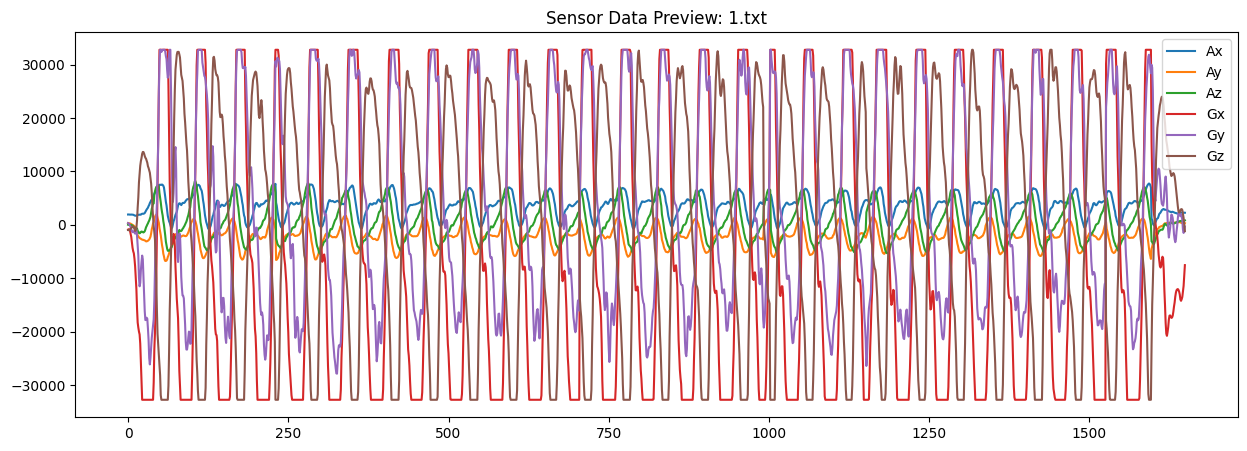

Sample Features:


,Ax_mean,Ax_std,Ax_max,Ax_min,Ay_mean,Ay_std,Ay_max,Ay_min,Az_mean,Az_std,...,Gx_max,Gx_min,Gy_mean,Gy_std,Gy_max,Gy_min,Gz_mean,Gz_std,Gz_max,Gz_min
0,3640.370303,2055.320384,7729,-985,-2142.217576,1962.295504,1917,-6772,286.008485,3451.073849,...,32767,-32768,4586.940606,18956.98507,32767,-27879,179.116364,21803.404496,32767,-32768


In [4]:
# Plot a preview
plt.figure(figsize=(15, 5))
for i, label in enumerate(['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']):
    plt.plot(sensor_data[:, i], label=label)
plt.legend()
plt.title(f"Sensor Data Preview: {sample_file.name}")
plt.show()

# 4. Basic Feature Engineering
def simple_features(arr):
    features = {}
    labels = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
    for i in range(6):
        features[f'{labels[i]}_mean'] = arr[:, i].mean()
        features[f'{labels[i]}_std'] = arr[:, i].std()
        features[f'{labels[i]}_max'] = arr[:, i].max()
        features[f'{labels[i]}_min'] = arr[:, i].min()
    return features

feat = simple_features(sensor_data)
print("Sample Features:")
display(pd.DataFrame([feat]))

In [5]:
def segment_swings(sensor_data, n_swings=27):
    """
    Segment the whole session into ~27 swings evenly.
    Returns: a list of [start_idx:end_idx] arrays.
    """
    swing_indices = np.linspace(0, len(sensor_data), n_swings+1, dtype=int)
    swings = []
    for i in range(n_swings):
        start_idx = swing_indices[i]
        end_idx = swing_indices[i+1]
        swings.append(sensor_data[start_idx:end_idx])
    return swings

# Test it
swings = segment_swings(sensor_data)
print(f"Segmented into {len(swings)} swings.")
print(f"Example swing shape: {swings[0].shape}")

Segmented into 27 swings.
Example swing shape: (61, 6)


In [6]:
import numpy as np
from scipy.stats import skew, kurtosis

def extract_features_from_swing(swing_data):
    """
    Extract enhanced features from one swing (small segment of data).
    swing_data: numpy array of shape (timesteps, 6) [Ax, Ay, Az, Gx, Gy, Gz]
    """
    features = {}

    # Basic statistics for each axis
    for i, axis in enumerate(['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']):
        data_axis = swing_data[:, i]
        features[f'{axis}_mean'] = np.mean(data_axis)
        features[f'{axis}_std'] = np.std(data_axis)
        features[f'{axis}_max'] = np.max(data_axis)
        features[f'{axis}_min'] = np.min(data_axis)
        features[f'{axis}_skew'] = skew(data_axis)
        features[f'{axis}_kurtosis'] = kurtosis(data_axis)

    # Magnitude features
    acc_magnitude = np.linalg.norm(swing_data[:, 0:3], axis=1)
    gyro_magnitude = np.linalg.norm(swing_data[:, 3:6], axis=1)

    features['acc_mag_mean'] = np.mean(acc_magnitude)
    features['acc_mag_std'] = np.std(acc_magnitude)
    features['acc_mag_max'] = np.max(acc_magnitude)
    features['gyro_mag_mean'] = np.mean(gyro_magnitude)
    features['gyro_mag_std'] = np.std(gyro_magnitude)
    features['gyro_mag_max'] = np.max(gyro_magnitude)

    # Axis correlations
    features['corr_Ax_Ay'] = np.corrcoef(swing_data[:, 0], swing_data[:, 1])[0, 1]
    features['corr_Ax_Az'] = np.corrcoef(swing_data[:, 0], swing_data[:, 2])[0, 1]
    features['corr_Ay_Az'] = np.corrcoef(swing_data[:, 1], swing_data[:, 2])[0, 1]

    # Mean sign
    for i, axis in enumerate(['Ax', 'Ay', 'Az']):
        features[f'{axis}_mean_sign'] = np.mean(np.sign(swing_data[:, i]))

    # FFT dominant frequency
    def dominant_freq(signal, fs=85):
        fft_vals = np.abs(np.fft.rfft(signal))
        fft_freq = np.fft.rfftfreq(len(signal), 1/fs)
        dominant = fft_freq[np.argmax(fft_vals)]
        return dominant

    for i, axis in enumerate(['Ax', 'Ay', 'Az']):
        features[f'{axis}_dom_freq'] = dominant_freq(swing_data[:, i])

    # New Features ==================================

    # 1. Peak to Mean Ratio
    features['acc_peak_to_mean_ratio'] = np.max(acc_magnitude) / (np.mean(acc_magnitude) + 1e-6)
    features['gyro_peak_to_mean_ratio'] = np.max(gyro_magnitude) / (np.mean(gyro_magnitude) + 1e-6)

    # 2. Early vs Late Mean Ratio
    mid = swing_data.shape[0] // 2
    features['acc_early_vs_late_mean_ratio'] = (np.mean(acc_magnitude[:mid]) + 1e-6) / (np.mean(acc_magnitude[mid:]) + 1e-6)
    features['gyro_early_vs_late_mean_ratio'] = (np.mean(gyro_magnitude[:mid]) + 1e-6) / (np.mean(gyro_magnitude[mid:]) + 1e-6)

    # 3. Total Energy
    features['acc_total_energy'] = np.sum(acc_magnitude ** 2)
    features['gyro_total_energy'] = np.sum(gyro_magnitude ** 2)

    # 4. Max Skewness and Max Kurtosis across all axes
    skews = [skew(swing_data[:, i]) for i in range(6)]
    kurtoses = [kurtosis(swing_data[:, i]) for i in range(6)]
    features['max_skewness'] = np.max(np.abs(skews))
    features['max_kurtosis'] = np.max(np.abs(kurtoses))

    return features

# Example usage
feat_swing0 = extract_features_from_swing(swings[0])
pd.DataFrame([feat_swing0])


,Ax_mean,Ax_std,Ax_max,Ax_min,Ax_skew,Ax_kurtosis,Ay_mean,Ay_std,Ay_max,Ay_min,...,Ay_dom_freq,Az_dom_freq,acc_peak_to_mean_ratio,gyro_peak_to_mean_ratio,acc_early_vs_late_mean_ratio,gyro_early_vs_late_mean_ratio,acc_total_energy,gyro_total_energy,max_skewness,max_kurtosis
0,3856.721311,2129.387398,7532,1698,0.537805,-1.288881,-1702.213115,2199.471271,1917,-6772,...,0.0,1.393443,1.925298,1.855706,0.361964,0.445109,2.248428e+09,7.721164e+10,0.91061,1.288881


In [7]:
# Extract features for all swings
swing_features_list = [extract_features_from_swing(s) for s in swings]
swing_features_df = pd.DataFrame(swing_features_list)
print(swing_features_df.shape)
display(swing_features_df.head())

(27, 59)


,Ax_mean,Ax_std,Ax_max,Ax_min,Ax_skew,Ax_kurtosis,Ay_mean,Ay_std,Ay_max,Ay_min,...,Ay_dom_freq,Az_dom_freq,acc_peak_to_mean_ratio,gyro_peak_to_mean_ratio,acc_early_vs_late_mean_ratio,gyro_early_vs_late_mean_ratio,acc_total_energy,gyro_total_energy,max_skewness,max_kurtosis
0,3856.721311,2129.387398,7532,1698,0.537805,-1.288881,-1702.213115,2199.471271,1917,-6772,...,0.0,1.393443,1.925298,1.855706,0.361964,0.445109,2.248428e+09,7.721164e+10,0.910610,1.288881
1,3903.393443,2252.045775,7486,-636,-0.332064,-0.793599,-2576.081967,2145.392717,1072,-6486,...,0.0,1.393443,1.613600,1.425813,0.646701,0.840310,2.855622e+09,1.070589e+11,0.622818,1.538193
2,3771.770492,2298.776256,7596,-838,-0.304744,-0.553252,-2319.032787,2164.546543,1177,-6522,...,0.0,1.393443,1.715106,1.510865,0.591541,0.776506,2.609668e+09,9.651356e+10,0.513565,1.430774
3,2952.901639,2328.757783,7662,-495,0.003536,-1.032846,-2401.950820,1997.532211,1345,-6587,...,0.0,1.393443,1.741239,1.642296,0.654757,0.931589,2.361044e+09,7.969801e+10,0.841331,1.283170
4,3850.000000,2206.016743,7533,-378,-0.289517,-0.492397,-2258.295082,2119.006954,1516,-6507,...,0.0,1.393443,1.630921,1.501798,0.559400,0.980948,2.644309e+09,9.718131e+10,0.460758,1.408300


In [8]:
from scipy.stats import skew, kurtosis

def aggregate_swing_features(swing_features_df):
    """
    Aggregate all swings' features into session-level features.
    swing_features_df: DataFrame, each row is a swing's features.
    """

    session_features = {}

    # Basic aggregation: mean, std, min, max over all swings
    for col in swing_features_df.columns:
        session_features[f'{col}_mean'] = swing_features_df[col].mean()
        session_features[f'{col}_std'] = swing_features_df[col].std()
        session_features[f'{col}_min'] = swing_features_df[col].min()
        session_features[f'{col}_max'] = swing_features_df[col].max()

    # Additional: early vs late swings comparison (fatigue effect)
    num_swings = len(swing_features_df)
    early_part = swing_features_df.iloc[:num_swings//3]
    late_part = swing_features_df.iloc[-num_swings//3:]

    for col in swing_features_df.columns:
        session_features[f'{col}_early_mean'] = early_part[col].mean()
        session_features[f'{col}_late_mean'] = late_part[col].mean()
        session_features[f'{col}_early_late_diff'] = early_part[col].mean() - late_part[col].mean()

    return session_features
    
# Test it
session_features = aggregate_swing_features(swing_features_df)
print(f"Final session feature vector size: {len(session_features)}")
pd.DataFrame([session_features])


Final session feature vector size: 413


,Ax_mean_mean,Ax_mean_std,Ax_mean_min,Ax_mean_max,Ax_std_mean,Ax_std_std,Ax_std_min,Ax_std_max,Ax_max_mean,Ax_max_std,...,acc_total_energy_early_late_diff,gyro_total_energy_early_mean,gyro_total_energy_late_mean,gyro_total_energy_early_late_diff,max_skewness_early_mean,max_skewness_late_mean,max_skewness_early_late_diff,max_kurtosis_early_mean,max_kurtosis_late_mean,max_kurtosis_early_late_diff
0,3640.751053,293.597768,2791.854839,4015.163934,2030.054086,145.74768,1680.973649,2328.757783,6950.888889,473.007589,...,283855051.0,9.499602e+10,9.155374e+10,3.442285e+09,0.572513,0.709269,-0.136755,1.457735,1.579395,-0.12166


In [9]:
import warnings
# === Functions we already have ===
# load_sensor_data(filepath)
# segment_swings(sensor_data)
# extract_features_from_swing(swing_data)
# aggregate_swing_features(swing_features_df)

# New: wrap one session
def process_one_file(file_path):
    """
    Process one txt file into a session feature dictionary.
    """
    try:
        data = load_sensor_data(file_path)
        swings = segment_swings(data)
        swing_feats = [extract_features_from_swing(s) for s in swings]
        swing_feats_df = pd.DataFrame(swing_feats)
        session_feats = aggregate_swing_features(swing_feats_df)
        return session_feats
    except Exception as e:
        print(f"Failed processing {file_path.name}: {e}")
        return None

In [10]:
# === Start building full dataset ===

from tqdm.auto import tqdm  # For progress bar
# from tqdm.notebook import tqdm
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Paths
data_folder = Path("./39_Training_Dataset")
train_info = pd.read_csv(data_folder / "train_info.csv")
train_data_folder = data_folder / "train_data"

# Columns
target_mask = ['gender', 'hold racket handed', 'play years', 'level']

X_list = []
y_list = []

In [11]:
# Loop over all txt files
for file_path in tqdm(sorted(train_data_folder.glob("*.txt"))):
    unique_id = int(file_path.stem)
    row_info = train_info[train_info['unique_id'] == unique_id]
    
    if row_info.empty:
        print(f"Warning: {file_path.name} not found in train_info.")
        continue
    
    session_feats = process_one_file(file_path)
    if session_feats is None:
        continue  # skip broken files
    
    # ✅ New: One-hot encode mode
    mode = int(row_info['mode'].values[0])
    for m in range(1, 11):  # mode 1 to 10
        session_feats[f'mode_{m}'] = 1 if mode == m else 0
    
    X_list.append(session_feats)
    y_list.append(row_info[target_mask].iloc[0])

# Build DataFrames
X = pd.DataFrame(X_list)
y = pd.DataFrame(y_list)

print("✅ Finished building dataset!")
print("X shape:", X.shape)
print("y shape:", y.shape)

display(X.head(3))
display(y.head(3))

  0%|          | 0/1955 [00:00<?, ?it/s]

✅ Finished building dataset!
X shape: (1955, 423)
y shape: (1955, 4)


,Ax_mean_mean,Ax_mean_std,Ax_mean_min,Ax_mean_max,Ax_std_mean,Ax_std_std,Ax_std_min,Ax_std_max,Ax_max_mean,Ax_max_std,...,mode_1,mode_2,mode_3,mode_4,mode_5,mode_6,mode_7,mode_8,mode_9,mode_10
0,3640.751053,293.597768,2791.854839,4015.163934,2030.054086,145.747680,1680.973649,2328.757783,6950.888889,473.007589,...,1,0,0,0,0,0,0,0,0,0
1,3167.384553,285.593317,2447.070000,3717.620000,2259.737218,293.347234,1579.383256,3064.851983,9147.666667,896.362307,...,0,0,0,0,0,0,0,0,1,0
2,3343.582601,494.922474,2476.455696,4228.037500,2739.099364,424.898873,1435.674999,3391.845558,10883.407407,1569.944346,...,0,0,0,0,0,0,0,0,0,1


,gender,hold racket handed,play years,level
0,1,1,1,5
9,1,1,1,5
99,1,1,0,5


In [12]:
# 1. How many txt files exist
train_txt_files = list(train_data_folder.glob("*.txt"))
print("Total train_data/*.txt files:", len(train_txt_files))

# 2. How many were successfully processed
print("Total processed into X:", len(X))

Total train_data/*.txt files: 1955
Total processed into X: 1955


In [13]:
# Full range of numbers 1 ~ 1967
full_set = set(range(1, 1968))  # range upper bound is exclusive, so +1

# unique_ids that exist in train_info.csv
train_ids = set(train_info['unique_id'])

# Missing numbers from 1~1967
missing_numbers = sorted(list(full_set - train_ids))

print("Missing numbers in 1~1967:")
print(missing_numbers)
print("Number of missing numbers:", len(missing_numbers))

Missing numbers in 1~1967:
[298, 459, 692, 813, 1092, 1182, 1214, 1304, 1320, 1419, 1426, 1785]
Number of missing numbers: 12


In [15]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# 1. Scale X features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# 2. Encode y labels
le_gender = LabelEncoder()
le_hand = LabelEncoder()
le_years = LabelEncoder()
le_level = LabelEncoder()

y_encoded = pd.DataFrame()
y_encoded['gender'] = le_gender.fit_transform(y['gender'])
y_encoded['hold racket handed'] = le_hand.fit_transform(y['hold racket handed'])
y_encoded['play years'] = le_years.fit_transform(y['play years'])
y_encoded['level'] = le_level.fit_transform(y['level'])

print("✅ Feature scaling and label encoding done.")
print("X_scaled shape:", X_scaled.shape)
print("y_encoded shape:", y_encoded.shape)

# Quick preview
pd.DataFrame(X_scaled).head(3), y_encoded.head(3)


✅ Feature scaling and label encoding done.
X_scaled shape: (1955, 423)
y_encoded shape: (1955, 4)


(        0         1         2         3         4         5         6    \
 0  0.661353  0.054714  0.735069  0.498438  0.212020  0.000000  0.309917   
 1  0.639650  0.052578  0.719275  0.481258  0.239907  0.058019  0.291154   
 2  0.647729  0.108455  0.720622  0.510729  0.298109  0.109730  0.264613   
 
         7         8         9    ...  413  414  415  416  417  418  419  420  \
 0  0.135401  0.265810  0.033655  ...  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 1  0.208461  0.339243  0.084491  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 2  0.240916  0.397265  0.165374  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
 
    421  422  
 0  0.0  0.0  
 1  1.0  0.0  
 2  0.0  1.0  
 
 [3 rows x 423 columns],
    gender  hold racket handed  play years  level
 0       0                   0           1      3
 1       0                   0           1      3
 2       0                   0           0      3)

In [17]:
# 1. During file processing, you built X_list and y_list
# But you can also build a matching 'unique_id_list' to track which files were used.

# Rebuild unique_id list (sorted .txt files)
unique_id_list = [int(p.stem) for p in sorted(train_data_folder.glob("*.txt"))]

print("Length of unique_id_list:", len(unique_id_list))  # should match 1955

Length of unique_id_list: 1955


In [18]:
# Build correct player_ids for X
player_ids = train_info.set_index('unique_id').loc[unique_id_list]['player_id'].values

# Setup GroupKFold
from sklearn.model_selection import GroupKFold

n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

folds = []
for fold_id, (train_idx, val_idx) in enumerate(gkf.split(X_scaled, y_encoded, groups=player_ids)):
    folds.append((train_idx, val_idx))
    print(f"✅ Fold {fold_id}: Train size = {len(train_idx)}, Validation size = {len(val_idx)}")


✅ Fold 0: Train size = 1558, Validation size = 397
✅ Fold 1: Train size = 1572, Validation size = 383
✅ Fold 2: Train size = 1577, Validation size = 378
✅ Fold 3: Train size = 1558, Validation size = 397
✅ Fold 4: Train size = 1555, Validation size = 400


In [28]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# === Helper function to train one target with customized params ===
def train_lightgbm_one_target(X, X_scaled, y_target, folds, target_name):
    is_binary = len(np.unique(y_target)) == 2
    
    if is_binary:
        oof_preds = np.zeros(len(X_scaled))
    else:
        num_classes = len(np.unique(y_target))
        oof_preds = np.zeros((len(X_scaled), num_classes))
    
    print(f"🎯 Start training {target_name}...")

    feature_importance_df = pd.DataFrame()

    for fold_id, (train_idx, val_idx) in enumerate(folds):
        print(f"📂 Fold {fold_id}:")

        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y_target[train_idx], y_target[val_idx]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val)

        # 🔥 Different params based on target
        if target_name == 'hold racket handed':
            params = {
                'objective': 'binary' if is_binary else 'multiclass',
                'metric': 'auc' if is_binary else 'multi_logloss',
                'learning_rate': 0.05,
                'boosting_type': 'gbdt',
                'verbosity': -1,
                'seed': 42,
            }
        elif target_name == 'level':
            params = {
                'objective': 'multiclass',
                'metric': 'multi_logloss',
                'learning_rate': 0.05,
                'boosting_type': 'gbdt',
                'verbosity': -1,
                'seed': 42,
                'num_class': len(np.unique(y_target)),  # ⭐加這行⭐⭐
            }            
        elif target_name == 'gender':
            params = {'learning_rate': 0.17109161642272933,
             'num_leaves': 239,
             'max_depth': 16,
             'min_child_samples': 32,
             'feature_fraction': 0.9771030331396064,
             'bagging_fraction': 0.5119561707773036,
             'bagging_freq': 2,
             'reg_alpha': 0.007169716078677519,
             'reg_lambda': 0.0012685897627296126}
        elif target_name == 'play years':
            params = {
                'objective': 'multiclass',
                'metric': 'multi_logloss',
                'learning_rate': 0.05,
                'boosting_type': 'gbdt',
                'verbosity': -1,
                'seed': 42,
                'class_weight': 'balanced',  # handle imbalance
                'num_class': len(np.unique(y_target)),  # ⭐⭐⭐加這行⭐⭐⭐
            }
        else:
            raise ValueError(f"Unknown target name: {target_name}")

        model = lgb.train(
            params,
            dtrain,
            num_boost_round=10000,
            valid_sets=[dtrain, dval],
            valid_names=['train', 'valid'],
            callbacks=[
                lgb.early_stopping(50),
                lgb.log_evaluation(100)
            ]
        )

        # Predict
        if is_binary:
            preds = model.predict(X_val)
            oof_preds[val_idx] = preds
        else:
            preds = model.predict(X_val)  # shape (n_samples, n_classes)
            oof_preds[val_idx] = preds
        
        # Feature importance (optional)
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importance()
        fold_importance_df["fold"] = fold_id
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # Score
    if is_binary:
        auc = roc_auc_score(y_target, oof_preds, average='micro')
    else:
        auc = roc_auc_score(y_target, oof_preds, multi_class='ovr', average='micro')
    
    print(f"✅ {target_name}: Overall OOF AUC = {auc:.5f}")

    # Optional: aggregate importance
    mean_importance = feature_importance_df.groupby('feature')['importance'].mean().sort_values(ascending=False)
    
    # Save to global dict if needed
    feature_importances[target_name] = mean_importance

    return oof_preds, auc

In [29]:
# ============================
# Now train each target
# ============================

# Initialize dict to store AUCs
auc_scores = {}
feature_importances = {}

# 🎯 1. Gender先訓練 (用全X)
oof_gender, auc_gender = train_lightgbm_one_target(X, X_scaled, y_encoded['gender'].values, folds, 'gender')
auc_scores['gender'] = auc_gender

# 🎯 2. Feature Selection
def select_important_features(importances, threshold=0.95):
    sorted_features = importances.sort_values(ascending=False)
    cumulative_importance = sorted_features.cumsum()
    selected = cumulative_importance[cumulative_importance <= threshold].index.tolist()
    return selected

gender_importance = feature_importances['gender']  # <-- 用剛訓練出來的 importance
important_features = select_important_features(gender_importance, threshold=0.95)

if len(important_features) == 0:
    important_features = list(X.columns)  # 如果沒選到，就退回用全部 feature

# 🎯 3. 用重要特徵重新準備資料
X_selected = X[important_features]
scaler = MinMaxScaler()
X_selected_scaled = scaler.fit_transform(X_selected)

🎯 Start training gender...
📂 Fold 0:
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 102629
[LightGBM] [Info] Number of data points in the train set: 1558, number of used features: 418
[LightGBM] [Info] Start training from score 0.114891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

In [35]:
X_selected.columns

Index(['Ax_mean_mean', 'Ax_mean_std', 'Ax_mean_min', 'Ax_mean_max',
       'Ax_std_mean', 'Ax_std_std', 'Ax_std_min', 'Ax_std_max', 'Ax_max_mean',
       'Ax_max_std',
       ...
       'mode_1', 'mode_2', 'mode_3', 'mode_4', 'mode_5', 'mode_6', 'mode_7',
       'mode_8', 'mode_9', 'mode_10'],
      dtype='object', length=423)

In [33]:
# 🎯 4. (新增！) 對 X_selected 加 Play Years 特製新特徵 (基於 X_selected)

def add_play_years_features_from_X(df):
    acc_magnitude = np.sqrt(df['Ax_mean']**2 + df['Ay_mean']**2 + df['Az_mean']**2)
    gyro_magnitude = np.sqrt(df['Gx_mean']**2 + df['Gy_mean']**2 + df['Gz_mean']**2)
    
    df['acc_energy_total'] = acc_magnitude ** 2
    df['gyro_energy_total'] = gyro_magnitude ** 2
    df['acc_vs_gyro_energy_ratio'] = df['acc_energy_total'] / (df['gyro_energy_total'] + 1e-6)
    df['early_acc_mean'] = (df['Ax_mean'] + df['Ay_mean']) / 2  # 假設 early是x/y方向動作（大多情況）
    df['late_acc_mean'] = df['Az_mean']  # 假設 late 是z方向(垂直軸)收尾
    df['early_late_energy_ratio'] = df['early_acc_mean'] / (df['late_acc_mean'] + 1e-6)
    
    return df

# ➔ 只加在 play years用的資料上
X_selected_plus_play_years = add_play_years_features_from_X(X_selected.copy())
X_selected_plus_play_years_scaled = scaler.fit_transform(X_selected_plus_play_years)


KeyError: 'Ax_mean'

In [ ]:
# 🎯 5. 開始針對各 target 訓練
# 注意！hand和level還是用 X_selected
# 只有 play years 用 X_selected_plus_play_years

# Handedness
oof_hand, auc_hand = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['hold racket handed'].values, folds, 'hold racket handed')
auc_scores['handed'] = auc_hand

# Play Years (用加特徵版！)
oof_years, auc_years = train_lightgbm_one_target(X_selected_plus_play_years, X_selected_plus_play_years_scaled, y_encoded['play years'].values, folds, 'play years')
auc_scores['years'] = auc_years

# Level
oof_level, auc_level = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['level'].values, folds, 'level')
auc_scores['level'] = auc_level

# ============================
# Final Score Computation
# ============================

final_cv_score = np.mean(list(auc_scores.values()))
print("🎯 Final CV Average Score = {:.5f}".format(final_cv_score))

# Hyperparameter tuning : Optuna

In [45]:
import optuna
import time
import json

# === 目標函數 ===
def objective_gender(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 512),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    # 這裡用你現在已經有的 CV + lgb.train 函數去測 AUC
    oof_preds, auc = train_lightgbm_one_target(X, X_scaled, y_encoded['gender'].values, folds, 'gender', custom_params=params)
    return 1.0 - auc  # 越小越好（1-AUC）

# === 開始Optuna Tuning ===
study = optuna.create_study(direction='minimize')
study.optimize(objective_gender, n_trials=3000)

# === 儲存最佳參數（加上時間戳記）===
timestamp = time.strftime("%Y%m%d-%H%M%S")
best_params = study.best_params
with open(f'best_params_gender_{timestamp}.json', 'w') as f:
    json.dump(best_params, f, indent=4)

print("✅ Best params saved to:", f'best_params_gender_{timestamp}.json')


[I 2025-04-28 14:04:07,704] A new study created in memory with name: no-name-91ab8bb7-3650-49ad-a9ae-d25463cd118b


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.988239	valid's auc: 0.561512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957373	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.994624	valid's auc: 0.643145
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.996695	valid's auc: 0.937412
Early stopping, best iteration is:
[81]	train's auc: 0.994833	valid's auc: 0.944383
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.996419	valid's auc: 0.983599
[200]	train's auc: 0.999842	valid's auc: 0.992021


[I 2025-04-28 14:04:10,770] Trial 0 finished with value: 0.6696889007150674 and parameters: {'learning_rate': 0.019430083234681445, 'num_leaves': 313, 'max_depth': 13, 'min_child_samples': 46, 'feature_fraction': 0.896324043710817, 'bagging_fraction': 0.528038146480768, 'bagging_freq': 6, 'reg_alpha': 9.628456779370025e-06, 'reg_lambda': 0.05401381252573563}. Best is trial 0 with value: 0.6696889007150674.


Early stopping, best iteration is:
[241]	train's auc: 0.999947	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.937134	valid's auc: 0.572743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951389	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.973129	valid's auc: 0.684701
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 0.968418	valid's auc: 0.943048
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.984207	valid's auc: 0.979499
[200]	train's auc: 0.994586	valid's auc: 0.98648


[I 2025-04-28 14:04:13,990] Trial 1 finished with value: 0.5869108564318588 and parameters: {'learning_rate': 0.01243644128854473, 'num_leaves': 469, 'max_depth': 11, 'min_child_samples': 98, 'feature_fraction': 0.8989630428368652, 'bagging_fraction': 0.7276632123910381, 'bagging_freq': 8, 'reg_alpha': 2.866181475877798e-05, 'reg_lambda': 0.004523719212125088}. Best is trial 0 with value: 0.6696889007150674.


Early stopping, best iteration is:
[233]	train's auc: 0.996555	valid's auc: 0.988143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.997464	valid's auc: 0.519945
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.968681	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.996333	valid's auc: 0.669213
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.990499	valid's auc: 0.924008
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993129
Early stopping, best iteration is:
[90]	train's auc: 1	valid's auc: 0.994792


[I 2025-04-28 14:04:16,680] Trial 2 finished with value: 0.6089531458467627 and parameters: {'learning_rate': 0.07123574371749859, 'num_leaves': 493, 'max_depth': 6, 'min_child_samples': 62, 'feature_fraction': 0.8553728081184869, 'bagging_fraction': 0.8978100469743839, 'bagging_freq': 6, 'reg_alpha': 3.9009479970660844e-05, 'reg_lambda': 0.25389527372930226}. Best is trial 0 with value: 0.6696889007150674.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.996856	valid's auc: 0.483898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957633	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.993723	valid's auc: 0.653961
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.992416	valid's auc: 0.892158
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:18,605] Trial 3 finished with value: 0.5697359347594705 and parameters: {'learning_rate': 0.07062914897443019, 'num_leaves': 257, 'max_depth': 4, 'min_child_samples': 86, 'feature_fraction': 0.570450500712462, 'bagging_fraction': 0.9238744199888131, 'bagging_freq': 8, 'reg_alpha': 0.00015796797964099955, 'reg_lambda': 6.38880335333781e-07}. Best is trial 0 with value: 0.6696889007150674.


Early stopping, best iteration is:
[42]	train's auc: 0.998472	valid's auc: 0.98648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939737	valid's auc: 0.52805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955626	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992947	valid's auc: 0.672604
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.939451
[200]	train's auc: 1	valid's auc: 0.949611
Early stopping, best iteration is:
[161]	train's auc: 1	valid's auc: 0.950426
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991467


[I 2025-04-28 14:04:21,782] Trial 4 finished with value: 0.702853523618211 and parameters: {'learning_rate': 0.12132308474605107, 'num_leaves': 391, 'max_depth': 14, 'min_child_samples': 23, 'feature_fraction': 0.712244301863272, 'bagging_fraction': 0.5107042469582843, 'bagging_freq': 1, 'reg_alpha': 1.2700799619971704e-07, 'reg_lambda': 0.3338678184289957}. Best is trial 4 with value: 0.702853523618211.


Early stopping, best iteration is:
[113]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.941671	valid's auc: 0.654268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951173	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.988056	valid's auc: 0.642647
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.980704	valid's auc: 0.94937
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99665	valid's auc: 0.98781


[I 2025-04-28 14:04:24,243] Trial 5 finished with value: 0.6090140465018664 and parameters: {'learning_rate': 0.024585212865778402, 'num_leaves': 109, 'max_depth': 15, 'min_child_samples': 72, 'feature_fraction': 0.837740595304473, 'bagging_fraction': 0.6906678549567282, 'bagging_freq': 5, 'reg_alpha': 5.607432187450097e-05, 'reg_lambda': 1.8081973081867066e-05}. Best is trial 4 with value: 0.702853523618211.


Early stopping, best iteration is:
[142]	train's auc: 0.999187	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.982189	valid's auc: 0.530905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959068	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.991416	valid's auc: 0.635057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	train's auc: 0.982123	valid's auc: 0.9269
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99132	valid's auc: 0.980164
[200]	train's auc: 0.997423	valid's auc: 0.988032


[I 2025-04-28 14:04:27,359] Trial 6 finished with value: 0.6109600566657172 and parameters: {'learning_rate': 0.01263909895191315, 'num_leaves': 398, 'max_depth': 11, 'min_child_samples': 79, 'feature_fraction': 0.9335953031153893, 'bagging_fraction': 0.9039787611134967, 'bagging_freq': 7, 'reg_alpha': 0.0853348494292264, 'reg_lambda': 2.591670180758581}. Best is trial 4 with value: 0.702853523618211.


Early stopping, best iteration is:
[216]	train's auc: 0.997907	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939019	valid's auc: 0.504817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.974383	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.998023	valid's auc: 0.698506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.995586	valid's auc: 0.829422
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999093	valid's auc: 0.98504
[200]	train's auc: 0.99989	valid's auc: 0.989029
[300]	train's auc: 0.999995	valid's auc: 0.992465


[I 2025-04-28 14:04:31,125] Trial 7 finished with value: 0.5316945747822568 and parameters: {'learning_rate': 0.011144725533954822, 'num_leaves': 354, 'max_depth': 7, 'min_child_samples': 25, 'feature_fraction': 0.5424984027352602, 'bagging_fraction': 0.800190003920656, 'bagging_freq': 10, 'reg_alpha': 0.07302144967436698, 'reg_lambda': 6.174511906746838e-07}. Best is trial 4 with value: 0.702853523618211.


Early stopping, best iteration is:
[316]	train's auc: 0.999997	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.981915	valid's auc: 0.618424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.899013	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.987312	valid's auc: 0.652989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.963369	valid's auc: 0.971876
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99874	valid's auc: 0.98504
Early stopping, best iteration is:
[105]	train's auc: 0.998951	valid's auc: 0.985816


[I 2025-04-28 14:04:33,216] Trial 8 finished with value: 0.6334708126583417 and parameters: {'learning_rate': 0.058078450090644024, 'num_leaves': 388, 'max_depth': 2, 'min_child_samples': 12, 'feature_fraction': 0.5557810537535219, 'bagging_fraction': 0.9758124679619915, 'bagging_freq': 4, 'reg_alpha': 6.144052493664566e-05, 'reg_lambda': 9.49679401717072e-07}. Best is trial 4 with value: 0.702853523618211.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946547	valid's auc: 0.657123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951492	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.992797	valid's auc: 0.674929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.98043	valid's auc: 0.948684
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999124	valid's auc: 0.990913


[I 2025-04-28 14:04:35,565] Trial 9 finished with value: 0.5645031630863326 and parameters: {'learning_rate': 0.03173885772519547, 'num_leaves': 342, 'max_depth': 14, 'min_child_samples': 55, 'feature_fraction': 0.9576873242722408, 'bagging_fraction': 0.624395768312346, 'bagging_freq': 3, 'reg_alpha': 2.7520439687652503e-08, 'reg_lambda': 0.9133375758923683}. Best is trial 4 with value: 0.702853523618211.


Early stopping, best iteration is:
[113]	train's auc: 0.999477	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.982462	valid's auc: 0.538753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957123	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993679	valid's auc: 0.658634
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998664	valid's auc: 0.947534
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:37,783] Trial 10 finished with value: 0.7071671638658612 and parameters: {'learning_rate': 0.19172167055669906, 'num_leaves': 170, 'max_depth': 16, 'min_child_samples': 36, 'feature_fraction': 0.7128808164398943, 'bagging_fraction': 0.5211023542124826, 'bagging_freq': 1, 'reg_alpha': 1.3844686281286253e-08, 'reg_lambda': 0.0015380744995304705}. Best is trial 10 with value: 0.7071671638658612.


[100]	train's auc: 1	valid's auc: 0.986702
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.985667	valid's auc: 0.647286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955517	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995535	valid's auc: 0.674763
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920096
[200]	train's auc: 1	valid's auc: 0.91624
Early stopping, best iteration is:
[154]	train's auc: 1	valid's auc: 0.926288
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:40,587] Trial 11 finished with value: 0.7075447479275039 and parameters: {'learning_rate': 0.19898597224710715, 'num_leaves': 126, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.7007115970202212, 'bagging_fraction': 0.5008224156744837, 'bagging_freq': 1, 'reg_alpha': 1.0134419200816395e-08, 'reg_lambda': 0.00023967939613066703}. Best is trial 11 with value: 0.7075447479275039.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.988918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961593	valid's auc: 0.555721
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961819	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994129	valid's auc: 0.710081
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.984701	valid's auc: 0.915165
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:42,537] Trial 12 finished with value: 0.7226612274573883 and parameters: {'learning_rate': 0.19266194029050382, 'num_leaves': 110, 'max_depth': 16, 'min_child_samples': 40, 'feature_fraction': 0.6944103142344284, 'bagging_fraction': 0.5918501291210474, 'bagging_freq': 1, 'reg_alpha': 3.196124708530195e-07, 'reg_lambda': 0.0003712993736527214}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[20]	train's auc: 0.999884	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.419571
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.457621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949883	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98951	valid's auc: 0.753819
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999839	valid's auc: 0.952317
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:44,849] Trial 13 finished with value: 0.5441342362870464 and parameters: {'learning_rate': 0.18951435209155254, 'num_leaves': 20, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.6457923915795587, 'bagging_fraction': 0.6217103305715344, 'bagging_freq': 2, 'reg_alpha': 4.7137558624786016e-07, 'reg_lambda': 7.36851695830589e-05}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[20]	train's auc: 0.999635	valid's auc: 0.985926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994847	valid's auc: 0.47973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975734	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.997979	valid's auc: 0.720802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.941565
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:48,281] Trial 14 finished with value: 0.657810462170387 and parameters: {'learning_rate': 0.12797677982213154, 'num_leaves': 142, 'max_depth': 9, 'min_child_samples': 11, 'feature_fraction': 0.7827869975631789, 'bagging_fraction': 0.5895402619874556, 'bagging_freq': 3, 'reg_alpha': 1.1734971142389937e-06, 'reg_lambda': 1.091265510690907e-08}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[37]	train's auc: 0.999974	valid's auc: 0.986148
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999988	valid's auc: 0.438082
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954501	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994607	valid's auc: 0.652277
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.93845
Early stopping, best iteration is:
[96]	train's auc: 1	valid's auc: 0.941305
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:50,751] Trial 15 finished with value: 0.5963916830317657 and parameters: {'learning_rate': 0.10929320466004826, 'num_leaves': 39, 'max_depth': 16, 'min_child_samples': 43, 'feature_fraction': 0.6490612006398772, 'bagging_fraction': 0.5747086727360079, 'bagging_freq': 1, 'reg_alpha': 0.003970163382158133, 'reg_lambda': 0.0001612486844880488}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[37]	train's auc: 0.999884	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999725	valid's auc: 0.532231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.970002	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.992303	valid's auc: 0.707068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	train's auc: 0.999972	valid's auc: 0.919689
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989694
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.991246


[I 2025-04-28 14:04:53,549] Trial 16 finished with value: 0.6477018903563344 and parameters: {'learning_rate': 0.0982925698208752, 'num_leaves': 222, 'max_depth': 13, 'min_child_samples': 25, 'feature_fraction': 0.6297499562824179, 'bagging_fraction': 0.6799638067630587, 'bagging_freq': 3, 'reg_alpha': 2.0376622184163653e-06, 'reg_lambda': 0.007455019143329652}. Best is trial 12 with value: 0.7226612274573883.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.55177
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966673	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999541	valid's auc: 0.612073
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.94327
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:56,272] Trial 17 finished with value: 0.6689262371265385 and parameters: {'learning_rate': 0.19992879850828674, 'num_leaves': 95, 'max_depth': 16, 'min_child_samples': 59, 'feature_fraction': 0.7520877769824071, 'bagging_fraction': 0.8004338918831067, 'bagging_freq': 2, 'reg_alpha': 1.4084376278696735e-07, 'reg_lambda': 5.967592887328692e-06}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.982824
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.998331	valid's auc: 0.496265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962699	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994504	valid's auc: 0.669806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.996541	valid's auc: 0.958065
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:04:58,835] Trial 18 finished with value: 0.613566604704154 and parameters: {'learning_rate': 0.04316241698632376, 'num_leaves': 196, 'max_depth': 9, 'min_child_samples': 34, 'feature_fraction': 0.696609681622587, 'bagging_fraction': 0.581974558269268, 'bagging_freq': 2, 'reg_alpha': 0.0033420144154619113, 'reg_lambda': 0.0004544772128185642}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.990802
Early stopping, best iteration is:
[79]	train's auc: 0.999884	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948337	valid's auc: 0.561187
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.974569	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.995777	valid's auc: 0.695873
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999282	valid's auc: 0.959473
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:00,570] Trial 19 finished with value: 0.6535745873746384 and parameters: {'learning_rate': 0.14726851193733273, 'num_leaves': 81, 'max_depth': 12, 'min_child_samples': 5, 'feature_fraction': 0.804481865115433, 'bagging_fraction': 0.6545141629480054, 'bagging_freq': 4, 'reg_alpha': 5.336288902128097, 'reg_lambda': 0.033666898840831155}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 0.9999	valid's auc: 0.991578
Early stopping, best iteration is:
[53]	train's auc: 0.999895	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.990387	valid's auc: 0.639275
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957795	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.995403	valid's auc: 0.62806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.987867	valid's auc: 0.944123
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989916


[I 2025-04-28 14:05:03,093] Trial 20 finished with value: 0.6945635390588694 and parameters: {'learning_rate': 0.08931795027686898, 'num_leaves': 136, 'max_depth': 7, 'min_child_samples': 50, 'feature_fraction': 0.5007444665821075, 'bagging_fraction': 0.5533348026324859, 'bagging_freq': 4, 'reg_alpha': 1.1767266498775095e-08, 'reg_lambda': 1.2994101521280174e-05}. Best is trial 12 with value: 0.7226612274573883.


[200]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[160]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.928345	valid's auc: 0.498417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958487	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99458	valid's auc: 0.667173
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953393
Early stopping, best iteration is:
[114]	train's auc: 1	valid's auc: 0.954727
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990137


[I 2025-04-28 14:05:06,213] Trial 21 finished with value: 0.6903089256000119 and parameters: {'learning_rate': 0.15572948278762963, 'num_leaves': 179, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.7160690214358298, 'bagging_fraction': 0.5072763778719791, 'bagging_freq': 1, 'reg_alpha': 1.4209102393408393e-08, 'reg_lambda': 0.0013720107238786648}. Best is trial 12 with value: 0.7226612274573883.


[200]	train's auc: 1	valid's auc: 0.992908
Early stopping, best iteration is:
[154]	train's auc: 1	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993038	valid's auc: 0.55407
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959942	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992483	valid's auc: 0.698221
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94772
Early stopping, best iteration is:
[57]	train's auc: 1	valid's auc: 0.962736
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:08,495] Trial 22 finished with value: 0.6836342138006506 and parameters: {'learning_rate': 0.16764637864709822, 'num_leaves': 164, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.6755715115973575, 'bagging_fraction': 0.5048578233470015, 'bagging_freq': 1, 'reg_alpha': 9.719767020688528e-08, 'reg_lambda': 0.0012936552873234997}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[38]	train's auc: 0.999995	valid's auc: 0.991135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939694	valid's auc: 0.582729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959002	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997912	valid's auc: 0.689635
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999975	valid's auc: 0.941973
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:10,935] Trial 23 finished with value: 0.7218648342752636 and parameters: {'learning_rate': 0.19881339566545056, 'num_leaves': 238, 'max_depth': 14, 'min_child_samples': 29, 'feature_fraction': 0.6071346208009147, 'bagging_fraction': 0.5603812907499283, 'bagging_freq': 2, 'reg_alpha': 4.888438797395858e-06, 'reg_lambda': 7.919351400940623e-05}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[38]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999915	valid's auc: 0.535939
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969627	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.996977	valid's auc: 0.692766
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.946607
Early stopping, best iteration is:
[137]	train's auc: 1	valid's auc: 0.951279
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:14,368] Trial 24 finished with value: 0.6485235807336561 and parameters: {'learning_rate': 0.13666516689963637, 'num_leaves': 261, 'max_depth': 14, 'min_child_samples': 20, 'feature_fraction': 0.602639820176169, 'bagging_fraction': 0.6131871020017176, 'bagging_freq': 2, 'reg_alpha': 5.761417860465953e-06, 'reg_lambda': 5.0851949126263306e-05}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.998914	valid's auc: 0.589413
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957077	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993809	valid's auc: 0.686622
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.934965
Early stopping, best iteration is:
[60]	train's auc: 0.999991	valid's auc: 0.94861
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:17,110] Trial 25 finished with value: 0.6621587689447883 and parameters: {'learning_rate': 0.08369526021422047, 'num_leaves': 73, 'max_depth': 13, 'min_child_samples': 31, 'feature_fraction': 0.6007023514292524, 'bagging_fraction': 0.5535521833525949, 'bagging_freq': 3, 'reg_alpha': 3.4482048655113083e-07, 'reg_lambda': 2.23091608174384e-06}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[36]	train's auc: 0.999361	valid's auc: 0.985372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98525	valid's auc: 0.544328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951614	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992664	valid's auc: 0.666319
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.918094
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.937671
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988586


[I 2025-04-28 14:05:19,902] Trial 26 finished with value: 0.6842685175468841 and parameters: {'learning_rate': 0.14849208979990375, 'num_leaves': 233, 'max_depth': 15, 'min_child_samples': 66, 'feature_fraction': 0.7813768499963314, 'bagging_fraction': 0.6548453398627387, 'bagging_freq': 2, 'reg_alpha': 2.220782447481395e-06, 'reg_lambda': 7.056992575715732e-08}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[106]	train's auc: 1	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.500704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966762	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993147	valid's auc: 0.686409
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.924175
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.944679
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:23,015] Trial 27 finished with value: 0.6532588409012547 and parameters: {'learning_rate': 0.11166126299674466, 'num_leaves': 287, 'max_depth': 12, 'min_child_samples': 50, 'feature_fraction': 0.7497319470918081, 'bagging_fraction': 0.7807847263382357, 'bagging_freq': 1, 'reg_alpha': 6.895362281888039e-08, 'reg_lambda': 0.000304138657044579}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.987589
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 0.999773	valid's auc: 0.490582
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969831	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.990986	valid's auc: 0.699241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99287	valid's auc: 0.922469
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993129


[I 2025-04-28 14:05:25,735] Trial 28 finished with value: 0.5557831262086438 and parameters: {'learning_rate': 0.04913915979104033, 'num_leaves': 52, 'max_depth': 15, 'min_child_samples': 29, 'feature_fraction': 0.680109492629692, 'bagging_fraction': 0.7262696236190261, 'bagging_freq': 5, 'reg_alpha': 5.164921680295372e-07, 'reg_lambda': 0.016887610966374818}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.984162	valid's auc: 0.495548
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964085	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.980301	valid's auc: 0.713757
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960148	valid's auc: 0.908102
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:28,210] Trial 29 finished with value: 0.5111570000149909 and parameters: {'learning_rate': 0.018815245709274172, 'num_leaves': 135, 'max_depth': 14, 'min_child_samples': 16, 'feature_fraction': 0.6112811949602909, 'bagging_fraction': 0.5521767830643856, 'bagging_freq': 10, 'reg_alpha': 8.298771165778503e-06, 'reg_lambda': 7.41869531157746e-05}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[49]	train's auc: 0.996992	valid's auc: 0.98637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.983736	valid's auc: 0.716781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944482	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.9865	valid's auc: 0.641485
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.985224	valid's auc: 0.953263
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:30,000] Trial 30 finished with value: 0.7165955222090635 and parameters: {'learning_rate': 0.17608097823449212, 'num_leaves': 312, 'max_depth': 12, 'min_child_samples': 44, 'feature_fraction': 0.6639122984579868, 'bagging_fraction': 0.5409381029098739, 'bagging_freq': 2, 'reg_alpha': 0.0006939377029148082, 'reg_lambda': 9.558984232777998}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[24]	train's auc: 0.995856	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986524	valid's auc: 0.707729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952935	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996421	valid's auc: 0.649881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.990334	valid's auc: 0.878013
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:32,037] Trial 31 finished with value: 0.7154187341658297 and parameters: {'learning_rate': 0.16831848248117828, 'num_leaves': 313, 'max_depth': 12, 'min_child_samples': 44, 'feature_fraction': 0.6628416751480083, 'bagging_fraction': 0.5480948082875893, 'bagging_freq': 2, 'reg_alpha': 0.0059867033515665895, 'reg_lambda': 0.13311124794680462}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.990808	valid's auc: 0.612633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944605	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.995116	valid's auc: 0.658491
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999994	valid's auc: 0.906007
Early stopping, best iteration is:
[60]	train's auc: 0.999868	valid's auc: 0.931294
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:34,291] Trial 32 finished with value: 0.7165833420780428 and parameters: {'learning_rate': 0.16104253557647816, 'num_leaves': 318, 'max_depth': 10, 'min_child_samples': 45, 'feature_fraction': 0.6592728215225788, 'bagging_fraction': 0.5466701507234152, 'bagging_freq': 3, 'reg_alpha': 0.0020321103397170598, 'reg_lambda': 5.014598644763231}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 0.999989	valid's auc: 0.991356
Early stopping, best iteration is:
[61]	train's auc: 0.999895	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.988843	valid's auc: 0.578467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.934619	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987222	valid's auc: 0.613567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.989967	valid's auc: 0.977086
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:36,367] Trial 33 finished with value: 0.6678918629229317 and parameters: {'learning_rate': 0.13055936063644807, 'num_leaves': 433, 'max_depth': 10, 'min_child_samples': 48, 'feature_fraction': 0.5802603079718541, 'bagging_fraction': 0.5974461982447107, 'bagging_freq': 3, 'reg_alpha': 0.0006755200376931443, 'reg_lambda': 3.035073858631839}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.993129
Early stopping, best iteration is:
[61]	train's auc: 0.999921	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.987158	valid's auc: 0.625947
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.931086	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953043	valid's auc: 0.627443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.988601	valid's auc: 0.943901
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999624	valid's auc: 0.983045
Early stopping, best iteration is:
[85]	train's auc: 0.999253	valid's auc: 0.984153


[I 2025-04-28 14:05:38,429] Trial 34 finished with value: 0.643445403031166 and parameters: {'learning_rate': 0.07393334887318029, 'num_leaves': 307, 'max_depth': 10, 'min_child_samples': 55, 'feature_fraction': 0.5199328183804706, 'bagging_fraction': 0.6510730554404393, 'bagging_freq': 4, 'reg_alpha': 0.0008098402640566607, 'reg_lambda': 8.720329059136402}. Best is trial 12 with value: 0.7226612274573883.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.974162	valid's auc: 0.626434
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.903289	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.966643	valid's auc: 0.564682
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.989404	valid's auc: 0.972303
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:40,296] Trial 35 finished with value: 0.6949654833825536 and parameters: {'learning_rate': 0.16501136301370686, 'num_leaves': 347, 'max_depth': 13, 'min_child_samples': 98, 'feature_fraction': 0.6284183725117747, 'bagging_fraction': 0.5389557245984403, 'bagging_freq': 2, 'reg_alpha': 0.00026506131191436996, 'reg_lambda': 6.7732893008307755}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[42]	train's auc: 0.997152	valid's auc: 0.987145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.995183	valid's auc: 0.572472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961485	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987159	valid's auc: 0.625213
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999997	valid's auc: 0.944383
Early stopping, best iteration is:
[91]	train's auc: 0.999994	valid's auc: 0.94861
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999997	valid's auc: 0.990359


[I 2025-04-28 14:05:43,059] Trial 36 finished with value: 0.6705733656138037 and parameters: {'learning_rate': 0.10423610525056577, 'num_leaves': 268, 'max_depth': 8, 'min_child_samples': 41, 'feature_fraction': 0.7297668198169742, 'bagging_fraction': 0.5763275958492908, 'bagging_freq': 6, 'reg_alpha': 0.04290970453804745, 'reg_lambda': 0.4006708267349216}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[122]	train's auc: 1	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.992712	valid's auc: 0.563244
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958218	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98147	valid's auc: 0.615939
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.909752
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.922284
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:45,576] Trial 37 finished with value: 0.6601855877194298 and parameters: {'learning_rate': 0.12474365642973641, 'num_leaves': 468, 'max_depth': 10, 'min_child_samples': 65, 'feature_fraction': 0.5897072537222504, 'bagging_fraction': 0.7238936198820543, 'bagging_freq': 3, 'reg_alpha': 2.6353271788814612e-05, 'reg_lambda': 0.09435987961615099}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.991246
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.910843	valid's auc: 0.543773
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951087	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.942103	valid's auc: 0.66046
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.971225	valid's auc: 0.937727
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.980053


[I 2025-04-28 14:05:47,554] Trial 38 finished with value: 0.6398044807891226 and parameters: {'learning_rate': 0.1698097937386948, 'num_leaves': 220, 'max_depth': 5, 'min_child_samples': 90, 'feature_fraction': 0.6270088669598317, 'bagging_fraction': 0.6888213570105791, 'bagging_freq': 5, 'reg_alpha': 0.02123583156545966, 'reg_lambda': 1.3727313094080242}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.980718
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.993897	valid's auc: 0.529471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947331	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.971846	valid's auc: 0.584084
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999931	valid's auc: 0.939377
Early stopping, best iteration is:
[94]	train's auc: 0.999874	valid's auc: 0.95228
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:50,073] Trial 39 finished with value: 0.6596431034224294 and parameters: {'learning_rate': 0.08260777416929399, 'num_leaves': 311, 'max_depth': 11, 'min_child_samples': 59, 'feature_fraction': 0.8626170125689416, 'bagging_fraction': 0.5321163641153077, 'bagging_freq': 8, 'reg_alpha': 0.0001188075213328205, 'reg_lambda': 0.4240599090167715}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 0.999895	valid's auc: 0.993129
Early stopping, best iteration is:
[68]	train's auc: 0.998977	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999449	valid's auc: 0.486685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965418	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99465	valid's auc: 0.675901
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978376	valid's auc: 0.959195
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.987256
[200]	train's auc: 1	valid's auc: 0.988475
[300]	train's auc: 1	valid's auc: 0.990137
Early stopping, best iteration is:
[295]	train's auc: 1	valid's auc: 0.991024


[I 2025-04-28 14:05:53,712] Trial 40 finished with value: 0.5777289115085373 and parameters: {'learning_rate': 0.06499102344888097, 'num_leaves': 378, 'max_depth': 12, 'min_child_samples': 29, 'feature_fraction': 0.5415661814956108, 'bagging_fraction': 0.6080548921502882, 'bagging_freq': 4, 'reg_alpha': 0.0009532841436192535, 'reg_lambda': 1.5413487676918085e-07}. Best is trial 12 with value: 0.7226612274573883.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.987699	valid's auc: 0.611469
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952852	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991405	valid's auc: 0.666295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.957842
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:56,034] Trial 41 finished with value: 0.7070687858845399 and parameters: {'learning_rate': 0.1689559222768588, 'num_leaves': 335, 'max_depth': 12, 'min_child_samples': 45, 'feature_fraction': 0.6638775147772729, 'bagging_fraction': 0.5578759116515072, 'bagging_freq': 2, 'reg_alpha': 0.007900598655776365, 'reg_lambda': 0.09345339487492117}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994338	valid's auc: 0.523233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.972555	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.991505	valid's auc: 0.666437
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.927994
[200]	train's auc: 1	valid's auc: 0.935892
Early stopping, best iteration is:
[187]	train's auc: 1	valid's auc: 0.936967
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:05:58,543] Trial 42 finished with value: 0.6325647982970303 and parameters: {'learning_rate': 0.1742357039666849, 'num_leaves': 290, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.6623380182739419, 'bagging_fraction': 0.8603522594137915, 'bagging_freq': 2, 'reg_alpha': 0.6907814034903044, 'reg_lambda': 3.111061844064313}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[11]	train's auc: 0.996768	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999964	valid's auc: 0.557967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950739	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993454	valid's auc: 0.664991
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940786
Early stopping, best iteration is:
[123]	train's auc: 1	valid's auc: 0.946719
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:01,210] Trial 43 finished with value: 0.6518337655718291 and parameters: {'learning_rate': 0.1423354428533863, 'num_leaves': 371, 'max_depth': 9, 'min_child_samples': 47, 'feature_fraction': 0.68687296922065, 'bagging_fraction': 0.527074814672523, 'bagging_freq': 1, 'reg_alpha': 0.010209862485045164, 'reg_lambda': 0.8911731203500922}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.988143
Early stopping, best iteration is:
[54]	train's auc: 0.999961	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.984172	valid's auc: 0.543042
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.935993	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990861	valid's auc: 0.654649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.967941	valid's auc: 0.963515
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:03,321] Trial 44 finished with value: 0.6345407903218553 and parameters: {'learning_rate': 0.198704132863634, 'num_leaves': 414, 'max_depth': 14, 'min_child_samples': 54, 'feature_fraction': 0.9996360913710294, 'bagging_fraction': 0.6338764878821068, 'bagging_freq': 3, 'reg_alpha': 0.18418885164961663, 'reg_lambda': 9.505698242072173}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 0.999987	valid's auc: 0.983932
Early stopping, best iteration is:
[69]	train's auc: 0.999955	valid's auc: 0.988254
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.997407	valid's auc: 0.497321
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954707	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989482	valid's auc: 0.620232
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.932295
Early stopping, best iteration is:
[133]	train's auc: 1	valid's auc: 0.94086
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:06,067] Trial 45 finished with value: 0.6511563629004453 and parameters: {'learning_rate': 0.1146335307318336, 'num_leaves': 326, 'max_depth': 11, 'min_child_samples': 43, 'feature_fraction': 0.5661847573984702, 'bagging_fraction': 0.5753830814328625, 'bagging_freq': 7, 'reg_alpha': 0.0016585367145744742, 'reg_lambda': 0.14550841573926024}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.989694
Early stopping, best iteration is:
[67]	train's auc: 0.999855	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.966513	valid's auc: 0.674158
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.883029	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.978405	valid's auc: 0.673577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.978658	valid's auc: 0.978495
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999966	valid's auc: 0.989694


[I 2025-04-28 14:06:07,985] Trial 46 finished with value: 0.6907605273809345 and parameters: {'learning_rate': 0.14852399787643783, 'num_leaves': 246, 'max_depth': 2, 'min_child_samples': 71, 'feature_fraction': 0.7447284309346275, 'bagging_fraction': 0.5248309989233987, 'bagging_freq': 1, 'reg_alpha': 2.2065635017281546e-05, 'reg_lambda': 0.0055903423704703}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[103]	train's auc: 0.999979	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999972	valid's auc: 0.526034
Early stopping, best iteration is:
[78]	train's auc: 0.999907	valid's auc: 0.54606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965564	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994523	valid's auc: 0.677396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.998412	valid's auc: 0.882796
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999942	valid's auc: 0.989251


[I 2025-04-28 14:06:11,207] Trial 47 finished with value: 0.5855879068163761 and parameters: {'learning_rate': 0.031220006950682996, 'num_leaves': 287, 'max_depth': 13, 'min_child_samples': 27, 'feature_fraction': 0.6454273997913341, 'bagging_fraction': 0.5939191524150398, 'bagging_freq': 2, 'reg_alpha': 8.915513863994685e-05, 'reg_lambda': 0.017754623837326955}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[117]	train's auc: 0.999989	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993676	valid's auc: 0.55476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952272	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.990528	valid's auc: 0.642434
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.926882
Early stopping, best iteration is:
[60]	train's auc: 0.999987	valid's auc: 0.939896
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:13,532] Trial 48 finished with value: 0.6805357758556074 and parameters: {'learning_rate': 0.1826720681523928, 'num_leaves': 359, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.7228809552553417, 'bagging_fraction': 0.5628391809959767, 'bagging_freq': 3, 'reg_alpha': 0.000204113309066757, 'reg_lambda': 1.5221646078328592}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.98504
Early stopping, best iteration is:
[61]	train's auc: 1	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.996206	valid's auc: 0.593635
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.987016	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.999635	valid's auc: 0.697818
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.897738
Early stopping, best iteration is:
[146]	train's auc: 1	valid's auc: 0.912088
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990581
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.991246


[I 2025-04-28 14:06:17,235] Trial 49 finished with value: 0.6757592906291694 and parameters: {'learning_rate': 0.09936720878161666, 'num_leaves': 412, 'max_depth': 12, 'min_child_samples': 22, 'feature_fraction': 0.6160828178844179, 'bagging_fraction': 0.9815381632946208, 'bagging_freq': 1, 'reg_alpha': 0.002096435337135484, 'reg_lambda': 1.83485886944886e-05}. Best is trial 12 with value: 0.7226612274573883.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946382	valid's auc: 0.510067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958841	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996387	valid's auc: 0.639089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99753	valid's auc: 0.932592
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:19,372] Trial 50 finished with value: 0.697188825760415 and parameters: {'learning_rate': 0.12511166966428258, 'num_leaves': 324, 'max_depth': 10, 'min_child_samples': 32, 'feature_fraction': 0.6565055873747236, 'bagging_fraction': 0.6313006953840732, 'bagging_freq': 2, 'reg_alpha': 0.0004061411470143102, 'reg_lambda': 0.2366405888994791}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990601	valid's auc: 0.631197
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957781	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995095	valid's auc: 0.701613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.985532	valid's auc: 0.944976
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:21,378] Trial 51 finished with value: 0.7142241443926425 and parameters: {'learning_rate': 0.1998751541791698, 'num_leaves': 108, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.7042691263418388, 'bagging_fraction': 0.5012728827270848, 'bagging_freq': 1, 'reg_alpha': 3.952173279221277e-08, 'reg_lambda': 0.00028336993571606236}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[28]	train's auc: 0.999982	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.941606	valid's auc: 0.499486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957584	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992149	valid's auc: 0.646513
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.936596
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.950649
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:23,760] Trial 52 finished with value: 0.7031242973001334 and parameters: {'learning_rate': 0.17930886541037908, 'num_leaves': 108, 'max_depth': 14, 'min_child_samples': 46, 'feature_fraction': 0.7008390650838023, 'bagging_fraction': 0.5352103049627444, 'bagging_freq': 1, 'reg_alpha': 3.694366051061802e-08, 'reg_lambda': 0.0006712581991495836}. Best is trial 12 with value: 0.7226612274573883.


[100]	train's auc: 1	valid's auc: 0.989805
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988971	valid's auc: 0.648125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963326	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994603	valid's auc: 0.65351
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940119
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.958435
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:26,053] Trial 53 finished with value: 0.7122256659720869 and parameters: {'learning_rate': 0.14912636234128546, 'num_leaves': 157, 'max_depth': 16, 'min_child_samples': 37, 'feature_fraction': 0.7713255917133102, 'bagging_fraction': 0.5037156323680009, 'bagging_freq': 2, 'reg_alpha': 0.005547850974066762, 'reg_lambda': 2.54865013944056e-05}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[49]	train's auc: 0.999997	valid's auc: 0.996011
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.936402	valid's auc: 0.492815
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947217	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995015	valid's auc: 0.67296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.975819	valid's auc: 0.943493
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:27,770] Trial 54 finished with value: 0.659933552700616 and parameters: {'learning_rate': 0.1976101230180524, 'num_leaves': 19, 'max_depth': 15, 'min_child_samples': 52, 'feature_fraction': 0.6389577789785743, 'bagging_fraction': 0.5421129733185489, 'bagging_freq': 1, 'reg_alpha': 1.8836067811396775e-07, 'reg_lambda': 0.00014500319243684607}. Best is trial 12 with value: 0.7226612274573883.


Early stopping, best iteration is:
[19]	train's auc: 0.998993	valid's auc: 0.987035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988628	valid's auc: 0.669287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960237	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992987	valid's auc: 0.667196
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.992631	valid's auc: 0.958713
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:30,019] Trial 55 finished with value: 0.7369194762168888 and parameters: {'learning_rate': 0.15930019177175808, 'num_leaves': 195, 'max_depth': 14, 'min_child_samples': 42, 'feature_fraction': 0.6754578354859613, 'bagging_fraction': 0.5207170021949299, 'bagging_freq': 2, 'reg_alpha': 1.4619039476453897e-06, 'reg_lambda': 0.003380069544650035}. Best is trial 55 with value: 0.7369194762168888.


[100]	train's auc: 1	valid's auc: 0.988808
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.991973	valid's auc: 0.557399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956918	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.99797	valid's auc: 0.626305
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.946199
Early stopping, best iteration is:
[59]	train's auc: 1	valid's auc: 0.958472
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:32,336] Trial 56 finished with value: 0.7102581063456609 and parameters: {'learning_rate': 0.1614011317911433, 'num_leaves': 214, 'max_depth': 8, 'min_child_samples': 58, 'feature_fraction': 0.6722696728184779, 'bagging_fraction': 0.5961927176862927, 'bagging_freq': 3, 'reg_alpha': 3.209511148266791e-06, 'reg_lambda': 0.0024818809084424603}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[45]	train's auc: 0.999995	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990085	valid's auc: 0.655485
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960343	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999241	valid's auc: 0.621893
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.994252	valid's auc: 0.940805
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:34,419] Trial 57 finished with value: 0.699672635555489 and parameters: {'learning_rate': 0.13418063121650123, 'num_leaves': 200, 'max_depth': 11, 'min_child_samples': 43, 'feature_fraction': 0.6898926113830641, 'bagging_fraction': 0.5662370929780562, 'bagging_freq': 2, 'reg_alpha': 1.503692995152107e-05, 'reg_lambda': 0.003174688477911547}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[30]	train's auc: 0.999903	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99053	valid's auc: 0.575219
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956562	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.985509	valid's auc: 0.650569
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.943159
Early stopping, best iteration is:
[54]	train's auc: 0.999997	valid's auc: 0.962403
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:36,808] Trial 58 finished with value: 0.6943377381684082 and parameters: {'learning_rate': 0.11951168889834456, 'num_leaves': 271, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.6581522876420025, 'bagging_fraction': 0.5229680668314305, 'bagging_freq': 3, 'reg_alpha': 1.198712703948597e-06, 'reg_lambda': 0.04705021103088749}. Best is trial 55 with value: 0.7369194762168888.


[100]	train's auc: 1	valid's auc: 0.991689
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.979454	valid's auc: 0.492355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953716	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.99307	valid's auc: 0.676423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.971358	valid's auc: 0.927697
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99285	valid's auc: 0.983156
[200]	train's auc: 0.99904	valid's auc: 0.987699
[300]	train's auc: 0.999897	valid's auc: 0.990027


[I 2025-04-28 14:06:40,262] Trial 59 finished with value: 0.5419736684305996 and parameters: {'learning_rate': 0.014333712234651767, 'num_leaves': 243, 'max_depth': 13, 'min_child_samples': 50, 'feature_fraction': 0.8139963277652744, 'bagging_fraction': 0.5443282388822624, 'bagging_freq': 4, 'reg_alpha': 8.558229966039378e-07, 'reg_lambda': 0.0008744189367085938}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[290]	train's auc: 0.999869	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.99859	valid's auc: 0.52943
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975062	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.996772	valid's auc: 0.619213
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.908157
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.924842
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:42,763] Trial 60 finished with value: 0.6434585200953424 and parameters: {'learning_rate': 0.09138823700163748, 'num_leaves': 301, 'max_depth': 11, 'min_child_samples': 43, 'feature_fraction': 0.7349579068850782, 'bagging_fraction': 0.9421156634160894, 'bagging_freq': 9, 'reg_alpha': 5.710318486458721e-05, 'reg_lambda': 0.617385893233478}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956201	valid's auc: 0.521528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961656	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993397	valid's auc: 0.702609
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.957953
[200]	train's auc: 1	valid's auc: 0.96485
Early stopping, best iteration is:
[153]	train's auc: 1	valid's auc: 0.968706
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:45,525] Trial 61 finished with value: 0.6944801520080351 and parameters: {'learning_rate': 0.18662486389720767, 'num_leaves': 119, 'max_depth': 16, 'min_child_samples': 39, 'feature_fraction': 0.7038310502304586, 'bagging_fraction': 0.5181167162044481, 'bagging_freq': 1, 'reg_alpha': 4.448407373039586e-08, 'reg_lambda': 0.00011513942400008345}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[38]	train's auc: 0.999992	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99286	valid's auc: 0.492044
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954941	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997001	valid's auc: 0.64139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999647	valid's auc: 0.955135
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.98637


[I 2025-04-28 14:06:48,188] Trial 62 finished with value: 0.7047545609906007 and parameters: {'learning_rate': 0.156963835719399, 'num_leaves': 189, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.7105504727505932, 'bagging_fraction': 0.5136431522418655, 'bagging_freq': 2, 'reg_alpha': 2.3249251005147563e-07, 'reg_lambda': 0.0003909696691083914}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[114]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949808	valid's auc: 0.54288
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961243	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995675	valid's auc: 0.658918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.944679
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:50,402] Trial 63 finished with value: 0.7204388220126823 and parameters: {'learning_rate': 0.18039151523977107, 'num_leaves': 60, 'max_depth': 16, 'min_child_samples': 25, 'feature_fraction': 0.6822989969377592, 'bagging_fraction': 0.5726993476973068, 'bagging_freq': 1, 'reg_alpha': 0.020212513734633723, 'reg_lambda': 7.68885795422646e-06}. Best is trial 55 with value: 0.7369194762168888.


[100]	train's auc: 1	valid's auc: 0.989583
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 1	valid's auc: 0.502192
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.971538	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.99195	valid's auc: 0.715465
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.897367
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.905191
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988143


[I 2025-04-28 14:06:53,222] Trial 64 finished with value: 0.6561886308783186 and parameters: {'learning_rate': 0.14060155801621693, 'num_leaves': 50, 'max_depth': 15, 'min_child_samples': 18, 'feature_fraction': 0.6787714867665429, 'bagging_fraction': 0.6096304509756527, 'bagging_freq': 2, 'reg_alpha': 0.07278591416339268, 'reg_lambda': 5.1917621519357415e-06}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999984	valid's auc: 0.497456
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.97155	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991472	valid's auc: 0.690014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960702	valid's auc: 0.981034
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988697
Early stopping, best iteration is:
[97]	train's auc: 1	valid's auc: 0.988697


[I 2025-04-28 14:06:55,471] Trial 65 finished with value: 0.6409035033804549 and parameters: {'learning_rate': 0.17726974999186193, 'num_leaves': 75, 'max_depth': 14, 'min_child_samples': 23, 'feature_fraction': 0.6377708709905133, 'bagging_fraction': 0.5835884237756118, 'bagging_freq': 1, 'reg_alpha': 0.016276248698200727, 'reg_lambda': 3.334559727425851e-05}. Best is trial 55 with value: 0.7369194762168888.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.999639	valid's auc: 0.649491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96939	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.978874	valid's auc: 0.739872
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.925287
Early stopping, best iteration is:
[106]	train's auc: 1	valid's auc: 0.93007
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:06:57,873] Trial 66 finished with value: 0.6756440478510501 and parameters: {'learning_rate': 0.155070884944054, 'num_leaves': 149, 'max_depth': 13, 'min_child_samples': 13, 'feature_fraction': 0.6181232345165399, 'bagging_fraction': 0.5605337458022497, 'bagging_freq': 2, 'reg_alpha': 0.23676243949942355, 'reg_lambda': 9.210046694013143e-06}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 1	valid's auc: 0.470556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966077	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99835	valid's auc: 0.715157
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920171
[200]	train's auc: 1	valid's auc: 0.93693
Early stopping, best iteration is:
[241]	train's auc: 1	valid's auc: 0.937968
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:00,955] Trial 67 finished with value: 0.5847371715112357 and parameters: {'learning_rate': 0.13397900694794027, 'num_leaves': 36, 'max_depth': 14, 'min_child_samples': 26, 'feature_fraction': 0.5954891015249248, 'bagging_fraction': 0.641447594816471, 'bagging_freq': 1, 'reg_alpha': 0.0027110893231587466, 'reg_lambda': 0.00983367310965876}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[20]	train's auc: 0.999779	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.998983	valid's auc: 0.534261
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96373	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996983	valid's auc: 0.67213
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999931	valid's auc: 0.961995
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:03,102] Trial 68 finished with value: 0.6761837213485841 and parameters: {'learning_rate': 0.1808889898503439, 'num_leaves': 86, 'max_depth': 12, 'min_child_samples': 30, 'feature_fraction': 0.7677466453580432, 'bagging_fraction': 0.5731231340439785, 'bagging_freq': 2, 'reg_alpha': 0.045533509275542665, 'reg_lambda': 2.4930752153716678e-06}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.985705
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.933018	valid's auc: 0.440558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947695	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.994679	valid's auc: 0.688117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.985518	valid's auc: 0.939284
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999374	valid's auc: 0.991246


[I 2025-04-28 14:07:05,352] Trial 69 finished with value: 0.6538997031795764 and parameters: {'learning_rate': 0.03853525939481381, 'num_leaves': 276, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.6682863196098803, 'bagging_fraction': 0.6186750655436436, 'bagging_freq': 3, 'reg_alpha': 4.642974258012621e-06, 'reg_lambda': 4.121443943446675}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[110]	train's auc: 0.999558	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.941861	valid's auc: 0.540471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950592	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.985058	valid's auc: 0.632092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 0.999994	valid's auc: 0.930033
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:07,291] Trial 70 finished with value: 0.647754358613039 and parameters: {'learning_rate': 0.1614768977922673, 'num_leaves': 249, 'max_depth': 9, 'min_child_samples': 51, 'feature_fraction': 0.6494867558201891, 'bagging_fraction': 0.6715656054169953, 'bagging_freq': 2, 'reg_alpha': 0.0013646657449716824, 'reg_lambda': 1.6593460073412711}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[24]	train's auc: 0.999353	valid's auc: 0.985926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992359	valid's auc: 0.573934
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958239	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994688	valid's auc: 0.714919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.983399	valid's auc: 0.942121
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990581


[I 2025-04-28 14:07:09,656] Trial 71 finished with value: 0.6439138696088866 and parameters: {'learning_rate': 0.19595631057499782, 'num_leaves': 96, 'max_depth': 16, 'min_child_samples': 40, 'feature_fraction': 0.6919042412125457, 'bagging_fraction': 0.5447425150750634, 'bagging_freq': 1, 'reg_alpha': 0.0005458952942040677, 'reg_lambda': 5.88795915330685e-05}. Best is trial 55 with value: 0.7369194762168888.


Early stopping, best iteration is:
[127]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.983787	valid's auc: 0.547535
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945091	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99233	valid's auc: 0.690631
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940934
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.950945
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:12,014] Trial 72 finished with value: 0.6883310597088761 and parameters: {'learning_rate': 0.17284763251863736, 'num_leaves': 174, 'max_depth': 15, 'min_child_samples': 48, 'feature_fraction': 0.7126085448539932, 'bagging_fraction': 0.5043237652122644, 'bagging_freq': 1, 'reg_alpha': 6.848976414155503e-07, 'reg_lambda': 0.0002068807931902003}. Best is trial 55 with value: 0.7369194762168888.


[100]	train's auc: 1	valid's auc: 0.984929
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989667	valid's auc: 0.565517
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959927	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992429	valid's auc: 0.662974
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94861
[200]	train's auc: 1	valid's auc: 0.96003
Early stopping, best iteration is:
[180]	train's auc: 1	valid's auc: 0.962291
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:14,908] Trial 73 finished with value: 0.6914463624507172 and parameters: {'learning_rate': 0.1426372587630301, 'num_leaves': 118, 'max_depth': 16, 'min_child_samples': 41, 'feature_fraction': 0.672871358717155, 'bagging_fraction': 0.5285977391362576, 'bagging_freq': 1, 'reg_alpha': 1.0549623756323222e-07, 'reg_lambda': 0.001841476417811447}. Best is trial 55 with value: 0.7369194762168888.


[100]	train's auc: 1	valid's auc: 0.992908
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.994127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991237	valid's auc: 0.683211
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958854	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995625	valid's auc: 0.662713
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.958584
Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.965295
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:17,509] Trial 74 finished with value: 0.737780517786739 and parameters: {'learning_rate': 0.15985158647741116, 'num_leaves': 51, 'max_depth': 15, 'min_child_samples': 45, 'feature_fraction': 0.7345080871083299, 'bagging_fraction': 0.5512814810744124, 'bagging_freq': 2, 'reg_alpha': 2.211505033604192e-08, 'reg_lambda': 8.971595803754116e-05}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.995457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.991942	valid's auc: 0.620751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95995	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.996387	valid's auc: 0.621371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999206	valid's auc: 0.954245
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:19,565] Trial 75 finished with value: 0.7250653979342498 and parameters: {'learning_rate': 0.1080897830498871, 'num_leaves': 9, 'max_depth': 15, 'min_child_samples': 45, 'feature_fraction': 0.7340389169922633, 'bagging_fraction': 0.5865174658652478, 'bagging_freq': 3, 'reg_alpha': 1.5717362203680574e-06, 'reg_lambda': 0.00010567651530574177}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.991578
Early stopping, best iteration is:
[63]	train's auc: 0.999995	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993664	valid's auc: 0.49203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957278	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995465	valid's auc: 0.613069
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.974099	valid's auc: 0.951075
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:21,465] Trial 76 finished with value: 0.6170726085718141 and parameters: {'learning_rate': 0.12534254873433875, 'num_leaves': 11, 'max_depth': 15, 'min_child_samples': 46, 'feature_fraction': 0.7394853446125419, 'bagging_fraction': 0.601104597119083, 'bagging_freq': 3, 'reg_alpha': 1.7053633891371665e-06, 'reg_lambda': 9.287409297108489e-07}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[47]	train's auc: 0.999992	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.992562	valid's auc: 0.449854
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957674	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.990891	valid's auc: 0.638259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.986525	valid's auc: 0.956637
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:23,798] Trial 77 finished with value: 0.5963036113151543 and parameters: {'learning_rate': 0.05189297651618645, 'num_leaves': 52, 'max_depth': 14, 'min_child_samples': 57, 'feature_fraction': 0.7617585292587602, 'bagging_fraction': 0.5856639735457293, 'bagging_freq': 4, 'reg_alpha': 9.516262312188153e-06, 'reg_lambda': 3.819638696268207e-05}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 0.999961	valid's auc: 0.99324
Early stopping, best iteration is:
[83]	train's auc: 0.999895	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.996966	valid's auc: 0.626082
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964172	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987066	valid's auc: 0.726328
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.983234	valid's auc: 0.96548
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:26,138] Trial 78 finished with value: 0.6786694050099689 and parameters: {'learning_rate': 0.11628370445026964, 'num_leaves': 33, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.7896465037471144, 'bagging_fraction': 0.5663067271675013, 'bagging_freq': 3, 'reg_alpha': 3.3712145738369156e-07, 'reg_lambda': 0.0001141658183957911}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[36]	train's auc: 0.999974	valid's auc: 0.996343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989467	valid's auc: 0.588831
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964035	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995192	valid's auc: 0.649265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.997379	valid's auc: 0.942788
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:28,470] Trial 79 finished with value: 0.7028535236182111 and parameters: {'learning_rate': 0.10994822748957166, 'num_leaves': 64, 'max_depth': 15, 'min_child_samples': 63, 'feature_fraction': 0.7266739314039695, 'bagging_fraction': 0.8386122347051711, 'bagging_freq': 2, 'reg_alpha': 2.160353299287054e-08, 'reg_lambda': 2.6742015902076334e-06}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[43]	train's auc: 0.999997	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.937703	valid's auc: 0.665756
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961687	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994242	valid's auc: 0.637856
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991345	valid's auc: 0.952188
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:30,642] Trial 80 finished with value: 0.7085135368102298 and parameters: {'learning_rate': 0.15527927918139464, 'num_leaves': 66, 'max_depth': 16, 'min_child_samples': 54, 'feature_fraction': 0.7552223211702689, 'bagging_fraction': 0.702309516257589, 'bagging_freq': 2, 'reg_alpha': 6.64376243560229e-08, 'reg_lambda': 9.86987588413557e-06}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988873	valid's auc: 0.723141
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960149	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996279	valid's auc: 0.656072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.919837
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:32,720] Trial 81 finished with value: 0.7095703974095673 and parameters: {'learning_rate': 0.16751847066476458, 'num_leaves': 28, 'max_depth': 14, 'min_child_samples': 44, 'feature_fraction': 0.6874782298554168, 'bagging_fraction': 0.5508555890765302, 'bagging_freq': 2, 'reg_alpha': 4.1217440662972444e-06, 'reg_lambda': 0.0008113316771687537}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[18]	train's auc: 0.996419	valid's auc: 0.98637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990901	valid's auc: 0.617247
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954317	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996405	valid's auc: 0.64917
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.923804
Early stopping, best iteration is:
[140]	train's auc: 1	valid's auc: 0.936114
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:35,440] Trial 82 finished with value: 0.7176476981426237 and parameters: {'learning_rate': 0.1837441375537127, 'num_leaves': 322, 'max_depth': 12, 'min_child_samples': 49, 'feature_fraction': 0.6308379203478329, 'bagging_fraction': 0.7557566680606608, 'bagging_freq': 3, 'reg_alpha': 0.011961541595617535, 'reg_lambda': 5.107141247350027}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.988808
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.989473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991146	valid's auc: 0.612849
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951938	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.971882	valid's auc: 0.649739
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920319
Early stopping, best iteration is:
[129]	train's auc: 1	valid's auc: 0.935966
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:37,629] Trial 83 finished with value: 0.6802762453715502 and parameters: {'learning_rate': 0.1835080949330312, 'num_leaves': 10, 'max_depth': 13, 'min_child_samples': 48, 'feature_fraction': 0.6320945118747742, 'bagging_fraction': 0.750021712453566, 'bagging_freq': 3, 'reg_alpha': 0.004090174864985779, 'reg_lambda': 5.567500695657295}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.983821
Early stopping, best iteration is:
[51]	train's auc: 0.999982	valid's auc: 0.985926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.561972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962867	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.997316	valid's auc: 0.638971
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.942343
Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.942343
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:40,360] Trial 84 finished with value: 0.6350767160867675 and parameters: {'learning_rate': 0.14155283756142256, 'num_leaves': 328, 'max_depth': 13, 'min_child_samples': 49, 'feature_fraction': 0.6057641167903823, 'bagging_fraction': 0.7748179415228562, 'bagging_freq': 5, 'reg_alpha': 0.017462531142519614, 'reg_lambda': 2.556082328135128e-07}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[40]	train's auc: 0.999979	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.997746	valid's auc: 0.548441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967053	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997367	valid's auc: 0.672699
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.917686
Early stopping, best iteration is:
[65]	train's auc: 1	valid's auc: 0.92551
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:42,727] Trial 85 finished with value: 0.6619573283163688 and parameters: {'learning_rate': 0.1565823078282339, 'num_leaves': 344, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.6211932236168679, 'bagging_fraction': 0.7622666796944073, 'bagging_freq': 3, 'reg_alpha': 0.03368580306094401, 'reg_lambda': 7.799006097114467e-05}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[19]	train's auc: 0.999166	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99746	valid's auc: 0.508985
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962421	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.997097	valid's auc: 0.663757
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.935892
Early stopping, best iteration is:
[101]	train's auc: 1	valid's auc: 0.938376
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:45,491] Trial 86 finished with value: 0.6565446654773862 and parameters: {'learning_rate': 0.18037546663073686, 'num_leaves': 298, 'max_depth': 16, 'min_child_samples': 53, 'feature_fraction': 0.5868923746468672, 'bagging_fraction': 0.7935232160364282, 'bagging_freq': 4, 'reg_alpha': 2.3899109990122553e-06, 'reg_lambda': 1.942664328048041e-05}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.988254
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996945	valid's auc: 0.485819
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961695	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997506	valid's auc: 0.653178
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992421	valid's auc: 0.933352
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:47,418] Trial 87 finished with value: 0.617310589593296 and parameters: {'learning_rate': 0.12988142040724024, 'num_leaves': 45, 'max_depth': 8, 'min_child_samples': 32, 'feature_fraction': 0.5705353238769026, 'bagging_fraction': 0.7356149969453812, 'bagging_freq': 3, 'reg_alpha': 0.011846762580015643, 'reg_lambda': 2.331195846988284}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.989916
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.978794	valid's auc: 0.536547
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945199	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988155	valid's auc: 0.698482
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999987	valid's auc: 0.948832
Early stopping, best iteration is:
[82]	train's auc: 0.999972	valid's auc: 0.960141
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:49,488] Trial 88 finished with value: 0.6763786034449157 and parameters: {'learning_rate': 0.14858901733072905, 'num_leaves': 234, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.719487408930804, 'bagging_fraction': 0.5843924442435031, 'bagging_freq': 2, 'reg_alpha': 3.063300613609175e-07, 'reg_lambda': 6.390184444063335}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[15]	train's auc: 0.991273	valid's auc: 0.984929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997671	valid's auc: 0.57001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.973284	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99668	valid's auc: 0.692125
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.93389
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:51,793] Trial 89 finished with value: 0.6892417587359647 and parameters: {'learning_rate': 0.18742168340621837, 'num_leaves': 96, 'max_depth': 15, 'min_child_samples': 46, 'feature_fraction': 0.6451100709114577, 'bagging_fraction': 0.826959130264084, 'bagging_freq': 4, 'reg_alpha': 0.0011409002320696916, 'reg_lambda': 0.0005622491194032102}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.989692	valid's auc: 0.69846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944348	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994986	valid's auc: 0.640844
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.998516	valid's auc: 0.941787
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:53,721] Trial 90 finished with value: 0.7255263690467266 and parameters: {'learning_rate': 0.16699345818649247, 'num_leaves': 369, 'max_depth': 11, 'min_child_samples': 44, 'feature_fraction': 0.543429856901814, 'bagging_fraction': 0.5360335329181801, 'bagging_freq': 2, 'reg_alpha': 3.9853721783330884e-05, 'reg_lambda': 3.9014607458038255}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[24]	train's auc: 0.997497	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.928274	valid's auc: 0.535492
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95159	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995424	valid's auc: 0.62149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999909	valid's auc: 0.946533
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:55,682] Trial 91 finished with value: 0.7020636889681743 and parameters: {'learning_rate': 0.17022211263467207, 'num_leaves': 355, 'max_depth': 10, 'min_child_samples': 43, 'feature_fraction': 0.5028225425635792, 'bagging_fraction': 0.5367285764480559, 'bagging_freq': 2, 'reg_alpha': 1.355923739683172e-05, 'reg_lambda': 0.9373442254798058}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[25]	train's auc: 0.999329	valid's auc: 0.989583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988772	valid's auc: 0.626461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944637	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.940171	valid's auc: 0.596181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.987535	valid's auc: 0.945217
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989916


[I 2025-04-28 14:07:57,778] Trial 92 finished with value: 0.6703250783276118 and parameters: {'learning_rate': 0.1996233563095267, 'num_leaves': 317, 'max_depth': 12, 'min_child_samples': 56, 'feature_fraction': 0.5287009077097208, 'bagging_fraction': 0.5700156495913559, 'bagging_freq': 2, 'reg_alpha': 3.431122717118169e-05, 'reg_lambda': 2.4761850131736485}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[114]	train's auc: 1	valid's auc: 0.991135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.993838	valid's auc: 0.522367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.943134	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949414	valid's auc: 0.586433
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.970141	valid's auc: 0.940248
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:07:59,767] Trial 93 finished with value: 0.5807617641326998 and parameters: {'learning_rate': 0.1518752494442636, 'num_leaves': 371, 'max_depth': 11, 'min_child_samples': 51, 'feature_fraction': 0.6566329301456906, 'bagging_fraction': 0.5595746527710135, 'bagging_freq': 7, 'reg_alpha': 0.00013641042005554382, 'reg_lambda': 4.4892721721617015}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 0.999968	valid's auc: 0.984153
Early stopping, best iteration is:
[62]	train's auc: 0.999521	valid's auc: 0.98781
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.455266
Early stopping, best iteration is:
[61]	train's auc: 0.999919	valid's auc: 0.479785
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957956	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.968756	valid's auc: 0.720636
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999997	valid's auc: 0.932073
[200]	train's auc: 1	valid's auc: 0.940712
Early stopping, best iteration is:
[240]	train's auc: 1	valid's auc: 0.944346
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999997	valid's auc: 0.988586
[200]	train's auc: 1	valid's auc: 0.990581


[I 2025-04-28 14:08:03,727] Trial 94 finished with value: 0.6541760984604315 and parameters: {'learning_rate': 0.16502809433425814, 'num_leaves': 391, 'max_depth': 11, 'min_child_samples': 20, 'feature_fraction': 0.5433252770850168, 'bagging_fraction': 0.5180566912043303, 'bagging_freq': 1, 'reg_alpha': 1.1211099208590997e-06, 'reg_lambda': 7.901275664977468}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[198]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.993943	valid's auc: 0.596855
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957471	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.992128	valid's auc: 0.60638
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.904857
Early stopping, best iteration is:
[57]	train's auc: 0.999991	valid's auc: 0.931999
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:05,720] Trial 95 finished with value: 0.6803081010988352 and parameters: {'learning_rate': 0.18667340812596236, 'num_leaves': 210, 'max_depth': 10, 'min_child_samples': 45, 'feature_fraction': 0.6800452726023442, 'bagging_fraction': 0.534337682951513, 'bagging_freq': 3, 'reg_alpha': 6.946237923394805e-06, 'reg_lambda': 0.907567110162773}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[27]	train's auc: 0.998896	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997379	valid's auc: 0.574286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960741	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99644	valid's auc: 0.688212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.990351	valid's auc: 0.973341
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:08,074] Trial 96 finished with value: 0.6372672658041885 and parameters: {'learning_rate': 0.10462107890405203, 'num_leaves': 261, 'max_depth': 12, 'min_child_samples': 41, 'feature_fraction': 0.5750054899153569, 'bagging_fraction': 0.7147340467792713, 'bagging_freq': 3, 'reg_alpha': 0.00032278399981829867, 'reg_lambda': 4.072272669444817e-08}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.981937
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.986591
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.937816	valid's auc: 0.572486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955956	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.991649	valid's auc: 0.657519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.995602	valid's auc: 0.955247
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:09,764] Trial 97 finished with value: 0.690234907880732 and parameters: {'learning_rate': 0.13286413765921257, 'num_leaves': 63, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.5567763164575699, 'bagging_fraction': 0.6011731094226619, 'bagging_freq': 1, 'reg_alpha': 1.6076557613175732e-06, 'reg_lambda': 0.27222154272778515}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[21]	train's auc: 0.999174	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.964001	valid's auc: 0.525641
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.94684	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.988976	valid's auc: 0.693335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.987082	valid's auc: 0.949351
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.997444	valid's auc: 0.989362


[I 2025-04-28 14:08:12,494] Trial 98 finished with value: 0.6278257903968099 and parameters: {'learning_rate': 0.027118316829820757, 'num_leaves': 512, 'max_depth': 9, 'min_child_samples': 61, 'feature_fraction': 0.6911833762400339, 'bagging_fraction': 0.5495538741218273, 'bagging_freq': 2, 'reg_alpha': 8.797470990836366e-05, 'reg_lambda': 4.22080401291867e-06}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[115]	train's auc: 0.998428	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999072	valid's auc: 0.508227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953853	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978969	valid's auc: 0.698316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 0.999984	valid's auc: 0.966407
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:14,862] Trial 99 finished with value: 0.654699844094323 and parameters: {'learning_rate': 0.1412582294755461, 'num_leaves': 23, 'max_depth': 11, 'min_child_samples': 29, 'feature_fraction': 0.7046451791250309, 'bagging_fraction': 0.5140865829939938, 'bagging_freq': 2, 'reg_alpha': 4.57883619815497e-07, 'reg_lambda': 0.00018455407190189505}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[27]	train's auc: 0.99985	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939479	valid's auc: 0.502084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956066	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992116	valid's auc: 0.651471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.945792
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:17,579] Trial 100 finished with value: 0.6988434497129237 and parameters: {'learning_rate': 0.1746917909002449, 'num_leaves': 336, 'max_depth': 14, 'min_child_samples': 48, 'feature_fraction': 0.7275033241618108, 'bagging_fraction': 0.5568708247568651, 'bagging_freq': 1, 'reg_alpha': 1.5071751843109447e-07, 'reg_lambda': 4.56263159304821e-05}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.988918
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989406	valid's auc: 0.646839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959765	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99327	valid's auc: 0.663828
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.999849	valid's auc: 0.944753
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993462


[I 2025-04-28 14:08:20,037] Trial 101 finished with value: 0.7301623142998487 and parameters: {'learning_rate': 0.16307693408337068, 'num_leaves': 283, 'max_depth': 12, 'min_child_samples': 44, 'feature_fraction': 0.6685079585474737, 'bagging_fraction': 0.5419092142410894, 'bagging_freq': 2, 'reg_alpha': 0.004192801688479819, 'reg_lambda': 0.025412626376991945}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[101]	train's auc: 1	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.993737	valid's auc: 0.578358
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95346	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990769	valid's auc: 0.673031
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.987711	valid's auc: 0.965666
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:22,115] Trial 102 finished with value: 0.6602380559761345 and parameters: {'learning_rate': 0.16419666805109515, 'num_leaves': 300, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.6489530783010635, 'bagging_fraction': 0.5792001024940036, 'bagging_freq': 3, 'reg_alpha': 0.005227399348447109, 'reg_lambda': 0.028050579835883126}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[44]	train's auc: 0.999989	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991488	valid's auc: 0.673577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959893	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994136	valid's auc: 0.67232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999902	valid's auc: 0.954134
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:24,424] Trial 103 finished with value: 0.7239954202707362 and parameters: {'learning_rate': 0.19049450755936814, 'num_leaves': 281, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.6692698625022788, 'bagging_fraction': 0.5300488771677074, 'bagging_freq': 2, 'reg_alpha': 0.007591337133683523, 'reg_lambda': 0.009594232876146339}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.989916
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.994505	valid's auc: 0.650641
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.983762	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.997269	valid's auc: 0.719663
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920208
Early stopping, best iteration is:
[75]	train's auc: 1	valid's auc: 0.921468
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:26,926] Trial 104 finished with value: 0.7237396375193008 and parameters: {'learning_rate': 0.19056668307501748, 'num_leaves': 279, 'max_depth': 12, 'min_child_samples': 37, 'feature_fraction': 0.6675540600395112, 'bagging_fraction': 0.9982585010843286, 'bagging_freq': 2, 'reg_alpha': 0.026516050565245163, 'reg_lambda': 0.0038978967483646126}. Best is trial 74 with value: 0.737780517786739.


[100]	train's auc: 1	valid's auc: 0.990691
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.999623	valid's auc: 0.61883
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.977573	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.999352	valid's auc: 0.695944
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.917501
Early stopping, best iteration is:
[80]	train's auc: 1	valid's auc: 0.917612
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:29,241] Trial 105 finished with value: 0.6791687903818191 and parameters: {'learning_rate': 0.18916221047650406, 'num_leaves': 279, 'max_depth': 12, 'min_child_samples': 34, 'feature_fraction': 0.6796016103093855, 'bagging_fraction': 0.9445285471497997, 'bagging_freq': 2, 'reg_alpha': 0.09143908317714068, 'reg_lambda': 0.006192737791521404}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[18]	train's auc: 1	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995787	valid's auc: 0.487227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957138	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967522	valid's auc: 0.588805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999329	valid's auc: 0.962996
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:31,216] Trial 106 finished with value: 0.6534471644654983 and parameters: {'learning_rate': 0.19937345081801885, 'num_leaves': 226, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.6979357363368746, 'bagging_fraction': 0.5249425166941026, 'bagging_freq': 2, 'reg_alpha': 0.028201279337115918, 'reg_lambda': 0.00985808756037061}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[19]	train's auc: 0.998023	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995096	valid's auc: 0.609548
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9562	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.996304	valid's auc: 0.691105
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.963515
[200]	train's auc: 1	valid's auc: 0.967557
Early stopping, best iteration is:
[214]	train's auc: 1	valid's auc: 0.968187
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:34,310] Trial 107 finished with value: 0.7060887538039486 and parameters: {'learning_rate': 0.18564744325566365, 'num_leaves': 446, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.6337707376239047, 'bagging_fraction': 0.6227502794017048, 'bagging_freq': 1, 'reg_alpha': 0.00782014366418582, 'reg_lambda': 0.014349398726383798}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.995789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965603	valid's auc: 0.527847
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.977217	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995856	valid's auc: 0.686931
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.944308
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:36,446] Trial 108 finished with value: 0.6822925255220592 and parameters: {'learning_rate': 0.14857158313341748, 'num_leaves': 255, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.745906197995525, 'bagging_fraction': 0.8652140931116646, 'bagging_freq': 2, 'reg_alpha': 0.18300442870282851, 'reg_lambda': 0.001203198414928849}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[17]	train's auc: 0.999411	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999964	valid's auc: 0.503247
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.979845	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.996336	valid's auc: 0.773956
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.906155
[200]	train's auc: 1	valid's auc: 0.929811
[300]	train's auc: 1	valid's auc: 0.934372
Early stopping, best iteration is:
[330]	train's auc: 1	valid's auc: 0.935076
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:40,848] Trial 109 finished with value: 0.5980725411126269 and parameters: {'learning_rate': 0.06560279890914285, 'num_leaves': 283, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.9274432720058937, 'bagging_fraction': 0.9099571536558855, 'bagging_freq': 1, 'reg_alpha': 0.010544357523597796, 'reg_lambda': 0.003435189381160783}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[42]	train's auc: 0.999984	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992007	valid's auc: 0.688407
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.940288	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.998984	valid's auc: 0.678843
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.952836
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:42,730] Trial 110 finished with value: 0.7046758586055437 and parameters: {'learning_rate': 0.1735643609153301, 'num_leaves': 235, 'max_depth': 3, 'min_child_samples': 25, 'feature_fraction': 0.7140380765679774, 'bagging_fraction': 0.9567744508342666, 'bagging_freq': 2, 'reg_alpha': 0.055514343629686644, 'reg_lambda': 0.00036815833812727883}. Best is trial 74 with value: 0.737780517786739.


Early stopping, best iteration is:
[12]	train's auc: 0.997034	valid's auc: 0.983101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987229	valid's auc: 0.711355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957539	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993309	valid's auc: 0.672676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999827	valid's auc: 0.966741
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:44,848] Trial 111 finished with value: 0.7462803753728995 and parameters: {'learning_rate': 0.15759658491387638, 'num_leaves': 263, 'max_depth': 12, 'min_child_samples': 47, 'feature_fraction': 0.6691565375959242, 'bagging_fraction': 0.5403515719014388, 'bagging_freq': 2, 'reg_alpha': 0.021942670883802036, 'reg_lambda': 0.002139652984232229}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[42]	train's auc: 0.999992	valid's auc: 0.985372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.999238	valid's auc: 0.523395
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976965	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.997107	valid's auc: 0.699787
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.908417
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.914238
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:47,478] Trial 112 finished with value: 0.6634329980361882 and parameters: {'learning_rate': 0.15814130055331793, 'num_leaves': 266, 'max_depth': 12, 'min_child_samples': 50, 'feature_fraction': 0.6697519039402785, 'bagging_fraction': 0.9998945720417152, 'bagging_freq': 2, 'reg_alpha': 0.026577477840164666, 'reg_lambda': 0.0019796416780066477}. Best is trial 111 with value: 0.7462803753728995.


[100]	train's auc: 1	valid's auc: 0.992021
Early stopping, best iteration is:
[71]	train's auc: 1	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989479	valid's auc: 0.684956
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959854	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994905	valid's auc: 0.662974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.99989	valid's auc: 0.948202
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:49,814] Trial 113 finished with value: 0.7309502750835746 and parameters: {'learning_rate': 0.1774323915019858, 'num_leaves': 271, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.6859301030628829, 'bagging_fraction': 0.5357120551766906, 'bagging_freq': 2, 'reg_alpha': 0.013183346440777505, 'reg_lambda': 0.00408753998896243}. Best is trial 111 with value: 0.7462803753728995.


[100]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.965227	valid's auc: 0.584028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961118	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995996	valid's auc: 0.692861
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.993299	valid's auc: 0.963033
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:52,049] Trial 114 finished with value: 0.7290136342512779 and parameters: {'learning_rate': 0.13700459871354026, 'num_leaves': 293, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.7341656410939966, 'bagging_fraction': 0.5353282338829137, 'bagging_freq': 2, 'reg_alpha': 0.002970672022930812, 'reg_lambda': 0.004156611776965301}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.995455	valid's auc: 0.499702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962326	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987486	valid's auc: 0.678392
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999839	valid's auc: 0.967223
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:54,290] Trial 115 finished with value: 0.6432355300043473 and parameters: {'learning_rate': 0.12348543831178405, 'num_leaves': 291, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.7348604983107586, 'bagging_fraction': 0.5114194463131376, 'bagging_freq': 2, 'reg_alpha': 0.002670919000372271, 'reg_lambda': 0.00415864296363597}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[19]	train's auc: 0.995322	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990526	valid's auc: 0.688366
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959707	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994248	valid's auc: 0.641935
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999902	valid's auc: 0.960215
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:56,518] Trial 116 finished with value: 0.7412912063201763 and parameters: {'learning_rate': 0.1384135695987271, 'num_leaves': 254, 'max_depth': 11, 'min_child_samples': 40, 'feature_fraction': 0.7540429502904644, 'bagging_fraction': 0.5345771439347947, 'bagging_freq': 2, 'reg_alpha': 0.003754951287005397, 'reg_lambda': 0.021823691468078815}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[32]	train's auc: 0.999911	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991772	valid's auc: 0.64301
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957844	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992362	valid's auc: 0.662713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999099	valid's auc: 0.947794
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:08:58,725] Trial 117 finished with value: 0.7172213935568981 and parameters: {'learning_rate': 0.13579758909039327, 'num_leaves': 247, 'max_depth': 11, 'min_child_samples': 40, 'feature_fraction': 0.7763469683511288, 'bagging_fraction': 0.5323904425268153, 'bagging_freq': 2, 'reg_alpha': 0.006458583691853572, 'reg_lambda': 0.02145918366766709}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.99457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.994029	valid's auc: 0.562568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960139	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.99901	valid's auc: 0.636575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.995397	valid's auc: 0.955432
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:01,024] Trial 118 finished with value: 0.6890187686449698 and parameters: {'learning_rate': 0.11597466983027503, 'num_leaves': 258, 'max_depth': 11, 'min_child_samples': 42, 'feature_fraction': 0.7553789659705639, 'bagging_fraction': 0.5418202667040153, 'bagging_freq': 2, 'reg_alpha': 0.0032271386559705744, 'reg_lambda': 0.009703449687778433}. Best is trial 111 with value: 0.7462803753728995.


[100]	train's auc: 1	valid's auc: 0.993019
Early stopping, best iteration is:
[50]	train's auc: 0.999995	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98936	valid's auc: 0.588818
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960414	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992554	valid's auc: 0.667552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99014	valid's auc: 0.939859
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:03,123] Trial 119 finished with value: 0.7037211237201493 and parameters: {'learning_rate': 0.14480146280643164, 'num_leaves': 275, 'max_depth': 10, 'min_child_samples': 47, 'feature_fraction': 0.8027173165053102, 'bagging_fraction': 0.5143839399972315, 'bagging_freq': 2, 'reg_alpha': 0.004101522018500715, 'reg_lambda': 0.06671433812589296}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990579	valid's auc: 0.615136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961553	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992858	valid's auc: 0.65389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.999874	valid's auc: 0.959251
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989251


[I 2025-04-28 14:09:05,714] Trial 120 finished with value: 0.722142166489274 and parameters: {'learning_rate': 0.16016277140118054, 'num_leaves': 307, 'max_depth': 12, 'min_child_samples': 39, 'feature_fraction': 0.7913349941911694, 'bagging_fraction': 0.524615417783473, 'bagging_freq': 2, 'reg_alpha': 0.0016022554392857093, 'reg_lambda': 0.035803630233951965}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[110]	train's auc: 1	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991691	valid's auc: 0.6268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962301	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994356	valid's auc: 0.658895
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999795	valid's auc: 0.974898
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:07,881] Trial 121 finished with value: 0.7321064505973885 and parameters: {'learning_rate': 0.16152509800427126, 'num_leaves': 291, 'max_depth': 12, 'min_child_samples': 38, 'feature_fraction': 0.8202325185190739, 'bagging_fraction': 0.525529067374371, 'bagging_freq': 2, 'reg_alpha': 0.001764460663292296, 'reg_lambda': 0.0372533028196202}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[24]	train's auc: 0.998985	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987069	valid's auc: 0.612145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961383	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996095	valid's auc: 0.658136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.99989	valid's auc: 0.976974
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:10,042] Trial 122 finished with value: 0.7363479469920697 and parameters: {'learning_rate': 0.15161039274784016, 'num_leaves': 185, 'max_depth': 12, 'min_child_samples': 37, 'feature_fraction': 0.8385311742502488, 'bagging_fraction': 0.5529523646761704, 'bagging_freq': 2, 'reg_alpha': 0.012900378364486709, 'reg_lambda': 0.0030479777880268403}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[25]	train's auc: 0.999529	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987563	valid's auc: 0.637476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961077	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.970869	valid's auc: 0.644046
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.935595
Early stopping, best iteration is:
[68]	train's auc: 1	valid's auc: 0.944605
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:12,475] Trial 123 finished with value: 0.6676557557677605 and parameters: {'learning_rate': 0.12903840518032006, 'num_leaves': 294, 'max_depth': 12, 'min_child_samples': 37, 'feature_fraction': 0.8505818087654561, 'bagging_fraction': 0.5496636507834477, 'bagging_freq': 2, 'reg_alpha': 0.015611065272959907, 'reg_lambda': 0.002616473742543622}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[31]	train's auc: 0.999911	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989315	valid's auc: 0.646014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959433	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992309	valid's auc: 0.646561
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.988543	valid's auc: 0.969726
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992354


[I 2025-04-28 14:09:14,765] Trial 124 finished with value: 0.7113412010733506 and parameters: {'learning_rate': 0.13879371948500493, 'num_leaves': 185, 'max_depth': 12, 'min_child_samples': 43, 'feature_fraction': 0.8778638642869268, 'bagging_fraction': 0.534275106225089, 'bagging_freq': 2, 'reg_alpha': 0.11302941442307789, 'reg_lambda': 0.00526606742264889}. Best is trial 111 with value: 0.7462803753728995.


Early stopping, best iteration is:
[118]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989033	valid's auc: 0.650046
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955605	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999463	valid's auc: 0.613022
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.969522
Early stopping, best iteration is:
[86]	train's auc: 1	valid's auc: 0.974787
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:17,478] Trial 125 finished with value: 0.7470524082929828 and parameters: {'learning_rate': 0.15591313570076715, 'num_leaves': 203, 'max_depth': 12, 'min_child_samples': 35, 'feature_fraction': 0.8224323092252926, 'bagging_fraction': 0.5013129338813648, 'bagging_freq': 2, 'reg_alpha': 0.0022283723320414913, 'reg_lambda': 0.0013112551461282815}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.990802
Early stopping, best iteration is:
[65]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987642	valid's auc: 0.582255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956334	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997617	valid's auc: 0.649787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999968	valid's auc: 0.950575
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:19,934] Trial 126 finished with value: 0.7106506813377907 and parameters: {'learning_rate': 0.12118182927523868, 'num_leaves': 211, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.8299940909960184, 'bagging_fraction': 0.5015341937701578, 'bagging_freq': 2, 'reg_alpha': 0.0022617417557083126, 'reg_lambda': 0.001409327407652707}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.992021
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993869	valid's auc: 0.539091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962412	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.997781	valid's auc: 0.642457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999833	valid's auc: 0.972636
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:22,227] Trial 127 finished with value: 0.7262122041165094 and parameters: {'learning_rate': 0.15120193775536808, 'num_leaves': 223, 'max_depth': 13, 'min_child_samples': 40, 'feature_fraction': 0.8224020312643239, 'bagging_fraction': 0.5192222910096319, 'bagging_freq': 3, 'reg_alpha': 0.0008567269026060257, 'reg_lambda': 0.012420190737218778}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[29]	train's auc: 0.998875	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999668	valid's auc: 0.597451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963541	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997798	valid's auc: 0.658231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999745	valid's auc: 0.949055
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:24,819] Trial 128 finished with value: 0.6848522269027238 and parameters: {'learning_rate': 0.14557586899750252, 'num_leaves': 201, 'max_depth': 13, 'min_child_samples': 33, 'feature_fraction': 0.8132173912445556, 'bagging_fraction': 0.5198061107716749, 'bagging_freq': 3, 'reg_alpha': 0.0006238189257930076, 'reg_lambda': 0.018278326554079495}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.988364
Early stopping, best iteration is:
[65]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993828	valid's auc: 0.626461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950996	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982116	valid's auc: 0.62092
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.941046
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.948461
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:27,214] Trial 129 finished with value: 0.6733457508207534 and parameters: {'learning_rate': 0.152002620791138, 'num_leaves': 167, 'max_depth': 13, 'min_child_samples': 45, 'feature_fraction': 0.8373840877205267, 'bagging_fraction': 0.5087138433690971, 'bagging_freq': 3, 'reg_alpha': 0.0010769214153571835, 'reg_lambda': 0.0008868259734397029}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[31]	train's auc: 0.99928	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.994766	valid's auc: 0.574096
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958121	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999188	valid's auc: 0.652657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.981588	valid's auc: 0.965814
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:29,524] Trial 130 finished with value: 0.6613005381744045 and parameters: {'learning_rate': 0.10666720500461818, 'num_leaves': 219, 'max_depth': 13, 'min_child_samples': 40, 'feature_fraction': 0.8258837470414404, 'bagging_fraction': 0.5420217645087957, 'bagging_freq': 6, 'reg_alpha': 0.004107923974876881, 'reg_lambda': 0.0619542676929723}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.992575
Early stopping, best iteration is:
[57]	train's auc: 0.999195	valid's auc: 0.996011
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99002	valid's auc: 0.605028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959854	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992448	valid's auc: 0.664374
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999477	valid's auc: 0.975677
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990913


[I 2025-04-28 14:09:31,951] Trial 131 finished with value: 0.7303712503935118 and parameters: {'learning_rate': 0.1611339796248358, 'num_leaves': 192, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.8603898354463486, 'bagging_fraction': 0.5281020476454309, 'bagging_freq': 2, 'reg_alpha': 0.008302919389318613, 'reg_lambda': 0.009043334323822132}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.933131	valid's auc: 0.588195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.899199	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.983215	valid's auc: 0.57417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.997136	valid's auc: 0.971005
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:33,898] Trial 132 finished with value: 0.713413697213186 and parameters: {'learning_rate': 0.13533997475112627, 'num_leaves': 194, 'max_depth': 12, 'min_child_samples': 93, 'feature_fraction': 0.8674706351834285, 'bagging_fraction': 0.5233871346289907, 'bagging_freq': 2, 'reg_alpha': 0.00040629930740911346, 'reg_lambda': 0.02938154765623114}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[48]	train's auc: 0.999453	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990757	valid's auc: 0.646541
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960285	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992755	valid's auc: 0.626518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999893	valid's auc: 0.962403
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:36,199] Trial 133 finished with value: 0.7184365958595049 and parameters: {'learning_rate': 0.16403423036090473, 'num_leaves': 179, 'max_depth': 11, 'min_child_samples': 39, 'feature_fraction': 0.889757252508036, 'bagging_fraction': 0.554268924286525, 'bagging_freq': 2, 'reg_alpha': 0.0008287180762890839, 'reg_lambda': 0.0022195268576170866}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[26]	train's auc: 0.999687	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990091	valid's auc: 0.67018
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96012	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991995	valid's auc: 0.621774
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999975	valid's auc: 0.96155
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:38,486] Trial 134 finished with value: 0.7304827454390094 and parameters: {'learning_rate': 0.15128376349730732, 'num_leaves': 158, 'max_depth': 12, 'min_child_samples': 44, 'feature_fraction': 0.8530752765954001, 'bagging_fraction': 0.5658865600572226, 'bagging_freq': 2, 'reg_alpha': 0.0017902786309411689, 'reg_lambda': 0.0070150140532077975}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990982	valid's auc: 0.530012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958049	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994247	valid's auc: 0.636836
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.93934
[200]	train's auc: 1	valid's auc: 0.94898
Early stopping, best iteration is:
[232]	train's auc: 1	valid's auc: 0.951316
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:41,524] Trial 135 finished with value: 0.6693478570464869 and parameters: {'learning_rate': 0.15694527958171423, 'num_leaves': 204, 'max_depth': 12, 'min_child_samples': 47, 'feature_fraction': 0.8542620838300151, 'bagging_fraction': 0.5634494967625463, 'bagging_freq': 2, 'reg_alpha': 0.0017673416491443068, 'reg_lambda': 0.012794006845222144}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[30]	train's auc: 0.999942	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.989416	valid's auc: 0.465252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959399	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.993166	valid's auc: 0.666271
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.93922	valid's auc: 0.923359
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:43,732] Trial 136 finished with value: 0.5209367082914836 and parameters: {'learning_rate': 0.021085146942124485, 'num_leaves': 155, 'max_depth': 11, 'min_child_samples': 44, 'feature_fraction': 0.8409039917207576, 'bagging_fraction': 0.5403628360757176, 'bagging_freq': 2, 'reg_alpha': 0.0027048240597466245, 'reg_lambda': 0.00683841433352018}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 0.997765	valid's auc: 0.983156
Early stopping, best iteration is:
[74]	train's auc: 0.995485	valid's auc: 0.985262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998303	valid's auc: 0.489216
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955018	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996332	valid's auc: 0.674573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.999946	valid's auc: 0.951502
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:46,048] Trial 137 finished with value: 0.668600184388445 and parameters: {'learning_rate': 0.1504723329449099, 'num_leaves': 190, 'max_depth': 12, 'min_child_samples': 31, 'feature_fraction': 0.8195663254035181, 'bagging_fraction': 0.5100068358154679, 'bagging_freq': 2, 'reg_alpha': 0.0013820431105545118, 'reg_lambda': 0.004873344688884425}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[27]	train's auc: 0.999755	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990376	valid's auc: 0.60036
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959927	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994494	valid's auc: 0.64388
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940156
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.954616
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:48,278] Trial 138 finished with value: 0.6954470670244501 and parameters: {'learning_rate': 0.16790908628174767, 'num_leaves': 222, 'max_depth': 12, 'min_child_samples': 41, 'feature_fraction': 0.8421720697287421, 'bagging_fraction': 0.5289103468087152, 'bagging_freq': 2, 'reg_alpha': 0.008465681325215782, 'reg_lambda': 0.00700454420098236}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[24]	train's auc: 0.999498	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.931618	valid's auc: 0.644742
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.90428	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946992	valid's auc: 0.608871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.98884	valid's auc: 0.96574
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:50,046] Trial 139 finished with value: 0.6590659525986777 and parameters: {'learning_rate': 0.12915550889791735, 'num_leaves': 172, 'max_depth': 10, 'min_child_samples': 79, 'feature_fraction': 0.8055882781632648, 'bagging_fraction': 0.5003074406436084, 'bagging_freq': 2, 'reg_alpha': 0.01474666214227108, 'reg_lambda': 0.13062211191584117}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[42]	train's auc: 0.999366	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992797	valid's auc: 0.502814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96086	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993143	valid's auc: 0.74732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.999193	valid's auc: 0.954097
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:52,408] Trial 140 finished with value: 0.6726739697483023 and parameters: {'learning_rate': 0.14039230582224024, 'num_leaves': 139, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.867238645436679, 'bagging_fraction': 0.5487252418148638, 'bagging_freq': 1, 'reg_alpha': 0.00022614791263060341, 'reg_lambda': 0.0030642122931163044}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.986037
Early stopping, best iteration is:
[55]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994608	valid's auc: 0.563366
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958868	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997909	valid's auc: 0.616248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	train's auc: 0.999842	valid's auc: 0.939377
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:54,610] Trial 141 finished with value: 0.7096762708561319 and parameters: {'learning_rate': 0.15130234101118772, 'num_leaves': 240, 'max_depth': 12, 'min_child_samples': 46, 'feature_fraction': 0.7913003051103754, 'bagging_fraction': 0.5682989495025019, 'bagging_freq': 3, 'reg_alpha': 0.00461038378169804, 'reg_lambda': 0.021219701754422105}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[29]	train's auc: 0.999471	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994735	valid's auc: 0.55817
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959986	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.998478	valid's auc: 0.654886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999802	valid's auc: 0.975232
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:56,899] Trial 142 finished with value: 0.7386602980196981 and parameters: {'learning_rate': 0.17201473860765448, 'num_leaves': 255, 'max_depth': 11, 'min_child_samples': 43, 'feature_fraction': 0.8954641693426659, 'bagging_fraction': 0.5186653400535152, 'bagging_freq': 3, 'reg_alpha': 0.000984873736976573, 'reg_lambda': 0.04137282570798586}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[36]	train's auc: 0.999897	valid's auc: 0.9959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994555	valid's auc: 0.514411
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960037	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995714	valid's auc: 0.648624
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999953	valid's auc: 0.952095
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:09:59,169] Trial 143 finished with value: 0.6952428155965642 and parameters: {'learning_rate': 0.17460587983960996, 'num_leaves': 228, 'max_depth': 11, 'min_child_samples': 43, 'feature_fraction': 0.9083450859717711, 'bagging_fraction': 0.5180490381465908, 'bagging_freq': 2, 'reg_alpha': 0.0005343241752498982, 'reg_lambda': 0.042845816328731}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[39]	train's auc: 0.999982	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990208	valid's auc: 0.627476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960934	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995173	valid's auc: 0.666343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999918	valid's auc: 0.953319
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:01,399] Trial 144 finished with value: 0.7208913607267603 and parameters: {'learning_rate': 0.16840685909204192, 'num_leaves': 254, 'max_depth': 12, 'min_child_samples': 38, 'feature_fraction': 0.9037360057754427, 'bagging_fraction': 0.5352904531508004, 'bagging_freq': 2, 'reg_alpha': 0.001993091001726027, 'reg_lambda': 0.012705096368762367}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[23]	train's auc: 0.998533	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989726	valid's auc: 0.589102
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960898	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993952	valid's auc: 0.675949
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.931591
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.939192
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:03,784] Trial 145 finished with value: 0.6906780772632557 and parameters: {'learning_rate': 0.15853635643424985, 'num_leaves': 268, 'max_depth': 11, 'min_child_samples': 41, 'feature_fraction': 0.8738281697189514, 'bagging_fraction': 0.5134660568751995, 'bagging_freq': 2, 'reg_alpha': 0.0009859532938342936, 'reg_lambda': 0.0017278113034158173}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[23]	train's auc: 0.999182	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992941	valid's auc: 0.581349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951397	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996008	valid's auc: 0.633491
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.936819
Early stopping, best iteration is:
[109]	train's auc: 1	valid's auc: 0.945977
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:06,503] Trial 146 finished with value: 0.7141341988097202 and parameters: {'learning_rate': 0.14545548443424522, 'num_leaves': 210, 'max_depth': 11, 'min_child_samples': 52, 'feature_fraction': 0.8869623533205686, 'bagging_fraction': 0.5586489353078465, 'bagging_freq': 3, 'reg_alpha': 0.0035029456751923945, 'reg_lambda': 0.0011110029241015592}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.981715
Early stopping, best iteration is:
[62]	train's auc: 1	valid's auc: 0.986813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.997962	valid's auc: 0.528929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961553	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98938	valid's auc: 0.629222
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.995718	valid's auc: 0.96155
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999997	valid's auc: 0.995457
Early stopping, best iteration is:
[92]	train's auc: 0.999995	valid's auc: 0.996232


[I 2025-04-28 14:10:08,901] Trial 147 finished with value: 0.6616940500996897 and parameters: {'learning_rate': 0.13634594754307836, 'num_leaves': 241, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.8296847032098719, 'bagging_fraction': 0.5245126792883705, 'bagging_freq': 9, 'reg_alpha': 0.006074917899192648, 'reg_lambda': 0.09269505789318998}. Best is trial 125 with value: 0.7470524082929828.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991081	valid's auc: 0.632591
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959221	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994422	valid's auc: 0.640916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.995986	valid's auc: 0.947164
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:11,063] Trial 148 finished with value: 0.7115932360921642 and parameters: {'learning_rate': 0.1626523212640416, 'num_leaves': 161, 'max_depth': 12, 'min_child_samples': 44, 'feature_fraction': 0.9227028719370564, 'bagging_fraction': 0.5406081220661051, 'bagging_freq': 2, 'reg_alpha': 0.0003822173688989865, 'reg_lambda': 0.007484324164375548}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[35]	train's auc: 0.999974	valid's auc: 0.987921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993101	valid's auc: 0.618965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960714	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995979	valid's auc: 0.647438
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.99994	valid's auc: 0.966926
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:13,669] Trial 149 finished with value: 0.7378479769739308 and parameters: {'learning_rate': 0.17528964955202628, 'num_leaves': 179, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.952712105109014, 'bagging_fraction': 0.5493003638255598, 'bagging_freq': 2, 'reg_alpha': 0.001335989533209275, 'reg_lambda': 0.004338425046949887}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.996011
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.997008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.99302	valid's auc: 0.582756
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964635	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.995847	valid's auc: 0.69777
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999959	valid's auc: 0.957582
Early stopping, best iteration is:
[95]	train's auc: 0.999931	valid's auc: 0.958435
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:16,724] Trial 150 finished with value: 0.6980470565307988 and parameters: {'learning_rate': 0.039653920870473355, 'num_leaves': 183, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.9594054391669414, 'bagging_fraction': 0.5496986909103537, 'bagging_freq': 5, 'reg_alpha': 0.0007576357759963455, 'reg_lambda': 0.004485503128809206}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 0.999953	valid's auc: 0.992021
Early stopping, best iteration is:
[75]	train's auc: 0.999737	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992266	valid's auc: 0.563041
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961312	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994263	valid's auc: 0.676423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999909	valid's auc: 0.957953
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:18,900] Trial 151 finished with value: 0.6967643950410002 and parameters: {'learning_rate': 0.17563830899211297, 'num_leaves': 197, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.9591627161039236, 'bagging_fraction': 0.5317516680954181, 'bagging_freq': 2, 'reg_alpha': 0.0013881872764819373, 'reg_lambda': 0.02872902846605479}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[20]	train's auc: 0.997941	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988602	valid's auc: 0.571985
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958759	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994878	valid's auc: 0.636812
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999625	valid's auc: 0.949092
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:21,281] Trial 152 finished with value: 0.7119830002848276 and parameters: {'learning_rate': 0.15401303139090072, 'num_leaves': 176, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.9399845345475545, 'bagging_fraction': 0.5194111538073884, 'bagging_freq': 2, 'reg_alpha': 0.0020252553488312444, 'reg_lambda': 0.002727477114979004}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.985372
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993897	valid's auc: 0.585449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960405	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995235	valid's auc: 0.639184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.999978	valid's auc: 0.974787
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992465
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.994016


[I 2025-04-28 14:10:23,838] Trial 153 finished with value: 0.7334809315364205 and parameters: {'learning_rate': 0.1727626864097967, 'num_leaves': 261, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.9733452092942193, 'bagging_fraction': 0.5456857027832747, 'bagging_freq': 2, 'reg_alpha': 0.010419008339983394, 'reg_lambda': 0.015954992126856516}. Best is trial 125 with value: 0.7470524082929828.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992979	valid's auc: 0.628735
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961319	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99676	valid's auc: 0.663781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998251	valid's auc: 0.956804
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:26,038] Trial 154 finished with value: 0.7260922766726131 and parameters: {'learning_rate': 0.1769739382708433, 'num_leaves': 259, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9865619190558453, 'bagging_fraction': 0.5514967416919654, 'bagging_freq': 2, 'reg_alpha': 0.01146896911500908, 'reg_lambda': 0.013213228743509862}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[28]	train's auc: 0.999932	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.990585	valid's auc: 0.622131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958932	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989532	valid's auc: 0.659606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999612	valid's auc: 0.975121
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:28,286] Trial 155 finished with value: 0.7064935089270991 and parameters: {'learning_rate': 0.144304226061176, 'num_leaves': 266, 'max_depth': 12, 'min_child_samples': 40, 'feature_fraction': 0.8503982537539312, 'bagging_fraction': 0.5011809400636816, 'bagging_freq': 3, 'reg_alpha': 0.005717578524893286, 'reg_lambda': 0.009589939529274952}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[31]	train's auc: 0.998806	valid's auc: 0.988254
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992819	valid's auc: 0.672589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961357	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996263	valid's auc: 0.673933
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.965332
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.973674
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:30,645] Trial 156 finished with value: 0.7356761659196186 and parameters: {'learning_rate': 0.15922261104391217, 'num_leaves': 147, 'max_depth': 6, 'min_child_samples': 34, 'feature_fraction': 0.9984046127183579, 'bagging_fraction': 0.5748072101812809, 'bagging_freq': 2, 'reg_alpha': 0.003291487883076596, 'reg_lambda': 0.021109268111645856}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[33]	train's auc: 0.999995	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.938187	valid's auc: 0.389546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963461	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.994072	valid's auc: 0.689326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's auc: 0.989732	valid's auc: 0.925399
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99482	valid's auc: 0.982048
[200]	train's auc: 0.999038	valid's auc: 0.98637


[I 2025-04-28 14:10:33,723] Trial 157 finished with value: 0.5158744584526361 and parameters: {'learning_rate': 0.010741726978138352, 'num_leaves': 144, 'max_depth': 6, 'min_child_samples': 31, 'feature_fraction': 0.981255046727333, 'bagging_fraction': 0.5676968352300678, 'bagging_freq': 1, 'reg_alpha': 0.003273272286124457, 'reg_lambda': 0.022125280237093547}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[192]	train's auc: 0.998898	valid's auc: 0.986813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990591	valid's auc: 0.60787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959471	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.990063	valid's auc: 0.678107
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999965	valid's auc: 0.977234
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:35,789] Trial 158 finished with value: 0.7125629619080456 and parameters: {'learning_rate': 0.16544366525678209, 'num_leaves': 133, 'max_depth': 4, 'min_child_samples': 33, 'feature_fraction': 0.9962637366088585, 'bagging_fraction': 0.5785729118124963, 'bagging_freq': 2, 'reg_alpha': 0.0067734973357443315, 'reg_lambda': 0.04634738724257126}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.979056
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.984597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991914	valid's auc: 0.571606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961312	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996017	valid's auc: 0.642196
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999987	valid's auc: 0.956804
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:37,888] Trial 159 finished with value: 0.6968281064955701 and parameters: {'learning_rate': 0.18194016497981533, 'num_leaves': 155, 'max_depth': 6, 'min_child_samples': 36, 'feature_fraction': 0.9469260418895777, 'bagging_fraction': 0.54372915235946, 'bagging_freq': 2, 'reg_alpha': 0.018417325416592814, 'reg_lambda': 0.07410029986393653}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[23]	train's auc: 0.998988	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991019	valid's auc: 0.678245
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960133	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995954	valid's auc: 0.646063
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.962514
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.974194
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:40,354] Trial 160 finished with value: 0.7249679568860838 and parameters: {'learning_rate': 0.16029635086410574, 'num_leaves': 309, 'max_depth': 11, 'min_child_samples': 38, 'feature_fraction': 0.9912541083622829, 'bagging_fraction': 0.5634755294967834, 'bagging_freq': 2, 'reg_alpha': 0.03692302849763983, 'reg_lambda': 0.0005858221691596245}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[32]	train's auc: 0.999995	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.981113	valid's auc: 0.547656
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964027	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995565	valid's auc: 0.688472
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.943344
Early stopping, best iteration is:
[96]	train's auc: 1	valid's auc: 0.951835
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:43,061] Trial 161 finished with value: 0.7131466712638854 and parameters: {'learning_rate': 0.1518446172644715, 'num_leaves': 286, 'max_depth': 12, 'min_child_samples': 34, 'feature_fraction': 0.8589569746900233, 'bagging_fraction': 0.5281979703426529, 'bagging_freq': 2, 'reg_alpha': 0.002704928156424319, 'reg_lambda': 0.015627856608793015}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.986037
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.979375	valid's auc: 0.407921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960377	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.993106	valid's auc: 0.675664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.980873	valid's auc: 0.913589
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.995709	valid's auc: 0.980386
[200]	train's auc: 0.999224	valid's auc: 0.988918
[300]	train's auc: 0.999916	valid's auc: 0.990027


[I 2025-04-28 14:10:46,691] Trial 162 finished with value: 0.5414855262566147 and parameters: {'learning_rate': 0.013852174968116835, 'num_leaves': 190, 'max_depth': 7, 'min_child_samples': 41, 'feature_fraction': 0.9716022887454914, 'bagging_fraction': 0.5560754872308981, 'bagging_freq': 2, 'reg_alpha': 0.010170873212788839, 'reg_lambda': 0.007225706766537107}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[314]	train's auc: 0.999942	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.996295	valid's auc: 0.612132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962298	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988243	valid's auc: 0.626091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999959	valid's auc: 0.9637
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:49,350] Trial 163 finished with value: 0.6948174479439939 and parameters: {'learning_rate': 0.17072199129448887, 'num_leaves': 245, 'max_depth': 10, 'min_child_samples': 39, 'feature_fraction': 0.9684240173614234, 'bagging_fraction': 0.5140315389396479, 'bagging_freq': 2, 'reg_alpha': 0.0012133370907925346, 'reg_lambda': 0.004125586420126516}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.992354
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992005	valid's auc: 0.63458
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9598	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992417	valid's auc: 0.637358
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.996307	valid's auc: 0.93858
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:51,535] Trial 164 finished with value: 0.7100323054551996 and parameters: {'learning_rate': 0.14062195920663387, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 43, 'feature_fraction': 0.810353576977146, 'bagging_fraction': 0.5410624416160067, 'bagging_freq': 2, 'reg_alpha': 0.0049130371724801945, 'reg_lambda': 0.03959034781322173}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.988764	valid's auc: 0.568075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954983	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988756	valid's auc: 0.676992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.994395	valid's auc: 0.937375
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.98914
Early stopping, best iteration is:
[84]	train's auc: 1	valid's auc: 0.990691


[I 2025-04-28 14:10:53,956] Trial 165 finished with value: 0.6749769514443762 and parameters: {'learning_rate': 0.15643679939567465, 'num_leaves': 230, 'max_depth': 12, 'min_child_samples': 48, 'feature_fraction': 0.9733769036237362, 'bagging_fraction': 0.5216538268752803, 'bagging_freq': 1, 'reg_alpha': 0.0019572598134610943, 'reg_lambda': 0.023352221251203942}. Best is trial 125 with value: 0.7470524082929828.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.931577	valid's auc: 0.484967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963726	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999577	valid's auc: 0.668714
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.972826	valid's auc: 0.977586
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991356


[I 2025-04-28 14:10:56,634] Trial 166 finished with value: 0.6461287795883491 and parameters: {'learning_rate': 0.12858786043438986, 'num_leaves': 166, 'max_depth': 11, 'min_child_samples': 29, 'feature_fraction': 0.8209336837022111, 'bagging_fraction': 0.5330811226134692, 'bagging_freq': 2, 'reg_alpha': 0.003250679721366008, 'reg_lambda': 0.0020303944686833946}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[107]	train's auc: 1	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.991709	valid's auc: 0.69685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945642	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.985037	valid's auc: 0.64509
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.978412	valid's auc: 0.945161
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:10:58,356] Trial 167 finished with value: 0.7062049335152232 and parameters: {'learning_rate': 0.17719500361448215, 'num_leaves': 217, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.8348467221403171, 'bagging_fraction': 0.5550840797556, 'bagging_freq': 3, 'reg_alpha': 2.9601692705715394, 'reg_lambda': 0.011007978884591586}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[35]	train's auc: 0.999432	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989193	valid's auc: 0.678745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959553	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995619	valid's auc: 0.649763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.991766	valid's auc: 0.95406
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:00,594] Trial 168 finished with value: 0.7298259552970453 and parameters: {'learning_rate': 0.1457334865034249, 'num_leaves': 200, 'max_depth': 14, 'min_child_samples': 46, 'feature_fraction': 0.9194085627956368, 'bagging_fraction': 0.5753261665630527, 'bagging_freq': 2, 'reg_alpha': 0.0006436948080450372, 'reg_lambda': 0.005152977047458948}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988726	valid's auc: 0.609642
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958868	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993801	valid's auc: 0.612073
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999984	valid's auc: 0.954208
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:02,872] Trial 169 finished with value: 0.6988322065150583 and parameters: {'learning_rate': 0.13457237680772943, 'num_leaves': 206, 'max_depth': 14, 'min_child_samples': 46, 'feature_fraction': 0.916377351037326, 'bagging_fraction': 0.568702426963799, 'bagging_freq': 2, 'reg_alpha': 0.008821641661962976, 'reg_lambda': 0.005557327834411382}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[33]	train's auc: 0.999942	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995349	valid's auc: 0.538252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957745	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.991986	valid's auc: 0.663781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999994	valid's auc: 0.966963
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.98781
[200]	train's auc: 1	valid's auc: 0.990137


[I 2025-04-28 14:11:05,941] Trial 170 finished with value: 0.6924891690527231 and parameters: {'learning_rate': 0.1639621268682071, 'num_leaves': 183, 'max_depth': 12, 'min_child_samples': 50, 'feature_fraction': 0.9383844269680145, 'bagging_fraction': 0.5909227793177283, 'bagging_freq': 1, 'reg_alpha': 0.0005665449280057362, 'reg_lambda': 0.0034799280051692125}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[210]	train's auc: 1	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991195	valid's auc: 0.630845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960122	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99235	valid's auc: 0.652324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.974806	valid's auc: 0.956007
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:08,086] Trial 171 finished with value: 0.6722617191599082 and parameters: {'learning_rate': 0.14821253552150798, 'num_leaves': 200, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.8930771882131647, 'bagging_fraction': 0.5433795200931538, 'bagging_freq': 2, 'reg_alpha': 0.0008986148721307737, 'reg_lambda': 0.015891662834540757}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991969	valid's auc: 0.657853
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96084	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988041	valid's auc: 0.611314
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999991	valid's auc: 0.954505
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:10,468] Trial 172 finished with value: 0.686103969598393 and parameters: {'learning_rate': 0.1518585289290288, 'num_leaves': 295, 'max_depth': 13, 'min_child_samples': 44, 'feature_fraction': 0.9161903045118945, 'bagging_fraction': 0.5782109901168946, 'bagging_freq': 2, 'reg_alpha': 0.0012865274669372532, 'reg_lambda': 0.007658537639892267}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[31]	train's auc: 0.999961	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990542	valid's auc: 0.616191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962502	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994291	valid's auc: 0.65351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999682	valid's auc: 0.956878
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:12,861] Trial 173 finished with value: 0.7205231459966721 and parameters: {'learning_rate': 0.17010422535625366, 'num_leaves': 251, 'max_depth': 11, 'min_child_samples': 39, 'feature_fraction': 0.9812479731205281, 'bagging_fraction': 0.5265613346896537, 'bagging_freq': 2, 'reg_alpha': 0.02277972617792582, 'reg_lambda': 0.03331938588575352}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.988808
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991472	valid's auc: 0.586558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960414	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995062	valid's auc: 0.664777
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.93908
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.94568
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992243


[I 2025-04-28 14:11:15,808] Trial 174 finished with value: 0.7033819539178797 and parameters: {'learning_rate': 0.15832137696375523, 'num_leaves': 190, 'max_depth': 14, 'min_child_samples': 47, 'feature_fraction': 0.8496068537247656, 'bagging_fraction': 0.5138469430689182, 'bagging_freq': 2, 'reg_alpha': 0.0021524821366282164, 'reg_lambda': 0.0014445023875510458}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[125]	train's auc: 1	valid's auc: 0.99457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994855	valid's auc: 0.589251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960919	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990487	valid's auc: 0.71435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.99994	valid's auc: 0.965184
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:18,331] Trial 175 finished with value: 0.6845111832341434 and parameters: {'learning_rate': 0.14395904146629881, 'num_leaves': 175, 'max_depth': 12, 'min_child_samples': 35, 'feature_fraction': 0.8856335690543129, 'bagging_fraction': 0.5511706926509622, 'bagging_freq': 3, 'reg_alpha': 0.0004669489412140122, 'reg_lambda': 0.0025369744277176486}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.990248
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.998112	valid's auc: 0.523896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959529	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994714	valid's auc: 0.658847
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.923063
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.94175
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:20,732] Trial 176 finished with value: 0.6511676060983105 and parameters: {'learning_rate': 0.1841723377708257, 'num_leaves': 218, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.9497482411815958, 'bagging_fraction': 0.5355208757436122, 'bagging_freq': 2, 'reg_alpha': 0.003940290124984286, 'reg_lambda': 0.0037816483439802465}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[30]	train's auc: 0.999968	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990024	valid's auc: 0.566559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953923	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991789	valid's auc: 0.651494
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.988533	valid's auc: 0.953708
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:22,809] Trial 177 finished with value: 0.6905993748781987 and parameters: {'learning_rate': 0.13787049296758716, 'num_leaves': 276, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.8445893806146207, 'bagging_fraction': 0.5072084233918561, 'bagging_freq': 2, 'reg_alpha': 0.0002565262090040811, 'reg_lambda': 0.16340971643901103}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[48]	train's auc: 0.99995	valid's auc: 0.996676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992343	valid's auc: 0.605732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96003	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993302	valid's auc: 0.628368
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999641	valid's auc: 0.958584
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:25,024] Trial 178 finished with value: 0.7077593056200998 and parameters: {'learning_rate': 0.12441957022375016, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.875871881187573, 'bagging_fraction': 0.5569217325683999, 'bagging_freq': 2, 'reg_alpha': 0.0007077592545224866, 'reg_lambda': 0.055826120715853654}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[29]	train's auc: 0.999824	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.995649	valid's auc: 0.460327
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962286	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994672	valid's auc: 0.686907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999861	valid's auc: 0.958806
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:27,757] Trial 179 finished with value: 0.6734506873341628 and parameters: {'learning_rate': 0.07847269374445821, 'num_leaves': 259, 'max_depth': 10, 'min_child_samples': 33, 'feature_fraction': 0.9010459649657888, 'bagging_fraction': 0.5420410126869188, 'bagging_freq': 2, 'reg_alpha': 0.001580075440484984, 'reg_lambda': 0.01471003058836401}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.991024
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994106	valid's auc: 0.635338
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958525	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99606	valid's auc: 0.653937
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.935336
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.943901
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:30,316] Trial 180 finished with value: 0.7178200938432248 and parameters: {'learning_rate': 0.15909106915208948, 'num_leaves': 288, 'max_depth': 12, 'min_child_samples': 40, 'feature_fraction': 0.7639317254793231, 'bagging_fraction': 0.5268931396178599, 'bagging_freq': 3, 'reg_alpha': 0.014348604014378222, 'reg_lambda': 0.006891838446179517}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[64]	train's auc: 1	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993729	valid's auc: 0.61726
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961648	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997116	valid's auc: 0.684915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.999209	valid's auc: 0.959844
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:32,575] Trial 181 finished with value: 0.7329777984319487 and parameters: {'learning_rate': 0.17512319785639954, 'num_leaves': 255, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9753963435388171, 'bagging_fraction': 0.5486888444697401, 'bagging_freq': 2, 'reg_alpha': 0.011562808651673842, 'reg_lambda': 0.010588151752452153}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[32]	train's auc: 1	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992864	valid's auc: 0.688068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961378	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99718	valid's auc: 0.68546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.99972	valid's auc: 0.963107
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:35,006] Trial 182 finished with value: 0.7407374788253107 and parameters: {'learning_rate': 0.1737409388722863, 'num_leaves': 268, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9996343194994693, 'bagging_fraction': 0.5728025932785812, 'bagging_freq': 2, 'reg_alpha': 0.007598912076671662, 'reg_lambda': 0.009650069314538339}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991883	valid's auc: 0.700084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963704	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995641	valid's auc: 0.68278
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999997	valid's auc: 0.963033
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:37,359] Trial 183 finished with value: 0.7132263105820977 and parameters: {'learning_rate': 0.18609516439441642, 'num_leaves': 266, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9978838152658969, 'bagging_fraction': 0.5698454877972885, 'bagging_freq': 2, 'reg_alpha': 0.008324677108333721, 'reg_lambda': 0.020899552569347456}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[10]	train's auc: 0.995888	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994187	valid's auc: 0.530607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961566	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988437	valid's auc: 0.684891
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.999023	valid's auc: 0.964924
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:39,826] Trial 184 finished with value: 0.6671891630563509 and parameters: {'learning_rate': 0.17444436510031205, 'num_leaves': 304, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9647308446660425, 'bagging_fraction': 0.5781040289581183, 'bagging_freq': 2, 'reg_alpha': 1.8723217753765595e-08, 'reg_lambda': 0.004255203430305922}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[30]	train's auc: 0.999989	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995718	valid's auc: 0.590293
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961494	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997341	valid's auc: 0.710365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.978828
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:42,239] Trial 185 finished with value: 0.7227952088986163 and parameters: {'learning_rate': 0.19274303893039976, 'num_leaves': 280, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.977007837298092, 'bagging_fraction': 0.562615820900174, 'bagging_freq': 2, 'reg_alpha': 0.004946569745292452, 'reg_lambda': 0.009092720187438771}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[24]	train's auc: 0.999729	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994614	valid's auc: 0.616002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962764	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997906	valid's auc: 0.682306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999858	valid's auc: 0.942455
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:44,626] Trial 186 finished with value: 0.7196855277557077 and parameters: {'learning_rate': 0.16774654986244222, 'num_leaves': 252, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9550464922880059, 'bagging_fraction': 0.5997199813013336, 'bagging_freq': 2, 'reg_alpha': 0.013048408256539079, 'reg_lambda': 0.005286587357192094}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[31]	train's auc: 0.999995	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992282	valid's auc: 0.613539
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961891	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999065	valid's auc: 0.672581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992527	valid's auc: 0.927938
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:46,800] Trial 187 finished with value: 0.7150917444945809 and parameters: {'learning_rate': 0.1781630043795957, 'num_leaves': 269, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9830026744742567, 'bagging_fraction': 0.5475888338981675, 'bagging_freq': 2, 'reg_alpha': 0.04821923448347289, 'reg_lambda': 0.027455307410229588}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[32]	train's auc: 0.999989	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999988	valid's auc: 0.511231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963825	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993831	valid's auc: 0.672557
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997946	valid's auc: 0.980311
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:48,974] Trial 188 finished with value: 0.6209833675626246 and parameters: {'learning_rate': 0.16624620834005718, 'num_leaves': 125, 'max_depth': 15, 'min_child_samples': 43, 'feature_fraction': 0.9879544645782945, 'bagging_fraction': 0.5874941211087755, 'bagging_freq': 1, 'reg_alpha': 0.0210141316527652, 'reg_lambda': 0.002557297692554405}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996654	valid's auc: 0.545613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960415	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998914	valid's auc: 0.625664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988059	valid's auc: 0.956952
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:51,310] Trial 189 finished with value: 0.6593882576041494 and parameters: {'learning_rate': 0.1470569139206391, 'num_leaves': 152, 'max_depth': 12, 'min_child_samples': 38, 'feature_fraction': 0.9982489630909317, 'bagging_fraction': 0.5605578553249582, 'bagging_freq': 6, 'reg_alpha': 0.00555180109857573, 'reg_lambda': 0.005787990454615726}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.992021
Early stopping, best iteration is:
[53]	train's auc: 0.999495	valid's auc: 0.996676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990964	valid's auc: 0.643943
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959529	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994495	valid's auc: 0.662547
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.949981
[200]	train's auc: 1	valid's auc: 0.958065
Early stopping, best iteration is:
[236]	train's auc: 1	valid's auc: 0.961476
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:54,478] Trial 190 finished with value: 0.717952201418142 and parameters: {'learning_rate': 0.15839825901205057, 'num_leaves': 166, 'max_depth': 11, 'min_child_samples': 42, 'feature_fraction': 0.9349411402799662, 'bagging_fraction': 0.5394351766946162, 'bagging_freq': 2, 'reg_alpha': 0.002768064204568617, 'reg_lambda': 0.0009110639828539608}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.986702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991286	valid's auc: 0.628437
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961182	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992406	valid's auc: 0.660887
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.988705	valid's auc: 0.943011
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:11:56,557] Trial 191 finished with value: 0.7095366678159714 and parameters: {'learning_rate': 0.15263213651169666, 'num_leaves': 201, 'max_depth': 13, 'min_child_samples': 40, 'feature_fraction': 0.8198117695185736, 'bagging_fraction': 0.5184011465396359, 'bagging_freq': 2, 'reg_alpha': 0.008107117460122116, 'reg_lambda': 0.014097383064767956}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[40]	train's auc: 0.999997	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990844	valid's auc: 0.519823
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95624	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988825	valid's auc: 0.642908
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.955617
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.963367
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990248


[I 2025-04-28 14:11:59,390] Trial 192 finished with value: 0.6844427871137961 and parameters: {'learning_rate': 0.17226196533766946, 'num_leaves': 245, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.8598262166406028, 'bagging_fraction': 0.528285809799577, 'bagging_freq': 2, 'reg_alpha': 0.003775661058700812, 'reg_lambda': 0.008208271302935265}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[145]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991677	valid's auc: 0.586639
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949541	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992271	valid's auc: 0.673079
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.966148
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.971932
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:01,860] Trial 193 finished with value: 0.7072945867750011 and parameters: {'learning_rate': 0.14620481007380642, 'num_leaves': 262, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9736244693558284, 'bagging_fraction': 0.5097333446587745, 'bagging_freq': 2, 'reg_alpha': 0.0010373039205926902, 'reg_lambda': 0.011563346580429644}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[33]	train's auc: 0.999911	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991796	valid's auc: 0.631549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958883	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996139	valid's auc: 0.661622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.989294	valid's auc: 0.950019
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:03,954] Trial 194 finished with value: 0.720228012052708 and parameters: {'learning_rate': 0.1636972250156604, 'num_leaves': 286, 'max_depth': 12, 'min_child_samples': 45, 'feature_fraction': 0.8017729630806696, 'bagging_fraction': 0.5484315951672052, 'bagging_freq': 2, 'reg_alpha': 0.011441571785937873, 'reg_lambda': 0.0015773712048614877}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[32]	train's auc: 0.999982	valid's auc: 0.986702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98859	valid's auc: 0.701423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954163	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953014	valid's auc: 0.674288
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999896	valid's auc: 0.942418
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:06,077] Trial 195 finished with value: 0.7096144332678729 and parameters: {'learning_rate': 0.18399556544494117, 'num_leaves': 225, 'max_depth': 13, 'min_child_samples': 42, 'feature_fraction': 0.6568087122511262, 'bagging_fraction': 0.538981637086791, 'bagging_freq': 2, 'reg_alpha': 0.002176139443511828, 'reg_lambda': 0.018596772580881736}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992783	valid's auc: 0.690409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961357	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997042	valid's auc: 0.701826
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.947089
Early stopping, best iteration is:
[104]	train's auc: 1	valid's auc: 0.949648
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:08,754] Trial 196 finished with value: 0.7242090410301767 and parameters: {'learning_rate': 0.15480789467630224, 'num_leaves': 213, 'max_depth': 12, 'min_child_samples': 34, 'feature_fraction': 0.9890778440562376, 'bagging_fraction': 0.5743521642076934, 'bagging_freq': 2, 'reg_alpha': 0.006688222007329575, 'reg_lambda': 0.028738813219787916}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[31]	train's auc: 0.999982	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994128	valid's auc: 0.578805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961133	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995431	valid's auc: 0.664587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999953	valid's auc: 0.978865
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:10,961] Trial 197 finished with value: 0.6934907505958894 and parameters: {'learning_rate': 0.1996974798373083, 'num_leaves': 194, 'max_depth': 11, 'min_child_samples': 38, 'feature_fraction': 0.829703345144368, 'bagging_fraction': 0.5303202071376132, 'bagging_freq': 2, 'reg_alpha': 0.0014898220623173052, 'reg_lambda': 0.003221549877128584}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[20]	train's auc: 0.998982	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987534	valid's auc: 0.624526
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956224	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994326	valid's auc: 0.658159
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.931554
Early stopping, best iteration is:
[103]	train's auc: 1	valid's auc: 0.933222
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:13,503] Trial 198 finished with value: 0.6958012277572068 and parameters: {'learning_rate': 0.1355505606115666, 'num_leaves': 183, 'max_depth': 13, 'min_child_samples': 49, 'feature_fraction': 0.9637294397377328, 'bagging_fraction': 0.5569226872517589, 'bagging_freq': 2, 'reg_alpha': 0.002851244259381911, 'reg_lambda': 0.011378586727773284}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[37]	train's auc: 0.999945	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988231	valid's auc: 0.515737
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944849	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991313	valid's auc: 0.62277
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999946	valid's auc: 0.945903
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:15,601] Trial 199 finished with value: 0.6821257514203907 and parameters: {'learning_rate': 0.1737233968422835, 'num_leaves': 253, 'max_depth': 12, 'min_child_samples': 46, 'feature_fraction': 0.7439710970320996, 'bagging_fraction': 0.5000703607189306, 'bagging_freq': 3, 'reg_alpha': 0.026975713937523776, 'reg_lambda': 0.005542805203277662}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[38]	train's auc: 0.999879	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988944	valid's auc: 0.65462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961485	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991667	valid's auc: 0.654696
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999282	valid's auc: 0.928884
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:17,608] Trial 200 finished with value: 0.7175287076318828 and parameters: {'learning_rate': 0.14201053963032026, 'num_leaves': 270, 'max_depth': 4, 'min_child_samples': 39, 'feature_fraction': 0.6929267021774925, 'bagging_fraction': 0.5193468501695453, 'bagging_freq': 2, 'reg_alpha': 0.00488661348727463, 'reg_lambda': 0.04300047056076427}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[48]	train's auc: 0.999976	valid's auc: 0.988364
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993619	valid's auc: 0.624459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960552	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996696	valid's auc: 0.66454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999994	valid's auc: 0.970634
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991689


[I 2025-04-28 14:12:20,433] Trial 201 finished with value: 0.7428764972191825 and parameters: {'learning_rate': 0.1797136575688596, 'num_leaves': 263, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.987243483247709, 'bagging_fraction': 0.5492389310732092, 'bagging_freq': 2, 'reg_alpha': 0.0121373517873933, 'reg_lambda': 0.017936827758406392}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[146]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992607	valid's auc: 0.679801
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961264	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994394	valid's auc: 0.719355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999991	valid's auc: 0.961661
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:22,756] Trial 202 finished with value: 0.7258720973810844 and parameters: {'learning_rate': 0.16199919358732384, 'num_leaves': 241, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9844922043688686, 'bagging_fraction': 0.5484518966715041, 'bagging_freq': 2, 'reg_alpha': 0.0160001606107197, 'reg_lambda': 0.016617521545253137}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[27]	train's auc: 0.999937	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993978	valid's auc: 0.649775
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962802	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989637	valid's auc: 0.656831
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999754	valid's auc: 0.950649
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:24,978] Trial 203 finished with value: 0.6979318137526797 and parameters: {'learning_rate': 0.18142665946301073, 'num_leaves': 280, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9458122778571316, 'bagging_fraction': 0.5346651695068122, 'bagging_freq': 2, 'reg_alpha': 0.010455862024606714, 'reg_lambda': 0.008892151010945273}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[13]	train's auc: 0.997252	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990662	valid's auc: 0.674172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958073	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994751	valid's auc: 0.641461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.992813	valid's auc: 0.95977
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:27,050] Trial 204 finished with value: 0.6908364189665253 and parameters: {'learning_rate': 0.15208854656100662, 'num_leaves': 296, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9925821435692606, 'bagging_fraction': 0.5624321644767888, 'bagging_freq': 2, 'reg_alpha': 0.036268333167326895, 'reg_lambda': 0.021291018953132068}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[11]	train's auc: 0.995301	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.9891	valid's auc: 0.691979
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96012	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992557	valid's auc: 0.654839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999776	valid's auc: 0.91472
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:29,370] Trial 205 finished with value: 0.7277740716866297 and parameters: {'learning_rate': 0.1702049609080195, 'num_leaves': 255, 'max_depth': 14, 'min_child_samples': 43, 'feature_fraction': 0.6817463887472394, 'bagging_fraction': 0.546094011931055, 'bagging_freq': 2, 'reg_alpha': 0.0008392274338842137, 'reg_lambda': 0.03850775657468521}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.993129
Early stopping, best iteration is:
[83]	train's auc: 1	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988525	valid's auc: 0.685349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959765	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994107	valid's auc: 0.655479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's auc: 0.998844	valid's auc: 0.936707
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:31,583] Trial 206 finished with value: 0.7338163536060682 and parameters: {'learning_rate': 0.1905332344268767, 'num_leaves': 265, 'max_depth': 14, 'min_child_samples': 44, 'feature_fraction': 0.6819767321716256, 'bagging_fraction': 0.5458378249834569, 'bagging_freq': 2, 'reg_alpha': 0.01659493534451591, 'reg_lambda': 0.063525133664784}. Best is trial 125 with value: 0.7470524082929828.


[100]	train's auc: 1	valid's auc: 0.988364
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99132	valid's auc: 0.639316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960392	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994402	valid's auc: 0.638828
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94238
Early stopping, best iteration is:
[84]	train's auc: 1	valid's auc: 0.948832
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:33,877] Trial 207 finished with value: 0.7194288080711171 and parameters: {'learning_rate': 0.19045874594694145, 'num_leaves': 272, 'max_depth': 15, 'min_child_samples': 44, 'feature_fraction': 0.7187169719682582, 'bagging_fraction': 0.5701400699090999, 'bagging_freq': 2, 'reg_alpha': 0.02157651794981195, 'reg_lambda': 0.07110171356853312}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[28]	train's auc: 0.99994	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988517	valid's auc: 0.705645
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957835	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993296	valid's auc: 0.668691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999625	valid's auc: 0.924101
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:35,837] Trial 208 finished with value: 0.7162010733506228 and parameters: {'learning_rate': 0.1867275360628721, 'num_leaves': 287, 'max_depth': 14, 'min_child_samples': 47, 'feature_fraction': 0.7051419087574784, 'bagging_fraction': 0.5545554897504364, 'bagging_freq': 2, 'reg_alpha': 0.006683757686202775, 'reg_lambda': 0.12934387036460315}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[16]	train's auc: 0.99664	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.819455	valid's auc: 0.526846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.89345	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.931702	valid's auc: 0.646039
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.987744	valid's auc: 0.979088
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991689


[I 2025-04-28 14:12:37,864] Trial 209 finished with value: 0.6872282893849222 and parameters: {'learning_rate': 0.17703410459415142, 'num_leaves': 266, 'max_depth': 2, 'min_child_samples': 37, 'feature_fraction': 0.671987018480243, 'bagging_fraction': 0.5342578135405773, 'bagging_freq': 1, 'reg_alpha': 0.014915772185523224, 'reg_lambda': 0.05288649409524442}. Best is trial 125 with value: 0.7470524082929828.


Early stopping, best iteration is:
[124]	train's auc: 1	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991253	valid's auc: 0.729365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96164	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995554	valid's auc: 0.648719
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999468	valid's auc: 0.962514
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:40,395] Trial 210 finished with value: 0.7517754883295606 and parameters: {'learning_rate': 0.1664003887102919, 'num_leaves': 259, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9996721485056719, 'bagging_fraction': 0.5448786968182371, 'bagging_freq': 2, 'reg_alpha': 0.00977981595523346, 'reg_lambda': 0.002153327100967432}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.988918
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99303	valid's auc: 0.706416
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960001	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982957	valid's auc: 0.652846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.961624
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:42,951] Trial 211 finished with value: 0.7285882665987078 and parameters: {'learning_rate': 0.1649947398983756, 'num_leaves': 256, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.9742414010594933, 'bagging_fraction': 0.5460829610915625, 'bagging_freq': 2, 'reg_alpha': 0.011179709173584, 'reg_lambda': 0.00306860238802499}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.991246
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99176	valid's auc: 0.622727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961659	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997043	valid's auc: 0.706997
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998459	valid's auc: 0.954245
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:45,290] Trial 212 finished with value: 0.7376952568695939 and parameters: {'learning_rate': 0.17506567371548057, 'num_leaves': 262, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9981371053157263, 'bagging_fraction': 0.559402338314633, 'bagging_freq': 2, 'reg_alpha': 0.0075317671084934885, 'reg_lambda': 0.002318318275592257}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996151	valid's auc: 0.573135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962973	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997567	valid's auc: 0.681902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999912	valid's auc: 0.949685
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:47,595] Trial 213 finished with value: 0.7141135862803004 and parameters: {'learning_rate': 0.1924052857142036, 'num_leaves': 263, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9930164551743231, 'bagging_fraction': 0.5615118171703013, 'bagging_freq': 2, 'reg_alpha': 0.019211134844930207, 'reg_lambda': 0.0016025369709889564}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[21]	train's auc: 0.999072	valid's auc: 0.987589
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.442222
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.50617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957941	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988353	valid's auc: 0.684843
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999997	valid's auc: 0.949277
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:50,234] Trial 214 finished with value: 0.5664725965790696 and parameters: {'learning_rate': 0.17762234360536674, 'num_leaves': 243, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9979806388814922, 'bagging_fraction': 0.582904986225005, 'bagging_freq': 2, 'reg_alpha': 0.008459979896938087, 'reg_lambda': 0.002282525985756374}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 1	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992754	valid's auc: 0.60764
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960219	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995568	valid's auc: 0.653653
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.927178
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.934409
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:52,815] Trial 215 finished with value: 0.6954302022276523 and parameters: {'learning_rate': 0.16830819636854122, 'num_leaves': 275, 'max_depth': 14, 'min_child_samples': 42, 'feature_fraction': 0.9853807407729055, 'bagging_fraction': 0.5540011612608914, 'bagging_freq': 2, 'reg_alpha': 0.031653808781309974, 'reg_lambda': 0.005469700394567875}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[31]	train's auc: 0.999971	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992185	valid's auc: 0.554233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963113	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997561	valid's auc: 0.697486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.97538
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993351


[I 2025-04-28 14:12:55,665] Trial 216 finished with value: 0.733716101758436 and parameters: {'learning_rate': 0.19977825576092073, 'num_leaves': 252, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9679029185240343, 'bagging_fraction': 0.5685332326128663, 'bagging_freq': 2, 'reg_alpha': 0.013041208929719569, 'reg_lambda': 0.0021570496216467214}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[119]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993105	valid's auc: 0.642604
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964223	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987634	valid's auc: 0.66371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.951353
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:12:58,194] Trial 217 finished with value: 0.6749301047866041 and parameters: {'learning_rate': 0.1962600419525652, 'num_leaves': 250, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.9842869993287419, 'bagging_fraction': 0.5666966564119186, 'bagging_freq': 2, 'reg_alpha': 0.014654430241605055, 'reg_lambda': 0.001125059583655027}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[27]	train's auc: 0.999995	valid's auc: 0.988143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992965	valid's auc: 0.665404
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962039	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995253	valid's auc: 0.665678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999524	valid's auc: 0.963515
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:00,514] Trial 218 finished with value: 0.713396832416388 and parameters: {'learning_rate': 0.18296001076630813, 'num_leaves': 237, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9976054743865049, 'bagging_fraction': 0.5438046306158761, 'bagging_freq': 2, 'reg_alpha': 0.008600183472558462, 'reg_lambda': 0.0017418214117713327}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999635	valid's auc: 0.987035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.99938	valid's auc: 0.598966
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964989	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995989	valid's auc: 0.656475
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.949055
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.965666
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:03,055] Trial 219 finished with value: 0.6854218822612319 and parameters: {'learning_rate': 0.1990475330013451, 'num_leaves': 261, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9691043144603954, 'bagging_fraction': 0.5263009828378646, 'bagging_freq': 2, 'reg_alpha': 0.005275923581294971, 'reg_lambda': 0.000456978247843488}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[25]	train's auc: 0.999955	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992783	valid's auc: 0.50567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962822	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98825	valid's auc: 0.67028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999984	valid's auc: 0.979829
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:05,420] Trial 220 finished with value: 0.6881699072061404 and parameters: {'learning_rate': 0.17736521131422536, 'num_leaves': 276, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.975453653781292, 'bagging_fraction': 0.5534544065903176, 'bagging_freq': 2, 'reg_alpha': 0.02025212596145531, 'reg_lambda': 0.03113223502246109}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991964	valid's auc: 0.662684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957941	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987387	valid's auc: 0.687974
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.943233
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:07,815] Trial 221 finished with value: 0.7138081460716266 and parameters: {'learning_rate': 0.15652264391653847, 'num_leaves': 257, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9617642871872923, 'bagging_fraction': 0.5797257915847466, 'bagging_freq': 2, 'reg_alpha': 0.011827811369657633, 'reg_lambda': 0.00309497133188289}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.989852	valid's auc: 0.645865
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949254	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992299	valid's auc: 0.676874
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.956878
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:10,189] Trial 222 finished with value: 0.7278368462080442 and parameters: {'learning_rate': 0.1650451188163635, 'num_leaves': 171, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.6618027023832582, 'bagging_fraction': 0.5713344347928055, 'bagging_freq': 2, 'reg_alpha': 0.006696599229991058, 'reg_lambda': 0.0007163827346458395}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.984375
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.987145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992923	valid's auc: 0.542501
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959908	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995341	valid's auc: 0.640394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999562	valid's auc: 0.963886
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:12,384] Trial 223 finished with value: 0.7159968219227367 and parameters: {'learning_rate': 0.18697102905357774, 'num_leaves': 249, 'max_depth': 8, 'min_child_samples': 44, 'feature_fraction': 0.9998495552863302, 'bagging_fraction': 0.5614623836281962, 'bagging_freq': 2, 'reg_alpha': 0.06033701510161461, 'reg_lambda': 0.002120394310030379}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.98914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.99859	valid's auc: 0.632469
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960151	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992465	valid's auc: 0.622913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.963552
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:14,877] Trial 224 finished with value: 0.6986579369481465 and parameters: {'learning_rate': 0.17181042392457146, 'num_leaves': 273, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.9784742028279108, 'bagging_fraction': 0.5414761850003288, 'bagging_freq': 2, 'reg_alpha': 0.004092702703617799, 'reg_lambda': 0.004544542364414333}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[40]	train's auc: 0.999995	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992238	valid's auc: 0.665796
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961915	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994388	valid's auc: 0.717742
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.957286
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:17,218] Trial 225 finished with value: 0.7195749696433658 and parameters: {'learning_rate': 0.16227560176188502, 'num_leaves': 268, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9548865288481023, 'bagging_fraction': 0.5508516155331195, 'bagging_freq': 2, 'reg_alpha': 0.010193293243103793, 'reg_lambda': 0.007574516382351563}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[26]	train's auc: 0.999669	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991075	valid's auc: 0.552731
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963788	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.99929	valid's auc: 0.594734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999997	valid's auc: 0.955321
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989251


[I 2025-04-28 14:13:19,881] Trial 226 finished with value: 0.7317082540063262 and parameters: {'learning_rate': 0.1781337929366458, 'num_leaves': 236, 'max_depth': 13, 'min_child_samples': 46, 'feature_fraction': 0.6817712584796511, 'bagging_fraction': 0.5931943726567533, 'bagging_freq': 2, 'reg_alpha': 1.1253335249120537e-08, 'reg_lambda': 0.021828960764010547}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[140]	train's auc: 1	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994369	valid's auc: 0.521136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962132	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.984341	valid's auc: 0.646252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's auc: 0.999175	valid's auc: 0.931628
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991246


[I 2025-04-28 14:13:22,460] Trial 227 finished with value: 0.6644617506408623 and parameters: {'learning_rate': 0.18210766801324735, 'num_leaves': 232, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.685546781658025, 'bagging_fraction': 0.5910941844937108, 'bagging_freq': 2, 'reg_alpha': 2.0951619335156828e-08, 'reg_lambda': 0.09060605334296364}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[149]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.999648	valid's auc: 0.555694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957098	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989513	valid's auc: 0.658349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999991	valid's auc: 0.942825
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:24,681] Trial 228 finished with value: 0.6494408382928328 and parameters: {'learning_rate': 0.19972713569947673, 'num_leaves': 249, 'max_depth': 12, 'min_child_samples': 34, 'feature_fraction': 0.6811896371789435, 'bagging_fraction': 0.5343244936853775, 'bagging_freq': 2, 'reg_alpha': 1.1592586908303527e-08, 'reg_lambda': 0.023626779941694133}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[22]	train's auc: 0.999742	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955253	valid's auc: 0.495467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960406	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.983456	valid's auc: 0.687547
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.994228	valid's auc: 0.937709
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988586


[I 2025-04-28 14:13:27,290] Trial 229 finished with value: 0.6392526271605679 and parameters: {'learning_rate': 0.05874428109280483, 'num_leaves': 260, 'max_depth': 13, 'min_child_samples': 41, 'feature_fraction': 0.6945768106897827, 'bagging_fraction': 0.5621788475204029, 'bagging_freq': 2, 'reg_alpha': 1.0616151591369642e-08, 'reg_lambda': 0.051756788198837014}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[147]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98921	valid's auc: 0.67405
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959965	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992858	valid's auc: 0.647628
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.982769	valid's auc: 0.965907
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:29,305] Trial 230 finished with value: 0.7087374638343802 and parameters: {'learning_rate': 0.17554448442050435, 'num_leaves': 245, 'max_depth': 12, 'min_child_samples': 44, 'feature_fraction': 0.6718528028692082, 'bagging_fraction': 0.5257219504006487, 'bagging_freq': 2, 'reg_alpha': 0.016291395130570013, 'reg_lambda': 0.01749811020223592}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989287	valid's auc: 0.587763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960064	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999258	valid's auc: 0.590678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986397	valid's auc: 0.915869
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:31,461] Trial 231 finished with value: 0.6900803139100845 and parameters: {'learning_rate': 0.16001881640483676, 'num_leaves': 185, 'max_depth': 14, 'min_child_samples': 48, 'feature_fraction': 0.6525812166534328, 'bagging_fraction': 0.6651318817029075, 'bagging_freq': 2, 'reg_alpha': 5.006263937569728e-08, 'reg_lambda': 0.010620529758005622}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.989029
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988499	valid's auc: 0.592106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959553	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996174	valid's auc: 0.657045
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999105	valid's auc: 0.96129
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:33,699] Trial 232 finished with value: 0.7009609186442203 and parameters: {'learning_rate': 0.16758304407279254, 'num_leaves': 205, 'max_depth': 15, 'min_child_samples': 46, 'feature_fraction': 0.9888258876558935, 'bagging_fraction': 0.5771943847633414, 'bagging_freq': 2, 'reg_alpha': 0.0071398559740324385, 'reg_lambda': 0.0035078750091964666}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[28]	train's auc: 0.999918	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988685	valid's auc: 0.656717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959805	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995779	valid's auc: 0.607211
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.959029
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.964257
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:36,434] Trial 233 finished with value: 0.711059184193563 and parameters: {'learning_rate': 0.15631958831169795, 'num_leaves': 282, 'max_depth': 14, 'min_child_samples': 45, 'feature_fraction': 0.9781359563546097, 'bagging_fraction': 0.5703822205921291, 'bagging_freq': 2, 'reg_alpha': 2.7622316147481035e-08, 'reg_lambda': 0.03223002152597698}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[36]	train's auc: 0.999987	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994221	valid's auc: 0.649911
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958609	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99619	valid's auc: 0.637713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994861	valid's auc: 0.956136
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:38,499] Trial 234 finished with value: 0.7261953393197116 and parameters: {'learning_rate': 0.18701938406582752, 'num_leaves': 263, 'max_depth': 12, 'min_child_samples': 39, 'feature_fraction': 0.6632054282806022, 'bagging_fraction': 0.5556772642920065, 'bagging_freq': 2, 'reg_alpha': 0.025897447115766924, 'reg_lambda': 0.006530019040566999}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.996011
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.998582	valid's auc: 0.568535
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959917	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993797	valid's auc: 0.64592
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999899	valid's auc: 0.939488
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:40,850] Trial 235 finished with value: 0.6707869863732442 and parameters: {'learning_rate': 0.17321559404667228, 'num_leaves': 176, 'max_depth': 13, 'min_child_samples': 42, 'feature_fraction': 0.9657221892979202, 'bagging_fraction': 0.5417747449141357, 'bagging_freq': 2, 'reg_alpha': 0.004347975529490056, 'reg_lambda': 0.0011081354772566404}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[40]	train's auc: 0.999987	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988624	valid's auc: 0.616814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95731	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995206	valid's auc: 0.671134
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.952354
Early stopping, best iteration is:
[91]	train's auc: 1	valid's auc: 0.959288
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:43,385] Trial 236 finished with value: 0.7099985758616036 and parameters: {'learning_rate': 0.15002243641870888, 'num_leaves': 193, 'max_depth': 14, 'min_child_samples': 47, 'feature_fraction': 0.864003053635039, 'bagging_fraction': 0.6062299991563762, 'bagging_freq': 2, 'reg_alpha': 0.002001724918622971, 'reg_lambda': 0.01450590292675384}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.483627
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.505304
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.98018	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.992807	valid's auc: 0.75555
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920986
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.932443
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:46,710] Trial 237 finished with value: 0.5315521609426297 and parameters: {'learning_rate': 0.15980638032478892, 'num_leaves': 257, 'max_depth': 15, 'min_child_samples': 7, 'feature_fraction': 0.8394184021669692, 'bagging_fraction': 0.5700417463320263, 'bagging_freq': 2, 'reg_alpha': 0.013101424546960672, 'reg_lambda': 0.002254053724214513}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[20]	train's auc: 0.999937	valid's auc: 0.985594
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992029	valid's auc: 0.599142
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955671	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.999432	valid's auc: 0.663069
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999994	valid's auc: 0.955914
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:49,233] Trial 238 finished with value: 0.7373120512090184 and parameters: {'learning_rate': 0.1797921849865637, 'num_leaves': 234, 'max_depth': 12, 'min_child_samples': 36, 'feature_fraction': 0.9903516109209924, 'bagging_fraction': 0.5869233213464585, 'bagging_freq': 2, 'reg_alpha': 1.568497104405055e-08, 'reg_lambda': 0.02204977526618032}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.417298
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.469068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954586	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987913	valid's auc: 0.675617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999802	valid's auc: 0.931034
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:51,872] Trial 239 finished with value: 0.5658738962927429 and parameters: {'learning_rate': 0.1879092187242573, 'num_leaves': 233, 'max_depth': 12, 'min_child_samples': 36, 'feature_fraction': 0.9882099313134987, 'bagging_fraction': 0.5919853905112328, 'bagging_freq': 2, 'reg_alpha': 1.3873550288498645e-08, 'reg_lambda': 0.02280974580724153}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.9997	valid's auc: 0.586003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961638	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999337	valid's auc: 0.642979
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.945532
Early stopping, best iteration is:
[92]	train's auc: 1	valid's auc: 0.948165
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:54,732] Trial 240 finished with value: 0.666275653229796 and parameters: {'learning_rate': 0.1789138565951541, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 33, 'feature_fraction': 0.988636477490241, 'bagging_fraction': 0.5361537320892671, 'bagging_freq': 8, 'reg_alpha': 1.4641543646510743e-08, 'reg_lambda': 0.03868754842993128}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[40]	train's auc: 0.999798	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.998825	valid's auc: 0.515858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959227	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997689	valid's auc: 0.66371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999997	valid's auc: 0.969781
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:57,164] Trial 241 finished with value: 0.6226145681862473 and parameters: {'learning_rate': 0.16990124255781272, 'num_leaves': 246, 'max_depth': 12, 'min_child_samples': 37, 'feature_fraction': 0.9988384169403266, 'bagging_fraction': 0.5810051619854483, 'bagging_freq': 2, 'reg_alpha': 3.4354461378453165e-08, 'reg_lambda': 0.012135434691197022}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[17]	train's auc: 0.997802	valid's auc: 0.988143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991503	valid's auc: 0.685389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960311	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995292	valid's auc: 0.657946
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.934854
[200]	train's auc: 1	valid's auc: 0.945161
Early stopping, best iteration is:
[188]	train's auc: 1	valid's auc: 0.946719
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:13:59,945] Trial 242 finished with value: 0.7164952703614313 and parameters: {'learning_rate': 0.16742482805383463, 'num_leaves': 271, 'max_depth': 12, 'min_child_samples': 40, 'feature_fraction': 0.6777582754718405, 'bagging_fraction': 0.5490153894728871, 'bagging_freq': 2, 'reg_alpha': 0.0084783287605651, 'reg_lambda': 0.004637966605163968}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 0.999982	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995167	valid's auc: 0.598249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961208	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997137	valid's auc: 0.702562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.99995	valid's auc: 0.973971
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:02,188] Trial 243 finished with value: 0.7105897806826871 and parameters: {'learning_rate': 0.1794094057150909, 'num_leaves': 210, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.9778258021866824, 'bagging_fraction': 0.5605070004775893, 'bagging_freq': 2, 'reg_alpha': 1.5606655385354848e-08, 'reg_lambda': 0.01807727291671246}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[12]	train's auc: 0.994905	valid's auc: 0.987478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991952	valid's auc: 0.514586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960147	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.992476	valid's auc: 0.646229
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999984	valid's auc: 0.968706
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:04,601] Trial 244 finished with value: 0.6753067519150915 and parameters: {'learning_rate': 0.1572837132887499, 'num_leaves': 255, 'max_depth': 14, 'min_child_samples': 43, 'feature_fraction': 0.9283606633329882, 'bagging_fraction': 0.5961933639950406, 'bagging_freq': 2, 'reg_alpha': 0.001607838290799111, 'reg_lambda': 0.008470029242601344}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992775	valid's auc: 0.611753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964628	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994339	valid's auc: 0.641651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999534	valid's auc: 0.967075
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988808


[I 2025-04-28 14:14:07,383] Trial 245 finished with value: 0.7220465993074191 and parameters: {'learning_rate': 0.14772284359973487, 'num_leaves': 162, 'max_depth': 12, 'min_child_samples': 31, 'feature_fraction': 0.9830957627342642, 'bagging_fraction': 0.5189639981937993, 'bagging_freq': 2, 'reg_alpha': 0.0028442463974138596, 'reg_lambda': 0.025853041393593627}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[146]	train's auc: 1	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994069	valid's auc: 0.60193
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960457	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996753	valid's auc: 0.634915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999887	valid's auc: 0.960882
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:09,740] Trial 246 finished with value: 0.723317080666197 and parameters: {'learning_rate': 0.18881451659772358, 'num_leaves': 267, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.9998651461689902, 'bagging_fraction': 0.5735819584565354, 'bagging_freq': 2, 'reg_alpha': 0.005011704303063748, 'reg_lambda': 0.06120212667851102}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.989583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.99797	valid's auc: 0.586545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96425	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987812	valid's auc: 0.647747
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991503	valid's auc: 0.972228
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:12,065] Trial 247 finished with value: 0.6764816660920143 and parameters: {'learning_rate': 0.17222052715209635, 'num_leaves': 225, 'max_depth': 11, 'min_child_samples': 34, 'feature_fraction': 0.9695078915001617, 'bagging_fraction': 0.5482873949150859, 'bagging_freq': 7, 'reg_alpha': 0.016733352968831553, 'reg_lambda': 0.002756095022102188}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.993129
Early stopping, best iteration is:
[56]	train's auc: 0.999966	valid's auc: 0.996343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989785	valid's auc: 0.617193
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957584	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994479	valid's auc: 0.641058
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.954357
Early stopping, best iteration is:
[113]	train's auc: 1	valid's auc: 0.960845
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:14,867] Trial 248 finished with value: 0.7063895093468451 and parameters: {'learning_rate': 0.1631620576971595, 'num_leaves': 284, 'max_depth': 14, 'min_child_samples': 46, 'feature_fraction': 0.9125682648402302, 'bagging_fraction': 0.5341013790658271, 'bagging_freq': 2, 'reg_alpha': 1.0259220737593776e-08, 'reg_lambda': 0.0014895503510619775}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[44]	train's auc: 0.999995	valid's auc: 0.99457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.53943
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957732	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99684	valid's auc: 0.646418
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999981	valid's auc: 0.938228
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:17,210] Trial 249 finished with value: 0.580845151183534 and parameters: {'learning_rate': 0.1552285348997662, 'num_leaves': 195, 'max_depth': 5, 'min_child_samples': 49, 'feature_fraction': 0.9524356018358886, 'bagging_fraction': 0.5856142792000134, 'bagging_freq': 2, 'reg_alpha': 0.010258037691315855, 'reg_lambda': 0.006625459944810297}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[30]	train's auc: 0.999813	valid's auc: 0.9959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991116	valid's auc: 0.624026
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959973	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99609	valid's auc: 0.659345
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.946125
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:19,427] Trial 250 finished with value: 0.7148406464089225 and parameters: {'learning_rate': 0.17886447964130364, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 39, 'feature_fraction': 0.6884617334518964, 'bagging_fraction': 0.5610647178385264, 'bagging_freq': 2, 'reg_alpha': 2.1943423510593524e-08, 'reg_lambda': 0.011256930506446178}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[23]	train's auc: 0.999261	valid's auc: 0.998116
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990419	valid's auc: 0.486374
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959594	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995094	valid's auc: 0.654459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999915	valid's auc: 0.962477
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:21,600] Trial 251 finished with value: 0.6997213560795719 and parameters: {'learning_rate': 0.19079521472007138, 'num_leaves': 276, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.8800943993453112, 'bagging_fraction': 0.5132366753707082, 'bagging_freq': 2, 'reg_alpha': 0.006676272181325507, 'reg_lambda': 0.03717701164411741}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[30]	train's auc: 0.999955	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999951	valid's auc: 0.492856
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961216	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99369	valid's auc: 0.716532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999994	valid's auc: 0.968187
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989251


[I 2025-04-28 14:14:24,202] Trial 252 finished with value: 0.6772087262206365 and parameters: {'learning_rate': 0.16767606031681725, 'num_leaves': 261, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.8498881466575222, 'bagging_fraction': 0.5426818328107276, 'bagging_freq': 1, 'reg_alpha': 0.038169135751613, 'reg_lambda': 0.004469411300190055}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[113]	train's auc: 1	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988185	valid's auc: 0.570294
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960956	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994818	valid's auc: 0.653558
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.935484
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.960512
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:26,538] Trial 253 finished with value: 0.7090775705698052 and parameters: {'learning_rate': 0.148972933555324, 'num_leaves': 183, 'max_depth': 14, 'min_child_samples': 44, 'feature_fraction': 0.9901551843494342, 'bagging_fraction': 0.5236972741758623, 'bagging_freq': 2, 'reg_alpha': 0.00324936257771638, 'reg_lambda': 0.017257289391167392}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[37]	train's auc: 0.999963	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999927	valid's auc: 0.46011
Early stopping, best iteration is:
[84]	train's auc: 0.999814	valid's auc: 0.467417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963041	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995415	valid's auc: 0.717362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951167	valid's auc: 0.919355
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999895	valid's auc: 0.989473


[I 2025-04-28 14:14:29,950] Trial 254 finished with value: 0.5599168752904493 and parameters: {'learning_rate': 0.033145719785817256, 'num_leaves': 250, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.8976758235927068, 'bagging_fraction': 0.5561100481894176, 'bagging_freq': 2, 'reg_alpha': 0.023192421801251514, 'reg_lambda': 0.003172832245554408}. Best is trial 210 with value: 0.7517754883295606.


[200]	train's auc: 1	valid's auc: 0.992354
Early stopping, best iteration is:
[177]	train's auc: 1	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.931709	valid's auc: 0.433657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959099	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993793	valid's auc: 0.67398
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.944457
Early stopping, best iteration is:
[99]	train's auc: 1	valid's auc: 0.948869
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:32,439] Trial 255 finished with value: 0.6946872142353877 and parameters: {'learning_rate': 0.19935820262376916, 'num_leaves': 235, 'max_depth': 5, 'min_child_samples': 37, 'feature_fraction': 0.6454856179655549, 'bagging_fraction': 0.5681434305273508, 'bagging_freq': 2, 'reg_alpha': 0.011978184765041418, 'reg_lambda': 0.008854650079917507}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.987699
Early stopping, best iteration is:
[85]	train's auc: 1	valid's auc: 0.989583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991543	valid's auc: 0.665363
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959707	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.990275	valid's auc: 0.613615
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953912
Early stopping, best iteration is:
[118]	train's auc: 1	valid's auc: 0.961661
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:35,037] Trial 256 finished with value: 0.7098889546824172 and parameters: {'learning_rate': 0.17734860491689505, 'num_leaves': 292, 'max_depth': 12, 'min_child_samples': 40, 'feature_fraction': 0.6735056526635586, 'bagging_fraction': 0.5305183104615425, 'bagging_freq': 2, 'reg_alpha': 0.001310668046998739, 'reg_lambda': 0.024736644513225232}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98752	valid's auc: 0.701464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952806	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994256	valid's auc: 0.642789
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.916166
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.926326
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:37,442] Trial 257 finished with value: 0.7123081160897657 and parameters: {'learning_rate': 0.1623970178319441, 'num_leaves': 217, 'max_depth': 15, 'min_child_samples': 51, 'feature_fraction': 0.703591069094433, 'bagging_fraction': 0.5488078639691686, 'bagging_freq': 2, 'reg_alpha': 0.00581199761890455, 'reg_lambda': 0.01444841741535415}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 0.999903	valid's auc: 0.997451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990263	valid's auc: 0.595759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953928	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991801	valid's auc: 0.656452
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.914461
Early stopping, best iteration is:
[60]	train's auc: 1	valid's auc: 0.934816
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:40,021] Trial 258 finished with value: 0.7166910893909185 and parameters: {'learning_rate': 0.14340636741131377, 'num_leaves': 264, 'max_depth': 9, 'min_child_samples': 45, 'feature_fraction': 0.978189946899617, 'bagging_fraction': 0.5084644236656787, 'bagging_freq': 2, 'reg_alpha': 7.26715511769013e-08, 'reg_lambda': 0.005310802307954056}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.989473
Early stopping, best iteration is:
[55]	train's auc: 1	valid's auc: 0.996454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.985823	valid's auc: 0.568048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961947	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993432	valid's auc: 0.716295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998774	valid's auc: 0.964405
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:42,284] Trial 259 finished with value: 0.7175952298859192 and parameters: {'learning_rate': 0.1860823988338004, 'num_leaves': 146, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.7804275407126102, 'bagging_fraction': 0.5770698516364281, 'bagging_freq': 1, 'reg_alpha': 0.002542137832702596, 'reg_lambda': 0.002132326611159093}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.987921
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.98914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992532	valid's auc: 0.632618
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961128	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998277	valid's auc: 0.658586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.980082	valid's auc: 0.964868
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:44,728] Trial 260 finished with value: 0.6714100469216124 and parameters: {'learning_rate': 0.15636321108139223, 'num_leaves': 198, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.9903528124443335, 'bagging_fraction': 0.6125050310762227, 'bagging_freq': 2, 'reg_alpha': 0.015397391051533042, 'reg_lambda': 0.0002830093513260501}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.992908
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.994127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990767	valid's auc: 0.592864
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960464	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993029	valid's auc: 0.633159
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999984	valid's auc: 0.9571
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:47,067] Trial 261 finished with value: 0.7167060803214056 and parameters: {'learning_rate': 0.16818367052380004, 'num_leaves': 85, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.964181156553356, 'bagging_fraction': 0.5387141298849933, 'bagging_freq': 2, 'reg_alpha': 0.004170437651558644, 'reg_lambda': 0.053477085726423505}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.989473
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999607	valid's auc: 0.540241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964331	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.998584	valid's auc: 0.650546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.998897	valid's auc: 0.948165
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.986259
Early stopping, best iteration is:
[87]	train's auc: 1	valid's auc: 0.987699


[I 2025-04-28 14:14:49,669] Trial 262 finished with value: 0.6557211012337536 and parameters: {'learning_rate': 0.17618389882543609, 'num_leaves': 273, 'max_depth': 14, 'min_child_samples': 27, 'feature_fraction': 0.8398606596641882, 'bagging_fraction': 0.5615665561240737, 'bagging_freq': 2, 'reg_alpha': 0.009233037735330222, 'reg_lambda': 0.028871750884156833}. Best is trial 210 with value: 0.7517754883295606.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991039	valid's auc: 0.629668
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959893	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994242	valid's auc: 0.672059
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.937264
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.964442
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:51,939] Trial 263 finished with value: 0.7127241144107815 and parameters: {'learning_rate': 0.15112909046193643, 'num_leaves': 256, 'max_depth': 7, 'min_child_samples': 42, 'feature_fraction': 0.9998203471556758, 'bagging_fraction': 0.5284582625051978, 'bagging_freq': 2, 'reg_alpha': 0.0206547227010361, 'reg_lambda': 0.0012551237839526369}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[22]	train's auc: 0.998407	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992991	valid's auc: 0.57139
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956279	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996681	valid's auc: 0.641153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.999515	valid's auc: 0.93363
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:54,264] Trial 264 finished with value: 0.7172794834125353 and parameters: {'learning_rate': 0.16192053509004906, 'num_leaves': 282, 'max_depth': 12, 'min_child_samples': 47, 'feature_fraction': 0.9428538038360453, 'bagging_fraction': 0.5479880714364108, 'bagging_freq': 3, 'reg_alpha': 0.0006095915579963226, 'reg_lambda': 0.0034822936284210487}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[31]	train's auc: 0.99914	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991503	valid's auc: 0.648003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961126	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996831	valid's auc: 0.639587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999959	valid's auc: 0.981646
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:56,637] Trial 265 finished with value: 0.7339887493066695 and parameters: {'learning_rate': 0.18851777231798417, 'num_leaves': 175, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9710056950267643, 'bagging_fraction': 0.5543923872905216, 'bagging_freq': 2, 'reg_alpha': 0.00216432877345145, 'reg_lambda': 0.0084887965078307}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989349	valid's auc: 0.657786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960356	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993155	valid's auc: 0.625712
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999049	valid's auc: 0.968372
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:14:58,754] Trial 266 finished with value: 0.7253090005546644 and parameters: {'learning_rate': 0.18970184802402099, 'num_leaves': 157, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9700778744788492, 'bagging_fraction': 0.5393420825007775, 'bagging_freq': 2, 'reg_alpha': 0.002352588958093221, 'reg_lambda': 0.010697672676788218}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[16]	train's auc: 0.997092	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999964	valid's auc: 0.579021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960629	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99697	valid's auc: 0.672367
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.9571
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.977494
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:01,219] Trial 267 finished with value: 0.6704047176458243 and parameters: {'learning_rate': 0.19945927667348537, 'num_leaves': 173, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.982275239986052, 'bagging_fraction': 0.5529627777666708, 'bagging_freq': 2, 'reg_alpha': 0.0033681276401121524, 'reg_lambda': 0.01781178316308936}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.983941	valid's auc: 0.583175
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963078	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995868	valid's auc: 0.669616
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953022
Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.953022
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:03,754] Trial 268 finished with value: 0.7174209603190069 and parameters: {'learning_rate': 0.18114326768085615, 'num_leaves': 182, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9597118366018824, 'bagging_fraction': 0.5233071900768603, 'bagging_freq': 1, 'reg_alpha': 0.006492198665384716, 'reg_lambda': 0.007906498581238625}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[23]	train's auc: 0.999855	valid's auc: 0.994127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992617	valid's auc: 0.663063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959439	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991678	valid's auc: 0.613662
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999975	valid's auc: 0.952577
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993684


[I 2025-04-28 14:15:06,281] Trial 269 finished with value: 0.7185031181135413 and parameters: {'learning_rate': 0.17275372267463834, 'num_leaves': 254, 'max_depth': 12, 'min_child_samples': 39, 'feature_fraction': 0.8301248970547832, 'bagging_fraction': 0.5424024503711085, 'bagging_freq': 2, 'reg_alpha': 0.0017752918983966052, 'reg_lambda': 0.09666369439041343}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[107]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.990996	valid's auc: 0.644755
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955421	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998919	valid's auc: 0.602348
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940341
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.97386
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:08,488] Trial 270 finished with value: 0.7260173220201778 and parameters: {'learning_rate': 0.1870195064321867, 'num_leaves': 168, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.6957270802204366, 'bagging_fraction': 0.5573219381084987, 'bagging_freq': 2, 'reg_alpha': 0.0042464354043553, 'reg_lambda': 0.043785635034055595}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.997278	valid's auc: 0.432088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96338	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995478	valid's auc: 0.681001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999817	valid's auc: 0.967631
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:10,753] Trial 271 finished with value: 0.6745974935164225 and parameters: {'learning_rate': 0.1712490047067764, 'num_leaves': 241, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.7943890459883096, 'bagging_fraction': 0.511335059159688, 'bagging_freq': 2, 'reg_alpha': 0.009283583326563835, 'reg_lambda': 0.02174240893992575}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.899342	valid's auc: 0.562094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.895815	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.971063	valid's auc: 0.613662
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.989931	valid's auc: 0.955209
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:12,545] Trial 272 finished with value: 0.7106890955971638 and parameters: {'learning_rate': 0.1810789978073649, 'num_leaves': 267, 'max_depth': 12, 'min_child_samples': 100, 'feature_fraction': 0.6660610609887034, 'bagging_fraction': 0.533342846280148, 'bagging_freq': 2, 'reg_alpha': 0.012510210986193622, 'reg_lambda': 0.0018256322866005122}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[40]	train's auc: 0.999745	valid's auc: 0.989583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991008	valid's auc: 0.62412
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959611	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99445	valid's auc: 0.612144
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999556	valid's auc: 0.955024
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:14,919] Trial 273 finished with value: 0.7130539148814967 and parameters: {'learning_rate': 0.16388287856672198, 'num_leaves': 232, 'max_depth': 16, 'min_child_samples': 41, 'feature_fraction': 0.9781909593814935, 'bagging_fraction': 0.5683350923403474, 'bagging_freq': 2, 'reg_alpha': 2.7797511494735124e-08, 'reg_lambda': 0.012790032313745335}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995744	valid's auc: 0.497943
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9579	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99783	valid's auc: 0.632543
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.964664
Early stopping, best iteration is:
[65]	train's auc: 1	valid's auc: 0.96967
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:17,350] Trial 274 finished with value: 0.6956616247170462 and parameters: {'learning_rate': 0.18958106706040062, 'num_leaves': 276, 'max_depth': 12, 'min_child_samples': 43, 'feature_fraction': 0.8593819893370596, 'bagging_fraction': 0.5194574175660462, 'bagging_freq': 3, 'reg_alpha': 0.006175235961811511, 'reg_lambda': 0.006148132027869979}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[36]	train's auc: 0.999895	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.998975	valid's auc: 0.540431
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958092	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.99986	valid's auc: 0.614469
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.927735
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.947534
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:19,753] Trial 275 finished with value: 0.6948108894119058 and parameters: {'learning_rate': 0.15737675899666687, 'num_leaves': 300, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.684161707583573, 'bagging_fraction': 0.5528432401192384, 'bagging_freq': 2, 'reg_alpha': 0.029084145153093308, 'reg_lambda': 0.03176226560923062}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.994127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 1	valid's auc: 0.478837
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.968587	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.999387	valid's auc: 0.704151
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.921468
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.92944
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:22,511] Trial 276 finished with value: 0.56362619365284 and parameters: {'learning_rate': 0.1999392681790214, 'num_leaves': 162, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.9868532531308455, 'bagging_fraction': 0.6891595611137445, 'bagging_freq': 2, 'reg_alpha': 0.001118512602827491, 'reg_lambda': 0.0007473268911846868}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[14]	train's auc: 0.998443	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991039	valid's auc: 0.656162
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950876	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950178	valid's auc: 0.6824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999871	valid's auc: 0.972896
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:24,581] Trial 277 finished with value: 0.6887048960378971 and parameters: {'learning_rate': 0.17056777146108817, 'num_leaves': 249, 'max_depth': 11, 'min_child_samples': 40, 'feature_fraction': 0.6613138682632607, 'bagging_fraction': 0.5000194495488737, 'bagging_freq': 2, 'reg_alpha': 0.0021621642895520905, 'reg_lambda': 0.008488510424721108}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[29]	train's auc: 0.999776	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.995232	valid's auc: 0.491908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96371	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993953	valid's auc: 0.696205
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.985083	valid's auc: 0.949703
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991246


[I 2025-04-28 14:15:27,352] Trial 278 finished with value: 0.5972639677994813 and parameters: {'learning_rate': 0.04905298045432511, 'num_leaves': 262, 'max_depth': 10, 'min_child_samples': 29, 'feature_fraction': 0.9706502655096338, 'bagging_fraction': 0.5468505387630772, 'bagging_freq': 1, 'reg_alpha': 0.003903276625136359, 'reg_lambda': 0.0026203565616388907}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[93]	train's auc: 0.999997	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.978138	valid's auc: 0.558657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962041	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.997281	valid's auc: 0.676067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999849	valid's auc: 0.947238
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:29,604] Trial 279 finished with value: 0.7109167703539359 and parameters: {'learning_rate': 0.17810046296526594, 'num_leaves': 288, 'max_depth': 12, 'min_child_samples': 33, 'feature_fraction': 0.8087314553930139, 'bagging_fraction': 0.5329807958574161, 'bagging_freq': 2, 'reg_alpha': 0.015092503522508663, 'reg_lambda': 0.000147641734231508}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[36]	train's auc: 0.999982	valid's auc: 0.988808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991701	valid's auc: 0.631644
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960477	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.9925	valid's auc: 0.649241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999918	valid's auc: 0.958102
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:32,007] Trial 280 finished with value: 0.7195656003118114 and parameters: {'learning_rate': 0.16191809101788246, 'num_leaves': 190, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.8710257294799882, 'bagging_fraction': 0.5652032645231091, 'bagging_freq': 2, 'reg_alpha': 0.006898361293257869, 'reg_lambda': 0.01519314282467275}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.993462
Early stopping, best iteration is:
[71]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990455	valid's auc: 0.661466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963825	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98804	valid's auc: 0.595209
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999978	valid's auc: 0.9429
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:34,172] Trial 281 finished with value: 0.6965170446879637 and parameters: {'learning_rate': 0.1520688352250512, 'num_leaves': 174, 'max_depth': 12, 'min_child_samples': 43, 'feature_fraction': 0.6760545007197438, 'bagging_fraction': 0.5843845826691245, 'bagging_freq': 2, 'reg_alpha': 0.022185570920493145, 'reg_lambda': 0.02126671095299974}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.999923	valid's auc: 0.596287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975197	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.997931	valid's auc: 0.654862
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.926437
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.929292
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:36,854] Trial 282 finished with value: 0.6696870268487565 and parameters: {'learning_rate': 0.1838591926936842, 'num_leaves': 269, 'max_depth': 13, 'min_child_samples': 41, 'feature_fraction': 0.9912112361135337, 'bagging_fraction': 0.8816477480291588, 'bagging_freq': 2, 'reg_alpha': 0.04250572126560933, 'reg_lambda': 0.07163510412132133}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[39]	train's auc: 1	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991657	valid's auc: 0.599115
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961354	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996227	valid's auc: 0.67704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999912	valid's auc: 0.946533
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.982824
[200]	train's auc: 1	valid's auc: 0.98781


[I 2025-04-28 14:15:39,959] Trial 283 finished with value: 0.7146541967109898 and parameters: {'learning_rate': 0.16916474163251813, 'num_leaves': 105, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9988631620478354, 'bagging_fraction': 0.5415735496078914, 'bagging_freq': 2, 'reg_alpha': 0.0014504450520783606, 'reg_lambda': 0.003385706116046937}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[226]	train's auc: 1	valid's auc: 0.988143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.985454	valid's auc: 0.610819
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.942891	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994356	valid's auc: 0.675949
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.939748
Early stopping, best iteration is:
[91]	train's auc: 1	valid's auc: 0.957582
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:42,283] Trial 284 finished with value: 0.719071836538894 and parameters: {'learning_rate': 0.14053603653733154, 'num_leaves': 252, 'max_depth': 3, 'min_child_samples': 44, 'feature_fraction': 0.9809282633851706, 'bagging_fraction': 0.5223141393441383, 'bagging_freq': 2, 'reg_alpha': 2.15018040718218e-07, 'reg_lambda': 0.0052951280378663885}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.992465
Early stopping, best iteration is:
[80]	train's auc: 0.999997	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99703	valid's auc: 0.584461
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.97195	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.987361	valid's auc: 0.748126
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938561
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.940971
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:44,982] Trial 285 finished with value: 0.6626431633861514 and parameters: {'learning_rate': 0.17602749743270216, 'num_leaves': 240, 'max_depth': 14, 'min_child_samples': 39, 'feature_fraction': 0.9551381283277479, 'bagging_fraction': 0.8281260809031327, 'bagging_freq': 2, 'reg_alpha': 0.009491518450405438, 'reg_lambda': 2.5934240941473254e-05}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[30]	train's auc: 1	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99522	valid's auc: 0.675917
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963176	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99544	valid's auc: 0.681404
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.999414	valid's auc: 0.955654
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:47,413] Trial 286 finished with value: 0.732313512824741 and parameters: {'learning_rate': 0.15782142020945772, 'num_leaves': 223, 'max_depth': 12, 'min_child_samples': 31, 'feature_fraction': 0.9741990220390208, 'bagging_fraction': 0.5572385090348063, 'bagging_freq': 3, 'reg_alpha': 0.0031374631542847886, 'reg_lambda': 0.011156728992173265}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[35]	train's auc: 0.999658	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995434	valid's auc: 0.595259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963733	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.992641	valid's auc: 0.683657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999899	valid's auc: 0.956322
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:49,973] Trial 287 finished with value: 0.6922521249643967 and parameters: {'learning_rate': 0.1527213491405028, 'num_leaves': 215, 'max_depth': 12, 'min_child_samples': 30, 'feature_fraction': 0.9727102205546764, 'bagging_fraction': 0.5587524125794994, 'bagging_freq': 3, 'reg_alpha': 0.0026905575805364203, 'reg_lambda': 6.980790377900132e-05}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[38]	train's auc: 0.999947	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994241	valid's auc: 0.589007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96381	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.991502	valid's auc: 0.640014
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938747
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.956025
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:52,627] Trial 288 finished with value: 0.6999855712294062 and parameters: {'learning_rate': 0.18930795581971438, 'num_leaves': 224, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9636418737447234, 'bagging_fraction': 0.5736919686893895, 'bagging_freq': 4, 'reg_alpha': 1.7104299005854703e-08, 'reg_lambda': 0.008028892979058242}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.995124
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.997784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995562	valid's auc: 0.664159
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963704	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.983326	valid's auc: 0.671134
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.944494
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.95469
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:55,309] Trial 289 finished with value: 0.7097390453775465 and parameters: {'learning_rate': 0.16153818339863749, 'num_leaves': 208, 'max_depth': 10, 'min_child_samples': 31, 'feature_fraction': 0.9810824761612233, 'bagging_fraction': 0.5624397866697459, 'bagging_freq': 3, 'reg_alpha': 0.0016586926861327537, 'reg_lambda': 0.01090220429085897}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[33]	train's auc: 0.999853	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997367	valid's auc: 0.61063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960387	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986083	valid's auc: 0.67538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996604	valid's auc: 0.981535
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:57,609] Trial 290 finished with value: 0.7092565248024945 and parameters: {'learning_rate': 0.1721923822884475, 'num_leaves': 223, 'max_depth': 13, 'min_child_samples': 33, 'feature_fraction': 0.9899141208996106, 'bagging_fraction': 0.5917965301044499, 'bagging_freq': 4, 'reg_alpha': 0.013425853598723074, 'reg_lambda': 0.00151112913600534}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[35]	train's auc: 0.999911	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.998902	valid's auc: 0.548144
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963687	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999229	valid's auc: 0.666532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.9912	valid's auc: 0.94251
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:15:59,984] Trial 291 finished with value: 0.5801452621164196 and parameters: {'learning_rate': 0.14614622281393197, 'num_leaves': 136, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.7716333908826534, 'bagging_fraction': 0.5495649987716198, 'bagging_freq': 9, 'reg_alpha': 0.005024484612778243, 'reg_lambda': 0.004124973375222921}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[41]	train's auc: 0.999487	valid's auc: 0.996454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.91425	valid's auc: 0.538699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.906301	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.981672	valid's auc: 0.674265
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.990312	valid's auc: 0.954431
Early stopping, best iteration is:
[74]	train's auc: 0.982826	valid's auc: 0.960623
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.987457	valid's auc: 0.986259
[200]	train's auc: 0.997434	valid's auc: 0.9918


[I 2025-04-28 14:16:03,158] Trial 292 finished with value: 0.6429769364534457 and parameters: {'learning_rate': 0.016130867131768555, 'num_leaves': 239, 'max_depth': 11, 'min_child_samples': 76, 'feature_fraction': 0.9712495589209351, 'bagging_fraction': 0.555002018915462, 'bagging_freq': 5, 'reg_alpha': 0.0031250024074616894, 'reg_lambda': 0.013039608710304098}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[245]	train's auc: 0.999027	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994201	valid's auc: 0.557047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957844	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.997792	valid's auc: 0.675119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.940638
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:05,764] Trial 293 finished with value: 0.7065834545100215 and parameters: {'learning_rate': 0.18519228571588667, 'num_leaves': 231, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.8152059327897085, 'bagging_fraction': 0.534247213597215, 'bagging_freq': 3, 'reg_alpha': 6.857494600941801e-07, 'reg_lambda': 0.0023232214350383798}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.997895
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999874	valid's auc: 0.539267
Early stopping, best iteration is:
[99]	train's auc: 0.99987	valid's auc: 0.540268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958176	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996542	valid's auc: 0.716627
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988513	valid's auc: 0.910271
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999464	valid's auc: 0.988697


[I 2025-04-28 14:16:08,826] Trial 294 finished with value: 0.5231525552041015 and parameters: {'learning_rate': 0.024500858358818947, 'num_leaves': 202, 'max_depth': 12, 'min_child_samples': 28, 'feature_fraction': 0.8532043728786718, 'bagging_fraction': 0.5818856404191256, 'bagging_freq': 1, 'reg_alpha': 0.008519276482374613, 'reg_lambda': 0.007072437515717294}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[91]	train's auc: 0.99929	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991896	valid's auc: 0.605989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962063	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982627	valid's auc: 0.647604
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.948832
Early stopping, best iteration is:
[75]	train's auc: 1	valid's auc: 0.954283
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:11,371] Trial 295 finished with value: 0.6773108519345796 and parameters: {'learning_rate': 0.15829688265145814, 'num_leaves': 183, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.9534464499171118, 'bagging_fraction': 0.5688100079988666, 'bagging_freq': 2, 'reg_alpha': 0.001064969539879159, 'reg_lambda': 0.00444053199377823}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[31]	train's auc: 0.999992	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990871	valid's auc: 0.413036
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949503	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995326	valid's auc: 0.653937
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.959103
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:13,827] Trial 296 finished with value: 0.6730337520799916 and parameters: {'learning_rate': 0.16835253502475467, 'num_leaves': 246, 'max_depth': 12, 'min_child_samples': 33, 'feature_fraction': 0.8327712800386515, 'bagging_fraction': 0.5134918661286215, 'bagging_freq': 2, 'reg_alpha': 1.9546604990286938e-05, 'reg_lambda': 0.017085141433110854}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998408	valid's auc: 0.58898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960594	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998855	valid's auc: 0.642149
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.919132
Early stopping, best iteration is:
[60]	train's auc: 1	valid's auc: 0.930627
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:16,168] Trial 297 finished with value: 0.689388857241369 and parameters: {'learning_rate': 0.1996295972569476, 'num_leaves': 260, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.7551671001301548, 'bagging_fraction': 0.5450115272926308, 'bagging_freq': 3, 'reg_alpha': 4.7996129878404467e-08, 'reg_lambda': 0.03523211962653718}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999272	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995613	valid's auc: 0.530594
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959525	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995414	valid's auc: 0.672509
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.924509
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.940156
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:18,459] Trial 298 finished with value: 0.6905497174209604 and parameters: {'learning_rate': 0.1812013805841379, 'num_leaves': 228, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9997385716237415, 'bagging_fraction': 0.5289155211844936, 'bagging_freq': 2, 'reg_alpha': 0.027205354547052956, 'reg_lambda': 0.0011592006412517646}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999038	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992201	valid's auc: 0.657813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961077	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996154	valid's auc: 0.682709
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.955654
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.96904
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:20,827] Trial 299 finished with value: 0.7398961128517247 and parameters: {'learning_rate': 0.1530074348234194, 'num_leaves': 147, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9892680669254028, 'bagging_fraction': 0.5555233172936241, 'bagging_freq': 2, 'reg_alpha': 0.017565404598835533, 'reg_lambda': 0.010717658657006893}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.995678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990575	valid's auc: 0.693007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961338	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995694	valid's auc: 0.678202
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999978	valid's auc: 0.949759
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:23,022] Trial 300 finished with value: 0.7171895378296131 and parameters: {'learning_rate': 0.13768045144739685, 'num_leaves': 151, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9886913883850404, 'bagging_fraction': 0.5628183981466739, 'bagging_freq': 2, 'reg_alpha': 0.01795282804807227, 'reg_lambda': 0.19189387906696329}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[26]	train's auc: 0.999719	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990387	valid's auc: 0.58511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960307	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99665	valid's auc: 0.671537
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.946348
Early stopping, best iteration is:
[83]	train's auc: 1	valid's auc: 0.952317
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:25,337] Trial 301 finished with value: 0.684873776365299 and parameters: {'learning_rate': 0.1471014904177764, 'num_leaves': 120, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9813077494983616, 'bagging_fraction': 0.5760614076049984, 'bagging_freq': 2, 'reg_alpha': 0.0521181169059415, 'reg_lambda': 0.011684517711812474}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[17]	train's auc: 0.997342	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991969	valid's auc: 0.580591
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962822	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995116	valid's auc: 0.671015
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953763
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.961439
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:27,954] Trial 302 finished with value: 0.7182866865546345 and parameters: {'learning_rate': 0.15373556573569824, 'num_leaves': 128, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9655342929538033, 'bagging_fraction': 0.555922808535747, 'bagging_freq': 2, 'reg_alpha': 0.014058730134302045, 'reg_lambda': 0.024341151157148744}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.983045
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995248	valid's auc: 0.679963
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963013	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996805	valid's auc: 0.675332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.963367
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:30,175] Trial 303 finished with value: 0.7234847917010209 and parameters: {'learning_rate': 0.17327557213120623, 'num_leaves': 152, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.9898487888558035, 'bagging_fraction': 0.5702172838819826, 'bagging_freq': 2, 'reg_alpha': 0.026024042285497435, 'reg_lambda': 0.0019020122906538285}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[17]	train's auc: 0.998719	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.985606	valid's auc: 0.655147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961013	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995376	valid's auc: 0.645659
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.962329
Early stopping, best iteration is:
[60]	train's auc: 1	valid's auc: 0.970931
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:32,471] Trial 304 finished with value: 0.7010986478180701 and parameters: {'learning_rate': 0.18966031118908988, 'num_leaves': 142, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9755438054690835, 'bagging_fraction': 0.5517155864201764, 'bagging_freq': 1, 'reg_alpha': 0.005005857174466759, 'reg_lambda': 0.005816025397439684}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[14]	train's auc: 0.998953	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991472	valid's auc: 0.618911
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96108	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99514	valid's auc: 0.644094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999893	valid's auc: 0.973452
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:34,752] Trial 305 finished with value: 0.7073554874301048 and parameters: {'learning_rate': 0.16259393665961278, 'num_leaves': 253, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9922133079529604, 'bagging_fraction': 0.5391367263545936, 'bagging_freq': 2, 'reg_alpha': 2.6149068300508636e-06, 'reg_lambda': 0.04692974089976053}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999253	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.924848	valid's auc: 0.633646
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950168	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.982038	valid's auc: 0.66824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.975334	valid's auc: 0.954727
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:36,558] Trial 306 finished with value: 0.6997410316758361 and parameters: {'learning_rate': 0.1423077664238617, 'num_leaves': 238, 'max_depth': 14, 'min_child_samples': 87, 'feature_fraction': 0.7090338456028745, 'bagging_fraction': 0.603645024246216, 'bagging_freq': 2, 'reg_alpha': 0.002329580293489576, 'reg_lambda': 0.01642862248863853}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.996048	valid's auc: 0.986813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.995491	valid's auc: 0.437351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964752	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994533	valid's auc: 0.645778
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.958398
Early stopping, best iteration is:
[107]	train's auc: 1	valid's auc: 0.966333
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:39,536] Trial 307 finished with value: 0.6766212691321751 and parameters: {'learning_rate': 0.08657921881402932, 'num_leaves': 159, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.9605028041125457, 'bagging_fraction': 0.5662623729805246, 'bagging_freq': 2, 'reg_alpha': 0.019968629010438884, 'reg_lambda': 0.002823274959802262}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.987256
Early stopping, best iteration is:
[77]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993139	valid's auc: 0.594176
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960373	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.999054	valid's auc: 0.655147
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.966963
Early stopping, best iteration is:
[85]	train's auc: 1	valid's auc: 0.971524
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:42,027] Trial 308 finished with value: 0.7132787788388024 and parameters: {'learning_rate': 0.17819823586760208, 'num_leaves': 264, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9805035638141024, 'bagging_fraction': 0.5548118348574835, 'bagging_freq': 2, 'reg_alpha': 0.036827573354452255, 'reg_lambda': 0.009222150820907495}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[25]	train's auc: 0.999606	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991152	valid's auc: 0.53058
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961329	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.999769	valid's auc: 0.668952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999994	valid's auc: 0.959918
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:44,660] Trial 309 finished with value: 0.7322741616322126 and parameters: {'learning_rate': 0.1541010496209958, 'num_leaves': 252, 'max_depth': 13, 'min_child_samples': 32, 'feature_fraction': 0.9988998981750158, 'bagging_fraction': 0.5858994345047415, 'bagging_freq': 2, 'reg_alpha': 0.010663298987356884, 'reg_lambda': 0.09824237449814942}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.988032
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994804	valid's auc: 0.54928
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967144	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999244	valid's auc: 0.656214
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951687
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.967
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:47,344] Trial 310 finished with value: 0.7144246480879068 and parameters: {'learning_rate': 0.1697992342873325, 'num_leaves': 250, 'max_depth': 13, 'min_child_samples': 26, 'feature_fraction': 0.9994648000444402, 'bagging_fraction': 0.5887777543077533, 'bagging_freq': 3, 'reg_alpha': 0.01187635909181964, 'reg_lambda': 0.12205390729407917}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.990137
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.991135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.98606	valid's auc: 0.509918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96483	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.993036	valid's auc: 0.655906
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.95647
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:49,682] Trial 311 finished with value: 0.6639164555443957 and parameters: {'learning_rate': 0.1906040277841482, 'num_leaves': 246, 'max_depth': 13, 'min_child_samples': 29, 'feature_fraction': 0.9892755371148776, 'bagging_fraction': 0.5917977732576183, 'bagging_freq': 2, 'reg_alpha': 0.008548624563943468, 'reg_lambda': 0.06305165377763107}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999805	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992927	valid's auc: 0.497104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9608	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99547	valid's auc: 0.672652
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.952206
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:52,238] Trial 312 finished with value: 0.6745590792570495 and parameters: {'learning_rate': 0.15710398058840738, 'num_leaves': 275, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9998114418790867, 'bagging_fraction': 0.5828318105672953, 'bagging_freq': 2, 'reg_alpha': 0.018476376702732954, 'reg_lambda': 2.1304421777166565e-08}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.997132	valid's auc: 0.475292
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962875	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992077	valid's auc: 0.660863
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986838	valid's auc: 0.965239
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:54,622] Trial 313 finished with value: 0.6288048855442457 and parameters: {'learning_rate': 0.13161816232521498, 'num_leaves': 260, 'max_depth': 13, 'min_child_samples': 31, 'feature_fraction': 0.9741598097372199, 'bagging_fraction': 0.542206893009304, 'bagging_freq': 10, 'reg_alpha': 0.011276966621670043, 'reg_lambda': 0.038442029490002916}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[46]	train's auc: 0.9998	valid's auc: 0.996011
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992833	valid's auc: 0.585327
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960905	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988028	valid's auc: 0.640441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999987	valid's auc: 0.961661
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:56,704] Trial 314 finished with value: 0.684501813902589 and parameters: {'learning_rate': 0.16339552933131596, 'num_leaves': 74, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.9877953787287957, 'bagging_fraction': 0.5964599671272511, 'bagging_freq': 2, 'reg_alpha': 0.08741895925609909, 'reg_lambda': 0.1123745280323738}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 0.999982	valid's auc: 0.984929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993621	valid's auc: 0.459664
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963475	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996258	valid's auc: 0.707827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999817	valid's auc: 0.966555
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:16:58,844] Trial 315 finished with value: 0.7003996956841111 and parameters: {'learning_rate': 0.17901626482086214, 'num_leaves': 233, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.947942616320405, 'bagging_fraction': 0.5178579678076428, 'bagging_freq': 2, 'reg_alpha': 0.007049811687943907, 'reg_lambda': 0.06976659692205466}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[23]	train's auc: 0.99898	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990129	valid's auc: 0.605529
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964941	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.992943	valid's auc: 0.726471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.979965	valid's auc: 0.949481
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:01,278] Trial 316 finished with value: 0.6447486770503846 and parameters: {'learning_rate': 0.15138370747948243, 'num_leaves': 215, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9800647614593871, 'bagging_fraction': 0.6199801475678601, 'bagging_freq': 2, 'reg_alpha': 1.0131704932071458e-08, 'reg_lambda': 0.0004866847486066215}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[33]	train's auc: 1	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991709	valid's auc: 0.680829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961123	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993195	valid's auc: 0.673529
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.942677
Early stopping, best iteration is:
[75]	train's auc: 1	valid's auc: 0.952836
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.9918


[I 2025-04-28 14:17:04,176] Trial 317 finished with value: 0.7241481403750731 and parameters: {'learning_rate': 0.16976092541344256, 'num_leaves': 255, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.7243068821320771, 'bagging_fraction': 0.5486960768501361, 'bagging_freq': 2, 'reg_alpha': 1.0946329339448158e-07, 'reg_lambda': 0.0009033366631694806}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[109]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999311	valid's auc: 0.572391
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961312	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.984805	valid's auc: 0.626423
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.980887	valid's auc: 0.981739
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:06,289] Trial 318 finished with value: 0.6338999280435337 and parameters: {'learning_rate': 0.1921660120698715, 'num_leaves': 269, 'max_depth': 9, 'min_child_samples': 36, 'feature_fraction': 0.9707772756747903, 'bagging_fraction': 0.5375041412175748, 'bagging_freq': 3, 'reg_alpha': 0.5287831400925954, 'reg_lambda': 0.02997299879717023}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.9918
Early stopping, best iteration is:
[64]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999283	valid's auc: 0.642076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955919	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996443	valid's auc: 0.64362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996402	valid's auc: 0.971672
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:08,281] Trial 319 finished with value: 0.6889766066529749 and parameters: {'learning_rate': 0.1823174382018574, 'num_leaves': 243, 'max_depth': 8, 'min_child_samples': 34, 'feature_fraction': 0.6925464084662314, 'bagging_fraction': 0.5617656300736391, 'bagging_freq': 2, 'reg_alpha': 2.8860621321695273e-08, 'reg_lambda': 0.36173773939709386}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[25]	train's auc: 0.999811	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999275	valid's auc: 0.583189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960221	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.99253	valid's auc: 0.625996
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.957286
Early stopping, best iteration is:
[56]	train's auc: 0.999959	valid's auc: 0.972228
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:11,113] Trial 320 finished with value: 0.6703756727180056 and parameters: {'learning_rate': 0.16483111272125062, 'num_leaves': 276, 'max_depth': 15, 'min_child_samples': 24, 'feature_fraction': 0.9905096250010686, 'bagging_fraction': 0.5097556323951502, 'bagging_freq': 8, 'reg_alpha': 0.005487503798576668, 'reg_lambda': 0.020179764667921794}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.994459
Early stopping, best iteration is:
[56]	train's auc: 0.999819	valid's auc: 0.997008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945198	valid's auc: 0.453426
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963013	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994762	valid's auc: 0.675403
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.93871
Early stopping, best iteration is:
[57]	train's auc: 1	valid's auc: 0.942047
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:13,472] Trial 321 finished with value: 0.6784417302531969 and parameters: {'learning_rate': 0.14342168610632122, 'num_leaves': 262, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.7849980894794344, 'bagging_fraction': 0.5741770418854911, 'bagging_freq': 1, 'reg_alpha': 0.013379828652305956, 'reg_lambda': 0.0038782403482374855}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999834	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998076	valid's auc: 0.61381
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961229	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988445	valid's auc: 0.64407
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999918	valid's auc: 0.963181
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.99324


[I 2025-04-28 14:17:16,057] Trial 322 finished with value: 0.6846817050684336 and parameters: {'learning_rate': 0.15760674894462207, 'num_leaves': 223, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.9661042713655087, 'bagging_fraction': 0.5265843476874221, 'bagging_freq': 2, 'reg_alpha': 1.873240611537626e-08, 'reg_lambda': 0.18361409918171204}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.666622
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944079	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996774	valid's auc: 0.693311
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.945495
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.958547
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:18,369] Trial 323 finished with value: 0.6622993089181046 and parameters: {'learning_rate': 0.17693947135725424, 'num_leaves': 252, 'max_depth': 3, 'min_child_samples': 29, 'feature_fraction': 0.9994253332781458, 'bagging_fraction': 0.5489536667875657, 'bagging_freq': 2, 'reg_alpha': 0.003142959719929818, 'reg_lambda': 0.001884627902352914}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[42]	train's auc: 0.999963	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.985622	valid's auc: 0.624229
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959865	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98681	valid's auc: 0.627372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999997	valid's auc: 0.921172
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991578


[I 2025-04-28 14:17:20,814] Trial 324 finished with value: 0.7080263315694005 and parameters: {'learning_rate': 0.1990633307412891, 'num_leaves': 241, 'max_depth': 11, 'min_child_samples': 40, 'feature_fraction': 0.9850406505202486, 'bagging_fraction': 0.5355792427477658, 'bagging_freq': 1, 'reg_alpha': 0.025425459730284133, 'reg_lambda': 0.05445206571626393}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[101]	train's auc: 1	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995161	valid's auc: 0.593973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959868	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996608	valid's auc: 0.675735
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999981	valid's auc: 0.96904
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:23,185] Trial 325 finished with value: 0.7267753009429295 and parameters: {'learning_rate': 0.16926560173024996, 'num_leaves': 268, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9771963299218804, 'bagging_fraction': 0.5591133782311405, 'bagging_freq': 2, 'reg_alpha': 0.0083589223238829, 'reg_lambda': 0.08921732607914042}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 0.999989	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994523	valid's auc: 0.532204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.978605	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.991131	valid's auc: 0.69796
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 1	valid's auc: 0.946978
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:25,623] Trial 326 finished with value: 0.6701920338195392 and parameters: {'learning_rate': 0.17993973532773674, 'num_leaves': 285, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.7982759291659797, 'bagging_fraction': 0.8011498954804701, 'bagging_freq': 4, 'reg_alpha': 0.017070455803846515, 'reg_lambda': 0.013202815355433783}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[36]	train's auc: 0.999992	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999676	valid's auc: 0.494263
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958671	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989742	valid's auc: 0.646537
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.998012	valid's auc: 0.959696
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:28,226] Trial 327 finished with value: 0.5765568081310807 and parameters: {'learning_rate': 0.06845980124004437, 'num_leaves': 231, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.9612887237509303, 'bagging_fraction': 0.5794151655645202, 'bagging_freq': 2, 'reg_alpha': 0.00425998409594951, 'reg_lambda': 0.027194801557374276}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.983599
Early stopping, best iteration is:
[50]	train's auc: 0.999805	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.989149	valid's auc: 0.610197
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945474	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.987038	valid's auc: 0.692007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.995038	valid's auc: 0.954616
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:30,114] Trial 328 finished with value: 0.6893794879098145 and parameters: {'learning_rate': 0.09682078117753541, 'num_leaves': 208, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9878961248132532, 'bagging_fraction': 0.5442485029743009, 'bagging_freq': 2, 'reg_alpha': 9.130465772058965, 'reg_lambda': 0.002917077269992095}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[49]	train's auc: 0.995817	valid's auc: 0.987478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.991849	valid's auc: 0.601091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954995	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995792	valid's auc: 0.638615
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999798	valid's auc: 0.964664
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:32,249] Trial 329 finished with value: 0.721364511970258 and parameters: {'learning_rate': 0.14880203070532547, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 40, 'feature_fraction': 0.6520767083860843, 'bagging_fraction': 0.5228861949242751, 'bagging_freq': 3, 'reg_alpha': 0.012034183337132347, 'reg_lambda': 0.005489283862129911}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.98648
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997391	valid's auc: 0.607234
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966087	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986124	valid's auc: 0.653226
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991856	valid's auc: 0.976529
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:34,592] Trial 330 finished with value: 0.6742180355884689 and parameters: {'learning_rate': 0.15857780503550328, 'num_leaves': 258, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.6819716040325202, 'bagging_fraction': 0.5690025360700668, 'bagging_freq': 7, 'reg_alpha': 0.00015075554323613696, 'reg_lambda': 0.017941120835264567}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.998338
Early stopping, best iteration is:
[63]	train's auc: 0.999984	valid's auc: 0.998449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.986967	valid's auc: 0.532258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947575	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998624	valid's auc: 0.669307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.962662
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:36,847] Trial 331 finished with value: 0.727528595199904 and parameters: {'learning_rate': 0.18942037817260773, 'num_leaves': 247, 'max_depth': 13, 'min_child_samples': 27, 'feature_fraction': 0.9313646182268, 'bagging_fraction': 0.5072207722935764, 'bagging_freq': 2, 'reg_alpha': 0.033839746452627176, 'reg_lambda': 0.04256136688069044}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[21]	train's auc: 0.999169	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986489	valid's auc: 0.577086
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946499	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992486	valid's auc: 0.635887
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.991232	valid's auc: 0.969244
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993573


[I 2025-04-28 14:17:39,327] Trial 332 finished with value: 0.7147254036308033 and parameters: {'learning_rate': 0.16816663843119828, 'num_leaves': 277, 'max_depth': 14, 'min_child_samples': 54, 'feature_fraction': 0.9727553207336591, 'bagging_fraction': 0.5545390656668524, 'bagging_freq': 2, 'reg_alpha': 0.0070776187876463, 'reg_lambda': 0.009243310421240035}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[116]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.99891	valid's auc: 0.591984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960934	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996008	valid's auc: 0.662192
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999962	valid's auc: 0.965369
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992354
[200]	train's auc: 1	valid's auc: 0.995124
Early stopping, best iteration is:
[200]	train's auc: 1	valid's auc: 0.995124


[I 2025-04-28 14:17:42,652] Trial 333 finished with value: 0.6954049050324553 and parameters: {'learning_rate': 0.13631430309402728, 'num_leaves': 263, 'max_depth': 10, 'min_child_samples': 38, 'feature_fraction': 0.9992021528503279, 'bagging_fraction': 0.5329497329493268, 'bagging_freq': 3, 'reg_alpha': 0.0038512422321585055, 'reg_lambda': 0.0012586376757683963}. Best is trial 210 with value: 0.7517754883295606.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988256	valid's auc: 0.677068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959947	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994244	valid's auc: 0.649739
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.99959	valid's auc: 0.934483
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:44,849] Trial 334 finished with value: 0.72950646109104 and parameters: {'learning_rate': 0.15614736797334408, 'num_leaves': 237, 'max_depth': 12, 'min_child_samples': 41, 'feature_fraction': 0.6976902212499044, 'bagging_fraction': 0.5445555757568891, 'bagging_freq': 2, 'reg_alpha': 0.010083424816728994, 'reg_lambda': 0.004157077354315718}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.582377
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961415	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994891	valid's auc: 0.641888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999997	valid's auc: 0.963626
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:47,596] Trial 335 finished with value: 0.6005366753114366 and parameters: {'learning_rate': 0.17620454288500412, 'num_leaves': 294, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9829858583090606, 'bagging_fraction': 0.5623195554277731, 'bagging_freq': 2, 'reg_alpha': 0.0019170599325271831, 'reg_lambda': 0.00022194947082472815}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[30]	train's auc: 0.999974	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993226	valid's auc: 0.672034
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96563	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988524	valid's auc: 0.617315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.999994	valid's auc: 0.947052
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:49,742] Trial 336 finished with value: 0.6922774221595935 and parameters: {'learning_rate': 0.18771101217188713, 'num_leaves': 220, 'max_depth': 11, 'min_child_samples': 42, 'feature_fraction': 0.6733601078826352, 'bagging_fraction': 0.6035967491682372, 'bagging_freq': 2, 'reg_alpha': 0.019807427133175504, 'reg_lambda': 0.0022629031597227772}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995017	valid's auc: 0.585787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963644	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.994223	valid's auc: 0.6875
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.931479
Early stopping, best iteration is:
[87]	train's auc: 1	valid's auc: 0.935706
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:52,428] Trial 337 finished with value: 0.6773792480549268 and parameters: {'learning_rate': 0.16544657533541104, 'num_leaves': 192, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9915027404841252, 'bagging_fraction': 0.6450240952300259, 'bagging_freq': 2, 'reg_alpha': 0.005691380789306811, 'reg_lambda': 0.022547862977674124}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990666	valid's auc: 0.650709
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957405	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.991686	valid's auc: 0.700024
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.950056
Early stopping, best iteration is:
[87]	train's auc: 1	valid's auc: 0.961772
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:55,228] Trial 338 finished with value: 0.6896605678564469 and parameters: {'learning_rate': 0.15197654290695298, 'num_leaves': 253, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.9431522695472847, 'bagging_fraction': 0.5832469725036273, 'bagging_freq': 2, 'reg_alpha': 0.015571277643059737, 'reg_lambda': 0.00010429681148084275}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.989805
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992742	valid's auc: 0.590726
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954941	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988888	valid's auc: 0.683159
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.965184
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:57,263] Trial 339 finished with value: 0.6592814472244293 and parameters: {'learning_rate': 0.17191162565380083, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 49, 'feature_fraction': 0.95476803356714, 'bagging_fraction': 0.5265595342553617, 'bagging_freq': 1, 'reg_alpha': 0.0010806315708966013, 'reg_lambda': 0.012932424009589213}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[11]	train's auc: 0.993934	valid's auc: 0.985262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995495	valid's auc: 0.594839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963113	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.994584	valid's auc: 0.685745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999997	valid's auc: 0.944828
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:17:59,947] Trial 340 finished with value: 0.6794226992669434 and parameters: {'learning_rate': 0.14458413703775305, 'num_leaves': 270, 'max_depth': 13, 'min_child_samples': 30, 'feature_fraction': 0.9759032627065336, 'bagging_fraction': 0.5737803155143832, 'bagging_freq': 2, 'reg_alpha': 6.451422446026247e-05, 'reg_lambda': 0.008073489574762801}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.432318
Early stopping, best iteration is:
[98]	train's auc: 1	valid's auc: 0.437541
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969176	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.998845	valid's auc: 0.678914
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.937115
[200]	train's auc: 1	valid's auc: 0.942306
Early stopping, best iteration is:
[243]	train's auc: 1	valid's auc: 0.945161
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:03,734] Trial 341 finished with value: 0.5483223274918674 and parameters: {'learning_rate': 0.18172633429229001, 'num_leaves': 204, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.983296123559379, 'bagging_fraction': 0.7159581284847921, 'bagging_freq': 2, 'reg_alpha': 0.0032673096225607585, 'reg_lambda': 0.03590228499102074}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[22]	train's auc: 0.999892	valid's auc: 0.988254
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99465	valid's auc: 0.59373
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958633	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992595	valid's auc: 0.683136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.943196
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:06,084] Trial 342 finished with value: 0.7118743160387966 and parameters: {'learning_rate': 0.16184579268690372, 'num_leaves': 280, 'max_depth': 12, 'min_child_samples': 39, 'feature_fraction': 0.6402208670291675, 'bagging_fraction': 0.5511533012079968, 'bagging_freq': 2, 'reg_alpha': 1.659897908955085e-08, 'reg_lambda': 0.006507670478168152}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992066	valid's auc: 0.523598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957584	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995815	valid's auc: 0.652538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999735	valid's auc: 0.938154
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.98781


[I 2025-04-28 14:18:08,692] Trial 343 finished with value: 0.7095066859549972 and parameters: {'learning_rate': 0.19792422964210513, 'num_leaves': 316, 'max_depth': 16, 'min_child_samples': 46, 'feature_fraction': 0.9998734776696723, 'bagging_fraction': 0.5407900967561722, 'bagging_freq': 2, 'reg_alpha': 0.008280052699431462, 'reg_lambda': 0.0016813621808772685}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[111]	train's auc: 1	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.99998	valid's auc: 0.466741
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961014	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991151	valid's auc: 0.686954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993237	valid's auc: 0.929162
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:10,866] Trial 344 finished with value: 0.584718432848127 and parameters: {'learning_rate': 0.17282389132445833, 'num_leaves': 247, 'max_depth': 10, 'min_child_samples': 35, 'feature_fraction': 0.9706019938933526, 'bagging_fraction': 0.5620486385530444, 'bagging_freq': 1, 'reg_alpha': 0.05118450680115903, 'reg_lambda': 0.0033277098804580735}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[27]	train's auc: 0.999997	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990303	valid's auc: 0.652982
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960134	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995412	valid's auc: 0.667694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.986594	valid's auc: 0.946459
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:12,866] Trial 345 finished with value: 0.7190418546779198 and parameters: {'learning_rate': 0.15267947717980915, 'num_leaves': 103, 'max_depth': 11, 'min_child_samples': 42, 'feature_fraction': 0.7614270658186096, 'bagging_fraction': 0.5171545747391143, 'bagging_freq': 2, 'reg_alpha': 0.02721845005720121, 'reg_lambda': 0.08572287721825458}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.983378
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.986148
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.994636	valid's auc: 0.606192
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958392	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999194	valid's auc: 0.695185
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999965	valid's auc: 0.969373
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:15,331] Trial 346 finished with value: 0.7402680753144348 and parameters: {'learning_rate': 0.1834171922186351, 'num_leaves': 177, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.742418342402418, 'bagging_fraction': 0.5342324004823256, 'bagging_freq': 3, 'reg_alpha': 0.0020396673162084945, 'reg_lambda': 0.016534743086898025}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.985151
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995617	valid's auc: 0.442506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959344	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.997056	valid's auc: 0.68731
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.980015
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:17,693] Trial 347 finished with value: 0.6693113166534247 and parameters: {'learning_rate': 0.18865785184512346, 'num_leaves': 177, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.735539340733131, 'bagging_fraction': 0.5007447361259888, 'bagging_freq': 3, 'reg_alpha': 0.0011615489870541987, 'reg_lambda': 0.02013127124580793}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.982824
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.988364
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.573853
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.62178
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956453	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999755	valid's auc: 0.73157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.985364	valid's auc: 0.979514
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:20,241] Trial 348 finished with value: 0.621604554244682 and parameters: {'learning_rate': 0.16258624204707817, 'num_leaves': 171, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.7363937048489458, 'bagging_fraction': 0.5541762121786474, 'bagging_freq': 3, 'reg_alpha': 0.0020468974236652875, 'reg_lambda': 0.03621120534910155}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.989251
Early stopping, best iteration is:
[64]	train's auc: 1	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.997209	valid's auc: 0.596923
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962601	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993727	valid's auc: 0.693857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.994004	valid's auc: 0.951724
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:22,713] Trial 349 finished with value: 0.6624717046187057 and parameters: {'learning_rate': 0.05804209174504677, 'num_leaves': 183, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.7511231452400216, 'bagging_fraction': 0.5314806630959011, 'bagging_freq': 3, 'reg_alpha': 0.0008413109663952815, 'reg_lambda': 0.0142019353945376}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 0.999995	valid's auc: 0.992465
Early stopping, best iteration is:
[76]	train's auc: 0.999974	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994557	valid's auc: 0.583527
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963124	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.998674	valid's auc: 0.660579
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.980704	valid's auc: 0.978328
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:24,823] Trial 350 finished with value: 0.6639651760684785 and parameters: {'learning_rate': 0.19939329233665387, 'num_leaves': 190, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.7525232924646414, 'bagging_fraction': 0.5710249962748141, 'bagging_freq': 3, 'reg_alpha': 0.002570023682672237, 'reg_lambda': 0.02721555938828736}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[31]	train's auc: 0.999682	valid's auc: 0.995457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.991859	valid's auc: 0.554598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961351	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986376	valid's auc: 0.634084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999972	valid's auc: 0.962885
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:27,126] Trial 351 finished with value: 0.6879319261846584 and parameters: {'learning_rate': 0.17990248898963151, 'num_leaves': 228, 'max_depth': 5, 'min_child_samples': 34, 'feature_fraction': 0.7246128881296189, 'bagging_fraction': 0.5453020511056661, 'bagging_freq': 3, 'reg_alpha': 0.001711323094670757, 'reg_lambda': 0.010929899498218756}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.99047
Early stopping, best iteration is:
[68]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.996933	valid's auc: 0.548116
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956155	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998858	valid's auc: 0.643833
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 0.999874	valid's auc: 0.958027
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:29,393] Trial 352 finished with value: 0.7069872727000166 and parameters: {'learning_rate': 0.14104055481784666, 'num_leaves': 196, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.7141084055482652, 'bagging_fraction': 0.5210242952505377, 'bagging_freq': 4, 'reg_alpha': 0.003989041915756303, 'reg_lambda': 0.06087611350897294}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[36]	train's auc: 0.999435	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939759	valid's auc: 0.494885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966139	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.985023	valid's auc: 0.697272
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999694	valid's auc: 0.971969
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:31,765] Trial 353 finished with value: 0.6663590402806303 and parameters: {'learning_rate': 0.17215188756532104, 'num_leaves': 238, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9619664511360385, 'bagging_fraction': 0.5877798789387503, 'bagging_freq': 3, 'reg_alpha': 4.463229908589336e-07, 'reg_lambda': 0.017660035245981743}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[22]	train's auc: 0.999161	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 1	valid's auc: 0.534585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964718	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982989	valid's auc: 0.695066
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.960326
Early stopping, best iteration is:
[111]	train's auc: 1	valid's auc: 0.966481
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:34,685] Trial 354 finished with value: 0.6580193982640502 and parameters: {'learning_rate': 0.15621109099702535, 'num_leaves': 166, 'max_depth': 14, 'min_child_samples': 26, 'feature_fraction': 0.7755835163440098, 'bagging_fraction': 0.5374844604699945, 'bagging_freq': 2, 'reg_alpha': 0.00153897806228205, 'reg_lambda': 0.011076805418215683}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.988918
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994134	valid's auc: 0.561959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960835	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.999068	valid's auc: 0.675996
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.925213
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.950352
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:37,161] Trial 355 finished with value: 0.7110357608646769 and parameters: {'learning_rate': 0.18103697755403295, 'num_leaves': 216, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.7444066555579013, 'bagging_fraction': 0.5568230312977511, 'bagging_freq': 3, 'reg_alpha': 0.0058794070104270435, 'reg_lambda': 0.025425404563994003}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.993573
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.937952	valid's auc: 0.388071
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961823	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993001	valid's auc: 0.717671
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.996377	valid's auc: 0.886837
Early stopping, best iteration is:
[74]	train's auc: 0.994225	valid's auc: 0.903448
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.995795	valid's auc: 0.98094
[200]	train's auc: 0.999216	valid's auc: 0.985594
[300]	train's auc: 0.999926	valid's auc: 0.988364


[I 2025-04-28 14:18:41,458] Trial 356 finished with value: 0.5975000749546524 and parameters: {'learning_rate': 0.01200219604824124, 'num_leaves': 53, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9885972544247889, 'bagging_fraction': 0.5777954205666854, 'bagging_freq': 2, 'reg_alpha': 0.003341953526406669, 'reg_lambda': 0.0008565503260765364}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[344]	train's auc: 0.999982	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.993081	valid's auc: 0.562635
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962624	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989368	valid's auc: 0.687026
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940082
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.963218
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988697


[I 2025-04-28 14:18:45,063] Trial 357 finished with value: 0.669925944803394 and parameters: {'learning_rate': 0.12911819693624718, 'num_leaves': 257, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9802138721740787, 'bagging_fraction': 0.5985263858251798, 'bagging_freq': 2, 'reg_alpha': 0.00030343842429366265, 'reg_lambda': 1.5703638076331537e-05}. Best is trial 210 with value: 0.7517754883295606.


[200]	train's auc: 1	valid's auc: 0.988697
Early stopping, best iteration is:
[159]	train's auc: 1	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996544	valid's auc: 0.48471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960056	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998394	valid's auc: 0.594948
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.987448	valid's auc: 0.974138
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:47,386] Trial 358 finished with value: 0.6529562114920473 and parameters: {'learning_rate': 0.16656716414018582, 'num_leaves': 208, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.992056599384532, 'bagging_fraction': 0.564538929681662, 'bagging_freq': 5, 'reg_alpha': 1.2300102748804032e-05, 'reg_lambda': 0.04460608871896415}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.993794
Early stopping, best iteration is:
[57]	train's auc: 0.999982	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996382	valid's auc: 0.649369
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957614	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995031	valid's auc: 0.663923
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.931887
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.940823
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:49,952] Trial 359 finished with value: 0.7238576910968864 and parameters: {'learning_rate': 0.18872449064164384, 'num_leaves': 179, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.8217671801838937, 'bagging_fraction': 0.549077432635178, 'bagging_freq': 2, 'reg_alpha': 0.00048649767836957553, 'reg_lambda': 0.017212465758117163}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.997451
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.998116
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992232	valid's auc: 0.626326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963272	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99563	valid's auc: 0.68157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999713	valid's auc: 0.946088
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:52,591] Trial 360 finished with value: 0.7243851844633996 and parameters: {'learning_rate': 0.1447000569656916, 'num_leaves': 243, 'max_depth': 13, 'min_child_samples': 29, 'feature_fraction': 0.9678639297155264, 'bagging_fraction': 0.5331111261346715, 'bagging_freq': 2, 'reg_alpha': 1.0084377969587031e-08, 'reg_lambda': 0.007120423668612629}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.990137
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.992661	valid's auc: 0.560836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956307	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.971611	valid's auc: 0.666224
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.949907
Early stopping, best iteration is:
[72]	train's auc: 0.999984	valid's auc: 0.964516
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:55,148] Trial 361 finished with value: 0.6781334792450568 and parameters: {'learning_rate': 0.16114590676666168, 'num_leaves': 262, 'max_depth': 14, 'min_child_samples': 22, 'feature_fraction': 0.9900942777932136, 'bagging_fraction': 0.5093155453757557, 'bagging_freq': 6, 'reg_alpha': 5.297434763190118e-06, 'reg_lambda': 0.24849662279617796}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[31]	train's auc: 0.999453	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989961	valid's auc: 0.605231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960208	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99467	valid's auc: 0.660555
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999833	valid's auc: 0.96904
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:57,391] Trial 362 finished with value: 0.7261100784025665 and parameters: {'learning_rate': 0.14987083390927303, 'num_leaves': 231, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.9802295257166438, 'bagging_fraction': 0.5252178802850193, 'bagging_freq': 2, 'reg_alpha': 0.0023053931287638336, 'reg_lambda': 0.1417516142173619}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[41]	train's auc: 0.999989	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992785	valid's auc: 0.669003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959534	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.984593	valid's auc: 0.6412
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997379	valid's auc: 0.954987
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:18:59,793] Trial 363 finished with value: 0.7025152907490968 and parameters: {'learning_rate': 0.17448107779520947, 'num_leaves': 444, 'max_depth': 6, 'min_child_samples': 39, 'feature_fraction': 0.8082038890681565, 'bagging_fraction': 0.5422895270827653, 'bagging_freq': 2, 'reg_alpha': 7.222591534063239e-08, 'reg_lambda': 1.8122085569517522e-07}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[36]	train's auc: 0.999995	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.937559	valid's auc: 0.490596
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96232	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.981784	valid's auc: 0.670232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.97654	valid's auc: 0.975714
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:01,920] Trial 364 finished with value: 0.6173002833285862 and parameters: {'learning_rate': 0.18756717015196903, 'num_leaves': 253, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9920946906097411, 'bagging_fraction': 0.6123640643870266, 'bagging_freq': 2, 'reg_alpha': 0.005313263674781669, 'reg_lambda': 0.011285892259049557}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[7]	train's auc: 0.991655	valid's auc: 0.987921
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.512692
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.574313
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959265	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.985093	valid's auc: 0.597984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999953	valid's auc: 0.949129
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:04,463] Trial 365 finished with value: 0.5604499902558951 and parameters: {'learning_rate': 0.16196777665672688, 'num_leaves': 174, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9532564557004973, 'bagging_fraction': 0.5572314043531278, 'bagging_freq': 3, 'reg_alpha': 3.956851515933517e-08, 'reg_lambda': 0.02829636958795653}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[30]	train's auc: 0.9995	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.984158	valid's auc: 0.467783
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963709	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994409	valid's auc: 0.698956
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.991372	valid's auc: 0.95584
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999932	valid's auc: 0.991356
Early stopping, best iteration is:
[78]	train's auc: 0.999537	valid's auc: 0.992686


[I 2025-04-28 14:19:07,012] Trial 366 finished with value: 0.5826946572323743 and parameters: {'learning_rate': 0.03384453367693823, 'num_leaves': 198, 'max_depth': 13, 'min_child_samples': 31, 'feature_fraction': 0.9992174315029804, 'bagging_fraction': 0.5689103669820229, 'bagging_freq': 2, 'reg_alpha': 0.01099474473462085, 'reg_lambda': 0.006038880352206914}. Best is trial 210 with value: 0.7517754883295606.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999862	valid's auc: 0.448988
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957621	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988438	valid's auc: 0.699763
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.989302	valid's auc: 0.933241
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:09,342] Trial 367 finished with value: 0.5394458227772199 and parameters: {'learning_rate': 0.07575108940365972, 'num_leaves': 143, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.7677507339145527, 'bagging_fraction': 0.5481091930408872, 'bagging_freq': 1, 'reg_alpha': 2.363516380931259e-08, 'reg_lambda': 0.002512525732080374}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[39]	train's auc: 0.999571	valid's auc: 0.994127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.991335	valid's auc: 0.570686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953315	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994298	valid's auc: 0.658349
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.922877
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.950797
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:11,682] Trial 368 finished with value: 0.700076453745484 and parameters: {'learning_rate': 0.1712954682675651, 'num_leaves': 188, 'max_depth': 14, 'min_child_samples': 51, 'feature_fraction': 0.9708275822311492, 'bagging_fraction': 0.5783607802109523, 'bagging_freq': 2, 'reg_alpha': 0.0007484818401217749, 'reg_lambda': 0.055452996475375715}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.98781
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.989473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989548	valid's auc: 0.574434
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958419	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.982892	valid's auc: 0.65121
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.968113
Early stopping, best iteration is:
[95]	train's auc: 1	valid's auc: 0.970337
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:14,136] Trial 369 finished with value: 0.6745356559281634 and parameters: {'learning_rate': 0.1534830923262985, 'num_leaves': 246, 'max_depth': 15, 'min_child_samples': 44, 'feature_fraction': 0.9791769898880964, 'bagging_fraction': 0.5150562216891149, 'bagging_freq': 2, 'reg_alpha': 0.007826400535781222, 'reg_lambda': 0.016793950155385685}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.997899	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987812	valid's auc: 0.589481
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955878	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993448	valid's auc: 0.650593
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.947015
[200]	train's auc: 1	valid's auc: 0.948795
Early stopping, best iteration is:
[176]	train's auc: 1	valid's auc: 0.952725
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.99324


[I 2025-04-28 14:19:17,445] Trial 370 finished with value: 0.6997504010073905 and parameters: {'learning_rate': 0.13647155098283162, 'num_leaves': 267, 'max_depth': 12, 'min_child_samples': 48, 'feature_fraction': 0.9837621610194157, 'bagging_fraction': 0.530495291886371, 'bagging_freq': 2, 'reg_alpha': 0.0013754646440649297, 'reg_lambda': 0.009556080117580053}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[106]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997468	valid's auc: 0.600766
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966853	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.996593	valid's auc: 0.680977
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999991	valid's auc: 0.958027
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:19,933] Trial 371 finished with value: 0.6746452771073501 and parameters: {'learning_rate': 0.19907949594424368, 'num_leaves': 222, 'max_depth': 16, 'min_child_samples': 28, 'feature_fraction': 0.9601290866011076, 'bagging_fraction': 0.629687703136317, 'bagging_freq': 2, 'reg_alpha': 0.0026754716855491743, 'reg_lambda': 0.0013245668330159233}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999971	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939042	valid's auc: 0.439963
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957998	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99491	valid's auc: 0.640109
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999033	valid's auc: 0.948313
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:22,221] Trial 372 finished with value: 0.7041052663138802 and parameters: {'learning_rate': 0.18262114868831064, 'num_leaves': 306, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.657639984319027, 'bagging_fraction': 0.5581824071393084, 'bagging_freq': 3, 'reg_alpha': 0.017299340506993607, 'reg_lambda': 4.954487633565253e-07}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.994016
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.9959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.99921	valid's auc: 0.576369
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96395	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995881	valid's auc: 0.686029
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.968706
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.972451
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:24,583] Trial 373 finished with value: 0.6544787278696389 and parameters: {'learning_rate': 0.16872757202643865, 'num_leaves': 166, 'max_depth': 12, 'min_child_samples': 34, 'feature_fraction': 0.9028707800773188, 'bagging_fraction': 0.5390431212680616, 'bagging_freq': 2, 'reg_alpha': 0.004832402086989144, 'reg_lambda': 0.0005876875876265295}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[18]	train's auc: 0.998509	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.999943	valid's auc: 0.592255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960768	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99451	valid's auc: 0.659084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.982459	valid's auc: 0.981591
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:26,833] Trial 374 finished with value: 0.6305466442802103 and parameters: {'learning_rate': 0.1590321728269978, 'num_leaves': 236, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9991282126028158, 'bagging_fraction': 0.5871929226724347, 'bagging_freq': 1, 'reg_alpha': 0.010277259065606724, 'reg_lambda': 4.852567578806633e-05}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[26]	train's auc: 0.999942	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999619	valid's auc: 0.479325
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962279	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997624	valid's auc: 0.671727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.959585
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988918
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.991467


[I 2025-04-28 14:19:29,917] Trial 375 finished with value: 0.6841485901029877 and parameters: {'learning_rate': 0.180197868699623, 'num_leaves': 471, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9739151537372635, 'bagging_fraction': 0.5662842258040445, 'bagging_freq': 2, 'reg_alpha': 0.003408572904333143, 'reg_lambda': 0.003883551818804271}. Best is trial 210 with value: 0.7517754883295606.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994559	valid's auc: 0.555992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967376	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993445	valid's auc: 0.685674
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.929626
Early stopping, best iteration is:
[131]	train's auc: 1	valid's auc: 0.931257
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:32,571] Trial 376 finished with value: 0.6699840346590312 and parameters: {'learning_rate': 0.14994172136175465, 'num_leaves': 256, 'max_depth': 11, 'min_child_samples': 70, 'feature_fraction': 0.7431245509561851, 'bagging_fraction': 0.9173961866325666, 'bagging_freq': 2, 'reg_alpha': 0.027850704899320546, 'reg_lambda': 0.022746670644664048}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.989583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994142	valid's auc: 0.588182
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958647	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994992	valid's auc: 0.660436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.949685
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.994792


[I 2025-04-28 14:19:35,417] Trial 377 finished with value: 0.7198054551996043 and parameters: {'learning_rate': 0.1870100895187376, 'num_leaves': 276, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.9852472688050438, 'bagging_fraction': 0.5486517807945401, 'bagging_freq': 2, 'reg_alpha': 0.014342906204489006, 'reg_lambda': 0.03789762845721114}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[146]	train's auc: 1	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999579	valid's auc: 0.470556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962822	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995727	valid's auc: 0.615014
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.948498
Early stopping, best iteration is:
[55]	train's auc: 1	valid's auc: 0.963849
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:37,804] Trial 378 finished with value: 0.616263098325513 and parameters: {'learning_rate': 0.16492372703588007, 'num_leaves': 19, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9350884084807419, 'bagging_fraction': 0.5177555083423233, 'bagging_freq': 4, 'reg_alpha': 0.0059676689322646645, 'reg_lambda': 0.014323329702852147}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[39]	train's auc: 0.999608	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.930449	valid's auc: 0.625041
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95225	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99434	valid's auc: 0.60306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.943678
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:40,075] Trial 379 finished with value: 0.7172879158109344 and parameters: {'learning_rate': 0.1998950068126132, 'num_leaves': 131, 'max_depth': 15, 'min_child_samples': 95, 'feature_fraction': 0.9692587689923183, 'bagging_fraction': 0.7315738902490648, 'bagging_freq': 2, 'reg_alpha': 0.0018392099996070402, 'reg_lambda': 0.005496107078551463}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.987035
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989165	valid's auc: 0.696661
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959893	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993819	valid's auc: 0.634037
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999836	valid's auc: 0.946533
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:42,056] Trial 380 finished with value: 0.7264314464748827 and parameters: {'learning_rate': 0.1740305816795592, 'num_leaves': 206, 'max_depth': 12, 'min_child_samples': 42, 'feature_fraction': 0.7298109037097213, 'bagging_fraction': 0.5383920791773195, 'bagging_freq': 2, 'reg_alpha': 0.0010315161434531822, 'reg_lambda': 0.06907113892876532}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[16]	train's auc: 0.997044	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990925	valid's auc: 0.620399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961138	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993993	valid's auc: 0.656167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999956	valid's auc: 0.957434
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989362


[I 2025-04-28 14:19:44,778] Trial 381 finished with value: 0.7239420150808762 and parameters: {'learning_rate': 0.14267235722981, 'num_leaves': 247, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.9998041234317904, 'bagging_fraction': 0.5276745954263691, 'bagging_freq': 2, 'reg_alpha': 0.008490665477271741, 'reg_lambda': 0.009383121132136804}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[110]	train's auc: 1	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993188	valid's auc: 0.643673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960996	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99669	valid's auc: 0.668952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.954653
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:47,320] Trial 382 finished with value: 0.725189073110768 and parameters: {'learning_rate': 0.15626157219685277, 'num_leaves': 263, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9517912753422617, 'bagging_fraction': 0.5539815627736367, 'bagging_freq': 2, 'reg_alpha': 1.0377331905153706e-06, 'reg_lambda': 0.0019713635248721213}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[22]	train's auc: 0.999343	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.93146	valid's auc: 0.533138
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965323	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99477	valid's auc: 0.698102
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.911791
Early stopping, best iteration is:
[87]	train's auc: 1	valid's auc: 0.919651
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:49,825] Trial 383 finished with value: 0.6938917579864183 and parameters: {'learning_rate': 0.17844154105087096, 'num_leaves': 229, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.667106320141578, 'bagging_fraction': 0.5724635522555412, 'bagging_freq': 1, 'reg_alpha': 0.03884780231223648, 'reg_lambda': 0.02912567322133065}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.981715
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.984929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994367	valid's auc: 0.560876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958568	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993655	valid's auc: 0.610626
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999968	valid's auc: 0.950389
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:52,125] Trial 384 finished with value: 0.6812918809120482 and parameters: {'learning_rate': 0.1664925325562449, 'num_leaves': 213, 'max_depth': 12, 'min_child_samples': 40, 'feature_fraction': 0.9851198503607925, 'bagging_fraction': 0.5644142222259962, 'bagging_freq': 3, 'reg_alpha': 0.02060503101576963, 'reg_lambda': 0.08858091467538774}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[45]	train's auc: 0.999992	valid's auc: 0.99457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.989325	valid's auc: 0.537887
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962652	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996301	valid's auc: 0.673506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999909	valid's auc: 0.968484
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990913
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.992021


[I 2025-04-28 14:19:54,747] Trial 385 finished with value: 0.7218236092164241 and parameters: {'learning_rate': 0.18614515697579948, 'num_leaves': 405, 'max_depth': 9, 'min_child_samples': 33, 'feature_fraction': 0.7900142061532236, 'bagging_fraction': 0.544239235940093, 'bagging_freq': 2, 'reg_alpha': 1.3945418241573637e-08, 'reg_lambda': 0.019422780015903623}. Best is trial 210 with value: 0.7517754883295606.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.9897	valid's auc: 0.588101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961801	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.990509	valid's auc: 0.687097
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.994033	valid's auc: 0.950463
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:19:57,234] Trial 386 finished with value: 0.6514711724406734 and parameters: {'learning_rate': 0.04214788053342162, 'num_leaves': 89, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.9915654303190484, 'bagging_fraction': 0.5941353369788832, 'bagging_freq': 2, 'reg_alpha': 0.0028070613072593395, 'reg_lambda': 0.004294198286834788}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 0.999984	valid's auc: 0.993351
Early stopping, best iteration is:
[80]	train's auc: 0.999887	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987166	valid's auc: 0.654078
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959814	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995221	valid's auc: 0.680432
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.955543
[200]	train's auc: 1	valid's auc: 0.965628
Early stopping, best iteration is:
[209]	train's auc: 1	valid's auc: 0.968706
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:00,427] Trial 387 finished with value: 0.7163715951849132 and parameters: {'learning_rate': 0.14950813252243314, 'num_leaves': 283, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9625446677356284, 'bagging_fraction': 0.5001954595694033, 'bagging_freq': 2, 'reg_alpha': 0.005254288560255762, 'reg_lambda': 0.0028739094830639886}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[41]	train's auc: 0.999982	valid's auc: 0.995789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989513	valid's auc: 0.572987
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960323	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99237	valid's auc: 0.640417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.965221
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:02,697] Trial 388 finished with value: 0.7005636589863133 and parameters: {'learning_rate': 0.1718672125394394, 'num_leaves': 185, 'max_depth': 14, 'min_child_samples': 43, 'feature_fraction': 0.9774016135012707, 'bagging_fraction': 0.5554208906878805, 'bagging_freq': 2, 'reg_alpha': 0.011571378435524686, 'reg_lambda': 0.013944582735453726}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 0.999987	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993717	valid's auc: 0.531649
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955543	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996314	valid's auc: 0.63259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999761	valid's auc: 0.984093
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:05,054] Trial 389 finished with value: 0.7160614703104621 and parameters: {'learning_rate': 0.1604507057218035, 'num_leaves': 269, 'max_depth': 14, 'min_child_samples': 47, 'feature_fraction': 0.884086735869236, 'bagging_fraction': 0.5321407407196058, 'bagging_freq': 3, 'reg_alpha': 1.4469952199300185e-07, 'reg_lambda': 0.0011592319580197683}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[29]	train's auc: 0.998843	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.448744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960425	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.979756	valid's auc: 0.6537
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999997	valid's auc: 0.967594
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:07,650] Trial 390 finished with value: 0.55039950829748 and parameters: {'learning_rate': 0.1902205279582123, 'num_leaves': 253, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.981576918179654, 'bagging_fraction': 0.581062621336749, 'bagging_freq': 2, 'reg_alpha': 0.004199737850334507, 'reg_lambda': 0.006673726892451826}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[21]	train's auc: 0.999295	valid's auc: 0.988364
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987255	valid's auc: 0.685335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95457	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992388	valid's auc: 0.630574
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999934	valid's auc: 0.950501
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:09,824] Trial 391 finished with value: 0.723402341583342 and parameters: {'learning_rate': 0.1353165442093903, 'num_leaves': 239, 'max_depth': 12, 'min_child_samples': 41, 'feature_fraction': 0.6249294020341417, 'bagging_fraction': 0.5233087984373335, 'bagging_freq': 2, 'reg_alpha': 0.002167808144320178, 'reg_lambda': 0.043355409697898625}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[41]	train's auc: 0.999958	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994523	valid's auc: 0.514532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954664	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982521	valid's auc: 0.675332
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.941787
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.963255
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:12,251] Trial 392 finished with value: 0.6794433117963632 and parameters: {'learning_rate': 0.17669230595680954, 'num_leaves': 260, 'max_depth': 13, 'min_child_samples': 30, 'feature_fraction': 0.7024082641949791, 'bagging_fraction': 0.5122829885482595, 'bagging_freq': 2, 'reg_alpha': 0.001444588448263518, 'reg_lambda': 0.008655860100220807}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.993143	valid's auc: 0.566167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96104	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996498	valid's auc: 0.640346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.999987	valid's auc: 0.947349
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991356


[I 2025-04-28 14:20:14,841] Trial 393 finished with value: 0.7203488764297601 and parameters: {'learning_rate': 0.15571122061157658, 'num_leaves': 159, 'max_depth': 10, 'min_child_samples': 37, 'feature_fraction': 0.6847246662167051, 'bagging_fraction': 0.56352274295861, 'bagging_freq': 3, 'reg_alpha': 0.0072385006415250286, 'reg_lambda': 0.0003291332376373764}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[122]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995139	valid's auc: 0.558265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966584	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99636	valid's auc: 0.698387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.986306	valid's auc: 0.92931
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:17,141] Trial 394 finished with value: 0.6693965775705698 and parameters: {'learning_rate': 0.16626253734467464, 'num_leaves': 294, 'max_depth': 8, 'min_child_samples': 39, 'feature_fraction': 0.9912159669526557, 'bagging_fraction': 0.6625750992202928, 'bagging_freq': 2, 'reg_alpha': 0.017785429058970115, 'reg_lambda': 0.018400487001562483}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[35]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988258	valid's auc: 0.493356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958207	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994209	valid's auc: 0.602799
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.993185	valid's auc: 0.964294
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:19,222] Trial 395 finished with value: 0.6477627910114381 and parameters: {'learning_rate': 0.12159418234973897, 'num_leaves': 197, 'max_depth': 11, 'min_child_samples': 45, 'feature_fraction': 0.9680910206542521, 'bagging_fraction': 0.5427200507905187, 'bagging_freq': 1, 'reg_alpha': 0.0034728371684837962, 'reg_lambda': 0.001722397494465628}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[18]	train's auc: 0.996979	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992574	valid's auc: 0.559077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963018	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998522	valid's auc: 0.690085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999984	valid's auc: 0.953986
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:21,468] Trial 396 finished with value: 0.6915840916245672 and parameters: {'learning_rate': 0.14493346762707598, 'num_leaves': 221, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.7613792961156246, 'bagging_fraction': 0.553521406066197, 'bagging_freq': 2, 'reg_alpha': 0.012532801377083489, 'reg_lambda': 0.0028665877349999926}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[20]	train's auc: 0.998478	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999368	valid's auc: 0.475671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96438	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989222	valid's auc: 0.650427
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938561
Early stopping, best iteration is:
[94]	train's auc: 1	valid's auc: 0.941342
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:23,796] Trial 397 finished with value: 0.5679801220261742 and parameters: {'learning_rate': 0.17948856502532035, 'num_leaves': 178, 'max_depth': 12, 'min_child_samples': 28, 'feature_fraction': 0.8173682511551271, 'bagging_fraction': 0.5754089045155254, 'bagging_freq': 2, 'reg_alpha': 0.06632595370997006, 'reg_lambda': 0.024714461042603792}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[11]	train's auc: 0.995924	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.983285	valid's auc: 0.411872
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961354	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.993712	valid's auc: 0.679056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.94881	valid's auc: 0.928068
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:26,085] Trial 398 finished with value: 0.4618743160387965 and parameters: {'learning_rate': 0.010121091077947236, 'num_leaves': 247, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9242152587595958, 'bagging_fraction': 0.5375624507380643, 'bagging_freq': 2, 'reg_alpha': 0.010194305127481514, 'reg_lambda': 0.004755053734497141}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 0.993655	valid's auc: 0.97961
Early stopping, best iteration is:
[66]	train's auc: 0.989695	valid's auc: 0.983045
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993172	valid's auc: 0.595259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95946	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995847	valid's auc: 0.667528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999839	valid's auc: 0.929477
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:28,358] Trial 399 finished with value: 0.6951360052168437 and parameters: {'learning_rate': 0.18971178491692242, 'num_leaves': 270, 'max_depth': 12, 'min_child_samples': 41, 'feature_fraction': 0.9911708544316528, 'bagging_fraction': 0.5280985895002259, 'bagging_freq': 2, 'reg_alpha': 2.2759666517013035e-08, 'reg_lambda': 0.012009147296297455}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[24]	train's auc: 0.999482	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.556858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964652	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.981569	valid's auc: 0.660176
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.918762
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.927623
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:31,075] Trial 400 finished with value: 0.6271165319981411 and parameters: {'learning_rate': 0.1659236100404339, 'num_leaves': 256, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.947103161021517, 'bagging_fraction': 0.550492083548065, 'bagging_freq': 2, 'reg_alpha': 0.001066512572590227, 'reg_lambda': 0.03261888655466303}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.425606
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.515588
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969165	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.997118	valid's auc: 0.686385
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.919874
Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.922173
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:33,923] Trial 401 finished with value: 0.5652536465438409 and parameters: {'learning_rate': 0.1594446267763587, 'num_leaves': 238, 'max_depth': 11, 'min_child_samples': 39, 'feature_fraction': 0.9730459848181539, 'bagging_fraction': 0.7656617864963151, 'bagging_freq': 2, 'reg_alpha': 0.031207619632988633, 'reg_lambda': 0.05507148267370086}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[21]	train's auc: 0.999687	valid's auc: 0.985816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.570118
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963613	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.998061	valid's auc: 0.697604
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.930441
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:36,205] Trial 402 finished with value: 0.5443516047791086 and parameters: {'learning_rate': 0.17638704943085923, 'num_leaves': 284, 'max_depth': 13, 'min_child_samples': 31, 'feature_fraction': 0.6765683623562132, 'bagging_fraction': 0.5642342458475113, 'bagging_freq': 2, 'reg_alpha': 0.006965542063854361, 'reg_lambda': 0.11849919863000115}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[9]	train's auc: 0.994494	valid's auc: 0.985262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999635	valid's auc: 0.501299
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95311	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98884	valid's auc: 0.636314
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953652
Early stopping, best iteration is:
[60]	train's auc: 0.999987	valid's auc: 0.970671
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:38,590] Trial 403 finished with value: 0.62926023505779 and parameters: {'learning_rate': 0.14922962880996957, 'num_leaves': 187, 'max_depth': 14, 'min_child_samples': 43, 'feature_fraction': 0.8008661653570738, 'bagging_fraction': 0.5091796069531322, 'bagging_freq': 5, 'reg_alpha': 0.019780847120566748, 'reg_lambda': 0.006998463315872555}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[39]	train's auc: 0.999422	valid's auc: 0.996121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996285	valid's auc: 0.553718
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959368	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.99124	valid's auc: 0.641746
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.966667
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:41,241] Trial 404 finished with value: 0.6734188316068779 and parameters: {'learning_rate': 0.18768224861452232, 'num_leaves': 229, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9827807730179899, 'bagging_fraction': 0.5848198369371052, 'bagging_freq': 3, 'reg_alpha': 0.000740941774692481, 'reg_lambda': 0.0007630184567120268}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991665	valid's auc: 0.580239
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955936	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996439	valid's auc: 0.640417
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999543	valid's auc: 0.965443
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:43,565] Trial 405 finished with value: 0.7239176548188346 and parameters: {'learning_rate': 0.1998874281718073, 'num_leaves': 330, 'max_depth': 14, 'min_child_samples': 49, 'feature_fraction': 0.9994496696422532, 'bagging_fraction': 0.5434408283268786, 'bagging_freq': 2, 'reg_alpha': 0.002252814310577943, 'reg_lambda': 0.013552295014757737}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.998809	valid's auc: 0.496969
Early stopping, best iteration is:
[100]	train's auc: 0.998809	valid's auc: 0.496969
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963662	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.994869	valid's auc: 0.651874
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.980975	valid's auc: 0.935966
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:46,390] Trial 406 finished with value: 0.4987529419701081 and parameters: {'learning_rate': 0.022051430216990856, 'num_leaves': 262, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.95879647192296, 'bagging_fraction': 0.520071946441354, 'bagging_freq': 2, 'reg_alpha': 0.004407815598117965, 'reg_lambda': 0.0036811418030403046}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 0.998593	valid's auc: 0.983156
Early stopping, best iteration is:
[55]	train's auc: 0.993613	valid's auc: 0.984597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991867	valid's auc: 0.563501
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949577	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982949	valid's auc: 0.654246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.976912	valid's auc: 0.935984
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:48,238] Trial 407 finished with value: 0.6280759515493126 and parameters: {'learning_rate': 0.17190467550479788, 'num_leaves': 274, 'max_depth': 12, 'min_child_samples': 32, 'feature_fraction': 0.9899557906369235, 'bagging_fraction': 0.5691729771142519, 'bagging_freq': 3, 'reg_alpha': 2.013340418651485, 'reg_lambda': 0.009054776803768726}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 0.999564	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.992959	valid's auc: 0.49839
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960654	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992906	valid's auc: 0.720019
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.929514
Early stopping, best iteration is:
[118]	train's auc: 1	valid's auc: 0.936337
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:50,638] Trial 408 finished with value: 0.6298111517531892 and parameters: {'learning_rate': 0.15553705558586264, 'num_leaves': 171, 'max_depth': 11, 'min_child_samples': 39, 'feature_fraction': 0.7155520001643926, 'bagging_fraction': 0.5551407195632893, 'bagging_freq': 1, 'reg_alpha': 0.014666224271136466, 'reg_lambda': 0.023556804519235326}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[20]	train's auc: 0.999332	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991966	valid's auc: 0.666378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957584	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993568	valid's auc: 0.626637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999946	valid's auc: 0.956544
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:52,929] Trial 409 finished with value: 0.7153063021871768 and parameters: {'learning_rate': 0.14093307758520535, 'num_leaves': 148, 'max_depth': 16, 'min_child_samples': 46, 'feature_fraction': 0.9999492664451395, 'bagging_fraction': 0.5367912690283075, 'bagging_freq': 2, 'reg_alpha': 0.00696430746851014, 'reg_lambda': 0.002238099246540955}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[42]	train's auc: 0.999995	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994827	valid's auc: 0.556519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962764	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997456	valid's auc: 0.668098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.99983	valid's auc: 0.969225
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:55,310] Trial 410 finished with value: 0.7164353066394832 and parameters: {'learning_rate': 0.16498579830462431, 'num_leaves': 247, 'max_depth': 7, 'min_child_samples': 37, 'feature_fraction': 0.9748921091580969, 'bagging_fraction': 0.6017129936358987, 'bagging_freq': 2, 'reg_alpha': 1.5675672770748084e-08, 'reg_lambda': 0.042711541519516096}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.940648	valid's auc: 0.525263
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962161	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993734	valid's auc: 0.70351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995668	valid's auc: 0.942121
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:57,711] Trial 411 finished with value: 0.7188329185842566 and parameters: {'learning_rate': 0.13023757829924879, 'num_leaves': 212, 'max_depth': 15, 'min_child_samples': 26, 'feature_fraction': 0.9824964285780502, 'bagging_fraction': 0.5452103210581799, 'bagging_freq': 2, 'reg_alpha': 0.0017792339297427809, 'reg_lambda': 0.005556301746729912}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[32]	train's auc: 0.999987	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992813	valid's auc: 0.57821
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959029	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997071	valid's auc: 0.72908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994307	valid's auc: 0.964275
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:20:59,768] Trial 412 finished with value: 0.7105916545489979 and parameters: {'learning_rate': 0.18228978717736727, 'num_leaves': 199, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.6583407629760218, 'bagging_fraction': 0.5599408045949593, 'bagging_freq': 2, 'reg_alpha': 0.002949634475856084, 'reg_lambda': 0.0014658916392468787}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[20]	train's auc: 0.998885	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.463385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969959	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98992	valid's auc: 0.67972
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.905117
[200]	train's auc: 1	valid's auc: 0.915276
Early stopping, best iteration is:
[193]	train's auc: 1	valid's auc: 0.915499
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:02,986] Trial 413 finished with value: 0.6081473833330835 and parameters: {'learning_rate': 0.15277253866621976, 'num_leaves': 253, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.825233290071308, 'bagging_fraction': 0.6975810655285849, 'bagging_freq': 2, 'reg_alpha': 0.010119731401238828, 'reg_lambda': 0.017219283552225673}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.995467	valid's auc: 0.585043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957389	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998046	valid's auc: 0.677158
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978116	valid's auc: 0.945514
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:05,246] Trial 414 finished with value: 0.6549378251158049 and parameters: {'learning_rate': 0.17059376184786446, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 29, 'feature_fraction': 0.6920466512144636, 'bagging_fraction': 0.5283814180110972, 'bagging_freq': 3, 'reg_alpha': 0.0249353636916826, 'reg_lambda': 0.010978718775493203}. Best is trial 210 with value: 0.7517754883295606.


[100]	train's auc: 1	valid's auc: 0.992686
Early stopping, best iteration is:
[75]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987498	valid's auc: 0.605502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96084	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988286	valid's auc: 0.557946
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.964034
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.977531
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:07,516] Trial 415 finished with value: 0.6820498598347999 and parameters: {'learning_rate': 0.19080052924697366, 'num_leaves': 264, 'max_depth': 4, 'min_child_samples': 44, 'feature_fraction': 0.9648867952367618, 'bagging_fraction': 0.5753144094949771, 'bagging_freq': 2, 'reg_alpha': 3.6215323219784705e-08, 'reg_lambda': 0.07276792033391787}. Best is trial 210 with value: 0.7517754883295606.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.996343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991971	valid's auc: 0.671073
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961309	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994199	valid's auc: 0.719545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999934	valid's auc: 0.974379
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:10,097] Trial 416 finished with value: 0.7559954352616667 and parameters: {'learning_rate': 0.15882754455465295, 'num_leaves': 275, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.9906713709743235, 'bagging_fraction': 0.550174069627597, 'bagging_freq': 2, 'reg_alpha': 0.005267729428346683, 'reg_lambda': 0.028641357580084258}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.991467
Early stopping, best iteration is:
[80]	train's auc: 1	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990779	valid's auc: 0.616665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96132	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995314	valid's auc: 0.652514
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.998973	valid's auc: 0.938191
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.986148
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.990359


[I 2025-04-28 14:21:12,675] Trial 417 finished with value: 0.7115426417017705 and parameters: {'learning_rate': 0.15066181880143759, 'num_leaves': 291, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9891601416577761, 'bagging_fraction': 0.5364174666763596, 'bagging_freq': 2, 'reg_alpha': 0.004906313276005879, 'reg_lambda': 0.03239590516192074}. Best is trial 416 with value: 0.7559954352616667.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.997071	valid's auc: 0.676134
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962203	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997553	valid's auc: 0.679673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.985351	valid's auc: 0.961568
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992465
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.993905


[I 2025-04-28 14:21:15,303] Trial 418 finished with value: 0.6975682836883684 and parameters: {'learning_rate': 0.14172311862835738, 'num_leaves': 283, 'max_depth': 13, 'min_child_samples': 33, 'feature_fraction': 0.974440574053795, 'bagging_fraction': 0.5490462872512837, 'bagging_freq': 4, 'reg_alpha': 0.006251464768517902, 'reg_lambda': 0.003872506036934759}. Best is trial 416 with value: 0.7559954352616667.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993441	valid's auc: 0.626786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959832	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994743	valid's auc: 0.66741
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.924805
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.945235
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:17,627] Trial 419 finished with value: 0.6932237246465888 and parameters: {'learning_rate': 0.15940969702846366, 'num_leaves': 277, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.8935111483847005, 'bagging_fraction': 0.557533728518642, 'bagging_freq': 2, 'reg_alpha': 0.004086931793128378, 'reg_lambda': 0.047480943943916186}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[24]	train's auc: 0.999119	valid's auc: 0.996786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.940379	valid's auc: 0.453791
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963949	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993915	valid's auc: 0.67621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.979847	valid's auc: 0.946867
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.997068	valid's auc: 0.983599
[200]	train's auc: 0.999826	valid's auc: 0.991578


[I 2025-04-28 14:21:20,745] Trial 420 finished with value: 0.5323672927878633 and parameters: {'learning_rate': 0.017119117827276716, 'num_leaves': 303, 'max_depth': 12, 'min_child_samples': 35, 'feature_fraction': 0.9923225304612324, 'bagging_fraction': 0.5229883679480016, 'bagging_freq': 1, 'reg_alpha': 0.008180618225051471, 'reg_lambda': 0.00016516723286150227}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[200]	train's auc: 0.999826	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.996042	valid's auc: 0.611212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958906	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991827	valid's auc: 0.706309
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999981	valid's auc: 0.945273
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:23,090] Trial 421 finished with value: 0.6766877913862113 and parameters: {'learning_rate': 0.1466675669774335, 'num_leaves': 274, 'max_depth': 11, 'min_child_samples': 31, 'feature_fraction': 0.6116915531570551, 'bagging_fraction': 0.5465826347191639, 'bagging_freq': 2, 'reg_alpha': 0.0028472550547863447, 'reg_lambda': 0.002569512990792009}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[29]	train's auc: 0.999963	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993269	valid's auc: 0.618424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961055	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994333	valid's auc: 0.668121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999934	valid's auc: 0.948239
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993351


[I 2025-04-28 14:21:25,846] Trial 422 finished with value: 0.7239101593535912 and parameters: {'learning_rate': 0.1622779175910606, 'num_leaves': 291, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.984847413946901, 'bagging_fraction': 0.5315865087448169, 'bagging_freq': 2, 'reg_alpha': 0.0014622738741269243, 'reg_lambda': 0.007796960231602787}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[103]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.99667	valid's auc: 0.607613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962298	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995789	valid's auc: 0.657258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999861	valid's auc: 0.961253
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:28,148] Trial 423 finished with value: 0.7125442232449368 and parameters: {'learning_rate': 0.13449589899659864, 'num_leaves': 269, 'max_depth': 6, 'min_child_samples': 39, 'feature_fraction': 0.9991802665423047, 'bagging_fraction': 0.513722540377504, 'bagging_freq': 3, 'reg_alpha': 0.016671867259394513, 'reg_lambda': 0.027573717718000847}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[29]	train's auc: 0.99777	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991328	valid's auc: 0.621888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961641	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997375	valid's auc: 0.698387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999553	valid's auc: 0.954765
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:30,645] Trial 424 finished with value: 0.732593655838218 and parameters: {'learning_rate': 0.16824369373257092, 'num_leaves': 279, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.97823568812769, 'bagging_fraction': 0.5610400553853646, 'bagging_freq': 2, 'reg_alpha': 0.005172905759197776, 'reg_lambda': 0.0009852331219357613}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.989583
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994683	valid's auc: 0.523531
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962869	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997132	valid's auc: 0.672581
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.962625
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.974935
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:33,219] Trial 425 finished with value: 0.7103330609980961 and parameters: {'learning_rate': 0.17168024318852315, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 33, 'feature_fraction': 0.9655522422676808, 'bagging_fraction': 0.5648995726227364, 'bagging_freq': 2, 'reg_alpha': 0.00918067069032741, 'reg_lambda': 0.00046534200015446665}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 1	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.998396	valid's auc: 0.498187
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.981646	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.999325	valid's auc: 0.665987
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.903893
Early stopping, best iteration is:
[96]	train's auc: 1	valid's auc: 0.90571
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:36,163] Trial 426 finished with value: 0.6418123285412325 and parameters: {'learning_rate': 0.18070000649325635, 'num_leaves': 261, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.977534485957331, 'bagging_fraction': 0.9712696268051874, 'bagging_freq': 2, 'reg_alpha': 0.0057885621962666545, 'reg_lambda': 0.0016927861374795902}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[20]	train's auc: 1	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.999984	valid's auc: 0.522353
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964217	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.990767	valid's auc: 0.668786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.99971	valid's auc: 0.94683
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:38,878] Trial 427 finished with value: 0.6263042109523738 and parameters: {'learning_rate': 0.15471350222880703, 'num_leaves': 280, 'max_depth': 10, 'min_child_samples': 31, 'feature_fraction': 0.958447375603532, 'bagging_fraction': 0.6788908472264176, 'bagging_freq': 1, 'reg_alpha': 0.012915476313739703, 'reg_lambda': 0.0009052699036913429}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.990691
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993166	valid's auc: 0.656284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962301	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997161	valid's auc: 0.667386
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.96485
Early stopping, best iteration is:
[149]	train's auc: 1	valid's auc: 0.9703
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:42,063] Trial 428 finished with value: 0.7206917939646513 and parameters: {'learning_rate': 0.16234830282006688, 'num_leaves': 253, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9764099577086574, 'bagging_fraction': 0.5574998292131139, 'bagging_freq': 2, 'reg_alpha': 0.006201288255479439, 'reg_lambda': 0.001087432768085078}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.990913
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 1	valid's auc: 0.60354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.981498	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.99071	valid's auc: 0.73814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.936263
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:45,130] Trial 429 finished with value: 0.585296520605034 and parameters: {'learning_rate': 0.17237481991257564, 'num_leaves': 264, 'max_depth': 13, 'min_child_samples': 15, 'feature_fraction': 0.9453539565233522, 'bagging_fraction': 0.849840678014944, 'bagging_freq': 2, 'reg_alpha': 0.003523599260943347, 'reg_lambda': 0.0011495979113690837}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[13]	train's auc: 0.999997	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999153	valid's auc: 0.568467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961577	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.983887	valid's auc: 0.655289
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.978398	valid's auc: 0.984334
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:47,559] Trial 430 finished with value: 0.6398578859789827 and parameters: {'learning_rate': 0.19065876677737917, 'num_leaves': 166, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.989005390788054, 'bagging_fraction': 0.5678245340104632, 'bagging_freq': 3, 'reg_alpha': 0.010831114577009278, 'reg_lambda': 0.0023138116766212484}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.986259
Early stopping, best iteration is:
[60]	train's auc: 1	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986898	valid's auc: 0.578967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963491	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988178	valid's auc: 0.680384
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.95762
Early stopping, best iteration is:
[110]	train's auc: 1	valid's auc: 0.965146
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:50,365] Trial 431 finished with value: 0.7114067863942315 and parameters: {'learning_rate': 0.16783800885125474, 'num_leaves': 180, 'max_depth': 13, 'min_child_samples': 29, 'feature_fraction': 0.9702837848769983, 'bagging_fraction': 0.5496997096706012, 'bagging_freq': 2, 'reg_alpha': 0.044532917920182866, 'reg_lambda': 0.0005744040402522887}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.989694
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999972	valid's auc: 0.482545
Early stopping, best iteration is:
[77]	train's auc: 0.999919	valid's auc: 0.508552
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.97226	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.993232	valid's auc: 0.734677
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 0.998472	valid's auc: 0.868484
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999953	valid's auc: 0.986702


[I 2025-04-28 14:21:53,984] Trial 432 finished with value: 0.5448659810814458 and parameters: {'learning_rate': 0.0297669585094202, 'num_leaves': 189, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9999395888185241, 'bagging_fraction': 0.7899159093903272, 'bagging_freq': 2, 'reg_alpha': 0.004463481477760488, 'reg_lambda': 0.0014019040213346168}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[89]	train's auc: 0.999879	valid's auc: 0.987256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996105	valid's auc: 0.6355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962192	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99659	valid's auc: 0.679625
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999997	valid's auc: 0.97475
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:56,909] Trial 433 finished with value: 0.7384204431319052 and parameters: {'learning_rate': 0.14862017428291244, 'num_leaves': 257, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9825486022329426, 'bagging_fraction': 0.5593090960160249, 'bagging_freq': 2, 'reg_alpha': 0.022439455242909318, 'reg_lambda': 0.0034028394317862204}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.987921
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997642	valid's auc: 0.538171
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960488	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995482	valid's auc: 0.689326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.988443	valid's auc: 0.936893
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:21:59,420] Trial 434 finished with value: 0.6296818549777383 and parameters: {'learning_rate': 0.1397955153837419, 'num_leaves': 264, 'max_depth': 16, 'min_child_samples': 37, 'feature_fraction': 0.9605889518110811, 'bagging_fraction': 0.5581927864174231, 'bagging_freq': 2, 'reg_alpha': 0.028998913853958457, 'reg_lambda': 0.002875814317321239}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[37]	train's auc: 0.999989	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992412	valid's auc: 0.645933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96425	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995027	valid's auc: 0.712002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.978198
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:02,272] Trial 435 finished with value: 0.7488260227562324 and parameters: {'learning_rate': 0.18160165671031792, 'num_leaves': 277, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9822051607757295, 'bagging_fraction': 0.5482259368099023, 'bagging_freq': 2, 'reg_alpha': 0.021657802582755997, 'reg_lambda': 3.1041600781124234e-05}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.985705
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99366	valid's auc: 0.595326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96395	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99408	valid's auc: 0.663544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999918	valid's auc: 0.974676
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:04,898] Trial 436 finished with value: 0.7278396570075104 and parameters: {'learning_rate': 0.19136029628152654, 'num_leaves': 285, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9824439912909976, 'bagging_fraction': 0.5425751933005587, 'bagging_freq': 2, 'reg_alpha': 0.043034596033665315, 'reg_lambda': 2.8748652999069297e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 0.999997	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991381	valid's auc: 0.620751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959702	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993785	valid's auc: 0.650593
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999839	valid's auc: 0.947497
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:07,183] Trial 437 finished with value: 0.7073217578365089 and parameters: {'learning_rate': 0.1780492062839198, 'num_leaves': 275, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9104291817341662, 'bagging_fraction': 0.5485891687339864, 'bagging_freq': 2, 'reg_alpha': 0.12334505458754863, 'reg_lambda': 3.5537825793513833e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[24]	train's auc: 0.999235	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992384	valid's auc: 0.595597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961482	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994349	valid's auc: 0.63814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999215	valid's auc: 0.98046
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993573


[I 2025-04-28 14:22:10,059] Trial 438 finished with value: 0.7370712593880702 and parameters: {'learning_rate': 0.1847898398531007, 'num_leaves': 278, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9835997811445812, 'bagging_fraction': 0.5365765288207407, 'bagging_freq': 2, 'reg_alpha': 0.022270388044059473, 'reg_lambda': 0.001870287396382082}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[117]	train's auc: 1	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98654	valid's auc: 0.612132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961705	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993213	valid's auc: 0.664635
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.999288	valid's auc: 0.957916
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:12,244] Trial 439 finished with value: 0.7311076798536885 and parameters: {'learning_rate': 0.19981075759615646, 'num_leaves': 32, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9858841416130113, 'bagging_fraction': 0.5355234829464828, 'bagging_freq': 1, 'reg_alpha': 0.035511466384652426, 'reg_lambda': 4.247693790963428e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[36]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99336	valid's auc: 0.685403
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959631	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994451	valid's auc: 0.649549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.965777
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:14,658] Trial 440 finished with value: 0.7250485331374519 and parameters: {'learning_rate': 0.18350254745663225, 'num_leaves': 270, 'max_depth': 16, 'min_child_samples': 41, 'feature_fraction': 0.7478789287213695, 'bagging_fraction': 0.5382475091744489, 'bagging_freq': 2, 'reg_alpha': 0.022269207309811738, 'reg_lambda': 7.3227151090115364e-06}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[24]	train's auc: 0.999395	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993038	valid's auc: 0.597207
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961474	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994683	valid's auc: 0.631689
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940119
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.961513
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:17,123] Trial 441 finished with value: 0.6877557827514353 and parameters: {'learning_rate': 0.18916078958036028, 'num_leaves': 122, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9874720011835287, 'bagging_fraction': 0.539465890601232, 'bagging_freq': 2, 'reg_alpha': 0.023538297412085532, 'reg_lambda': 0.004403662786257387}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[19]	train's auc: 0.998367	valid's auc: 0.988475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.982545	valid's auc: 0.636921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.911473	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.990009	valid's auc: 0.59796
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.996289	valid's auc: 0.949611
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993351


[I 2025-04-28 14:22:19,745] Trial 442 finished with value: 0.7257212511430584 and parameters: {'learning_rate': 0.18509936764838056, 'num_leaves': 293, 'max_depth': 15, 'min_child_samples': 82, 'feature_fraction': 0.9685758747049908, 'bagging_fraction': 0.5497881185290873, 'bagging_freq': 2, 'reg_alpha': 0.030947687530437314, 'reg_lambda': 1.4126292621395847e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.997156	valid's auc: 0.563948
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960464	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98923	valid's auc: 0.659227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.947571
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:22,475] Trial 443 finished with value: 0.6746115475137542 and parameters: {'learning_rate': 0.17873833340499287, 'num_leaves': 258, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.9898280436315927, 'bagging_fraction': 0.5300842886975831, 'bagging_freq': 2, 'reg_alpha': 0.062039820499169285, 'reg_lambda': 0.0020692510191172}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.991467
Early stopping, best iteration is:
[77]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992392	valid's auc: 0.637246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9602	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997211	valid's auc: 0.647557
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999912	valid's auc: 0.963255
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:24,637] Trial 444 finished with value: 0.7197632932076095 and parameters: {'learning_rate': 0.19712903511789953, 'num_leaves': 155, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.9811708263739715, 'bagging_fraction': 0.5470960377637544, 'bagging_freq': 2, 'reg_alpha': 0.01895769582971, 'reg_lambda': 0.003965142804754755}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[26]	train's auc: 0.999742	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.998781	valid's auc: 0.57047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961112	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989237	valid's auc: 0.648529
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999584	valid's auc: 0.957694
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:26,879] Trial 445 finished with value: 0.6628446040145711 and parameters: {'learning_rate': 0.18250226663862207, 'num_leaves': 137, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.7796686465379005, 'bagging_fraction': 0.5197407534955258, 'bagging_freq': 2, 'reg_alpha': 0.01749473565993863, 'reg_lambda': 0.0059681959596716684}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.980275
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.984043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.997263	valid's auc: 0.415837
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959529	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998911	valid's auc: 0.622652
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.91802
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.943048
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:29,418] Trial 446 finished with value: 0.7059425922316999 and parameters: {'learning_rate': 0.19944320528730133, 'num_leaves': 280, 'max_depth': 15, 'min_child_samples': 42, 'feature_fraction': 0.9551451390007549, 'bagging_fraction': 0.5393844734792953, 'bagging_freq': 7, 'reg_alpha': 0.048813251100434565, 'reg_lambda': 2.1503421312725773e-05}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.995457
Early stopping, best iteration is:
[57]	train's auc: 0.999984	valid's auc: 0.99734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960335	valid's auc: 0.522881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957502	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961118	valid's auc: 0.566532
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999433	valid's auc: 0.962069
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:31,397] Trial 447 finished with value: 0.6591268532537815 and parameters: {'learning_rate': 0.17465188710132667, 'num_leaves': 269, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.592903241430175, 'bagging_fraction': 0.5544670768746844, 'bagging_freq': 2, 'reg_alpha': 0.029917607826575036, 'reg_lambda': 0.002990873913086689}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[23]	train's auc: 0.999624	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.438596
[200]	train's auc: 1	valid's auc: 0.456457
Early stopping, best iteration is:
[153]	train's auc: 1	valid's auc: 0.514181
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961133	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993439	valid's auc: 0.743406
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94442
Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.949685
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:34,735] Trial 448 finished with value: 0.5455817980122026 and parameters: {'learning_rate': 0.16966898864311078, 'num_leaves': 61, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.7336670178807059, 'bagging_fraction': 0.5311289357045381, 'bagging_freq': 1, 'reg_alpha': 3.4341812559645837e-06, 'reg_lambda': 6.554871770729682e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.989262	valid's auc: 0.597586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965906	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.981366	valid's auc: 0.671063
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999997	valid's auc: 0.951057
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:37,024] Trial 449 finished with value: 0.6795763563044358 and parameters: {'learning_rate': 0.18942427195357622, 'num_leaves': 263, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9379718007094519, 'bagging_fraction': 0.5681674009348615, 'bagging_freq': 2, 'reg_alpha': 0.015780581269122473, 'reg_lambda': 0.0019971178029728775}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[23]	train's auc: 0.999613	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993202	valid's auc: 0.651426
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960008	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996899	valid's auc: 0.633895
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.99989	valid's auc: 0.936225
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:39,436] Trial 450 finished with value: 0.717181105431214 and parameters: {'learning_rate': 0.17916796970314644, 'num_leaves': 288, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.9721965518333148, 'bagging_fraction': 0.5454694619077651, 'bagging_freq': 2, 'reg_alpha': 0.014971916732679062, 'reg_lambda': 4.265274550922693e-06}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.990359
Early stopping, best iteration is:
[55]	train's auc: 1	valid's auc: 0.991135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992007	valid's auc: 0.573095
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960256	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996993	valid's auc: 0.634132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.990329	valid's auc: 0.960159
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991246


[I 2025-04-28 14:22:41,865] Trial 451 finished with value: 0.7100585395835519 and parameters: {'learning_rate': 0.16327717725608343, 'num_leaves': 256, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9922090680843902, 'bagging_fraction': 0.5100917160008811, 'bagging_freq': 2, 'reg_alpha': 0.076885821218519, 'reg_lambda': 0.00011280691215386079}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[114]	train's auc: 1	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991217	valid's auc: 0.658002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96339	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994832	valid's auc: 0.662951
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999959	valid's auc: 0.966815
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:44,299] Trial 452 finished with value: 0.7313166159473518 and parameters: {'learning_rate': 0.11657461667970126, 'num_leaves': 176, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9671645359815467, 'bagging_fraction': 0.554734735823143, 'bagging_freq': 2, 'reg_alpha': 0.021183411539971116, 'reg_lambda': 0.005133819476681615}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.994681
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.996897
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.991681	valid's auc: 0.595732
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946151	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991284	valid's auc: 0.640536
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.99793	valid's auc: 0.951465
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:46,540] Trial 453 finished with value: 0.7029697033294856 and parameters: {'learning_rate': 0.14686753497424476, 'num_leaves': 273, 'max_depth': 15, 'min_child_samples': 59, 'feature_fraction': 0.9813359526402274, 'bagging_fraction': 0.5229189916985291, 'bagging_freq': 2, 'reg_alpha': 0.041197503348612906, 'reg_lambda': 0.0017951116780688372}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[49]	train's auc: 0.999997	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99131	valid's auc: 0.581308
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960934	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988831	valid's auc: 0.636765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999896	valid's auc: 0.971821
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:48,660] Trial 454 finished with value: 0.6717857571169443 and parameters: {'learning_rate': 0.17101750105664335, 'num_leaves': 162, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9920020865324268, 'bagging_fraction': 0.5395355397128522, 'bagging_freq': 2, 'reg_alpha': 0.012297171703787304, 'reg_lambda': 0.0034068296707202026}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[17]	train's auc: 0.996763	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996459	valid's auc: 0.559469
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962279	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.985734	valid's auc: 0.646608
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989699	valid's auc: 0.973415
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:50,889] Trial 455 finished with value: 0.6680314659630924 and parameters: {'learning_rate': 0.19965885533514371, 'num_leaves': 265, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9778972324216519, 'bagging_fraction': 0.5646592924299976, 'bagging_freq': 6, 'reg_alpha': 0.021084438125977725, 'reg_lambda': 0.0026047731735635953}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[30]	train's auc: 0.99994	valid's auc: 0.998781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990194	valid's auc: 0.693724
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960343	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996306	valid's auc: 0.649905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999723	valid's auc: 0.957212
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:53,100] Trial 456 finished with value: 0.7449583626905721 and parameters: {'learning_rate': 0.18322104170389014, 'num_leaves': 96, 'max_depth': 16, 'min_child_samples': 43, 'feature_fraction': 0.7629538355797537, 'bagging_fraction': 0.5502409745356842, 'bagging_freq': 2, 'reg_alpha': 0.00923185504118079, 'reg_lambda': 0.006728111164426493}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.991578
Early stopping, best iteration is:
[68]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.986769	valid's auc: 0.516305
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958384	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993026	valid's auc: 0.645991
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999865	valid's auc: 0.931628
Early stopping, best iteration is:
[95]	train's auc: 0.999805	valid's auc: 0.940304
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.9998	valid's auc: 0.989805
[200]	train's auc: 1	valid's auc: 0.990581
Early stopping, best iteration is:
[183]	train's auc: 1	valid's auc: 0.991578


[I 2025-04-28 14:22:56,190] Trial 457 finished with value: 0.6666429310267288 and parameters: {'learning_rate': 0.03697725449401962, 'num_leaves': 78, 'max_depth': 16, 'min_child_samples': 44, 'feature_fraction': 0.762080076640652, 'bagging_fraction': 0.5291053719614391, 'bagging_freq': 2, 'reg_alpha': 0.009186528557060229, 'reg_lambda': 8.259396952923822e-05}. Best is trial 416 with value: 0.7559954352616667.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987295	valid's auc: 0.605204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960249	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992188	valid's auc: 0.674383
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.971821
Early stopping, best iteration is:
[95]	train's auc: 1	valid's auc: 0.975195
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:22:58,747] Trial 458 finished with value: 0.7120851259987707 and parameters: {'learning_rate': 0.18611878115357317, 'num_leaves': 62, 'max_depth': 16, 'min_child_samples': 42, 'feature_fraction': 0.7399538601962443, 'bagging_fraction': 0.5716590849774581, 'bagging_freq': 1, 'reg_alpha': 0.00038266482714439855, 'reg_lambda': 0.00572901426291391}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.992354
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987595	valid's auc: 0.625514
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.93922	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994028	valid's auc: 0.647415
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.950167
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.956174
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:01,015] Trial 459 finished with value: 0.7002966330370126 and parameters: {'learning_rate': 0.18060375029946882, 'num_leaves': 126, 'max_depth': 15, 'min_child_samples': 43, 'feature_fraction': 0.7499883771489606, 'bagging_fraction': 0.5000368388623855, 'bagging_freq': 2, 'reg_alpha': 0.02665434995251001, 'reg_lambda': 0.0014496889329322453}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[23]	train's auc: 0.999408	valid's auc: 0.995678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991529	valid's auc: 0.678962
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959301	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993044	valid's auc: 0.645659
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.945977
Early stopping, best iteration is:
[75]	train's auc: 1	valid's auc: 0.953281
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:03,231] Trial 460 finished with value: 0.7021405174869204 and parameters: {'learning_rate': 0.1291455070597397, 'num_leaves': 108, 'max_depth': 16, 'min_child_samples': 40, 'feature_fraction': 0.771321666502393, 'bagging_fraction': 0.5539991540425769, 'bagging_freq': 2, 'reg_alpha': 0.012714230460093798, 'reg_lambda': 1.0645958768529406e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[14]	train's auc: 0.995343	valid's auc: 0.98648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989258	valid's auc: 0.662643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9598	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989869	valid's auc: 0.613259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999786	valid's auc: 0.950983
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:05,476] Trial 461 finished with value: 0.7101756562279822 and parameters: {'learning_rate': 0.15963661765613804, 'num_leaves': 142, 'max_depth': 16, 'min_child_samples': 43, 'feature_fraction': 0.7324076705622324, 'bagging_fraction': 0.5411446553302379, 'bagging_freq': 2, 'reg_alpha': 0.007883114503707293, 'reg_lambda': 0.004231957917315567}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.991356
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.99457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.992469	valid's auc: 0.5292
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958854	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992159	valid's auc: 0.620873
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999657	valid's auc: 0.978754
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.9959


[I 2025-04-28 14:23:08,015] Trial 462 finished with value: 0.6924254575981531 and parameters: {'learning_rate': 0.09437777644309275, 'num_leaves': 74, 'max_depth': 15, 'min_child_samples': 45, 'feature_fraction': 0.7589681105210262, 'bagging_fraction': 0.5613587077764559, 'bagging_freq': 2, 'reg_alpha': 4.014063234270015e-05, 'reg_lambda': 0.0029404961538292314}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.9959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993605	valid's auc: 0.629411
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961318	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994393	valid's auc: 0.659417
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94327
Early stopping, best iteration is:
[136]	train's auc: 1	valid's auc: 0.949462
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:10,416] Trial 463 finished with value: 0.6896343337280946 and parameters: {'learning_rate': 0.18926683917131168, 'num_leaves': 47, 'max_depth': 16, 'min_child_samples': 41, 'feature_fraction': 0.7482237299322744, 'bagging_fraction': 0.5177699365794833, 'bagging_freq': 2, 'reg_alpha': 8.570934489650424e-06, 'reg_lambda': 0.007282710128797598}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[13]	train's auc: 0.994065	valid's auc: 0.988364
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989785	valid's auc: 0.69317
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95603	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994565	valid's auc: 0.647652
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.997413	valid's auc: 0.931961
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:12,418] Trial 464 finished with value: 0.7279192963257229 and parameters: {'learning_rate': 0.16745066779696513, 'num_leaves': 176, 'max_depth': 16, 'min_child_samples': 48, 'feature_fraction': 0.7709267695036606, 'bagging_fraction': 0.5492208654225277, 'bagging_freq': 2, 'reg_alpha': 0.01585237147183579, 'reg_lambda': 0.004030715036105438}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[29]	train's auc: 0.999811	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988572	valid's auc: 0.673658
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952893	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991868	valid's auc: 0.650972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999121	valid's auc: 0.933556
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:14,335] Trial 465 finished with value: 0.7290511115774957 and parameters: {'learning_rate': 0.15625923190220828, 'num_leaves': 87, 'max_depth': 16, 'min_child_samples': 52, 'feature_fraction': 0.7198912025583856, 'bagging_fraction': 0.5354804201484995, 'bagging_freq': 2, 'reg_alpha': 0.03620234760287043, 'reg_lambda': 0.007169717049056497}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[38]	train's auc: 0.99989	valid's auc: 0.996565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957997	valid's auc: 0.488485
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955024	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992597	valid's auc: 0.722676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.994704	valid's auc: 0.927438
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999997	valid's auc: 0.990027


[I 2025-04-28 14:23:17,032] Trial 466 finished with value: 0.6458720599037583 and parameters: {'learning_rate': 0.051354766483020974, 'num_leaves': 298, 'max_depth': 10, 'min_child_samples': 39, 'feature_fraction': 0.6480180020175953, 'bagging_fraction': 0.5731184524917495, 'bagging_freq': 2, 'reg_alpha': 0.008853097472941933, 'reg_lambda': 0.0017750675102612978}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[141]	train's auc: 1	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99244	valid's auc: 0.642834
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962562	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996633	valid's auc: 0.637998
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997407	valid's auc: 0.951205
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:19,192] Trial 467 finished with value: 0.7322619815011918 and parameters: {'learning_rate': 0.17464918804304452, 'num_leaves': 95, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.999539790456796, 'bagging_fraction': 0.5298918078204105, 'bagging_freq': 2, 'reg_alpha': 0.022863365377140208, 'reg_lambda': 0.00022060626593155912}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991008	valid's auc: 0.672575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960441	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993709	valid's auc: 0.649146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999612	valid's auc: 0.933074
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.994016


[I 2025-04-28 14:23:21,752] Trial 468 finished with value: 0.732481223859565 and parameters: {'learning_rate': 0.14767971329208346, 'num_leaves': 162, 'max_depth': 15, 'min_child_samples': 42, 'feature_fraction': 0.7592750894170982, 'bagging_fraction': 0.5571795850714878, 'bagging_freq': 2, 'reg_alpha': 0.012061559971065018, 'reg_lambda': 0.015268347357550576}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[134]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.962599	valid's auc: 0.676932
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.89345	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.927263	valid's auc: 0.65019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.967769	valid's auc: 0.97106
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:23,557] Trial 469 finished with value: 0.690149646963587 and parameters: {'learning_rate': 0.1897105333694328, 'num_leaves': 197, 'max_depth': 2, 'min_child_samples': 37, 'feature_fraction': 0.7853314852148641, 'bagging_fraction': 0.5451714841292856, 'bagging_freq': 2, 'reg_alpha': 0.007005133361556482, 'reg_lambda': 0.0023656655167871702}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.993794
Early stopping, best iteration is:
[79]	train's auc: 0.999992	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.583027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948067	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99413	valid's auc: 0.642054
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.934928
Early stopping, best iteration is:
[108]	train's auc: 1	valid's auc: 0.937671
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992132


[I 2025-04-28 14:23:26,269] Trial 470 finished with value: 0.665425854857811 and parameters: {'learning_rate': 0.17918615306760768, 'num_leaves': 8, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9897847727062226, 'bagging_fraction': 0.5646810322503756, 'bagging_freq': 1, 'reg_alpha': 0.0166414431509822, 'reg_lambda': 0.0007968938411226452}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[98]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989937	valid's auc: 0.604095
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961365	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993785	valid's auc: 0.662334
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999653	valid's auc: 0.970634
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:28,368] Trial 471 finished with value: 0.7140470640262642 and parameters: {'learning_rate': 0.1638385818174051, 'num_leaves': 151, 'max_depth': 14, 'min_child_samples': 39, 'feature_fraction': 0.8734852385727028, 'bagging_fraction': 0.5160975267173219, 'bagging_freq': 2, 'reg_alpha': 1.4192928232710506e-06, 'reg_lambda': 0.011506742953500017}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[20]	train's auc: 0.998606	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.998647	valid's auc: 0.510392
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.979259	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.998922	valid's auc: 0.709013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976454	valid's auc: 0.905784
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:31,218] Trial 472 finished with value: 0.5765099614733087 and parameters: {'learning_rate': 0.15016892052685105, 'num_leaves': 284, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9838769306174152, 'bagging_fraction': 0.9326988903148625, 'bagging_freq': 2, 'reg_alpha': 0.0005131051055867793, 'reg_lambda': 0.005157915093154729}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.987699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991938	valid's auc: 0.689083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9584	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996589	valid's auc: 0.641153
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.900037
Early stopping, best iteration is:
[138]	train's auc: 1	valid's auc: 0.913608
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:33,884] Trial 473 finished with value: 0.7060887538039486 and parameters: {'learning_rate': 0.17359377539770518, 'num_leaves': 181, 'max_depth': 15, 'min_child_samples': 46, 'feature_fraction': 0.7262691465956427, 'bagging_fraction': 0.5499457346999398, 'bagging_freq': 2, 'reg_alpha': 0.00021995435680749486, 'reg_lambda': 0.003028036786877033}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[33]	train's auc: 0.999995	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992714	valid's auc: 0.677189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961485	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99598	valid's auc: 0.632875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999956	valid's auc: 0.976752
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988586


[I 2025-04-28 14:23:36,228] Trial 474 finished with value: 0.7386246945597914 and parameters: {'learning_rate': 0.19000846319997683, 'num_leaves': 101, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.7434437575766631, 'bagging_fraction': 0.5760216590407072, 'bagging_freq': 2, 'reg_alpha': 0.05124085593893019, 'reg_lambda': 0.00147913005941376}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[113]	train's auc: 1	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990457	valid's auc: 0.653699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960745	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995697	valid's auc: 0.615821
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.991982	valid's auc: 0.962922
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:38,087] Trial 475 finished with value: 0.7322469905707047 and parameters: {'learning_rate': 0.19270037038626797, 'num_leaves': 111, 'max_depth': 14, 'min_child_samples': 44, 'feature_fraction': 0.7414887039326208, 'bagging_fraction': 0.5784405115880196, 'bagging_freq': 2, 'reg_alpha': 0.08129886928021177, 'reg_lambda': 0.0009173265058327857}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 0.999989	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.590225
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961485	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995933	valid's auc: 0.584986
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999997	valid's auc: 0.952317
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:40,156] Trial 476 finished with value: 0.5697668535536 and parameters: {'learning_rate': 0.1995857570810303, 'num_leaves': 42, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.7663217593949655, 'bagging_fraction': 0.5747113884394427, 'bagging_freq': 2, 'reg_alpha': 0.047459431907733024, 'reg_lambda': 0.0014829906314861479}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[20]	train's auc: 0.999024	valid's auc: 0.987478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989295	valid's auc: 0.542474
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963509	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995621	valid's auc: 0.615892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.996487	valid's auc: 0.950686
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:42,013] Trial 477 finished with value: 0.711144445110708 and parameters: {'learning_rate': 0.18513503381525806, 'num_leaves': 95, 'max_depth': 14, 'min_child_samples': 43, 'feature_fraction': 0.7404854658254734, 'bagging_fraction': 0.5854077820659236, 'bagging_freq': 2, 'reg_alpha': 0.15810774754572213, 'reg_lambda': 0.0015998230146112506}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.985553	valid's auc: 0.597694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96027	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993375	valid's auc: 0.677514
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.954394
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:43,954] Trial 478 finished with value: 0.6978933994933065 and parameters: {'learning_rate': 0.18795932386325362, 'num_leaves': 131, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.754047457632149, 'bagging_fraction': 0.5695255000739473, 'bagging_freq': 1, 'reg_alpha': 0.05901725823126918, 'reg_lambda': 0.001073642990969766}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[14]	train's auc: 0.999159	valid's auc: 0.987478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999007	valid's auc: 0.472721
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957835	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[22]	train's auc: 0.99913	valid's auc: 0.596917
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.968799	valid's auc: 0.954171
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:46,257] Trial 479 finished with value: 0.597212436475932 and parameters: {'learning_rate': 0.13665099871382175, 'num_leaves': 170, 'max_depth': 14, 'min_child_samples': 47, 'feature_fraction': 0.743335803207652, 'bagging_fraction': 0.5636833729057706, 'bagging_freq': 10, 'reg_alpha': 0.09637373244745326, 'reg_lambda': 0.002614251218563286}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 0.999984	valid's auc: 0.99734
Early stopping, best iteration is:
[89]	train's auc: 0.999987	valid's auc: 0.997673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989985	valid's auc: 0.673522
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950321	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987597	valid's auc: 0.624075
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.994934	valid's auc: 0.919855
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:48,168] Trial 480 finished with value: 0.6951819149414604 and parameters: {'learning_rate': 0.1797181019498773, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 45, 'feature_fraction': 0.7557752041752586, 'bagging_fraction': 0.5069472382163991, 'bagging_freq': 2, 'reg_alpha': 0.24052152069457602, 'reg_lambda': 0.00316934873793476}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.987035
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.988586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990707	valid's auc: 0.670167
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960529	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994828	valid's auc: 0.61907
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.932221
Early stopping, best iteration is:
[104]	train's auc: 1	valid's auc: 0.939488
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991578


[I 2025-04-28 14:23:50,932] Trial 481 finished with value: 0.7274386496169816 and parameters: {'learning_rate': 0.16405708259348392, 'num_leaves': 153, 'max_depth': 15, 'min_child_samples': 42, 'feature_fraction': 0.7132246772666723, 'bagging_fraction': 0.5743496103155863, 'bagging_freq': 2, 'reg_alpha': 0.03289046604067805, 'reg_lambda': 0.0017327091488424735}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[139]	train's auc: 1	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992888	valid's auc: 0.6314
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961308	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99123	valid's auc: 0.624763
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.947646
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.955803
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:53,320] Trial 482 finished with value: 0.7101250618375881 and parameters: {'learning_rate': 0.19969174238166695, 'num_leaves': 27, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.7336859793263448, 'bagging_fraction': 0.5592393220692164, 'bagging_freq': 2, 'reg_alpha': 3.547959942059093e-07, 'reg_lambda': 0.0005937417374694172}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[31]	train's auc: 0.999997	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.553908
Early stopping, best iteration is:
[71]	train's auc: 1	valid's auc: 0.583378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.972073	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.997792	valid's auc: 0.732946
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999997	valid's auc: 0.926622
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:23:56,246] Trial 483 finished with value: 0.5803485766111504 and parameters: {'learning_rate': 0.17128291263505374, 'num_leaves': 83, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9919283602668304, 'bagging_fraction': 0.7398568986270609, 'bagging_freq': 2, 'reg_alpha': 0.002193381301766558, 'reg_lambda': 1.6700048235430404e-06}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.992465
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.462384
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.488282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963259	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.976733	valid's auc: 0.680621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.983563	valid's auc: 0.922284
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.984707


[I 2025-04-28 14:23:59,257] Trial 484 finished with value: 0.5864761194477341 and parameters: {'learning_rate': 0.15437379887407163, 'num_leaves': 191, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9984558992395686, 'bagging_fraction': 0.5339914146009608, 'bagging_freq': 1, 'reg_alpha': 0.024327958444190546, 'reg_lambda': 0.000414284764934003}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[147]	train's auc: 1	valid's auc: 0.985816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989556	valid's auc: 0.644918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955488	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959934	valid's auc: 0.617268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999162	valid's auc: 0.950983
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:01,369] Trial 485 finished with value: 0.7038166909020043 and parameters: {'learning_rate': 0.19989692957547345, 'num_leaves': 186, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.6374523876420872, 'bagging_fraction': 0.5244492054910477, 'bagging_freq': 2, 'reg_alpha': 0.0012280041843772643, 'reg_lambda': 0.001302976132557178}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[39]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.989844	valid's auc: 0.624012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95366	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993818	valid's auc: 0.664777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.984074	valid's auc: 0.924898
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:03,154] Trial 486 finished with value: 0.6969311691426687 and parameters: {'learning_rate': 0.18598713221290414, 'num_leaves': 107, 'max_depth': 14, 'min_child_samples': 56, 'feature_fraction': 0.6696673592542451, 'bagging_fraction': 0.5550706485843795, 'bagging_freq': 2, 'reg_alpha': 0.05349690496911691, 'reg_lambda': 8.448400986171586e-08}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 0.999979	valid's auc: 0.997008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996196	valid's auc: 0.514559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9593	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987131	valid's auc: 0.678558
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.904598
Early stopping, best iteration is:
[107]	train's auc: 1	valid's auc: 0.914386
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:05,779] Trial 487 finished with value: 0.6534021916740372 and parameters: {'learning_rate': 0.14322689841738762, 'num_leaves': 58, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.747764355953648, 'bagging_fraction': 0.5808954160529481, 'bagging_freq': 2, 'reg_alpha': 0.03386068000548195, 'reg_lambda': 0.0045361105807667345}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.991024
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991608	valid's auc: 0.637706
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962078	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993902	valid's auc: 0.692007
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.961253
Early stopping, best iteration is:
[138]	train's auc: 1	valid's auc: 0.968854
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:08,493] Trial 488 finished with value: 0.6931187881331794 and parameters: {'learning_rate': 0.16057783967305553, 'num_leaves': 70, 'max_depth': 9, 'min_child_samples': 33, 'feature_fraction': 0.999597013101336, 'bagging_fraction': 0.5429029093233639, 'bagging_freq': 2, 'reg_alpha': 0.0008533183248647885, 'reg_lambda': 0.0022510948480524164}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[11]	train's auc: 0.993534	valid's auc: 0.984707
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.990561	valid's auc: 0.435782
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960343	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992867	valid's auc: 0.679507
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.995529	valid's auc: 0.945087
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993129


[I 2025-04-28 14:24:11,050] Trial 489 finished with value: 0.6387260707272101 and parameters: {'learning_rate': 0.06309767587025175, 'num_leaves': 171, 'max_depth': 16, 'min_child_samples': 43, 'feature_fraction': 0.779150085609737, 'bagging_fraction': 0.5661879854643043, 'bagging_freq': 2, 'reg_alpha': 2.1662943492095546e-07, 'reg_lambda': 0.007587697933083881}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[107]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.995197	valid's auc: 0.566153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960791	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98573	valid's auc: 0.595019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999915	valid's auc: 0.943604
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.995346
Early stopping, best iteration is:
[87]	train's auc: 1	valid's auc: 0.996343


[I 2025-04-28 14:24:13,651] Trial 490 finished with value: 0.6880096916365599 and parameters: {'learning_rate': 0.17848591464061322, 'num_leaves': 95, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9852079051897475, 'bagging_fraction': 0.5503383103659392, 'bagging_freq': 5, 'reg_alpha': 0.0027071556525327667, 'reg_lambda': 4.8465605653272256e-05}. Best is trial 416 with value: 0.7559954352616667.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992669	valid's auc: 0.502544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957844	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988759	valid's auc: 0.688615
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999965	valid's auc: 0.9297
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:15,822] Trial 491 finished with value: 0.6754463549552521 and parameters: {'learning_rate': 0.16824997307301093, 'num_leaves': 119, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.7201160985692941, 'bagging_fraction': 0.5366634811144999, 'bagging_freq': 2, 'reg_alpha': 0.004431344051625069, 'reg_lambda': 0.000809020706629056}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[40]	train's auc: 0.999995	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992361	valid's auc: 0.654092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960377	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993822	valid's auc: 0.665916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999997	valid's auc: 0.925881
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:18,074] Trial 492 finished with value: 0.7260735380095042 and parameters: {'learning_rate': 0.18663869109100636, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.7254076828343384, 'bagging_fraction': 0.5597359455497819, 'bagging_freq': 2, 'reg_alpha': 6.357160039938564e-07, 'reg_lambda': 0.004158885350674735}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990915	valid's auc: 0.646081
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962844	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988821	valid's auc: 0.659227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999609	valid's auc: 0.968446
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:20,385] Trial 493 finished with value: 0.696625728933995 and parameters: {'learning_rate': 0.15476322914245205, 'num_leaves': 277, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9803212172734226, 'bagging_fraction': 0.5269383690568038, 'bagging_freq': 2, 'reg_alpha': 0.017068632046620808, 'reg_lambda': 2.0789389381664062e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[37]	train's auc: 0.999989	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.522759
Early stopping, best iteration is:
[106]	train's auc: 1	valid's auc: 0.529633
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975734	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998452	valid's auc: 0.691343
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.90964
Early stopping, best iteration is:
[138]	train's auc: 1	valid's auc: 0.918725
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988697


[I 2025-04-28 14:24:24,918] Trial 494 finished with value: 0.6204099644714948 and parameters: {'learning_rate': 0.08023528432049577, 'num_leaves': 252, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9925644786962131, 'bagging_fraction': 0.8063293344539255, 'bagging_freq': 4, 'reg_alpha': 0.007490625690821784, 'reg_lambda': 0.0023873336025041136}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[119]	train's auc: 1	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.987182	valid's auc: 0.466456
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960469	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99361	valid's auc: 0.671371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.994228	valid's auc: 0.957138
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999921	valid's auc: 0.990581


[I 2025-04-28 14:24:27,357] Trial 495 finished with value: 0.6385274408982566 and parameters: {'learning_rate': 0.04529188701503634, 'num_leaves': 101, 'max_depth': 15, 'min_child_samples': 44, 'feature_fraction': 0.920764081367516, 'bagging_fraction': 0.5111415888762426, 'bagging_freq': 2, 'reg_alpha': 6.511454943711267e-08, 'reg_lambda': 0.006343722158668119}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[92]	train's auc: 0.999837	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988967	valid's auc: 0.639627
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954497	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.990452	valid's auc: 0.625972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999987	valid's auc: 0.945013
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:29,473] Trial 496 finished with value: 0.6824883445515464 and parameters: {'learning_rate': 0.1744157379805741, 'num_leaves': 199, 'max_depth': 14, 'min_child_samples': 50, 'feature_fraction': 0.766891419623615, 'bagging_fraction': 0.5767147277866398, 'bagging_freq': 2, 'reg_alpha': 0.027586771645641005, 'reg_lambda': 0.0013562453990423782}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[39]	train's auc: 0.999997	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.996856	valid's auc: 0.626069
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960196	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.99866	valid's auc: 0.649858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999956	valid's auc: 0.971153
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:31,907] Trial 497 finished with value: 0.7427172185827574 and parameters: {'learning_rate': 0.1636159913700958, 'num_leaves': 271, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9662435434700223, 'bagging_fraction': 0.5411761327390373, 'bagging_freq': 3, 'reg_alpha': 9.227972341659619e-05, 'reg_lambda': 0.02189009211970932}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[28]	train's auc: 0.999477	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996662	valid's auc: 0.571268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961553	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.997103	valid's auc: 0.661077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.999959	valid's auc: 0.950501
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:34,271] Trial 498 finished with value: 0.7014762318797128 and parameters: {'learning_rate': 0.13993571778873418, 'num_leaves': 297, 'max_depth': 16, 'min_child_samples': 39, 'feature_fraction': 0.7499852854913416, 'bagging_fraction': 0.520497434708171, 'bagging_freq': 3, 'reg_alpha': 0.0014937522663848047, 'reg_lambda': 0.02249778798515342}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[36]	train's auc: 0.999427	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.995102	valid's auc: 0.617301
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959894	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995235	valid's auc: 0.631736
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999452	valid's auc: 0.970263
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:36,731] Trial 499 finished with value: 0.7281647728124485 and parameters: {'learning_rate': 0.1472374156649792, 'num_leaves': 288, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.962697999092443, 'bagging_fraction': 0.5383651390480654, 'bagging_freq': 3, 'reg_alpha': 0.0006498685836120857, 'reg_lambda': 0.015309085490239138}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[37]	train's auc: 0.999826	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.538942
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.590631
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960343	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.99814	valid's auc: 0.66556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999965	valid's auc: 0.954505
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:39,453] Trial 500 finished with value: 0.5855232584286507 and parameters: {'learning_rate': 0.1623245579353765, 'num_leaves': 278, 'max_depth': 14, 'min_child_samples': 39, 'feature_fraction': 0.9895860330255759, 'bagging_fraction': 0.5442546557567537, 'bagging_freq': 3, 'reg_alpha': 1.3577718152320346e-05, 'reg_lambda': 0.033655344224573044}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[29]	train's auc: 0.999387	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994428	valid's auc: 0.57024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962002	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997088	valid's auc: 0.637856
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951316
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.971005
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990359


[I 2025-04-28 14:24:42,774] Trial 501 finished with value: 0.7226218762648597 and parameters: {'learning_rate': 0.15634737050830735, 'num_leaves': 269, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9778320711062075, 'bagging_fraction': 0.5316038392954682, 'bagging_freq': 3, 'reg_alpha': 0.00011965550682782993, 'reg_lambda': 0.009104667664074272}. Best is trial 416 with value: 0.7559954352616667.


[200]	train's auc: 1	valid's auc: 0.993905
Early stopping, best iteration is:
[175]	train's auc: 1	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999619	valid's auc: 0.536777
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960441	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995167	valid's auc: 0.624194
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.99995	valid's auc: 0.959733
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:45,173] Trial 502 finished with value: 0.6479885919018993 and parameters: {'learning_rate': 0.16543432318774298, 'num_leaves': 275, 'max_depth': 14, 'min_child_samples': 42, 'feature_fraction': 0.7945733097878253, 'bagging_fraction': 0.5508953730334254, 'bagging_freq': 3, 'reg_alpha': 1.975801382560998e-05, 'reg_lambda': 0.021081196486143212}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[35]	train's auc: 0.999908	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999988	valid's auc: 0.472126
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.983175	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99882	valid's auc: 0.663164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995999	valid's auc: 0.918836
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:47,507] Trial 503 finished with value: 0.5572082015380695 and parameters: {'learning_rate': 0.14964512972583988, 'num_leaves': 164, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.7043832606576458, 'bagging_fraction': 0.8846093275647402, 'bagging_freq': 3, 'reg_alpha': 1.9562256717602668e-06, 'reg_lambda': 0.0124544091603406}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[24]	train's auc: 0.999989	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.994209	valid's auc: 0.642374
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956687	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998224	valid's auc: 0.60019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.99989	valid's auc: 0.949907
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:49,422] Trial 504 finished with value: 0.7224916425562535 and parameters: {'learning_rate': 0.13349112533902585, 'num_leaves': 20, 'max_depth': 16, 'min_child_samples': 40, 'feature_fraction': 0.5220331914357274, 'bagging_fraction': 0.5257432684532165, 'bagging_freq': 3, 'reg_alpha': 6.421837745790924e-05, 'reg_lambda': 0.04799143095967146}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[36]	train's auc: 0.999635	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.506847
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.554043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.943922	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995879	valid's auc: 0.658586
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.950538
Early stopping, best iteration is:
[65]	train's auc: 0.999994	valid's auc: 0.963626
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:51,759] Trial 505 finished with value: 0.6069396764957202 and parameters: {'learning_rate': 0.16846201941906672, 'num_leaves': 284, 'max_depth': 3, 'min_child_samples': 45, 'feature_fraction': 0.8425850464650358, 'bagging_fraction': 0.5400782782537887, 'bagging_freq': 3, 'reg_alpha': 0.0021024880222104466, 'reg_lambda': 0.03010842710927057}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[38]	train's auc: 0.999427	valid's auc: 0.985816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999664	valid's auc: 0.558129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962164	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.99868	valid's auc: 0.647699
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.936114
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.964442
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:54,269] Trial 506 finished with value: 0.5869989281484702 and parameters: {'learning_rate': 0.15863007812527702, 'num_leaves': 265, 'max_depth': 9, 'min_child_samples': 38, 'feature_fraction': 0.8641841393481806, 'bagging_fraction': 0.5176371782881524, 'bagging_freq': 4, 'reg_alpha': 0.0038193341458776, 'reg_lambda': 0.016706182065089153}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[18]	train's auc: 0.997076	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.976187	valid's auc: 0.570781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.937475	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.986425	valid's auc: 0.666888
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.992464	valid's auc: 0.969744
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:56,291] Trial 507 finished with value: 0.6867785614703106 and parameters: {'learning_rate': 0.1229728646719059, 'num_leaves': 146, 'max_depth': 14, 'min_child_samples': 66, 'feature_fraction': 0.9473590728287523, 'bagging_fraction': 0.5494008418637081, 'bagging_freq': 1, 'reg_alpha': 0.056536067143234926, 'reg_lambda': 0.009768780599924474}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.9918
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.44022
Early stopping, best iteration is:
[55]	train's auc: 1	valid's auc: 0.490907
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956943	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999035	valid's auc: 0.67538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999981	valid's auc: 0.947201
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:24:58,891] Trial 508 finished with value: 0.5940905752020027 and parameters: {'learning_rate': 0.17593220160421918, 'num_leaves': 309, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.7316366794426852, 'bagging_fraction': 0.5082573389470015, 'bagging_freq': 3, 'reg_alpha': 0.001112827192988514, 'reg_lambda': 0.019242784319147086}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[43]	train's auc: 0.999989	valid's auc: 0.996343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988426	valid's auc: 0.667149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955543	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992747	valid's auc: 0.634749
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.989004	valid's auc: 0.967501
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:01,000] Trial 509 finished with value: 0.7174556268457584 and parameters: {'learning_rate': 0.14425674997386434, 'num_leaves': 183, 'max_depth': 15, 'min_child_samples': 47, 'feature_fraction': 0.8882030650666907, 'bagging_fraction': 0.5325660927295618, 'bagging_freq': 2, 'reg_alpha': 0.005872711466364216, 'reg_lambda': 0.028594244387257262}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.993462
Early stopping, best iteration is:
[50]	train's auc: 0.999979	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991179	valid's auc: 0.652306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954718	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991849	valid's auc: 0.676874
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994537	valid's auc: 0.958565
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:03,236] Trial 510 finished with value: 0.705994123555249 and parameters: {'learning_rate': 0.15456102827672183, 'num_leaves': 271, 'max_depth': 7, 'min_child_samples': 43, 'feature_fraction': 0.6603171265969832, 'bagging_fraction': 0.5569065382480698, 'bagging_freq': 2, 'reg_alpha': 5.277942374988487e-06, 'reg_lambda': 0.0003011972361781581}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994681	valid's auc: 0.574624
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961764	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998274	valid's auc: 0.630005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999968	valid's auc: 0.970486
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:05,923] Trial 511 finished with value: 0.7263349423598723 and parameters: {'learning_rate': 0.1676291124470692, 'num_leaves': 258, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9914641374324824, 'bagging_fraction': 0.5416551551472771, 'bagging_freq': 3, 'reg_alpha': 0.002948690034400134, 'reg_lambda': 0.006026473894567254}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991904	valid's auc: 0.591267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962297	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995107	valid's auc: 0.650213
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.952614
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:08,317] Trial 512 finished with value: 0.7048173355120153 and parameters: {'learning_rate': 0.17953013106519064, 'num_leaves': 300, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9719675699334549, 'bagging_fraction': 0.5248987275833906, 'bagging_freq': 2, 'reg_alpha': 0.0022684478097610883, 'reg_lambda': 0.06231448638970706}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99211	valid's auc: 0.595137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961684	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997363	valid's auc: 0.711267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.99989	valid's auc: 0.948832
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:10,499] Trial 513 finished with value: 0.724196860899156 and parameters: {'learning_rate': 0.1667022959269763, 'num_leaves': 204, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.999409974816848, 'bagging_fraction': 0.5488033423064774, 'bagging_freq': 2, 'reg_alpha': 0.10170171607215495, 'reg_lambda': 0.01020263248104484}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[31]	train's auc: 0.999987	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990682	valid's auc: 0.616881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960219	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993252	valid's auc: 0.639303
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.960252
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.962885
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989805
[200]	train's auc: 1	valid's auc: 0.993129


[I 2025-04-28 14:25:13,634] Trial 514 finished with value: 0.7168466202947217 and parameters: {'learning_rate': 0.1511964036708498, 'num_leaves': 130, 'max_depth': 16, 'min_child_samples': 42, 'feature_fraction': 0.9840527327014355, 'bagging_fraction': 0.5614210130823696, 'bagging_freq': 2, 'reg_alpha': 0.009858646356545327, 'reg_lambda': 0.0041905136510042825}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[216]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992135	valid's auc: 0.652915
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959465	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.991591	valid's auc: 0.617671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.999997	valid's auc: 0.953541
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:15,986] Trial 515 finished with value: 0.7246990570704723 and parameters: {'learning_rate': 0.16181865396773792, 'num_leaves': 52, 'max_depth': 14, 'min_child_samples': 39, 'feature_fraction': 0.7580911974808715, 'bagging_fraction': 0.5398569980902018, 'bagging_freq': 2, 'reg_alpha': 0.00030749466640658856, 'reg_lambda': 0.019722534849335015}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.985262
Early stopping, best iteration is:
[80]	train's auc: 1	valid's auc: 0.987589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992842	valid's auc: 0.572472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96043	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989463	valid's auc: 0.646727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999918	valid's auc: 0.949499
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:18,277] Trial 516 finished with value: 0.6903061148005457 and parameters: {'learning_rate': 0.17662872023667953, 'num_leaves': 190, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9784358967076796, 'bagging_fraction': 0.5305581516023283, 'bagging_freq': 2, 'reg_alpha': 0.004283197388139376, 'reg_lambda': 0.03605042043526366}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.987699
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991756	valid's auc: 0.635338
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958099	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999425	valid's auc: 0.580669
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.91498
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.934038
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:20,592] Trial 517 finished with value: 0.6974802119717571 and parameters: {'learning_rate': 0.13930469512714672, 'num_leaves': 157, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.7387930635100417, 'bagging_fraction': 0.5547961026738828, 'bagging_freq': 2, 'reg_alpha': 0.021122469335321394, 'reg_lambda': 0.007555676538549796}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98337	valid's auc: 0.591321
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959515	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991091	valid's auc: 0.697984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.93756
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989805


[I 2025-04-28 14:25:23,071] Trial 518 finished with value: 0.702075869099195 and parameters: {'learning_rate': 0.18355443638818986, 'num_leaves': 289, 'max_depth': 5, 'min_child_samples': 44, 'feature_fraction': 0.9572914271945291, 'bagging_fraction': 0.5171303575276306, 'bagging_freq': 1, 'reg_alpha': 0.03786760202625016, 'reg_lambda': 0.013173672944112879}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991484	valid's auc: 0.659761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962108	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995176	valid's auc: 0.713971
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999934	valid's auc: 0.957731
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:25,566] Trial 519 finished with value: 0.7301988546929108 and parameters: {'learning_rate': 0.15776177369203573, 'num_leaves': 246, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9999974593810216, 'bagging_fraction': 0.5445487362181511, 'bagging_freq': 2, 'reg_alpha': 0.0015774806477223216, 'reg_lambda': 0.003314628456125807}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 0.999989	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991231	valid's auc: 0.629952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959072	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99738	valid's auc: 0.598316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.995703	valid's auc: 0.960586
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:27,860] Trial 520 finished with value: 0.7167904043053952 and parameters: {'learning_rate': 0.17238736692752513, 'num_leaves': 279, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.9678073310956702, 'bagging_fraction': 0.5693002817808196, 'bagging_freq': 2, 'reg_alpha': 2.6700954501513566e-05, 'reg_lambda': 0.024592429449232494}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[31]	train's auc: 0.999989	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.992493	valid's auc: 0.64163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963215	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987908	valid's auc: 0.640394
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.959214
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.967779
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:30,649] Trial 521 finished with value: 0.693364264619905 and parameters: {'learning_rate': 0.1457598672882415, 'num_leaves': 173, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9873532423856849, 'bagging_fraction': 0.5024400186393124, 'bagging_freq': 3, 'reg_alpha': 9.00057685072254e-05, 'reg_lambda': 0.00010430289952327823}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[41]	train's auc: 0.999926	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.54265
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960934	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993961	valid's auc: 0.67028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999896	valid's auc: 0.966852
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:33,193] Trial 522 finished with value: 0.5385726010763487 and parameters: {'learning_rate': 0.18874346208051, 'num_leaves': 499, 'max_depth': 8, 'min_child_samples': 38, 'feature_fraction': 0.9004657049116362, 'bagging_fraction': 0.5345628484567978, 'bagging_freq': 2, 'reg_alpha': 0.012419595418576032, 'reg_lambda': 0.0054884864513223535}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[7]	train's auc: 0.987861	valid's auc: 0.984597
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99189	valid's auc: 0.624364
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964312	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99646	valid's auc: 0.693596
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920282
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.944605
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:35,744] Trial 523 finished with value: 0.7039581678084759 and parameters: {'learning_rate': 0.1658971678387732, 'num_leaves': 264, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9824201126816812, 'bagging_fraction': 0.5589692501261826, 'bagging_freq': 2, 'reg_alpha': 0.0062005889425732486, 'reg_lambda': 0.04079059162042551}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[24]	train's auc: 0.999456	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987952	valid's auc: 0.699637
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958417	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.9909	valid's auc: 0.644165
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.915313
Early stopping, best iteration is:
[87]	train's auc: 1	valid's auc: 0.921654
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:37,948] Trial 524 finished with value: 0.7155508417407468 and parameters: {'learning_rate': 0.18038795515019593, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 45, 'feature_fraction': 0.6764935663901406, 'bagging_fraction': 0.5516424887959361, 'bagging_freq': 2, 'reg_alpha': 0.3230521682975119, 'reg_lambda': 0.013532242725898166}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[33]	train's auc: 0.999958	valid's auc: 0.988586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999404	valid's auc: 0.551283
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96039	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998141	valid's auc: 0.660199
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.99994	valid's auc: 0.974787
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:40,464] Trial 525 finished with value: 0.6701264484986583 and parameters: {'learning_rate': 0.15531784733894358, 'num_leaves': 257, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.991616356493889, 'bagging_fraction': 0.5422594045283228, 'bagging_freq': 3, 'reg_alpha': 0.016009349249705165, 'reg_lambda': 6.684035328015108e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 0.999595	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993044	valid's auc: 0.681019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960756	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993236	valid's auc: 0.674976
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.946681
Early stopping, best iteration is:
[143]	train's auc: 1	valid's auc: 0.956285
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:43,497] Trial 526 finished with value: 0.7347289264994679 and parameters: {'learning_rate': 0.17345071944540788, 'num_leaves': 178, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9722689737390896, 'bagging_fraction': 0.5227902708249805, 'bagging_freq': 1, 'reg_alpha': 1.0096129526741677e-07, 'reg_lambda': 0.0020535957303321846}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[36]	train's auc: 0.999995	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994146	valid's auc: 0.476104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960256	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994077	valid's auc: 0.66888
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.943307
Early stopping, best iteration is:
[99]	train's auc: 1	valid's auc: 0.943752
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:46,344] Trial 527 finished with value: 0.6740709370830648 and parameters: {'learning_rate': 0.16357539261193815, 'num_leaves': 180, 'max_depth': 6, 'min_child_samples': 36, 'feature_fraction': 0.9549859587138926, 'bagging_fraction': 0.5123370313236483, 'bagging_freq': 1, 'reg_alpha': 5.8790083445935784e-08, 'reg_lambda': 0.001826894733014811}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.996343
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.997119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994541	valid's auc: 0.619195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964125	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993581	valid's auc: 0.675735
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.939674
Early stopping, best iteration is:
[96]	train's auc: 1	valid's auc: 0.945792
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:49,182] Trial 528 finished with value: 0.6781915691006941 and parameters: {'learning_rate': 0.14894529970566328, 'num_leaves': 168, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9683497921735655, 'bagging_fraction': 0.5241785677784047, 'bagging_freq': 1, 'reg_alpha': 1.61224420927325e-07, 'reg_lambda': 0.0011250390577910417}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[33]	train's auc: 0.999979	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.428962
Early stopping, best iteration is:
[108]	train's auc: 1	valid's auc: 0.448744
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957633	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994435	valid's auc: 0.630787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.996194	valid's auc: 0.944012
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:51,802] Trial 529 finished with value: 0.5422069647863044 and parameters: {'learning_rate': 0.1319266981803371, 'num_leaves': 173, 'max_depth': 16, 'min_child_samples': 36, 'feature_fraction': 0.5632261451420947, 'bagging_fraction': 0.515547169015924, 'bagging_freq': 1, 'reg_alpha': 1.0157462595941341e-07, 'reg_lambda': 0.002989943112967949}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.976618
Early stopping, best iteration is:
[60]	train's auc: 1	valid's auc: 0.984375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.981486	valid's auc: 0.599859
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947687	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997983	valid's auc: 0.637998
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.932406
Early stopping, best iteration is:
[62]	train's auc: 1	valid's auc: 0.956359
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989473
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.990359


[I 2025-04-28 14:25:54,642] Trial 530 finished with value: 0.7305511415593566 and parameters: {'learning_rate': 0.17165827397623074, 'num_leaves': 188, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9390040275291345, 'bagging_fraction': 0.5057370291493375, 'bagging_freq': 1, 'reg_alpha': 2.1058856448793585e-08, 'reg_lambda': 0.002017019567205523}. Best is trial 416 with value: 0.7559954352616667.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.995459	valid's auc: 0.652252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961175	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988738	valid's auc: 0.647083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.981052	valid's auc: 0.949221
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:57,194] Trial 531 finished with value: 0.6590856281949421 and parameters: {'learning_rate': 0.1590043224598439, 'num_leaves': 200, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.9740078763656214, 'bagging_fraction': 0.5271707920608809, 'bagging_freq': 4, 'reg_alpha': 9.407826496528413e-08, 'reg_lambda': 2.9859251928935033e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[41]	train's auc: 0.99984	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993921	valid's auc: 0.61998
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964454	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996117	valid's auc: 0.656831
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.959659
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.966185
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:25:59,894] Trial 532 finished with value: 0.7395747447794084 and parameters: {'learning_rate': 0.17370683145818233, 'num_leaves': 157, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9599068224182633, 'bagging_fraction': 0.5236716039695298, 'bagging_freq': 1, 'reg_alpha': 0.003051229266190653, 'reg_lambda': 0.0006055295498235534}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.992132
Early stopping, best iteration is:
[62]	train's auc: 1	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993417	valid's auc: 0.617964
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964021	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978913	valid's auc: 0.686219
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999795	valid's auc: 0.959696
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:02,562] Trial 533 finished with value: 0.6986270181540168 and parameters: {'learning_rate': 0.15037132122522828, 'num_leaves': 148, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9814161869676286, 'bagging_fraction': 0.5190050856485819, 'bagging_freq': 1, 'reg_alpha': 3.633667242145817e-08, 'reg_lambda': 0.0005867539577645322}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.987921
Early stopping, best iteration is:
[59]	train's auc: 1	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.61431
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.635013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967516	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.997182	valid's auc: 0.772343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.932184
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:06,716] Trial 534 finished with value: 0.5385585470790173 and parameters: {'learning_rate': 0.1405747340131636, 'num_leaves': 162, 'max_depth': 16, 'min_child_samples': 5, 'feature_fraction': 0.9565818223605316, 'bagging_fraction': 0.5072939291613501, 'bagging_freq': 1, 'reg_alpha': 2.8990722019732154e-08, 'reg_lambda': 0.0006859290922513811}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.983156
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.617639
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.632253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964756	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994244	valid's auc: 0.662476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.998151	valid's auc: 0.951947
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.987367


[I 2025-04-28 14:26:09,973] Trial 535 finished with value: 0.6265103362465708 and parameters: {'learning_rate': 0.1594063791779406, 'num_leaves': 149, 'max_depth': 12, 'min_child_samples': 31, 'feature_fraction': 0.9492087593730676, 'bagging_fraction': 0.5195017921514524, 'bagging_freq': 1, 'reg_alpha': 2.670677033019167e-07, 'reg_lambda': 0.0006730893645699975}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[124]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.982884	valid's auc: 0.688231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945747	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994428	valid's auc: 0.712358
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.964664
Early stopping, best iteration is:
[93]	train's auc: 1	valid's auc: 0.967482
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:12,737] Trial 536 finished with value: 0.7190530978757852 and parameters: {'learning_rate': 0.16579201285911016, 'num_leaves': 137, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9677914772928902, 'bagging_fraction': 0.501260661449586, 'bagging_freq': 1, 'reg_alpha': 4.1006223407216124e-08, 'reg_lambda': 0.0008737247344746465}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[33]	train's auc: 0.999995	valid's auc: 0.995789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992785	valid's auc: 0.550836
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960816	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99405	valid's auc: 0.662832
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.948053
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.956322
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:15,305] Trial 537 finished with value: 0.6663880852084487 and parameters: {'learning_rate': 0.1718794407219981, 'num_leaves': 163, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9999537732525152, 'bagging_fraction': 0.5308400175697726, 'bagging_freq': 1, 'reg_alpha': 0.0032667273366519894, 'reg_lambda': 0.0004738112903093306}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 0.999997	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.516589
Early stopping, best iteration is:
[90]	train's auc: 1	valid's auc: 0.539267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96472	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993375	valid's auc: 0.650759
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.963107
Early stopping, best iteration is:
[96]	train's auc: 1	valid's auc: 0.966704
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.982048
[200]	train's auc: 1	valid's auc: 0.982824


[I 2025-04-28 14:26:19,313] Trial 538 finished with value: 0.6251948820963318 and parameters: {'learning_rate': 0.15265790990358752, 'num_leaves': 155, 'max_depth': 12, 'min_child_samples': 30, 'feature_fraction': 0.9319418160543614, 'bagging_fraction': 0.5241718637664806, 'bagging_freq': 1, 'reg_alpha': 0.004969583782961868, 'reg_lambda': 0.00152911160637079}. Best is trial 416 with value: 0.7559954352616667.


[300]	train's auc: 1	valid's auc: 0.984153
Early stopping, best iteration is:
[264]	train's auc: 1	valid's auc: 0.984264
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995471	valid's auc: 0.639641
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96185	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994064	valid's auc: 0.672343
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938524
Early stopping, best iteration is:
[107]	train's auc: 1	valid's auc: 0.944494
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:22,179] Trial 539 finished with value: 0.6813359167703539 and parameters: {'learning_rate': 0.17221096848402154, 'num_leaves': 139, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9649572726204392, 'bagging_fraction': 0.5328497854155053, 'bagging_freq': 1, 'reg_alpha': 8.812604331589124e-07, 'reg_lambda': 0.001113573520834633}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998647	valid's auc: 0.507253
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955847	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994372	valid's auc: 0.657092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.997999	valid's auc: 0.946644
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:24,470] Trial 540 finished with value: 0.6549340773831832 and parameters: {'learning_rate': 0.16126233878524596, 'num_leaves': 72, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9436079170376578, 'bagging_fraction': 0.5126591977932601, 'bagging_freq': 1, 'reg_alpha': 0.007723121456891356, 'reg_lambda': 0.0004214014305629951}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.994902
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.997008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.995521	valid's auc: 0.576748
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963662	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.999127	valid's auc: 0.635389
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.931999
Early stopping, best iteration is:
[56]	train's auc: 0.999874	valid's auc: 0.960178
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:27,322] Trial 541 finished with value: 0.7173460056665718 and parameters: {'learning_rate': 0.14518331239158888, 'num_leaves': 153, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9892446950950945, 'bagging_fraction': 0.5215017500745486, 'bagging_freq': 8, 'reg_alpha': 1.4666016237280913e-08, 'reg_lambda': 0.0008994721568995775}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 0.999989	valid's auc: 0.990359
Early stopping, best iteration is:
[60]	train's auc: 0.999947	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939739	valid's auc: 0.57867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956339	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996497	valid's auc: 0.694734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.987128	valid's auc: 0.971209
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:29,359] Trial 542 finished with value: 0.7376334192813349 and parameters: {'learning_rate': 0.172202623895784, 'num_leaves': 123, 'max_depth': 12, 'min_child_samples': 29, 'feature_fraction': 0.5799292865009765, 'bagging_fraction': 0.5355341173161818, 'bagging_freq': 1, 'reg_alpha': 0.0032082041401481345, 'reg_lambda': 0.00018868707287289396}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.994127
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.93829	valid's auc: 0.575652
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957865	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.981123	valid's auc: 0.67232
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920541
Early stopping, best iteration is:
[116]	train's auc: 1	valid's auc: 0.928773
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:31,898] Trial 543 finished with value: 0.6590743849970767 and parameters: {'learning_rate': 0.15547134987922562, 'num_leaves': 130, 'max_depth': 12, 'min_child_samples': 27, 'feature_fraction': 0.5420511435523694, 'bagging_fraction': 0.542044159551245, 'bagging_freq': 1, 'reg_alpha': 0.0031257707971441857, 'reg_lambda': 0.00026487482479660435}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.99889	valid's auc: 0.569171
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95292	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.986121	valid's auc: 0.694189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.994176	valid's auc: 0.943641
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:33,957] Trial 544 finished with value: 0.6376851379915152 and parameters: {'learning_rate': 0.1629931816511162, 'num_leaves': 88, 'max_depth': 4, 'min_child_samples': 26, 'feature_fraction': 0.5280034350779037, 'bagging_fraction': 0.5353237353301162, 'bagging_freq': 9, 'reg_alpha': 0.0017940644817164937, 'reg_lambda': 0.0001089877939254568}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.989916
Early stopping, best iteration is:
[89]	train's auc: 0.999992	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.387367
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.466145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958317	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996751	valid's auc: 0.718952
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.988662	valid's auc: 0.975695
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990137
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.991135


[I 2025-04-28 14:26:36,370] Trial 545 finished with value: 0.6251180535775855 and parameters: {'learning_rate': 0.1781887357093634, 'num_leaves': 100, 'max_depth': 12, 'min_child_samples': 28, 'feature_fraction': 0.5724616200898376, 'bagging_fraction': 0.5368594382793842, 'bagging_freq': 1, 'reg_alpha': 0.003657708563352126, 'reg_lambda': 0.0002349160424659595}. Best is trial 416 with value: 0.7559954352616667.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.953924	valid's auc: 0.653835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.968936	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.995341	valid's auc: 0.713306
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.933333
Early stopping, best iteration is:
[60]	train's auc: 1	valid's auc: 0.940564
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:39,148] Trial 546 finished with value: 0.6912880207474477 and parameters: {'learning_rate': 0.1357214448615952, 'num_leaves': 108, 'max_depth': 12, 'min_child_samples': 10, 'feature_fraction': 0.6279618054754916, 'bagging_fraction': 0.546611291523598, 'bagging_freq': 4, 'reg_alpha': 0.002493179354020856, 'reg_lambda': 0.0005360891690152435}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[45]	train's auc: 0.999895	valid's auc: 0.984597
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.540999
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.570578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957496	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998727	valid's auc: 0.716034
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.99753	valid's auc: 0.944939
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990248


[I 2025-04-28 14:26:42,028] Trial 547 finished with value: 0.6221835789347445 and parameters: {'learning_rate': 0.15016978374459816, 'num_leaves': 117, 'max_depth': 12, 'min_child_samples': 29, 'feature_fraction': 0.587024598941447, 'bagging_fraction': 0.5850050009787257, 'bagging_freq': 3, 'reg_alpha': 0.004446857312468496, 'reg_lambda': 0.00041165951616224}. Best is trial 416 with value: 0.7559954352616667.


[200]	train's auc: 1	valid's auc: 0.992243
Early stopping, best iteration is:
[150]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.454103
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.460165
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961738	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992965	valid's auc: 0.683112
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.947349
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.967334
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:44,879] Trial 548 finished with value: 0.596959464523963 and parameters: {'learning_rate': 0.1814671363581259, 'num_leaves': 124, 'max_depth': 12, 'min_child_samples': 30, 'feature_fraction': 0.7471220183998614, 'bagging_fraction': 0.5648010366653994, 'bagging_freq': 1, 'reg_alpha': 0.0007539366255982883, 'reg_lambda': 4.218766229622378e-05}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.981272
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.988143
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.460408
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.512286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9563	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994077	valid's auc: 0.673055
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.956099
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.961624
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:47,495] Trial 549 finished with value: 0.5422969103692266 and parameters: {'learning_rate': 0.16734898448023794, 'num_leaves': 119, 'max_depth': 11, 'min_child_samples': 29, 'feature_fraction': 0.5546159593992429, 'bagging_fraction': 0.5330688922848409, 'bagging_freq': 1, 'reg_alpha': 0.0012702241196531627, 'reg_lambda': 0.00017633825275440563}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[24]	train's auc: 0.999905	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996621	valid's auc: 0.643132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962776	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998955	valid's auc: 0.700664
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.963293
Early stopping, best iteration is:
[57]	train's auc: 1	valid's auc: 0.973897
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:49,980] Trial 550 finished with value: 0.7379454180220966 and parameters: {'learning_rate': 0.15740387375313108, 'num_leaves': 144, 'max_depth': 12, 'min_child_samples': 24, 'feature_fraction': 0.5798635989215005, 'bagging_fraction': 0.5500801575757851, 'bagging_freq': 3, 'reg_alpha': 0.005715191601259791, 'reg_lambda': 0.0001627572328334849}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.98648
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.968099	valid's auc: 0.499824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962949	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.996501	valid's auc: 0.728392
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95626	valid's auc: 0.921542
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999887	valid's auc: 0.992686


[I 2025-04-28 14:26:52,534] Trial 551 finished with value: 0.5496162321795315 and parameters: {'learning_rate': 0.026670676231681484, 'num_leaves': 147, 'max_depth': 12, 'min_child_samples': 18, 'feature_fraction': 0.6214069864654868, 'bagging_fraction': 0.5434399458411255, 'bagging_freq': 3, 'reg_alpha': 0.007039185531050552, 'reg_lambda': 0.0003134057874443507}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[94]	train's auc: 0.999819	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996026	valid's auc: 0.623282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958419	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995906	valid's auc: 0.735769
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999937	valid's auc: 0.945458
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:54,746] Trial 552 finished with value: 0.7191720883865262 and parameters: {'learning_rate': 0.12499564666096458, 'num_leaves': 129, 'max_depth': 12, 'min_child_samples': 27, 'feature_fraction': 0.5619499228589804, 'bagging_fraction': 0.5500896958614536, 'bagging_freq': 3, 'reg_alpha': 0.008301569568227897, 'reg_lambda': 0.00013756552606473496}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[30]	train's auc: 0.999514	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99475	valid's auc: 0.580172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957108	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990312	valid's auc: 0.682258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999946	valid's auc: 0.950945
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:56,961] Trial 553 finished with value: 0.6868104171975955 and parameters: {'learning_rate': 0.1419622326475137, 'num_leaves': 137, 'max_depth': 12, 'min_child_samples': 32, 'feature_fraction': 0.5838641558102362, 'bagging_fraction': 0.5328376959288431, 'bagging_freq': 3, 'reg_alpha': 0.0053062326572305965, 'reg_lambda': 9.28527155085026e-05}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.990691
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995333	valid's auc: 0.696376
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958834	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999696	valid's auc: 0.617102
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 0.999994	valid's auc: 0.938228
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:26:59,203] Trial 554 finished with value: 0.7318591002443521 and parameters: {'learning_rate': 0.1564059486768044, 'num_leaves': 146, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.5924821075593332, 'bagging_fraction': 0.551207948125651, 'bagging_freq': 3, 'reg_alpha': 0.010771963239019635, 'reg_lambda': 0.00015734441148090384}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[42]	train's auc: 0.999992	valid's auc: 0.996011
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.520459
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.622619
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95796	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987803	valid's auc: 0.69343
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.932963
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.952429
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:01,710] Trial 555 finished with value: 0.5733140824800995 and parameters: {'learning_rate': 0.17845787978054323, 'num_leaves': 136, 'max_depth': 12, 'min_child_samples': 25, 'feature_fraction': 0.5989740566961297, 'bagging_fraction': 0.5372775934751493, 'bagging_freq': 3, 'reg_alpha': 0.005679987862397349, 'reg_lambda': 0.00022634340766678016}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[14]	train's auc: 0.998501	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.532447
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.595665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945083	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.977536	valid's auc: 0.7375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999987	valid's auc: 0.949574
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:04,071] Trial 556 finished with value: 0.6163830257694094 and parameters: {'learning_rate': 0.1686389058847623, 'num_leaves': 103, 'max_depth': 12, 'min_child_samples': 22, 'feature_fraction': 0.5035634213988487, 'bagging_fraction': 0.5576611357115122, 'bagging_freq': 3, 'reg_alpha': 0.007356334725677761, 'reg_lambda': 0.00016360630604985197}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.466795
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.536994
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9563	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999273	valid's auc: 0.663591
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999921	valid's auc: 0.960141
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.9918


[I 2025-04-28 14:27:06,882] Trial 557 finished with value: 0.6256417992114771 and parameters: {'learning_rate': 0.1849485227896869, 'num_leaves': 114, 'max_depth': 13, 'min_child_samples': 29, 'feature_fraction': 0.5750728714653852, 'bagging_fraction': 0.5259844599238849, 'bagging_freq': 3, 'reg_alpha': 0.0260123349165922, 'reg_lambda': 0.00026243213260017416}. Best is trial 416 with value: 0.7559954352616667.


[200]	train's auc: 1	valid's auc: 0.992686
Early stopping, best iteration is:
[171]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996455	valid's auc: 0.539822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959311	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991256	valid's auc: 0.685697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999877	valid's auc: 0.952762
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:08,991] Trial 558 finished with value: 0.6771571948970873 and parameters: {'learning_rate': 0.14828071234302106, 'num_leaves': 284, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.5684701063334793, 'bagging_fraction': 0.5428195715608995, 'bagging_freq': 3, 'reg_alpha': 0.06247958747062716, 'reg_lambda': 0.00011096558664400435}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[30]	train's auc: 0.999393	valid's auc: 0.987367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99447	valid's auc: 0.615434
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964342	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975482	valid's auc: 0.706096
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98411	valid's auc: 0.973118
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:11,403] Trial 559 finished with value: 0.6761546764207654 and parameters: {'learning_rate': 0.1630208358269466, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 23, 'feature_fraction': 0.7759274705900664, 'bagging_fraction': 0.5119629309876395, 'bagging_freq': 3, 'reg_alpha': 0.01153859772986426, 'reg_lambda': 0.00012038680267142471}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.993129
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994178	valid's auc: 0.504059
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959805	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996151	valid's auc: 0.625593
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.998645	valid's auc: 0.957657
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:13,572] Trial 560 finished with value: 0.7104192588483967 and parameters: {'learning_rate': 0.1739480670932128, 'num_leaves': 127, 'max_depth': 12, 'min_child_samples': 41, 'feature_fraction': 0.9119258617711333, 'bagging_fraction': 0.5295111664114668, 'bagging_freq': 3, 'reg_alpha': 0.003732659538187906, 'reg_lambda': 0.0003743898323529872}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[35]	train's auc: 0.999776	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995232	valid's auc: 0.570686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957266	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992099	valid's auc: 0.630361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999987	valid's auc: 0.92855
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:15,995] Trial 561 finished with value: 0.6770934834425173 and parameters: {'learning_rate': 0.15978732836414286, 'num_leaves': 259, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.5528021308586545, 'bagging_fraction': 0.5559159942144535, 'bagging_freq': 3, 'reg_alpha': 0.0019899247836058496, 'reg_lambda': 0.0034565776601259133}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.990691
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.858861	valid's auc: 0.583947
Early stopping, best iteration is:
[65]	train's auc: 0.867226	valid's auc: 0.674957
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962471	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.985465	valid's auc: 0.67296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 0.999981	valid's auc: 0.945829
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:18,675] Trial 562 finished with value: 0.6330754268667456 and parameters: {'learning_rate': 0.1884946775124824, 'num_leaves': 82, 'max_depth': 12, 'min_child_samples': 24, 'feature_fraction': 0.75941304306546, 'bagging_fraction': 0.5415436681498608, 'bagging_freq': 4, 'reg_alpha': 0.015131918915725791, 'reg_lambda': 0.00020676144945114898}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.978613
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.983488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.999935	valid's auc: 0.583027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965217	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998937	valid's auc: 0.715892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999991	valid's auc: 0.95558
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:21,200] Trial 563 finished with value: 0.5992212211611975 and parameters: {'learning_rate': 0.14222496801625137, 'num_leaves': 276, 'max_depth': 13, 'min_child_samples': 22, 'feature_fraction': 0.6086319628506208, 'bagging_fraction': 0.5627522371181352, 'bagging_freq': 3, 'reg_alpha': 0.005077729497598557, 'reg_lambda': 0.001214136779731206}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[21]	train's auc: 0.998583	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992497	valid's auc: 0.498309
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958625	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995465	valid's auc: 0.667505
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.928402
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:23,631] Trial 564 finished with value: 0.6726720958819914 and parameters: {'learning_rate': 0.17096723089879512, 'num_leaves': 291, 'max_depth': 12, 'min_child_samples': 38, 'feature_fraction': 0.5899786758686068, 'bagging_fraction': 0.5487606023908046, 'bagging_freq': 1, 'reg_alpha': 0.009110108288979738, 'reg_lambda': 0.0001415051381294714}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.992243
Early stopping, best iteration is:
[75]	train's auc: 1	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.99857	valid's auc: 0.55453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969211	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98676	valid's auc: 0.702396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.99437	valid's auc: 0.957601
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:25,882] Trial 565 finished with value: 0.6259331854228192 and parameters: {'learning_rate': 0.07216303978600964, 'num_leaves': 250, 'max_depth': 11, 'min_child_samples': 34, 'feature_fraction': 0.5822908390616429, 'bagging_fraction': 0.5190416887910846, 'bagging_freq': 3, 'reg_alpha': 0.04274331027419121, 'reg_lambda': 6.937136216112188e-05}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.991689
Early stopping, best iteration is:
[71]	train's auc: 0.999997	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989526	valid's auc: 0.564354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95755	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954332	valid's auc: 0.677514
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.950723
Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.950723
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:28,527] Trial 566 finished with value: 0.6635566732127063 and parameters: {'learning_rate': 0.1530027070508562, 'num_leaves': 157, 'max_depth': 13, 'min_child_samples': 40, 'feature_fraction': 0.6038497940871628, 'bagging_fraction': 0.5366025972040049, 'bagging_freq': 1, 'reg_alpha': 0.0001649910375450636, 'reg_lambda': 6.188481386415305e-05}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.985262
Early stopping, best iteration is:
[68]	train's auc: 1	valid's auc: 0.988143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.941622	valid's auc: 0.456931
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950144	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.995783	valid's auc: 0.638164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.985033	valid's auc: 0.900649
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:30,931] Trial 567 finished with value: 0.5077549957275848 and parameters: {'learning_rate': 0.014647729542792306, 'num_leaves': 268, 'max_depth': 12, 'min_child_samples': 36, 'feature_fraction': 0.7243017454256512, 'bagging_fraction': 0.5674369188674088, 'bagging_freq': 2, 'reg_alpha': 0.0004633668784710697, 'reg_lambda': 0.000845691619243553}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 0.996934	valid's auc: 0.983378
Early stopping, best iteration is:
[78]	train's auc: 0.994717	valid's auc: 0.986259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999449	valid's auc: 0.532447
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963483	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995136	valid's auc: 0.672083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999902	valid's auc: 0.979125
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:33,276] Trial 568 finished with value: 0.6623826959689387 and parameters: {'learning_rate': 0.18027222454952918, 'num_leaves': 140, 'max_depth': 13, 'min_child_samples': 31, 'feature_fraction': 0.8764884263587526, 'bagging_fraction': 0.5291955408199561, 'bagging_freq': 2, 'reg_alpha': 0.002847501400392825, 'reg_lambda': 0.0014799404977551295}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[24]	train's auc: 0.999708	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.441925
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.520973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965367	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998607	valid's auc: 0.630503
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.925844
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:36,183] Trial 569 finished with value: 0.579470670244502 and parameters: {'learning_rate': 0.13091490232192604, 'num_leaves': 280, 'max_depth': 11, 'min_child_samples': 20, 'feature_fraction': 0.8124755118632928, 'bagging_fraction': 0.5512919473755473, 'bagging_freq': 1, 'reg_alpha': 0.01977348410850053, 'reg_lambda': 0.002861195188322457}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.992354
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950029	valid's auc: 0.525479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960481	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999474	valid's auc: 0.66333
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999975	valid's auc: 0.961105
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:38,749] Trial 570 finished with value: 0.6878279266044044 and parameters: {'learning_rate': 0.16521052224087163, 'num_leaves': 260, 'max_depth': 14, 'min_child_samples': 19, 'feature_fraction': 0.8346765587512935, 'bagging_fraction': 0.5136232788648352, 'bagging_freq': 2, 'reg_alpha': 0.0011188111487749446, 'reg_lambda': 0.00030161434192169947}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[16]	train's auc: 0.998809	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946227	valid's auc: 0.547278
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965874	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999457	valid's auc: 0.721608
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.923915
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.944976
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:41,157] Trial 571 finished with value: 0.6995789422399449 and parameters: {'learning_rate': 0.19126601678540392, 'num_leaves': 114, 'max_depth': 12, 'min_child_samples': 21, 'feature_fraction': 0.7414247421803419, 'bagging_fraction': 0.5582357186073021, 'bagging_freq': 2, 'reg_alpha': 0.005667093033462072, 'reg_lambda': 0.0006088789380385798}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 1	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.470069
Early stopping, best iteration is:
[77]	train's auc: 1	valid's auc: 0.495643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961313	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989146	valid's auc: 0.672249
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.933185
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.946756
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:43,929] Trial 572 finished with value: 0.5371981201373168 and parameters: {'learning_rate': 0.1549649558408895, 'num_leaves': 419, 'max_depth': 10, 'min_child_samples': 37, 'feature_fraction': 0.7695937530369199, 'bagging_fraction': 0.5393459789094146, 'bagging_freq': 2, 'reg_alpha': 0.011470374701794333, 'reg_lambda': 0.0018231024791768916}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[31]	train's auc: 0.999937	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.994774	valid's auc: 0.554408
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956717	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998189	valid's auc: 0.660152
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.990643	valid's auc: 0.957842
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:45,900] Trial 573 finished with value: 0.6737982895348313 and parameters: {'learning_rate': 0.1755111657067868, 'num_leaves': 245, 'max_depth': 14, 'min_child_samples': 42, 'feature_fraction': 0.5829272630569637, 'bagging_fraction': 0.5453462637419482, 'bagging_freq': 3, 'reg_alpha': 0.03283212708327774, 'reg_lambda': 0.004997894536741274}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[30]	train's auc: 0.999311	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.992307	valid's auc: 0.556316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948112	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.981004	valid's auc: 0.611788
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.929069
Early stopping, best iteration is:
[71]	train's auc: 0.999959	valid's auc: 0.953801
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:47,885] Trial 574 finished with value: 0.6830233333833031 and parameters: {'learning_rate': 0.16627179423778446, 'num_leaves': 91, 'max_depth': 13, 'min_child_samples': 48, 'feature_fraction': 0.7942176644877192, 'bagging_fraction': 0.5253703673526706, 'bagging_freq': 6, 'reg_alpha': 1.3928550648655793, 'reg_lambda': 0.0021261337430337145}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[47]	train's auc: 0.999445	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99576	valid's auc: 0.534788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9616	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986652	valid's auc: 0.693193
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.932666
Early stopping, best iteration is:
[103]	train's auc: 1	valid's auc: 0.936707
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:50,788] Trial 575 finished with value: 0.6607496214790052 and parameters: {'learning_rate': 0.14423021077726458, 'num_leaves': 270, 'max_depth': 14, 'min_child_samples': 24, 'feature_fraction': 0.7336407221089645, 'bagging_fraction': 0.5690987917383726, 'bagging_freq': 2, 'reg_alpha': 0.0036553927432137895, 'reg_lambda': 1.2531911864006782e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999712	valid's auc: 0.444793
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964466	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999562	valid's auc: 0.614184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.999071	valid's auc: 0.948869
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:53,616] Trial 576 finished with value: 0.6160897656917564 and parameters: {'learning_rate': 0.18212352584081837, 'num_leaves': 379, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.6149699822618035, 'bagging_fraction': 0.6379086860361463, 'bagging_freq': 2, 'reg_alpha': 7.064421104072124e-06, 'reg_lambda': 8.968566470521857e-05}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.990913
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.995353	valid's auc: 0.580794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959955	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994904	valid's auc: 0.665441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999833	valid's auc: 0.923656
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:27:55,891] Trial 577 finished with value: 0.6936397229676047 and parameters: {'learning_rate': 0.15886316310624138, 'num_leaves': 257, 'max_depth': 11, 'min_child_samples': 39, 'feature_fraction': 0.5754276016466322, 'bagging_fraction': 0.5533431350132528, 'bagging_freq': 4, 'reg_alpha': 0.0021281944851073956, 'reg_lambda': 0.00336097918527397}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[39]	train's auc: 0.999521	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.998485	valid's auc: 0.462573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961817	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.997078	valid's auc: 0.709345
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.945495
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989805


[I 2025-04-28 14:27:59,017] Trial 578 finished with value: 0.66154601466113 and parameters: {'learning_rate': 0.19024427644539527, 'num_leaves': 156, 'max_depth': 12, 'min_child_samples': 33, 'feature_fraction': 0.8479827249886506, 'bagging_fraction': 0.5344978893311605, 'bagging_freq': 2, 'reg_alpha': 3.788191277733031e-05, 'reg_lambda': 0.001225572462707932}. Best is trial 416 with value: 0.7559954352616667.


[200]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[175]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951572	valid's auc: 0.458121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948888	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967293	valid's auc: 0.723458
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.935696	valid's auc: 0.94607
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:01,078] Trial 579 finished with value: 0.6224412355524906 and parameters: {'learning_rate': 0.17406441861224847, 'num_leaves': 165, 'max_depth': 14, 'min_child_samples': 26, 'feature_fraction': 0.8048562665233394, 'bagging_fraction': 0.5026060745099981, 'bagging_freq': 1, 'reg_alpha': 0.12663907865277663, 'reg_lambda': 0.0025347834347538402}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.989805
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.981903	valid's auc: 0.530783
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955457	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.981307	valid's auc: 0.653795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.943826	valid's auc: 0.943752
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:03,185] Trial 580 finished with value: 0.6238054102268127 and parameters: {'learning_rate': 0.15157497361951305, 'num_leaves': 123, 'max_depth': 13, 'min_child_samples': 28, 'feature_fraction': 0.7600262488377078, 'bagging_fraction': 0.500101476276637, 'bagging_freq': 2, 'reg_alpha': 0.008156551144642128, 'reg_lambda': 0.00021512404459879967}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.998947	valid's auc: 0.418191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956043	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.98244	valid's auc: 0.62175
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999994	valid's auc: 0.948758
Early stopping, best iteration is:
[100]	train's auc: 0.999994	valid's auc: 0.948758
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:05,933] Trial 581 finished with value: 0.6279691411695923 and parameters: {'learning_rate': 0.13771648675833242, 'num_leaves': 296, 'max_depth': 14, 'min_child_samples': 54, 'feature_fraction': 0.7840665764085445, 'bagging_fraction': 0.5628251280546742, 'bagging_freq': 9, 'reg_alpha': 0.01790881295220227, 'reg_lambda': 0.004428712482247753}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 0.999995	valid's auc: 0.994127
Early stopping, best iteration is:
[66]	train's auc: 0.999866	valid's auc: 0.996454
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.490691
Early stopping, best iteration is:
[71]	train's auc: 1	valid's auc: 0.575503
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954777	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991303	valid's auc: 0.597913
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.915907
Early stopping, best iteration is:
[83]	train's auc: 1	valid's auc: 0.929996
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:08,553] Trial 582 finished with value: 0.5593640847287391 and parameters: {'learning_rate': 0.16397194283062083, 'num_leaves': 209, 'max_depth': 12, 'min_child_samples': 36, 'feature_fraction': 0.7105964660513368, 'bagging_fraction': 0.5190587606382642, 'bagging_freq': 3, 'reg_alpha': 0.023754544477017383, 'reg_lambda': 4.578240749329487e-05}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[30]	train's auc: 0.999272	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990836	valid's auc: 0.683089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958172	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.9951	valid's auc: 0.650759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999921	valid's auc: 0.960104
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:10,709] Trial 583 finished with value: 0.7359525612004737 and parameters: {'learning_rate': 0.17722946658273164, 'num_leaves': 280, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.7524031080186897, 'bagging_fraction': 0.5452439142866494, 'bagging_freq': 2, 'reg_alpha': 0.07669004069140997, 'reg_lambda': 0.006156399061758913}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992829	valid's auc: 0.645445
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957816	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99584	valid's auc: 0.646466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999994	valid's auc: 0.953096
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:12,975] Trial 584 finished with value: 0.7429898661309907 and parameters: {'learning_rate': 0.18737360227329608, 'num_leaves': 267, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.6042008784872912, 'bagging_fraction': 0.5770357663007651, 'bagging_freq': 2, 'reg_alpha': 0.004598848359822212, 'reg_lambda': 0.000935210999520375}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991166	valid's auc: 0.621617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956181	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.990315	valid's auc: 0.651755
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.994379	valid's auc: 0.960623
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:14,979] Trial 585 finished with value: 0.7118761899051074 and parameters: {'learning_rate': 0.1924870649928084, 'num_leaves': 267, 'max_depth': 14, 'min_child_samples': 42, 'feature_fraction': 0.5988073350139181, 'bagging_fraction': 0.5915054196579312, 'bagging_freq': 2, 'reg_alpha': 0.0029176046528445565, 'reg_lambda': 0.0005009476004537506}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[20]	train's auc: 0.998743	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.940583	valid's auc: 0.612673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957495	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997405	valid's auc: 0.674715
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.930627
Early stopping, best iteration is:
[89]	train's auc: 1	valid's auc: 0.935298
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:17,483] Trial 586 finished with value: 0.7164343697063276 and parameters: {'learning_rate': 0.19122312469323613, 'num_leaves': 254, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.5667077603651749, 'bagging_fraction': 0.5806629410904944, 'bagging_freq': 1, 'reg_alpha': 0.004201614788680405, 'reg_lambda': 0.0008623439462061489}. Best is trial 416 with value: 0.7559954352616667.


[100]	train's auc: 1	valid's auc: 0.991467
Early stopping, best iteration is:
[59]	train's auc: 1	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.983795	valid's auc: 0.538645
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.97309	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99913	valid's auc: 0.675949
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.894438
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.905858
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:20,037] Trial 587 finished with value: 0.6736568126283597 and parameters: {'learning_rate': 0.19971934774427308, 'num_leaves': 286, 'max_depth': 13, 'min_child_samples': 15, 'feature_fraction': 0.5785576673847944, 'bagging_fraction': 0.5767202693232337, 'bagging_freq': 2, 'reg_alpha': 0.001960993695645708, 'reg_lambda': 0.0011827539980552133}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[28]	train's auc: 1	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.997999	valid's auc: 0.517117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959819	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995673	valid's auc: 0.626898
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940897
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.950538
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:22,822] Trial 588 finished with value: 0.6884275638238866 and parameters: {'learning_rate': 0.1806064591054005, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 46, 'feature_fraction': 0.9843203727738855, 'bagging_fraction': 0.5741092144318193, 'bagging_freq': 3, 'reg_alpha': 0.001426265232283918, 'reg_lambda': 0.0006613067881459759}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.991426	valid's auc: 0.60994
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958469	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995282	valid's auc: 0.647747
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99137	valid's auc: 0.952058
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:24,867] Trial 589 finished with value: 0.7039272490143462 and parameters: {'learning_rate': 0.18366787598726994, 'num_leaves': 246, 'max_depth': 13, 'min_child_samples': 43, 'feature_fraction': 0.5999331509616838, 'bagging_fraction': 0.5674218471212981, 'bagging_freq': 2, 'reg_alpha': 0.005039877796385737, 'reg_lambda': 0.000883134494495638}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[32]	train's auc: 0.999995	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.518105
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.532583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960068	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997608	valid's auc: 0.700308
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.932295
Early stopping, best iteration is:
[83]	train's auc: 1	valid's auc: 0.94353
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:27,912] Trial 590 finished with value: 0.571196613548803 and parameters: {'learning_rate': 0.17095288563741426, 'num_leaves': 265, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.6095602471374327, 'bagging_fraction': 0.5914335923481281, 'bagging_freq': 2, 'reg_alpha': 0.0008735645630810993, 'reg_lambda': 0.0003263233300602022}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990759	valid's auc: 0.681912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958103	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996345	valid's auc: 0.632946
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.943641
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.951353
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:30,171] Trial 591 finished with value: 0.7091750116179711 and parameters: {'learning_rate': 0.1883323301277569, 'num_leaves': 275, 'max_depth': 13, 'min_child_samples': 40, 'feature_fraction': 0.5550564154600117, 'bagging_fraction': 0.5277118994268835, 'bagging_freq': 2, 'reg_alpha': 0.00267947849154291, 'reg_lambda': 0.0003678822376772777}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[20]	train's auc: 0.998764	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996192	valid's auc: 0.510446
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956524	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.999404	valid's auc: 0.67519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999997	valid's auc: 0.94861
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:32,723] Trial 592 finished with value: 0.7025949300673092 and parameters: {'learning_rate': 0.17903310516265641, 'num_leaves': 305, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.5759068189323313, 'bagging_fraction': 0.6004898084379863, 'bagging_freq': 3, 'reg_alpha': 3.337296507799155e-06, 'reg_lambda': 0.0001483594043864441}. Best is trial 416 with value: 0.7559954352616667.


Early stopping, best iteration is:
[37]	train's auc: 0.999992	valid's auc: 0.988475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99189	valid's auc: 0.682859
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955847	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995478	valid's auc: 0.690489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999304	valid's auc: 0.975714
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:35,019] Trial 593 finished with value: 0.7731225733431275 and parameters: {'learning_rate': 0.17109161642272933, 'num_leaves': 239, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.9771030331396064, 'bagging_fraction': 0.5119561707773036, 'bagging_freq': 2, 'reg_alpha': 0.007169716078677519, 'reg_lambda': 0.0012685897627296126}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[19]	train's auc: 0.998488	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.995596	valid's auc: 0.558346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951319	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994975	valid's auc: 0.701803
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 0.999924	valid's auc: 0.96307
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:37,694] Trial 594 finished with value: 0.6843097426057234 and parameters: {'learning_rate': 0.08907527840453314, 'num_leaves': 239, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.9603227173450642, 'bagging_fraction': 0.5092973566529077, 'bagging_freq': 2, 'reg_alpha': 0.005517781283638189, 'reg_lambda': 0.0006215224919617781}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 0.999908	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997184	valid's auc: 0.592904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964222	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.993705	valid's auc: 0.646893
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999972	valid's auc: 0.963589
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:40,203] Trial 595 finished with value: 0.6752936348509152 and parameters: {'learning_rate': 0.19978690828710857, 'num_leaves': 247, 'max_depth': 16, 'min_child_samples': 30, 'feature_fraction': 0.9736920676489205, 'bagging_fraction': 0.5170594221028826, 'bagging_freq': 5, 'reg_alpha': 0.0034456108102790144, 'reg_lambda': 0.0011448157505215824}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[27]	train's auc: 0.999613	valid's auc: 0.998449
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.995718	valid's auc: 0.474535
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962809	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993308	valid's auc: 0.712737
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951167	valid's auc: 0.919355
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:42,756] Trial 596 finished with value: 0.5570245626396031 and parameters: {'learning_rate': 0.05660906560742093, 'num_leaves': 254, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.978931681292896, 'bagging_fraction': 0.5588654741511944, 'bagging_freq': 1, 'reg_alpha': 0.007495653621496911, 'reg_lambda': 0.0006441540870398691}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992243
Early stopping, best iteration is:
[70]	train's auc: 0.999974	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.999745	valid's auc: 0.507875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961824	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.999521	valid's auc: 0.668382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.964961
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:45,392] Trial 597 finished with value: 0.6472081265834171 and parameters: {'learning_rate': 0.18385270995130223, 'num_leaves': 231, 'max_depth': 16, 'min_child_samples': 25, 'feature_fraction': 0.9491122475119634, 'bagging_fraction': 0.5827105443135102, 'bagging_freq': 2, 'reg_alpha': 0.007587731752678214, 'reg_lambda': 0.0014491594366042584}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999924	valid's auc: 0.988475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.986864	valid's auc: 0.533151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963758	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.993803	valid's auc: 0.693548
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.975876	valid's auc: 0.978383
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:47,604] Trial 598 finished with value: 0.629111262686075 and parameters: {'learning_rate': 0.16925054474445328, 'num_leaves': 234, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9903737715905403, 'bagging_fraction': 0.6116224742487253, 'bagging_freq': 2, 'reg_alpha': 0.004325895299189176, 'reg_lambda': 0.001235946951853269}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[14]	train's auc: 0.998086	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996342	valid's auc: 0.547007
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955725	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.994314	valid's auc: 0.654317
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999767	valid's auc: 0.975677
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:50,066] Trial 599 finished with value: 0.6914491732501837 and parameters: {'learning_rate': 0.19058875179273252, 'num_leaves': 259, 'max_depth': 16, 'min_child_samples': 29, 'feature_fraction': 0.9641593228888097, 'bagging_fraction': 0.5120756557158574, 'bagging_freq': 2, 'reg_alpha': 0.01042481643882516, 'reg_lambda': 0.0008904212759364709}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.986924
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994634	valid's auc: 0.661953
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963549	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997506	valid's auc: 0.697509
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.930701
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.9429
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:52,610] Trial 600 finished with value: 0.713407138681098 and parameters: {'learning_rate': 0.17411581240957766, 'num_leaves': 242, 'max_depth': 16, 'min_child_samples': 33, 'feature_fraction': 0.9804054187009229, 'bagging_fraction': 0.5720316867471378, 'bagging_freq': 2, 'reg_alpha': 0.0051168967243154445, 'reg_lambda': 0.0004700760182675246}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[26]	train's auc: 0.999829	valid's auc: 0.987145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939151	valid's auc: 0.577249
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957321	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996694	valid's auc: 0.603748
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.93007
[200]	train's auc: 1	valid's auc: 0.93515
Early stopping, best iteration is:
[167]	train's auc: 1	valid's auc: 0.935224
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988586
Early stopping, best iteration is:
[92]	train's auc: 1	valid's auc: 0.989916


[I 2025-04-28 14:28:55,521] Trial 601 finished with value: 0.7090719489708726 and parameters: {'learning_rate': 0.1809052812048536, 'num_leaves': 250, 'max_depth': 16, 'min_child_samples': 31, 'feature_fraction': 0.536136363620409, 'bagging_fraction': 0.5373549645076395, 'bagging_freq': 1, 'reg_alpha': 0.007496699718290039, 'reg_lambda': 0.001665009795623437}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947225	valid's auc: 0.539754
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.97296	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.998202	valid's auc: 0.718643
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.940638
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:28:58,269] Trial 602 finished with value: 0.7044556793140151 and parameters: {'learning_rate': 0.16561961231535527, 'num_leaves': 263, 'max_depth': 16, 'min_child_samples': 28, 'feature_fraction': 0.9873534454513985, 'bagging_fraction': 0.7102297988475041, 'bagging_freq': 3, 'reg_alpha': 0.0022399041073573153, 'reg_lambda': 0.018478491474925998}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991209	valid's auc: 0.637719
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961335	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996681	valid's auc: 0.73195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.99994	valid's auc: 0.966222
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990691


[I 2025-04-28 14:29:01,204] Trial 603 finished with value: 0.7545581798012202 and parameters: {'learning_rate': 0.17201246940461937, 'num_leaves': 290, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9592531055396681, 'bagging_fraction': 0.5500516880805657, 'bagging_freq': 2, 'reg_alpha': 0.01297640425729298, 'reg_lambda': 0.0008742945808699354}. Best is trial 593 with value: 0.7731225733431275.


[200]	train's auc: 1	valid's auc: 0.992354
Early stopping, best iteration is:
[167]	train's auc: 1	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991794	valid's auc: 0.527549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964752	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996853	valid's auc: 0.698197
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.959733
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.965109
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:03,753] Trial 604 finished with value: 0.7131279326007764 and parameters: {'learning_rate': 0.1621183614849576, 'num_leaves': 320, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9496714984949888, 'bagging_fraction': 0.5635939475055449, 'bagging_freq': 2, 'reg_alpha': 0.01167315933141438, 'reg_lambda': 0.00035433072395907474}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[30]	train's auc: 0.999987	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.999599	valid's auc: 0.499026
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962715	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997154	valid's auc: 0.70899
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.999121	valid's auc: 0.973415
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:06,190] Trial 605 finished with value: 0.6597461660695279 and parameters: {'learning_rate': 0.17048902014740425, 'num_leaves': 309, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9576997219733535, 'bagging_fraction': 0.5536860276382769, 'bagging_freq': 2, 'reg_alpha': 0.006394772368565213, 'reg_lambda': 0.0007199887915735361}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[22]	train's auc: 0.999564	valid's auc: 0.98648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994446	valid's auc: 0.623742
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963162	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.990093	valid's auc: 0.677941
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951094
Early stopping, best iteration is:
[80]	train's auc: 1	valid's auc: 0.96459
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:08,871] Trial 606 finished with value: 0.6899641341988096 and parameters: {'learning_rate': 0.15910022691958087, 'num_leaves': 294, 'max_depth': 16, 'min_child_samples': 33, 'feature_fraction': 0.942618763409716, 'bagging_fraction': 0.5762731867848377, 'bagging_freq': 2, 'reg_alpha': 0.003115019856365881, 'reg_lambda': 0.0001762487619008173}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[14]	train's auc: 0.996295	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994205	valid's auc: 0.579333
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959393	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999395	valid's auc: 0.57991
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 0.999994	valid's auc: 0.935595
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:11,193] Trial 607 finished with value: 0.7159893264574931 and parameters: {'learning_rate': 0.1690268185561624, 'num_leaves': 288, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.5862672680889802, 'bagging_fraction': 0.5512567059542346, 'bagging_freq': 3, 'reg_alpha': 0.009441058753405781, 'reg_lambda': 0.0006299856178801778}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.999997	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993062	valid's auc: 0.503748
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960488	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996412	valid's auc: 0.663069
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999842	valid's auc: 0.958991
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:13,572] Trial 608 finished with value: 0.700188885724137 and parameters: {'learning_rate': 0.1768251365798292, 'num_leaves': 236, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9569473211784254, 'bagging_fraction': 0.5584601367589885, 'bagging_freq': 2, 'reg_alpha': 0.00424026796007719, 'reg_lambda': 0.0010127342094281937}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[27]	train's auc: 0.999861	valid's auc: 0.995457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995912	valid's auc: 0.63845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963124	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998167	valid's auc: 0.657045
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.949648
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.960326
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:16,223] Trial 609 finished with value: 0.7180346515358209 and parameters: {'learning_rate': 0.1570186477935376, 'num_leaves': 142, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.9666359647041995, 'bagging_fraction': 0.5687253739902594, 'bagging_freq': 3, 'reg_alpha': 0.006538693642102139, 'reg_lambda': 0.0004102832440283288}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999913	valid's auc: 0.996897
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959719	valid's auc: 0.524004
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958886	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995489	valid's auc: 0.675854
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938598
Early stopping, best iteration is:
[113]	train's auc: 1	valid's auc: 0.943789
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989805


[I 2025-04-28 14:29:18,983] Trial 610 finished with value: 0.6999415353711005 and parameters: {'learning_rate': 0.17128045412177662, 'num_leaves': 252, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.5639878845308357, 'bagging_fraction': 0.5466604925544265, 'bagging_freq': 1, 'reg_alpha': 0.014287319818198162, 'reg_lambda': 0.028645624669966157}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[128]	train's auc: 1	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.996909	valid's auc: 0.586166
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964752	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997588	valid's auc: 0.66556
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.989923	valid's auc: 0.984316
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:21,427] Trial 611 finished with value: 0.6504883295606159 and parameters: {'learning_rate': 0.15029091828699948, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.9282908458058916, 'bagging_fraction': 0.5625460724343346, 'bagging_freq': 7, 'reg_alpha': 0.0016662714841265199, 'reg_lambda': 0.01509704645236187}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 0.999776	valid's auc: 0.996786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939321	valid's auc: 0.494466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963583	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.984612	valid's auc: 0.696584
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.949685
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.953875
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:24,139] Trial 612 finished with value: 0.6541695399283433 and parameters: {'learning_rate': 0.16294499246570954, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9744539885158245, 'bagging_fraction': 0.5864180665850122, 'bagging_freq': 2, 'reg_alpha': 0.003650555306185508, 'reg_lambda': 0.00024387407902359243}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[28]	train's auc: 0.999992	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99543	valid's auc: 0.640412
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958687	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995324	valid's auc: 0.701186
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.988113	valid's auc: 0.973786
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:26,245] Trial 613 finished with value: 0.7163069467971878 and parameters: {'learning_rate': 0.18941559292089896, 'num_leaves': 35, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.999971410912788, 'bagging_fraction': 0.648969330754885, 'bagging_freq': 2, 'reg_alpha': 0.009749586897688737, 'reg_lambda': 2.9306335917174204e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[30]	train's auc: 1	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 1	valid's auc: 0.580591
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9646	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997234	valid's auc: 0.688235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999953	valid's auc: 0.951057
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:28,675] Trial 614 finished with value: 0.5588169157659615 and parameters: {'learning_rate': 0.1799696674618175, 'num_leaves': 104, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.953016888823297, 'bagging_fraction': 0.5454379819332925, 'bagging_freq': 2, 'reg_alpha': 0.0026409467078792595, 'reg_lambda': 0.0008138697690905727}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[9]	train's auc: 0.995388	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995072	valid's auc: 0.59262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966217	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.993612	valid's auc: 0.636812
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999701	valid's auc: 0.956136
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:31,217] Trial 615 finished with value: 0.6755484806691952 and parameters: {'learning_rate': 0.17175000469350726, 'num_leaves': 131, 'max_depth': 15, 'min_child_samples': 17, 'feature_fraction': 0.9339789878519753, 'bagging_fraction': 0.5272266514178262, 'bagging_freq': 2, 'reg_alpha': 0.005736818361910079, 'reg_lambda': 0.009328462219454476}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.983932
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.985372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.967554	valid's auc: 0.489784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959393	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.999801	valid's auc: 0.627941
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.934557
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.948721
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:33,661] Trial 616 finished with value: 0.7053317118143523 and parameters: {'learning_rate': 0.15794809988910374, 'num_leaves': 225, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.5930602311784169, 'bagging_fraction': 0.5516625496100198, 'bagging_freq': 4, 'reg_alpha': 0.001390133910760331, 'reg_lambda': 5.943122914282268e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.99989	valid's auc: 0.996121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 1	valid's auc: 0.562568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.973168	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.985102	valid's auc: 0.662168
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99844	valid's auc: 0.928476
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:36,144] Trial 617 finished with value: 0.5917435576476231 and parameters: {'learning_rate': 0.19102694660881145, 'num_leaves': 283, 'max_depth': 10, 'min_child_samples': 33, 'feature_fraction': 0.9702777683351811, 'bagging_fraction': 0.7508526760708836, 'bagging_freq': 1, 'reg_alpha': 0.01060563683535496, 'reg_lambda': 0.019304531527023328}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[25]	train's auc: 1	valid's auc: 0.986813
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994037	valid's auc: 0.590672
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960934	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998616	valid's auc: 0.622747
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.998538	valid's auc: 0.952021
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:38,459] Trial 618 finished with value: 0.7233367562624611 and parameters: {'learning_rate': 0.1659317680317727, 'num_leaves': 260, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9639886263216326, 'bagging_fraction': 0.5384704097045871, 'bagging_freq': 3, 'reg_alpha': 0.013226162343191917, 'reg_lambda': 0.0005007055931580495}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999537	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.535533
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.562432
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954868	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.998131	valid's auc: 0.658729
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999959	valid's auc: 0.963033
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:41,315] Trial 619 finished with value: 0.6153383453010928 and parameters: {'learning_rate': 0.1998420163814444, 'num_leaves': 298, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.7423746752586606, 'bagging_fraction': 0.5615162929556625, 'bagging_freq': 2, 'reg_alpha': 0.004536780784509937, 'reg_lambda': 0.0012255510982588165}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.993351
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99243	valid's auc: 0.633335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961421	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.983298	valid's auc: 0.658515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.971932
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:43,737] Trial 620 finished with value: 0.6916393706807381 and parameters: {'learning_rate': 0.17759266447328653, 'num_leaves': 272, 'max_depth': 12, 'min_child_samples': 37, 'feature_fraction': 0.9885523935122813, 'bagging_fraction': 0.5721286192922322, 'bagging_freq': 2, 'reg_alpha': 0.0008967860135452351, 'reg_lambda': 0.027655365286260603}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999774	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991371	valid's auc: 0.603486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963949	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991328	valid's auc: 0.614065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999543	valid's auc: 0.943678
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:46,131] Trial 621 finished with value: 0.6928873656437855 and parameters: {'learning_rate': 0.14766658099897, 'num_leaves': 256, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9775427516934381, 'bagging_fraction': 0.5269981000446126, 'bagging_freq': 2, 'reg_alpha': 0.006295673247925285, 'reg_lambda': 8.106314410914221e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.999966	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.947754	valid's auc: 0.429666
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.911879	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.970701	valid's auc: 0.699976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.970102	valid's auc: 0.965184
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.987996	valid's auc: 0.983599


[I 2025-04-28 14:29:48,515] Trial 622 finished with value: 0.6121818175004122 and parameters: {'learning_rate': 0.01949913947482129, 'num_leaves': 264, 'max_depth': 14, 'min_child_samples': 91, 'feature_fraction': 0.9394228243310754, 'bagging_fraction': 0.5075724226766858, 'bagging_freq': 2, 'reg_alpha': 0.0020914934291190075, 'reg_lambda': 0.010699771953741102}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[126]	train's auc: 0.991275	valid's auc: 0.985372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987919	valid's auc: 0.602701
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96339	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.984751	valid's auc: 0.656997
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94175
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.947646
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:50,986] Trial 623 finished with value: 0.6887835984229541 and parameters: {'learning_rate': 0.15643827489269624, 'num_leaves': 78, 'max_depth': 13, 'min_child_samples': 29, 'feature_fraction': 0.9933294543937514, 'bagging_fraction': 0.5437235832498571, 'bagging_freq': 2, 'reg_alpha': 0.014727365947137439, 'reg_lambda': 0.00029463672265723855}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.990581
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997804	valid's auc: 0.490434
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961615	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997253	valid's auc: 0.70019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.998352	valid's auc: 0.952503
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:53,325] Trial 624 finished with value: 0.7055041075149533 and parameters: {'learning_rate': 0.18351606428898812, 'num_leaves': 240, 'max_depth': 11, 'min_child_samples': 33, 'feature_fraction': 0.9634300785757373, 'bagging_fraction': 0.5579241443266245, 'bagging_freq': 2, 'reg_alpha': 0.0029730300638471352, 'reg_lambda': 0.0452142191877497}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988329	valid's auc: 0.509621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.98448	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.996728	valid's auc: 0.711978
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.896923
Early stopping, best iteration is:
[130]	train's auc: 1	valid's auc: 0.900816
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:56,235] Trial 625 finished with value: 0.6521110977858395 and parameters: {'learning_rate': 0.16658669968165993, 'num_leaves': 281, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.7247042477382766, 'bagging_fraction': 0.9883776664317014, 'bagging_freq': 1, 'reg_alpha': 0.008799561095163005, 'reg_lambda': 1.992734404776817e-05}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.989694
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995179	valid's auc: 0.5023
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962497	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989917	valid's auc: 0.638805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.999691	valid's auc: 0.97779
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:29:58,911] Trial 626 finished with value: 0.6847519750550917 and parameters: {'learning_rate': 0.17452491847615034, 'num_leaves': 252, 'max_depth': 12, 'min_child_samples': 36, 'feature_fraction': 0.9998771775793266, 'bagging_fraction': 0.518827909373553, 'bagging_freq': 3, 'reg_alpha': 0.004195935544434876, 'reg_lambda': 0.0008060533905025799}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.990359
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988691	valid's auc: 0.615014
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948557	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993523	valid's auc: 0.658586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999631	valid's auc: 0.939006
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993905


[I 2025-04-28 14:30:01,392] Trial 627 finished with value: 0.7135120751945073 and parameters: {'learning_rate': 0.15077917675768537, 'num_leaves': 96, 'max_depth': 15, 'min_child_samples': 50, 'feature_fraction': 0.9783982020111764, 'bagging_fraction': 0.5328881302502696, 'bagging_freq': 2, 'reg_alpha': 0.02228247493365864, 'reg_lambda': 0.0018029538531638377}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[121]	train's auc: 1	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995179	valid's auc: 0.541134
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.966183	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997605	valid's auc: 0.70842
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.952058
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:03,865] Trial 628 finished with value: 0.6613839252252387 and parameters: {'learning_rate': 0.1620186817076433, 'num_leaves': 269, 'max_depth': 15, 'min_child_samples': 24, 'feature_fraction': 0.7483765881898888, 'bagging_fraction': 0.5787618605728386, 'bagging_freq': 2, 'reg_alpha': 0.0005493853778568968, 'reg_lambda': 0.015573557946641023}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[16]	train's auc: 0.998946	valid's auc: 0.98371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992983	valid's auc: 0.58511
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969187	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.98351	valid's auc: 0.667884
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 1	valid's auc: 0.928995
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:06,160] Trial 629 finished with value: 0.6664930217218583 and parameters: {'learning_rate': 0.18639070924083972, 'num_leaves': 124, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9891669991449633, 'bagging_fraction': 0.7764545092766874, 'bagging_freq': 3, 'reg_alpha': 0.007394753593130111, 'reg_lambda': 0.02409763460864978}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[25]	train's auc: 0.999979	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.992617	valid's auc: 0.613972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948319	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994548	valid's auc: 0.65389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.999559	valid's auc: 0.916277
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:08,094] Trial 630 finished with value: 0.6865462020477612 and parameters: {'learning_rate': 0.17407173823074573, 'num_leaves': 291, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.6348978259088415, 'bagging_fraction': 0.5009039222063579, 'bagging_freq': 2, 'reg_alpha': 4.093740867395797, 'reg_lambda': 0.00018891239268559827}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.998996	valid's auc: 0.987478
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.512611
Early stopping, best iteration is:
[77]	train's auc: 1	valid's auc: 0.52349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95836	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990865	valid's auc: 0.664824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.999423	valid's auc: 0.958917
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:10,533] Trial 631 finished with value: 0.5596104981486201 and parameters: {'learning_rate': 0.1439145328255321, 'num_leaves': 149, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.5517732287033872, 'bagging_fraction': 0.5485471409070021, 'bagging_freq': 1, 'reg_alpha': 0.0015037234139701258, 'reg_lambda': 0.0012785874674684364}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.98781
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996747	valid's auc: 0.47379
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959182	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986997	valid's auc: 0.656428
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 1	valid's auc: 0.942862
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:12,974] Trial 632 finished with value: 0.6570730957770547 and parameters: {'learning_rate': 0.15862668491099535, 'num_leaves': 227, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9739368382392226, 'bagging_fraction': 0.5946816898062082, 'bagging_freq': 2, 'reg_alpha': 0.032412109520768395, 'reg_lambda': 0.009700701335714556}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994243	valid's auc: 0.664714
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96395	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995289	valid's auc: 0.700546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999896	valid's auc: 0.964961
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:15,153] Trial 633 finished with value: 0.7240263390648658 and parameters: {'learning_rate': 0.18178717863921967, 'num_leaves': 137, 'max_depth': 11, 'min_child_samples': 34, 'feature_fraction': 0.9855693903323998, 'bagging_fraction': 0.5415832743917137, 'bagging_freq': 2, 'reg_alpha': 0.014103128556034789, 'reg_lambda': 0.002113029488775713}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999698	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.981334	valid's auc: 0.554084
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.925978	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.97706	valid's auc: 0.576921
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.929774
Early stopping, best iteration is:
[131]	train's auc: 1	valid's auc: 0.946719
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:17,577] Trial 634 finished with value: 0.6583997931251593 and parameters: {'learning_rate': 0.16899595839843853, 'num_leaves': 275, 'max_depth': 12, 'min_child_samples': 74, 'feature_fraction': 0.5694623334722368, 'bagging_fraction': 0.5676511494326074, 'bagging_freq': 2, 'reg_alpha': 0.0033763449746740245, 'reg_lambda': 0.0004370497807222284}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 0.999989	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991434	valid's auc: 0.633065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960279	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993496	valid's auc: 0.642434
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.95469
Early stopping, best iteration is:
[85]	train's auc: 1	valid's auc: 0.963255
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:19,947] Trial 635 finished with value: 0.7046871018034089 and parameters: {'learning_rate': 0.15308429546835986, 'num_leaves': 113, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.7666428163867318, 'bagging_fraction': 0.5576386062501176, 'bagging_freq': 2, 'reg_alpha': 0.0063112440552169575, 'reg_lambda': 6.807054375160243e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[32]	train's auc: 0.999968	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992902	valid's auc: 0.581227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962492	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986868	valid's auc: 0.660128
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999568	valid's auc: 0.961179
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:22,508] Trial 636 finished with value: 0.7012888452486246 and parameters: {'learning_rate': 0.1918808084044353, 'num_leaves': 243, 'max_depth': 13, 'min_child_samples': 30, 'feature_fraction': 0.9761625401528143, 'bagging_fraction': 0.5336925860562833, 'bagging_freq': 2, 'reg_alpha': 0.002413965031826866, 'reg_lambda': 0.0383121708416145}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.990691
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.466145
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.47881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964798	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.981807	valid's auc: 0.657092
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.99655	valid's auc: 0.958547
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:25,034] Trial 637 finished with value: 0.5176227757206889 and parameters: {'learning_rate': 0.11461442156692978, 'num_leaves': 261, 'max_depth': 16, 'min_child_samples': 69, 'feature_fraction': 0.962825326055017, 'bagging_fraction': 0.8185710302962211, 'bagging_freq': 1, 'reg_alpha': 0.04047547762039664, 'reg_lambda': 0.013455253617749645}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[36]	train's auc: 0.999942	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995224	valid's auc: 0.564421
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960693	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.999171	valid's auc: 0.620944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999972	valid's auc: 0.9571
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:27,503] Trial 638 finished with value: 0.734718620234758 and parameters: {'learning_rate': 0.16571154309646796, 'num_leaves': 67, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.9514790902109518, 'bagging_fraction': 0.5500954041277579, 'bagging_freq': 3, 'reg_alpha': 0.016807152900409118, 'reg_lambda': 0.0009544925059660914}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.99324
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.554638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956615	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.992559	valid's auc: 0.67538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999934	valid's auc: 0.951539
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:30,114] Trial 639 finished with value: 0.5980125773906786 and parameters: {'learning_rate': 0.1785125458864488, 'num_leaves': 301, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.7378889809636935, 'bagging_fraction': 0.5192792490990551, 'bagging_freq': 2, 'reg_alpha': 0.009151387145918902, 'reg_lambda': 0.0006520221279200299}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.995789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994031	valid's auc: 0.509052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963105	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998039	valid's auc: 0.661267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.972599
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:32,625] Trial 640 finished with value: 0.7048098400467716 and parameters: {'learning_rate': 0.1994870979917192, 'num_leaves': 263, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9915513027704612, 'bagging_fraction': 0.5700413886250794, 'bagging_freq': 2, 'reg_alpha': 0.004637823949485948, 'reg_lambda': 9.68347471913416e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[19]	train's auc: 0.99918	valid's auc: 0.987478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.995594	valid's auc: 0.502057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958676	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955444	valid's auc: 0.641295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999748	valid's auc: 0.965666
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:34,814] Trial 641 finished with value: 0.6609997826315079 and parameters: {'learning_rate': 0.13904043129950094, 'num_leaves': 282, 'max_depth': 10, 'min_child_samples': 36, 'feature_fraction': 0.619049357339479, 'bagging_fraction': 0.5390138344426709, 'bagging_freq': 2, 'reg_alpha': 0.0010152738568270849, 'reg_lambda': 0.00722444889516724}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999298	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989372	valid's auc: 0.660275
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959965	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992845	valid's auc: 0.641034
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.99982	valid's auc: 0.974342
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:36,957] Trial 642 finished with value: 0.7366402701365673 and parameters: {'learning_rate': 0.1728794891146438, 'num_leaves': 234, 'max_depth': 12, 'min_child_samples': 44, 'feature_fraction': 0.7527604628168558, 'bagging_fraction': 0.5256901460256541, 'bagging_freq': 2, 'reg_alpha': 0.0019389802725814519, 'reg_lambda': 0.023818542470261495}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[32]	train's auc: 0.999968	valid's auc: 0.996011
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994383	valid's auc: 0.63845
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959955	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995227	valid's auc: 0.680194
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999836	valid's auc: 0.929848
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:39,162] Trial 643 finished with value: 0.7205943529164857 and parameters: {'learning_rate': 0.16005401200756275, 'num_leaves': 249, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.5825130419654764, 'bagging_fraction': 0.5561250532834422, 'bagging_freq': 3, 'reg_alpha': 0.011622596425179318, 'reg_lambda': 0.0015409598539826144}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 0.999995	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988687	valid's auc: 0.648138
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960341	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994314	valid's auc: 0.642362
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94809
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.956359
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:41,626] Trial 644 finished with value: 0.7169168902813798 and parameters: {'learning_rate': 0.18472053735339347, 'num_leaves': 218, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.983781576045567, 'bagging_fraction': 0.54566872478162, 'bagging_freq': 1, 'reg_alpha': 0.005790772755459155, 'reg_lambda': 0.0021629418604319967}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994482	valid's auc: 0.536399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967605	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.983049	valid's auc: 0.67481
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.937746
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.943975
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:44,227] Trial 645 finished with value: 0.6458786184358464 and parameters: {'learning_rate': 0.1507303073219822, 'num_leaves': 274, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.9188269523998083, 'bagging_fraction': 0.6810052485089119, 'bagging_freq': 2, 'reg_alpha': 0.02083357193389694, 'reg_lambda': 0.05486094721132071}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997662	valid's auc: 0.495048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960396	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987857	valid's auc: 0.698695
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 0.999978	valid's auc: 0.964108
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:46,728] Trial 646 finished with value: 0.6605275683211657 and parameters: {'learning_rate': 0.1661249296125752, 'num_leaves': 259, 'max_depth': 16, 'min_child_samples': 41, 'feature_fraction': 0.9589438150627196, 'bagging_fraction': 0.5791667115569223, 'bagging_freq': 4, 'reg_alpha': 0.003120951735215109, 'reg_lambda': 0.018078047270792954}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 0.99995	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.990559	valid's auc: 0.647922
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957835	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995497	valid's auc: 0.604198
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98138	valid's auc: 0.96472
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:48,946] Trial 647 finished with value: 0.6973349873326637 and parameters: {'learning_rate': 0.17801585614730786, 'num_leaves': 288, 'max_depth': 15, 'min_child_samples': 47, 'feature_fraction': 0.7311100138000789, 'bagging_fraction': 0.5646792265124034, 'bagging_freq': 2, 'reg_alpha': 0.06258749893707251, 'reg_lambda': 0.00015095336371294895}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.989916
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997355	valid's auc: 0.565896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950109	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.992436	valid's auc: 0.645019
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.925584
Early stopping, best iteration is:
[60]	train's auc: 0.999987	valid's auc: 0.939303
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:51,563] Trial 648 finished with value: 0.6710390213920578 and parameters: {'learning_rate': 0.1922104026252263, 'num_leaves': 251, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.978006861521396, 'bagging_fraction': 0.5148676984447645, 'bagging_freq': 5, 'reg_alpha': 0.01025978399343479, 'reg_lambda': 0.003305743849237004}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 0.999911	valid's auc: 0.995678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991337	valid's auc: 0.652049
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963613	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998403	valid's auc: 0.636195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	train's auc: 0.999981	valid's auc: 0.958139
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:54,038] Trial 649 finished with value: 0.7179634446160073 and parameters: {'learning_rate': 0.1575183526068438, 'num_leaves': 312, 'max_depth': 12, 'min_child_samples': 31, 'feature_fraction': 0.992052665164379, 'bagging_fraction': 0.5366572780659202, 'bagging_freq': 2, 'reg_alpha': 0.004469346977478304, 'reg_lambda': 0.011902324777239362}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[20]	train's auc: 0.998785	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.402603
Early stopping, best iteration is:
[91]	train's auc: 1	valid's auc: 0.415106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960996	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995345	valid's auc: 0.627585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.95406
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:56,884] Trial 650 finished with value: 0.5354076408772692 and parameters: {'learning_rate': 0.1716741313133, 'num_leaves': 149, 'max_depth': 12, 'min_child_samples': 35, 'feature_fraction': 0.9996281916362338, 'bagging_fraction': 0.5539029506237775, 'bagging_freq': 1, 'reg_alpha': 0.0069454114634152735, 'reg_lambda': 2.0134619819859987e-08}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.991578
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989341	valid's auc: 0.603039
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962502	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988983	valid's auc: 0.651091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999975	valid's auc: 0.943678
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:30:59,235] Trial 651 finished with value: 0.6799501926334568 and parameters: {'learning_rate': 0.14755082750359494, 'num_leaves': 270, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9689333363178176, 'bagging_fraction': 0.5254505602284926, 'bagging_freq': 2, 'reg_alpha': 0.030981245522990537, 'reg_lambda': 0.035678019220819354}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.996454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.9948	valid's auc: 0.633416
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962023	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991278	valid's auc: 0.700617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.999978	valid's auc: 0.960882
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:01,745] Trial 652 finished with value: 0.6918782886353756 and parameters: {'learning_rate': 0.18440671717021712, 'num_leaves': 240, 'max_depth': 14, 'min_child_samples': 26, 'feature_fraction': 0.9477878153055128, 'bagging_fraction': 0.545059878823079, 'bagging_freq': 3, 'reg_alpha': 0.0015230870911247124, 'reg_lambda': 0.0010401761020731207}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[15]	train's auc: 0.998609	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989351	valid's auc: 0.613783
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963825	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996122	valid's auc: 0.656262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999997	valid's auc: 0.96396
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:04,183] Trial 653 finished with value: 0.7279848816466037 and parameters: {'learning_rate': 0.16368273644915085, 'num_leaves': 256, 'max_depth': 16, 'min_child_samples': 43, 'feature_fraction': 0.9998642284795863, 'bagging_fraction': 0.586233485318526, 'bagging_freq': 2, 'reg_alpha': 0.015738967783917483, 'reg_lambda': 0.00044910029310686}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99306	valid's auc: 0.709407
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959839	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995678	valid's auc: 0.662524
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999568	valid's auc: 0.928217
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:06,479] Trial 654 finished with value: 0.7411909544725441 and parameters: {'learning_rate': 0.13494464938655745, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.6002660895623027, 'bagging_fraction': 0.5315792757991447, 'bagging_freq': 3, 'reg_alpha': 0.002704791299941617, 'reg_lambda': 0.007406077864923615}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.995678
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.991721	valid's auc: 0.633335
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957215	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997912	valid's auc: 0.669497
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.989023	valid's auc: 0.968928
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:08,507] Trial 655 finished with value: 0.6947171960963618 and parameters: {'learning_rate': 0.13253062662418652, 'num_leaves': 140, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.6124437648891037, 'bagging_fraction': 0.5116191310767402, 'bagging_freq': 3, 'reg_alpha': 0.001821892876550813, 'reg_lambda': 0.0056309010120683825}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[36]	train's auc: 0.999303	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99496	valid's auc: 0.632199
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956862	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99382	valid's auc: 0.605882
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 0.999978	valid's auc: 0.971339
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:10,761] Trial 656 finished with value: 0.7209438289834649 and parameters: {'learning_rate': 0.12098485631390932, 'num_leaves': 128, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.5459082656356906, 'bagging_fraction': 0.5294211331044963, 'bagging_freq': 3, 'reg_alpha': 0.002505126083748518, 'reg_lambda': 0.004578533059690331}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987921
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.991391	valid's auc: 0.575544
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949506	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996647	valid's auc: 0.628297
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.915054
Early stopping, best iteration is:
[57]	train's auc: 0.999994	valid's auc: 0.948053
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:13,078] Trial 657 finished with value: 0.710105386241324 and parameters: {'learning_rate': 0.14530499009175285, 'num_leaves': 132, 'max_depth': 15, 'min_child_samples': 45, 'feature_fraction': 0.581000265238173, 'bagging_fraction': 0.5192908379547796, 'bagging_freq': 3, 'reg_alpha': 0.0010922842119702205, 'reg_lambda': 0.007081571297230952}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.972074
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.978169
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993056	valid's auc: 0.709677
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960726	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995666	valid's auc: 0.662524
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999865	valid's auc: 0.947349
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:15,252] Trial 658 finished with value: 0.7329927893624357 and parameters: {'learning_rate': 0.13450015136045565, 'num_leaves': 119, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.6032103213248476, 'bagging_fraction': 0.53156600018682, 'bagging_freq': 3, 'reg_alpha': 0.0034347100110630915, 'reg_lambda': 0.0027207900391342296}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.994956	valid's auc: 0.597545
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95755	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954367	valid's auc: 0.679435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's auc: 0.997873	valid's auc: 0.970226
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991578


[I 2025-04-28 14:31:17,596] Trial 659 finished with value: 0.6915915870898106 and parameters: {'learning_rate': 0.12299517175136723, 'num_leaves': 142, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.5936219518627196, 'bagging_fraction': 0.5361967964972397, 'bagging_freq': 3, 'reg_alpha': 0.002789865044221712, 'reg_lambda': 0.00684221724090601}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[111]	train's auc: 1	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.994428	valid's auc: 0.601402
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957831	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987434	valid's auc: 0.67538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999789	valid's auc: 0.938524
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:19,761] Trial 660 finished with value: 0.6808505853958355 and parameters: {'learning_rate': 0.13151150793251334, 'num_leaves': 142, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.6062791383311918, 'bagging_fraction': 0.5015301435013577, 'bagging_freq': 3, 'reg_alpha': 0.0006883943859281712, 'reg_lambda': 0.0037344838949804936}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.99945	valid's auc: 0.99734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.990658	valid's auc: 0.571931
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956113	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.998242	valid's auc: 0.672272
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999773	valid's auc: 0.96155
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:22,023] Trial 661 finished with value: 0.7178697513004633 and parameters: {'learning_rate': 0.12657115257426368, 'num_leaves': 109, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.6015714711399547, 'bagging_fraction': 0.5221849375382924, 'bagging_freq': 3, 'reg_alpha': 0.004621111511434032, 'reg_lambda': 0.009005729306183222}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 0.999995	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.991041	valid's auc: 0.576924
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.93796	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997699	valid's auc: 0.644972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.975351	valid's auc: 0.966778
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:23,932] Trial 662 finished with value: 0.6566224309292878 and parameters: {'learning_rate': 0.13997912153758127, 'num_leaves': 157, 'max_depth': 16, 'min_child_samples': 52, 'feature_fraction': 0.6213011723124783, 'bagging_fraction': 0.5107390288537147, 'bagging_freq': 3, 'reg_alpha': 0.0017976785627523257, 'reg_lambda': 0.0018552245057147363}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[29]	train's auc: 0.996971	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.996151	valid's auc: 0.521203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958676	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955444	valid's auc: 0.641295
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.971774	valid's auc: 0.954134
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:25,932] Trial 663 finished with value: 0.6207013506828369 and parameters: {'learning_rate': 0.13974512996544236, 'num_leaves': 130, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.5930168436386278, 'bagging_fraction': 0.5397770766860086, 'bagging_freq': 3, 'reg_alpha': 0.007274672828034873, 'reg_lambda': 0.0002707722893827406}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 0.999984	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.994867	valid's auc: 0.573528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955864	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998294	valid's auc: 0.647486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.999622	valid's auc: 0.975528
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:28,023] Trial 664 finished with value: 0.7276522703764222 and parameters: {'learning_rate': 0.14905916973543715, 'num_leaves': 152, 'max_depth': 16, 'min_child_samples': 42, 'feature_fraction': 0.5863849653324055, 'bagging_fraction': 0.5297136151179451, 'bagging_freq': 3, 'reg_alpha': 0.003951267250818136, 'reg_lambda': 0.0050108405829394015}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[37]	train's auc: 0.999703	valid's auc: 0.989583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99401	valid's auc: 0.627896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956773	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.997194	valid's auc: 0.677182
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951687
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.955988
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.985372


[I 2025-04-28 14:31:31,118] Trial 665 finished with value: 0.7182211012337536 and parameters: {'learning_rate': 0.10040529990129211, 'num_leaves': 163, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.7186314019728108, 'bagging_fraction': 0.5447608072825131, 'bagging_freq': 3, 'reg_alpha': 0.009247445372025048, 'reg_lambda': 3.940543122089089e-05}. Best is trial 593 with value: 0.7731225733431275.


[200]	train's auc: 1	valid's auc: 0.989583
Early stopping, best iteration is:
[158]	train's auc: 1	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.993133	valid's auc: 0.635013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959955	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994872	valid's auc: 0.652846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 0.999972	valid's auc: 0.957545
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:33,338] Trial 666 finished with value: 0.7140180190984453 and parameters: {'learning_rate': 0.15430849914035036, 'num_leaves': 117, 'max_depth': 14, 'min_child_samples': 39, 'feature_fraction': 0.561620510922888, 'bagging_fraction': 0.5520034408232539, 'bagging_freq': 4, 'reg_alpha': 0.0013355874043390152, 'reg_lambda': 0.0005926871134866807}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999666	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999441	valid's auc: 0.46076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946831	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995487	valid's auc: 0.674146
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.929218
Early stopping, best iteration is:
[128]	train's auc: 1	valid's auc: 0.934854
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:36,051] Trial 667 finished with value: 0.6332281469710825 and parameters: {'learning_rate': 0.14413276347286758, 'num_leaves': 475, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.5734323001228072, 'bagging_fraction': 0.5223470769833535, 'bagging_freq': 1, 'reg_alpha': 0.6255411450413442, 'reg_lambda': 0.0014583371845192953}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.995124
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.99607	valid's auc: 0.645608
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960074	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988114	valid's auc: 0.703155
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996364	valid's auc: 0.963237
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:37,997] Trial 668 finished with value: 0.6869940560960619 and parameters: {'learning_rate': 0.1593418600066745, 'num_leaves': 133, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.6328467304763533, 'bagging_fraction': 0.5373096824357901, 'bagging_freq': 4, 'reg_alpha': 0.002410277638671154, 'reg_lambda': 0.6082172575179586}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.99965	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988699	valid's auc: 0.645784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957501	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994472	valid's auc: 0.650901
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.983651	valid's auc: 0.955469
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:39,960] Trial 669 finished with value: 0.7064832026623893 and parameters: {'learning_rate': 0.13562764034585356, 'num_leaves': 95, 'max_depth': 14, 'min_child_samples': 48, 'feature_fraction': 0.7789474085053372, 'bagging_fraction': 0.5114402607406335, 'bagging_freq': 2, 'reg_alpha': 0.005485672266605795, 'reg_lambda': 0.010784156691677043}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999992	valid's auc: 0.996454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998748	valid's auc: 0.496401
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976389	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.994063	valid's auc: 0.700474
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.914238
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.924472
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:42,611] Trial 670 finished with value: 0.6625635240679388 and parameters: {'learning_rate': 0.11160906228897416, 'num_leaves': 124, 'max_depth': 16, 'min_child_samples': 37, 'feature_fraction': 0.5825072753833793, 'bagging_fraction': 0.8998740299150045, 'bagging_freq': 3, 'reg_alpha': 0.000362661475682123, 'reg_lambda': 0.0032450514928629316}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.988918
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994391	valid's auc: 0.560768
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962434	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994296	valid's auc: 0.699976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999991	valid's auc: 0.945829
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:45,073] Trial 671 finished with value: 0.6947696643530664 and parameters: {'learning_rate': 0.15133140675467502, 'num_leaves': 281, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.7630172730707132, 'bagging_fraction': 0.5481556170624091, 'bagging_freq': 2, 'reg_alpha': 0.014481457475737968, 'reg_lambda': 0.0007600790859391619}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991428	valid's auc: 0.639329
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959949	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992689	valid's auc: 0.655266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999975	valid's auc: 0.966036
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.987145


[I 2025-04-28 14:31:47,598] Trial 672 finished with value: 0.7347701515583072 and parameters: {'learning_rate': 0.1667867380353938, 'num_leaves': 144, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.7422109918116255, 'bagging_fraction': 0.5280900327954744, 'bagging_freq': 2, 'reg_alpha': 0.023069090196133513, 'reg_lambda': 0.002373419566176393}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[136]	train's auc: 1	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999801	valid's auc: 0.564543
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956349	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989676	valid's auc: 0.637049
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999921	valid's auc: 0.965146
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:49,669] Trial 673 finished with value: 0.6522984844169277 and parameters: {'learning_rate': 0.15873713245192336, 'num_leaves': 48, 'max_depth': 14, 'min_child_samples': 42, 'feature_fraction': 0.5954144884186855, 'bagging_fraction': 0.5556242418774279, 'bagging_freq': 3, 'reg_alpha': 0.003665808123860564, 'reg_lambda': 0.001236433933253759}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[30]	train's auc: 0.999227	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939149	valid's auc: 0.516779
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953917	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988137	valid's auc: 0.690323
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.93667
Early stopping, best iteration is:
[95]	train's auc: 1	valid's auc: 0.938079
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999987	valid's auc: 0.991467


[I 2025-04-28 14:31:52,335] Trial 674 finished with value: 0.661244322185078 and parameters: {'learning_rate': 0.1725472510932531, 'num_leaves': 290, 'max_depth': 13, 'min_child_samples': 46, 'feature_fraction': 0.5724989913590974, 'bagging_fraction': 0.5406309796803295, 'bagging_freq': 10, 'reg_alpha': 0.007623066083394977, 'reg_lambda': 0.008202686784964126}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[117]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.984243	valid's auc: 0.631414
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.909245	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.967781	valid's auc: 0.631713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.997331	valid's auc: 0.940601
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:54,360] Trial 675 finished with value: 0.6833793679823705 and parameters: {'learning_rate': 0.1467351059695718, 'num_leaves': 269, 'max_depth': 16, 'min_child_samples': 82, 'feature_fraction': 0.941854029749577, 'bagging_fraction': 0.5610918285729941, 'bagging_freq': 3, 'reg_alpha': 1.2231879946764503, 'reg_lambda': 6.844127474322724e-05}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.989473
Early stopping, best iteration is:
[64]	train's auc: 0.999955	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992386	valid's auc: 0.49705
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961752	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995381	valid's auc: 0.645398
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997379	valid's auc: 0.950612
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:56,472] Trial 676 finished with value: 0.7074482438124934 and parameters: {'learning_rate': 0.1801836832424615, 'num_leaves': 156, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9554921456202043, 'bagging_fraction': 0.5290728560941623, 'bagging_freq': 2, 'reg_alpha': 0.043914437099554775, 'reg_lambda': 0.00012166077966180424}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.988918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.938209	valid's auc: 0.581308
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955539	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.977257	valid's auc: 0.640607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.900816
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:31:58,399] Trial 677 finished with value: 0.6704197085763114 and parameters: {'learning_rate': 0.16185244554822875, 'num_leaves': 106, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.6145287043012264, 'bagging_fraction': 0.5467030741992387, 'bagging_freq': 1, 'reg_alpha': 0.23242862156054478, 'reg_lambda': 0.004703530256625285}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999992	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991162	valid's auc: 0.6916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959305	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993153	valid's auc: 0.670043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999965	valid's auc: 0.958361
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:00,882] Trial 678 finished with value: 0.7178660035678415 and parameters: {'learning_rate': 0.1275101142913469, 'num_leaves': 278, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9302859741632127, 'bagging_fraction': 0.5157334051915907, 'bagging_freq': 2, 'reg_alpha': 0.002460916473645953, 'reg_lambda': 0.013168837684296492}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 0.999971	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994521	valid's auc: 0.536926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959463	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996333	valid's auc: 0.63093
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.947571
[200]	train's auc: 1	valid's auc: 0.959733
Early stopping, best iteration is:
[185]	train's auc: 1	valid's auc: 0.961476
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:03,920] Trial 679 finished with value: 0.6905412850225614 and parameters: {'learning_rate': 0.19066198629904582, 'num_leaves': 300, 'max_depth': 14, 'min_child_samples': 43, 'feature_fraction': 0.9640547837421242, 'bagging_fraction': 0.5370500435156954, 'bagging_freq': 2, 'reg_alpha': 0.004873921362752852, 'reg_lambda': 0.00034290506049202075}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.979582	valid's auc: 0.583378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.923285	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996332	valid's auc: 0.668287
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997218	valid's auc: 0.947015
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:05,930] Trial 680 finished with value: 0.7188554049799871 and parameters: {'learning_rate': 0.17100584595423454, 'num_leaves': 265, 'max_depth': 9, 'min_child_samples': 33, 'feature_fraction': 0.5106315375506367, 'bagging_fraction': 0.5515664586073987, 'bagging_freq': 2, 'reg_alpha': 0.011024990785006803, 'reg_lambda': 0.002432433743063861}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 1	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.554178
Early stopping, best iteration is:
[115]	train's auc: 1	valid's auc: 0.586031
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965874	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998896	valid's auc: 0.708183
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999461	valid's auc: 0.931887
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:08,806] Trial 681 finished with value: 0.5179057295336321 and parameters: {'learning_rate': 0.15512871513949886, 'num_leaves': 137, 'max_depth': 13, 'min_child_samples': 21, 'feature_fraction': 0.751911141424066, 'bagging_fraction': 0.5593478234843439, 'bagging_freq': 3, 'reg_alpha': 0.0009699900994492385, 'reg_lambda': 0.0009277768305221978}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[15]	train's auc: 0.99843	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.985316	valid's auc: 0.521636
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951025	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950178	valid's auc: 0.6824
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938413
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.949537
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:11,103] Trial 682 finished with value: 0.6747464658881377 and parameters: {'learning_rate': 0.13931727143574804, 'num_leaves': 150, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.6431247030112366, 'bagging_fraction': 0.5005453880008466, 'bagging_freq': 1, 'reg_alpha': 0.006060264565895249, 'reg_lambda': 0.006939294298220433}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.98914
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9753	valid's auc: 0.53123
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976659	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.986955	valid's auc: 0.723719
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.868595
Early stopping, best iteration is:
[54]	train's auc: 0.999981	valid's auc: 0.890211
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:14,063] Trial 683 finished with value: 0.5997028048030942 and parameters: {'learning_rate': 0.04550505265911462, 'num_leaves': 79, 'max_depth': 16, 'min_child_samples': 29, 'feature_fraction': 0.9747552855986705, 'bagging_fraction': 0.8583515823629952, 'bagging_freq': 2, 'reg_alpha': 0.019363114841733288, 'reg_lambda': 0.0014863694646802042}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.988697
Early stopping, best iteration is:
[66]	train's auc: 0.999997	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.997326	valid's auc: 0.48655
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956942	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99533	valid's auc: 0.632353
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.990031	valid's auc: 0.908973
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999811	valid's auc: 0.989583


[I 2025-04-28 14:32:16,782] Trial 684 finished with value: 0.5871778823811594 and parameters: {'learning_rate': 0.035387247721729534, 'num_leaves': 275, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.7286466584289751, 'bagging_fraction': 0.5238856560557242, 'bagging_freq': 2, 'reg_alpha': 0.08751144333448002, 'reg_lambda': 0.00023586052114156304}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[122]	train's auc: 0.999953	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.995159	valid's auc: 0.485143
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960934	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.993501	valid's auc: 0.681784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.982092	valid's auc: 0.94848
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.998961	valid's auc: 0.984707
Early stopping, best iteration is:
[74]	train's auc: 0.997229	valid's auc: 0.986259


[I 2025-04-28 14:32:19,369] Trial 685 finished with value: 0.5486034074384997 and parameters: {'learning_rate': 0.02393372045512979, 'num_leaves': 261, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.981272750361892, 'bagging_fraction': 0.5404885155762746, 'bagging_freq': 2, 'reg_alpha': 0.0016032656788435619, 'reg_lambda': 0.0037672723579657602}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.962249	valid's auc: 0.51345
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969279	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.983678	valid's auc: 0.676067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.99954	valid's auc: 0.9132
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:21,679] Trial 686 finished with value: 0.6307930577000915 and parameters: {'learning_rate': 0.06267198963926779, 'num_leaves': 294, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.6019022613162748, 'bagging_fraction': 0.5658181530176157, 'bagging_freq': 2, 'reg_alpha': 0.003453250172969824, 'reg_lambda': 1.6153127903591936e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999211	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995665	valid's auc: 0.57507
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958522	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.983012	valid's auc: 0.6199
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999959	valid's auc: 0.966296
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:24,152] Trial 687 finished with value: 0.6826354430569506 and parameters: {'learning_rate': 0.1770015903443788, 'num_leaves': 284, 'max_depth': 15, 'min_child_samples': 44, 'feature_fraction': 0.9707923936953233, 'bagging_fraction': 0.5329455736319407, 'bagging_freq': 3, 'reg_alpha': 0.00954860812272952, 'reg_lambda': 0.011397882574074899}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.98238
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.987035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992532	valid's auc: 0.590266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962683	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996874	valid's auc: 0.694758
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999616	valid's auc: 0.957138
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:26,791] Trial 688 finished with value: 0.7396281499692686 and parameters: {'learning_rate': 0.16551573960151328, 'num_leaves': 264, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.9859276030706458, 'bagging_fraction': 0.5503780081949013, 'bagging_freq': 2, 'reg_alpha': 0.01463607909080438, 'reg_lambda': 0.0021061048518515335}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992465
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992406	valid's auc: 0.631048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96053	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995671	valid's auc: 0.652894
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940786
Early stopping, best iteration is:
[126]	train's auc: 1	valid's auc: 0.947683
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:29,519] Trial 689 finished with value: 0.696177874885694 and parameters: {'learning_rate': 0.1508931277920799, 'num_leaves': 267, 'max_depth': 11, 'min_child_samples': 38, 'feature_fraction': 0.9872353669775363, 'bagging_fraction': 0.5554431627634261, 'bagging_freq': 2, 'reg_alpha': 0.02894063658980249, 'reg_lambda': 0.0019754305463039745}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999966	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99094	valid's auc: 0.622145
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959724	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99664	valid's auc: 0.617837
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999612	valid's auc: 0.951465
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.99191


[I 2025-04-28 14:32:32,016] Trial 690 finished with value: 0.7135111382613519 and parameters: {'learning_rate': 0.16227012370838634, 'num_leaves': 66, 'max_depth': 10, 'min_child_samples': 41, 'feature_fraction': 0.9831138124016527, 'bagging_fraction': 0.569506525789051, 'bagging_freq': 2, 'reg_alpha': 0.015171856174807789, 'reg_lambda': 0.0027342191964274043}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[111]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991665	valid's auc: 0.609223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961025	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995668	valid's auc: 0.648174
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999811	valid's auc: 0.950352
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:34,299] Trial 691 finished with value: 0.7208023520769933 and parameters: {'learning_rate': 0.14348123522282424, 'num_leaves': 257, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.9674280444973199, 'bagging_fraction': 0.5507456591805244, 'bagging_freq': 2, 'reg_alpha': 0.022197336628117657, 'reg_lambda': 0.0013867672555634984}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.99939	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.927403	valid's auc: 0.404038
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96139	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.992229	valid's auc: 0.666912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.983733	valid's auc: 0.908917
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:36,470] Trial 692 finished with value: 0.3705420720464119 and parameters: {'learning_rate': 0.011736840479834008, 'num_leaves': 276, 'max_depth': 11, 'min_child_samples': 36, 'feature_fraction': 0.9904815121892568, 'bagging_fraction': 0.5605457426172399, 'bagging_freq': 2, 'reg_alpha': 0.01447370928155058, 'reg_lambda': 0.0034730411929583343}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.986207	valid's auc: 0.980829
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999988	valid's auc: 0.503491
Early stopping, best iteration is:
[87]	train's auc: 0.99998	valid's auc: 0.505602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962203	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.9932	valid's auc: 0.697889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.987347	valid's auc: 0.951187
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999958	valid's auc: 0.990691
Early stopping, best iteration is:
[80]	train's auc: 0.999782	valid's auc: 0.992465


[I 2025-04-28 14:32:39,471] Trial 693 finished with value: 0.5371156700196381 and parameters: {'learning_rate': 0.03955031379228758, 'num_leaves': 250, 'max_depth': 10, 'min_child_samples': 33, 'feature_fraction': 0.9779180790186147, 'bagging_fraction': 0.5493360012471074, 'bagging_freq': 2, 'reg_alpha': 0.012658060305018867, 'reg_lambda': 0.0019402376968488588}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.983327	valid's auc: 0.6314
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.982847	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's auc: 0.999997	valid's auc: 0.656072
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.908231
Early stopping, best iteration is:
[92]	train's auc: 1	valid's auc: 0.911605
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:42,365] Trial 694 finished with value: 0.6998900040475512 and parameters: {'learning_rate': 0.15583593617427186, 'num_leaves': 266, 'max_depth': 11, 'min_child_samples': 39, 'feature_fraction': 0.9922602611609292, 'bagging_fraction': 0.9585729936503185, 'bagging_freq': 8, 'reg_alpha': 0.032173874095466064, 'reg_lambda': 0.0009764843157845458}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[37]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99211	valid's auc: 0.485671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96085	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996719	valid's auc: 0.655835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999984	valid's auc: 0.947015
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:44,705] Trial 695 finished with value: 0.6929566986972882 and parameters: {'learning_rate': 0.16809065017408734, 'num_leaves': 287, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.9638931800141924, 'bagging_fraction': 0.5657079229082507, 'bagging_freq': 2, 'reg_alpha': 0.04268315480560123, 'reg_lambda': 0.0057072311869834705}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[32]	train's auc: 0.999997	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.99951	valid's auc: 0.672629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962726	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996185	valid's auc: 0.67296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997788	valid's auc: 0.955209
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:46,922] Trial 696 finished with value: 0.6797206440103737 and parameters: {'learning_rate': 0.18834283561644302, 'num_leaves': 166, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.9803580349746274, 'bagging_fraction': 0.545119127054169, 'bagging_freq': 2, 'reg_alpha': 0.021616538323960422, 'reg_lambda': 0.002941399152363414}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999703	valid's auc: 0.987367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994711	valid's auc: 0.568657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959446	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.985868	valid's auc: 0.624502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999978	valid's auc: 0.967964
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:49,354] Trial 697 finished with value: 0.6893213980541772 and parameters: {'learning_rate': 0.1629499607036542, 'num_leaves': 259, 'max_depth': 10, 'min_child_samples': 40, 'feature_fraction': 0.9542044917717645, 'bagging_fraction': 0.5727060225540302, 'bagging_freq': 3, 'reg_alpha': 0.010239107264363563, 'reg_lambda': 0.0015058027648730914}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999989	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991284	valid's auc: 0.56093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957963	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994897	valid's auc: 0.656475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.937523
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.987699


[I 2025-04-28 14:32:52,189] Trial 698 finished with value: 0.706440103737239 and parameters: {'learning_rate': 0.14725575638355162, 'num_leaves': 276, 'max_depth': 11, 'min_child_samples': 34, 'feature_fraction': 0.9866590222237909, 'bagging_fraction': 0.5102125288938971, 'bagging_freq': 2, 'reg_alpha': 0.0167869648168776, 'reg_lambda': 0.0045140908656155975}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[120]	train's auc: 1	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.525736
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.548766
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.970432	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.992389	valid's auc: 0.751589
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.927957
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.950426
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:55,183] Trial 699 finished with value: 0.5263831007240619 and parameters: {'learning_rate': 0.17951043002020312, 'num_leaves': 267, 'max_depth': 14, 'min_child_samples': 14, 'feature_fraction': 0.9743926001483332, 'bagging_fraction': 0.558217987967266, 'bagging_freq': 2, 'reg_alpha': 0.008213591064094404, 'reg_lambda': 0.002135326431538069}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[11]	train's auc: 0.998793	valid's auc: 0.985483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.993429	valid's auc: 0.570091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946753	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990192	valid's auc: 0.645731
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.98187	valid's auc: 0.972599
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:57,220] Trial 700 finished with value: 0.653040535476037 and parameters: {'learning_rate': 0.13425304932333726, 'num_leaves': 249, 'max_depth': 14, 'min_child_samples': 61, 'feature_fraction': 0.7066788090465436, 'bagging_fraction': 0.5439481193464919, 'bagging_freq': 2, 'reg_alpha': 0.05483001875190667, 'reg_lambda': 0.016199112891344552}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999982	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991898	valid's auc: 0.604947
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961572	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995583	valid's auc: 0.658065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999562	valid's auc: 0.959177
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:32:59,511] Trial 701 finished with value: 0.7162666586715039 and parameters: {'learning_rate': 0.15366108089548647, 'num_leaves': 258, 'max_depth': 16, 'min_child_samples': 42, 'feature_fraction': 0.9987768243514648, 'bagging_fraction': 0.5194187465930632, 'bagging_freq': 2, 'reg_alpha': 0.006680159664552906, 'reg_lambda': 0.0008002844705747812}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.999934	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.988021	valid's auc: 0.4895
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955015	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.984217	valid's auc: 0.665583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.976359	valid's auc: 0.943344
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.998656	valid's auc: 0.989251


[I 2025-04-28 14:33:02,052] Trial 702 finished with value: 0.5623332258983316 and parameters: {'learning_rate': 0.028278428423799486, 'num_leaves': 275, 'max_depth': 14, 'min_child_samples': 49, 'feature_fraction': 0.958878506904423, 'bagging_fraction': 0.5540736354729465, 'bagging_freq': 4, 'reg_alpha': 0.028727147494404682, 'reg_lambda': 0.0010553719631764453}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[118]	train's auc: 0.999521	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.485224
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.520107
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959917	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994327	valid's auc: 0.69362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.999981	valid's auc: 0.958547
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:04,623] Trial 703 finished with value: 0.5542100154406584 and parameters: {'learning_rate': 0.1991445288088197, 'num_leaves': 268, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9001493100764437, 'bagging_fraction': 0.5362640499296286, 'bagging_freq': 2, 'reg_alpha': 0.013288936481013496, 'reg_lambda': 0.005635767985433288}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999587	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994353	valid's auc: 0.531879
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960811	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.987933	valid's auc: 0.610081
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.942084
Early stopping, best iteration is:
[57]	train's auc: 1	valid's auc: 0.958806
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:07,272] Trial 704 finished with value: 0.665663835879293 and parameters: {'learning_rate': 0.16810268396890377, 'num_leaves': 339, 'max_depth': 15, 'min_child_samples': 44, 'feature_fraction': 0.9999051366241525, 'bagging_fraction': 0.5772785630134911, 'bagging_freq': 3, 'reg_alpha': 0.000582959620944342, 'reg_lambda': 0.002403174391860863}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999763	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.497348
Early stopping, best iteration is:
[77]	train's auc: 1	valid's auc: 0.536994
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963386	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997836	valid's auc: 0.676091
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.979888	valid's auc: 0.986337
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:09,787] Trial 705 finished with value: 0.5397325243227846 and parameters: {'learning_rate': 0.1856478692048384, 'num_leaves': 283, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.9838194961791472, 'bagging_fraction': 0.6265532274533139, 'bagging_freq': 2, 'reg_alpha': 0.02020929725159686, 'reg_lambda': 0.007699332585507123}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[25]	train's auc: 0.999947	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.998513	valid's auc: 0.454996
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957773	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998134	valid's auc: 0.616437
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.945421
Early stopping, best iteration is:
[132]	train's auc: 1	valid's auc: 0.955135
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:12,684] Trial 706 finished with value: 0.6595850135667921 and parameters: {'learning_rate': 0.16068428249615188, 'num_leaves': 249, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.7705079012762587, 'bagging_fraction': 0.5631188685395487, 'bagging_freq': 6, 'reg_alpha': 0.008869404998793129, 'reg_lambda': 0.01956748127297911}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.996011
Early stopping, best iteration is:
[51]	train's auc: 0.999921	valid's auc: 0.996786
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989106	valid's auc: 0.58281
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958046	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995389	valid's auc: 0.673909
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.944049
Early stopping, best iteration is:
[106]	train's auc: 1	valid's auc: 0.95317
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:15,417] Trial 707 finished with value: 0.6945654129251804 and parameters: {'learning_rate': 0.17583946735966022, 'num_leaves': 294, 'max_depth': 14, 'min_child_samples': 46, 'feature_fraction': 0.9694690483301551, 'bagging_fraction': 0.5460862396774149, 'bagging_freq': 2, 'reg_alpha': 0.005548633031096682, 'reg_lambda': 0.0014535170118787886}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999927	valid's auc: 0.528984
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956682	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989345	valid's auc: 0.714421
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.992791	valid's auc: 0.968595
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:17,747] Trial 708 finished with value: 0.5787248714527711 and parameters: {'learning_rate': 0.08278061705502404, 'num_leaves': 52, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.7358632222383902, 'bagging_fraction': 0.5267677813062887, 'bagging_freq': 2, 'reg_alpha': 0.00022691093884800914, 'reg_lambda': 0.0037575168171279033}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999921	valid's auc: 0.987699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.993172	valid's auc: 0.563136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958024	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.997553	valid's auc: 0.624241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.987859	valid's auc: 0.972896
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:20,068] Trial 709 finished with value: 0.6966510261291918 and parameters: {'learning_rate': 0.14168723525140797, 'num_leaves': 260, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.9453913644621201, 'bagging_fraction': 0.5518791521016829, 'bagging_freq': 3, 'reg_alpha': 0.011553023384566477, 'reg_lambda': 3.505517323707372e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[45]	train's auc: 0.999992	valid's auc: 0.99723
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992959	valid's auc: 0.574286
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961046	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994959	valid's auc: 0.669402
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999893	valid's auc: 0.94898
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989694


[I 2025-04-28 14:33:23,035] Trial 710 finished with value: 0.6976741571349334 and parameters: {'learning_rate': 0.15539633547877596, 'num_leaves': 269, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9920422573455314, 'bagging_fraction': 0.5388405845663498, 'bagging_freq': 2, 'reg_alpha': 0.007112194527467234, 'reg_lambda': 0.009851345758033543}. Best is trial 593 with value: 0.7731225733431275.


[200]	train's auc: 1	valid's auc: 0.992908
Early stopping, best iteration is:
[153]	train's auc: 1	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939123	valid's auc: 0.438055
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961865	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98498	valid's auc: 0.666983
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999918	valid's auc: 0.942566
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:25,367] Trial 711 finished with value: 0.6360951624267318 and parameters: {'learning_rate': 0.1691463660823223, 'num_leaves': 304, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.7539886671110302, 'bagging_fraction': 0.5705175085374327, 'bagging_freq': 2, 'reg_alpha': 0.022853224776489465, 'reg_lambda': 0.0006501192285712854}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.979995	valid's auc: 0.444631
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962494	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.989653	valid's auc: 0.658515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.950218	valid's auc: 0.944494
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.994983	valid's auc: 0.983821
[200]	train's auc: 0.998909	valid's auc: 0.989916


[I 2025-04-28 14:33:28,283] Trial 712 finished with value: 0.5173885424318287 and parameters: {'learning_rate': 0.013072211720393408, 'num_leaves': 38, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9735929218346627, 'bagging_fraction': 0.5181783216794494, 'bagging_freq': 2, 'reg_alpha': 0.014536238452417532, 'reg_lambda': 0.03331722849241029}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[232]	train's auc: 0.99949	valid's auc: 0.991135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996512	valid's auc: 0.512029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960323	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990921	valid's auc: 0.612168
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.928142
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.937523
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:30,740] Trial 713 finished with value: 0.6457718080561261 and parameters: {'learning_rate': 0.18849797215933872, 'num_leaves': 250, 'max_depth': 15, 'min_child_samples': 43, 'feature_fraction': 0.9846930718953402, 'bagging_fraction': 0.559690860241719, 'bagging_freq': 3, 'reg_alpha': 0.03940535473104198, 'reg_lambda': 0.013848612540569422}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.9995	valid's auc: 0.995789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999016	valid's auc: 0.570795
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96176	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996459	valid's auc: 0.69528
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999924	valid's auc: 0.943307
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:32,953] Trial 714 finished with value: 0.6777165439908855 and parameters: {'learning_rate': 0.18149399724894663, 'num_leaves': 163, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9906094890663102, 'bagging_fraction': 0.5344176905987846, 'bagging_freq': 2, 'reg_alpha': 0.11954595305658283, 'reg_lambda': 0.001760584586312836}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 0.999997	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.480434
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.489094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959949	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997445	valid's auc: 0.681309
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98092	valid's auc: 0.933148
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:35,374] Trial 715 finished with value: 0.5156018109044029 and parameters: {'learning_rate': 0.16430502369630529, 'num_leaves': 240, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.8654181797016393, 'bagging_fraction': 0.6600660804687642, 'bagging_freq': 2, 'reg_alpha': 0.004918838306065418, 'reg_lambda': 0.002631885830620021}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[10]	train's auc: 0.996887	valid's auc: 0.987699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.994819	valid's auc: 0.641156
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950738	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.99783	valid's auc: 0.65389
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.999997	valid's auc: 0.958917
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:38,023] Trial 716 finished with value: 0.7257446744719444 and parameters: {'learning_rate': 0.1500498090038692, 'num_leaves': 286, 'max_depth': 11, 'min_child_samples': 33, 'feature_fraction': 0.8906131063736927, 'bagging_fraction': 0.5086325806044178, 'bagging_freq': 3, 'reg_alpha': 0.009118836577456912, 'reg_lambda': 0.004711316874912483}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.996121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99079	valid's auc: 0.63734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960205	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992468	valid's auc: 0.622106
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999978	valid's auc: 0.971783
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:40,375] Trial 717 finished with value: 0.7287297435051794 and parameters: {'learning_rate': 0.1752713265360802, 'num_leaves': 17, 'max_depth': 16, 'min_child_samples': 41, 'feature_fraction': 0.9532824120565001, 'bagging_fraction': 0.5487002818707589, 'bagging_freq': 2, 'reg_alpha': 0.0022795532864122404, 'reg_lambda': 0.007454171776936297}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.991024
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991922	valid's auc: 0.614798
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962803	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996501	valid's auc: 0.64388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999928	valid's auc: 0.954542
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:42,888] Trial 718 finished with value: 0.7107537439848892 and parameters: {'learning_rate': 0.19105861851922537, 'num_leaves': 319, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9677123918735142, 'bagging_fraction': 0.5268552412633084, 'bagging_freq': 2, 'reg_alpha': 0.0011871749295815786, 'reg_lambda': 0.0011246839163307966}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999995	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.992688	valid's auc: 0.562541
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958203	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.998464	valid's auc: 0.68195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999912	valid's auc: 0.94861
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:45,442] Trial 719 finished with value: 0.7174293927174059 and parameters: {'learning_rate': 0.1574223733004532, 'num_leaves': 274, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.7448264461032467, 'bagging_fraction': 0.5417477374199452, 'bagging_freq': 3, 'reg_alpha': 0.004235032922712023, 'reg_lambda': 0.02225000209752078}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992686
Early stopping, best iteration is:
[66]	train's auc: 1	valid's auc: 0.9959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.985786	valid's auc: 0.512394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958647	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994507	valid's auc: 0.649454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.989907	valid's auc: 0.950371
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992465


[I 2025-04-28 14:33:47,858] Trial 720 finished with value: 0.6658915106360652 and parameters: {'learning_rate': 0.10614927851491378, 'num_leaves': 170, 'max_depth': 13, 'min_child_samples': 45, 'feature_fraction': 0.9794151756851798, 'bagging_fraction': 0.5614765309365052, 'bagging_freq': 2, 'reg_alpha': 0.06262156458480891, 'reg_lambda': 2.630926019238755e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[110]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.988952	valid's auc: 0.538049
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955317	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.980741	valid's auc: 0.655005
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999896	valid's auc: 0.958472
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:49,959] Trial 721 finished with value: 0.6712048585605709 and parameters: {'learning_rate': 0.1300570625856387, 'num_leaves': 260, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.7625110298566855, 'bagging_fraction': 0.5781964435047291, 'bagging_freq': 2, 'reg_alpha': 0.01796971028227418, 'reg_lambda': 1.729747984366956}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.999771	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991497	valid's auc: 0.626488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960768	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996948	valid's auc: 0.725047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.951724
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:52,569] Trial 722 finished with value: 0.7477850900205376 and parameters: {'learning_rate': 0.16828414060008604, 'num_leaves': 279, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9908578324148746, 'bagging_fraction': 0.5541504484123687, 'bagging_freq': 2, 'reg_alpha': 0.006414717887086705, 'reg_lambda': 0.07172203207328086}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992132
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988424	valid's auc: 0.592268
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.94565	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994406	valid's auc: 0.655313
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.994067	valid's auc: 0.948739
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:54,790] Trial 723 finished with value: 0.6982869114185917 and parameters: {'learning_rate': 0.14713446408997385, 'num_leaves': 283, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9396419902765161, 'bagging_fraction': 0.5004189878184604, 'bagging_freq': 2, 'reg_alpha': 0.0029549721787265337, 'reg_lambda': 0.1107706195498295}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.999966	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.990233	valid's auc: 0.522651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.906558	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.979306	valid's auc: 0.623482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.974321	valid's auc: 0.95901
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993684


[I 2025-04-28 14:33:57,033] Trial 724 finished with value: 0.6342896922361971 and parameters: {'learning_rate': 0.16748921079317186, 'num_leaves': 301, 'max_depth': 14, 'min_child_samples': 96, 'feature_fraction': 0.9726695882130652, 'bagging_fraction': 0.5317348629170093, 'bagging_freq': 4, 'reg_alpha': 0.00622751624153426, 'reg_lambda': 0.06334790917299173}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994821	valid's auc: 0.597085
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961192	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.997446	valid's auc: 0.641722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999865	valid's auc: 0.97475
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:33:59,573] Trial 725 finished with value: 0.724974515418172 and parameters: {'learning_rate': 0.13902550288181795, 'num_leaves': 355, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9619587308641822, 'bagging_fraction': 0.5438342691682987, 'bagging_freq': 3, 'reg_alpha': 0.00195533700178784, 'reg_lambda': 0.06207519269132541}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[38]	train's auc: 0.999698	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990553	valid's auc: 0.582215
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962198	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986963	valid's auc: 0.667671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999723	valid's auc: 0.94238
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:01,934] Trial 726 finished with value: 0.6777989941085643 and parameters: {'learning_rate': 0.1571364333004056, 'num_leaves': 297, 'max_depth': 10, 'min_child_samples': 41, 'feature_fraction': 0.9803668933947931, 'bagging_fraction': 0.5207383688539915, 'bagging_freq': 2, 'reg_alpha': 0.011390376658695725, 'reg_lambda': 0.09427831688427837}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.995943	valid's auc: 0.605163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959678	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996996	valid's auc: 0.669568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999839	valid's auc: 0.933222
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:04,104] Trial 727 finished with value: 0.6892989116584467 and parameters: {'learning_rate': 0.1688930891901826, 'num_leaves': 287, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.7165507050589949, 'bagging_fraction': 0.552627881054586, 'bagging_freq': 3, 'reg_alpha': 0.031801523616940656, 'reg_lambda': 0.07122429813083929}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[26]	train's auc: 0.999153	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991584	valid's auc: 0.649437
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961667	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.998922	valid's auc: 0.646703
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999294	valid's auc: 0.959511
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:06,428] Trial 728 finished with value: 0.7402699491807457 and parameters: {'learning_rate': 0.14796926690897722, 'num_leaves': 277, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9882561460069241, 'bagging_fraction': 0.5312017442903394, 'bagging_freq': 2, 'reg_alpha': 0.0008190300446547089, 'reg_lambda': 0.2518147816632083}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.99994	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989779	valid's auc: 0.696742
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954326	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994539	valid's auc: 0.683278
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999565	valid's auc: 0.936745
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991578


[I 2025-04-28 14:34:09,222] Trial 729 finished with value: 0.753928560720764 and parameters: {'learning_rate': 0.1344812477535005, 'num_leaves': 313, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9912127336350103, 'bagging_fraction': 0.5110685332477201, 'bagging_freq': 2, 'reg_alpha': 0.000353612748340355, 'reg_lambda': 0.46299917788056116}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[146]	train's auc: 1	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991725	valid's auc: 0.676594
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946427	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986267	valid's auc: 0.649976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999556	valid's auc: 0.952874
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:11,591] Trial 730 finished with value: 0.6851942075044598 and parameters: {'learning_rate': 0.13938717892944932, 'num_leaves': 277, 'max_depth': 15, 'min_child_samples': 29, 'feature_fraction': 0.9914917140352515, 'bagging_fraction': 0.5076481777656744, 'bagging_freq': 2, 'reg_alpha': 0.00011803876108435805, 'reg_lambda': 0.46809056788121645}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.988586
Early stopping, best iteration is:
[56]	train's auc: 0.999995	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992258	valid's auc: 0.71057
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.946177	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989376	valid's auc: 0.646205
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 0.999978	valid's auc: 0.947757
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:14,018] Trial 731 finished with value: 0.7073807846253017 and parameters: {'learning_rate': 0.13102307215652567, 'num_leaves': 326, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9896087408620804, 'bagging_fraction': 0.5091354105627875, 'bagging_freq': 2, 'reg_alpha': 0.0002962291649778487, 'reg_lambda': 0.3783849686024364}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999821	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.99624	valid's auc: 0.559848
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954045	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.996862	valid's auc: 0.669165
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999842	valid's auc: 0.961846
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:16,486] Trial 732 finished with value: 0.7181395880492302 and parameters: {'learning_rate': 0.11801916818861767, 'num_leaves': 347, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.9910881971438952, 'bagging_fraction': 0.5162928005609028, 'bagging_freq': 2, 'reg_alpha': 0.0002399998712845317, 'reg_lambda': 0.7187707224023134}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999934	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991529	valid's auc: 0.580361
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.940956	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.980603	valid's auc: 0.653534
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999641	valid's auc: 0.956396
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:18,826] Trial 733 finished with value: 0.6787556028602696 and parameters: {'learning_rate': 0.12774100681044534, 'num_leaves': 313, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9835002303818668, 'bagging_fraction': 0.5097192569378387, 'bagging_freq': 2, 'reg_alpha': 0.0007594664606778675, 'reg_lambda': 1.117817994681502}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.991024
Early stopping, best iteration is:
[55]	train's auc: 0.999963	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.995993	valid's auc: 0.588872
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954142	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993175	valid's auc: 0.671537
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938191
Early stopping, best iteration is:
[52]	train's auc: 0.999991	valid's auc: 0.962291
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:21,432] Trial 734 finished with value: 0.6924367007960184 and parameters: {'learning_rate': 0.1212903232152222, 'num_leaves': 315, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9998941609476895, 'bagging_fraction': 0.511859439811863, 'bagging_freq': 2, 'reg_alpha': 0.0005296356803637153, 'reg_lambda': 0.22801100464420965}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.989583
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996781	valid's auc: 0.591023
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975406	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.991889	valid's auc: 0.710863
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.963997
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:24,135] Trial 735 finished with value: 0.6731049589998052 and parameters: {'learning_rate': 0.14099542029658507, 'num_leaves': 307, 'max_depth': 15, 'min_child_samples': 11, 'feature_fraction': 0.9819784438908395, 'bagging_fraction': 0.5221354997756735, 'bagging_freq': 2, 'reg_alpha': 0.0001016276500529662, 'reg_lambda': 0.36350492885919183}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[45]	train's auc: 0.999992	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996192	valid's auc: 0.569685
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947038	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996541	valid's auc: 0.677514
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94861
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.958547
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.994127
Early stopping, best iteration is:
[83]	train's auc: 1	valid's auc: 0.996121


[I 2025-04-28 14:34:27,146] Trial 736 finished with value: 0.7098674052198419 and parameters: {'learning_rate': 0.13240525882729295, 'num_leaves': 317, 'max_depth': 16, 'min_child_samples': 30, 'feature_fraction': 0.9919093853539446, 'bagging_fraction': 0.5014256548305627, 'bagging_freq': 3, 'reg_alpha': 0.00045783896148284014, 'reg_lambda': 0.045531509503835874}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997581	valid's auc: 0.577912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948586	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993122	valid's auc: 0.669734
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.999984	valid's auc: 0.955135
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:29,609] Trial 737 finished with value: 0.6860393212106676 and parameters: {'learning_rate': 0.12332158638651709, 'num_leaves': 276, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9771428043715815, 'bagging_fraction': 0.5164897398596205, 'bagging_freq': 2, 'reg_alpha': 0.00018602792080114238, 'reg_lambda': 0.4399806217939724}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.988586
Early stopping, best iteration is:
[51]	train's auc: 0.999976	valid's auc: 0.991024
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988106	valid's auc: 0.688001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96057	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994975	valid's auc: 0.686267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.99977	valid's auc: 0.951168
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:31,891] Trial 738 finished with value: 0.7108877254261173 and parameters: {'learning_rate': 0.133786092486803, 'num_leaves': 294, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9917974717752409, 'bagging_fraction': 0.5240955937676527, 'bagging_freq': 2, 'reg_alpha': 4.455340436880974e-05, 'reg_lambda': 0.2933793784436115}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[25]	train's auc: 0.999203	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991482	valid's auc: 0.614933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962264	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999737	valid's auc: 0.641675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999972	valid's auc: 0.951872
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:34,535] Trial 739 finished with value: 0.7334959224669075 and parameters: {'learning_rate': 0.1454851630562277, 'num_leaves': 329, 'max_depth': 16, 'min_child_samples': 30, 'feature_fraction': 0.9997092727163085, 'bagging_fraction': 0.5240235947966209, 'bagging_freq': 2, 'reg_alpha': 0.00021773704654774173, 'reg_lambda': 0.21069504384347296}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.99047
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.997606	valid's auc: 0.574867
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956958	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995234	valid's auc: 0.642268
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951687
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.961513
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:37,067] Trial 740 finished with value: 0.6896174689312965 and parameters: {'learning_rate': 0.13649773606591398, 'num_leaves': 309, 'max_depth': 15, 'min_child_samples': 26, 'feature_fraction': 0.9814260762172794, 'bagging_fraction': 0.5162076714104304, 'bagging_freq': 2, 'reg_alpha': 0.000699144475009561, 'reg_lambda': 0.31246646409896156}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[39]	train's auc: 0.999961	valid's auc: 0.988586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993101	valid's auc: 0.616827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96123	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.983421	valid's auc: 0.666153
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.999682	valid's auc: 0.953801
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:39,384] Trial 741 finished with value: 0.688849183743835 and parameters: {'learning_rate': 0.14581814561862916, 'num_leaves': 294, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9770524352683436, 'bagging_fraction': 0.5311754236470367, 'bagging_freq': 3, 'reg_alpha': 0.00049192325364163, 'reg_lambda': 1.0966349470835741}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987367
Early stopping, best iteration is:
[59]	train's auc: 0.999987	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99003	valid's auc: 0.620792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962209	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999845	valid's auc: 0.650522
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999471	valid's auc: 0.964813
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:41,770] Trial 742 finished with value: 0.7205156505314285 and parameters: {'learning_rate': 0.12785681086186057, 'num_leaves': 290, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9864270866450269, 'bagging_fraction': 0.5308135377769821, 'bagging_freq': 2, 'reg_alpha': 0.00018735666540516054, 'reg_lambda': 0.7553089120749787}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.985151
Early stopping, best iteration is:
[50]	train's auc: 0.999963	valid's auc: 0.988808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994142	valid's auc: 0.656933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950805	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98464	valid's auc: 0.652894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999968	valid's auc: 0.964887
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:44,119] Trial 743 finished with value: 0.7132853373708906 and parameters: {'learning_rate': 0.14931361563308126, 'num_leaves': 302, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.9891590062019768, 'bagging_fraction': 0.5076409717096134, 'bagging_freq': 2, 'reg_alpha': 0.00030684076499713645, 'reg_lambda': 0.45701667393934625}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.999971	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.987929	valid's auc: 0.604717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.941737	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995618	valid's auc: 0.642955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.990684	valid's auc: 0.956229
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:46,590] Trial 744 finished with value: 0.7129770863627505 and parameters: {'learning_rate': 0.138389676340073, 'num_leaves': 326, 'max_depth': 11, 'min_child_samples': 32, 'feature_fraction': 0.9991247919342697, 'bagging_fraction': 0.5002074994171315, 'bagging_freq': 2, 'reg_alpha': 0.0003012522993418341, 'reg_lambda': 0.20910670217439034}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.984818
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.985926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994681	valid's auc: 0.523165
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9618	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996475	valid's auc: 0.646869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.981473	valid's auc: 0.940137
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:48,793] Trial 745 finished with value: 0.6406102433028018 and parameters: {'learning_rate': 0.15123748537295315, 'num_leaves': 335, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.9687362524756254, 'bagging_fraction': 0.5179149736224531, 'bagging_freq': 3, 'reg_alpha': 6.826662526604463e-05, 'reg_lambda': 0.5543231131431019}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999863	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.99606	valid's auc: 0.54518
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962425	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.997699	valid's auc: 0.642481
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.975869	valid's auc: 0.933982
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:50,941] Trial 746 finished with value: 0.6283026893729293 and parameters: {'learning_rate': 0.1456397947687287, 'num_leaves': 282, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9745768943588045, 'bagging_fraction': 0.532416124990258, 'bagging_freq': 5, 'reg_alpha': 0.0008262524910918398, 'reg_lambda': 1.3291583529490054}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.99924	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.99936	valid's auc: 0.489202
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962056	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.997107	valid's auc: 0.627846
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.99994	valid's auc: 0.973749
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:53,394] Trial 747 finished with value: 0.6443832731197625 and parameters: {'learning_rate': 0.15609940946368342, 'num_leaves': 270, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9835662089740596, 'bagging_fraction': 0.522939355722503, 'bagging_freq': 3, 'reg_alpha': 0.00043191071244140674, 'reg_lambda': 0.1457128064358207}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[30]	train's auc: 0.999661	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992104	valid's auc: 0.65029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961891	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990961	valid's auc: 0.689208
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.939822
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.95013
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:55,829] Trial 748 finished with value: 0.722643425727435 and parameters: {'learning_rate': 0.1376965739140669, 'num_leaves': 88, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9925164538395199, 'bagging_fraction': 0.5371509286925304, 'bagging_freq': 2, 'reg_alpha': 0.0009245671760064955, 'reg_lambda': 0.14006079208961092}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.994681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989295	valid's auc: 0.639762
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954326	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992985	valid's auc: 0.658586
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.923174
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.930515
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:34:58,346] Trial 749 finished with value: 0.6999518416358104 and parameters: {'learning_rate': 0.11379876720806659, 'num_leaves': 281, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.971697203324457, 'bagging_fraction': 0.5111681628077099, 'bagging_freq': 2, 'reg_alpha': 0.00011944046419188187, 'reg_lambda': 0.9331228066636845}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999916	valid's auc: 0.988918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988389	valid's auc: 0.605975
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961113	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993709	valid's auc: 0.685745
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999792	valid's auc: 0.959622
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:00,697] Trial 750 finished with value: 0.7267781117423957 and parameters: {'learning_rate': 0.12593014064296154, 'num_leaves': 268, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9816636003761113, 'bagging_fraction': 0.5279527822057476, 'bagging_freq': 2, 'reg_alpha': 0.000423342691689077, 'reg_lambda': 0.25313306067277175}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999982	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992546	valid's auc: 0.632117
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96185	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994812	valid's auc: 0.646822
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951279
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.963663
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:03,488] Trial 751 finished with value: 0.7101522328990961 and parameters: {'learning_rate': 0.1566091023832261, 'num_leaves': 288, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9891896279037397, 'bagging_fraction': 0.5394748508178336, 'bagging_freq': 2, 'reg_alpha': 0.0011248886313039554, 'reg_lambda': 4.0257904540214434e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995904	valid's auc: 0.570104
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965352	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.999322	valid's auc: 0.700806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999657	valid's auc: 0.939674
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.987921


[I 2025-04-28 14:35:06,283] Trial 752 finished with value: 0.7240872397199694 and parameters: {'learning_rate': 0.1446747918587737, 'num_leaves': 262, 'max_depth': 14, 'min_child_samples': 17, 'feature_fraction': 0.8561899872003366, 'bagging_fraction': 0.519556888075095, 'bagging_freq': 3, 'reg_alpha': 0.0006723367419501622, 'reg_lambda': 0.1379416213810437}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.995495	valid's auc: 0.556208
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944346	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992487	valid's auc: 0.641532
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.945458
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.952243
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:08,578] Trial 753 finished with value: 0.6375539673497533 and parameters: {'learning_rate': 0.16256442028165646, 'num_leaves': 275, 'max_depth': 10, 'min_child_samples': 57, 'feature_fraction': 0.9652628561783313, 'bagging_fraction': 0.5312800028124274, 'bagging_freq': 2, 'reg_alpha': 0.0001541337257433285, 'reg_lambda': 0.02099339227597772}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[19]	train's auc: 0.995238	valid's auc: 0.988254
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.990259	valid's auc: 0.539443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963513	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.970449	valid's auc: 0.710318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.969289	valid's auc: 0.945013
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:10,815] Trial 754 finished with value: 0.6473327386930907 and parameters: {'learning_rate': 0.15397965534002164, 'num_leaves': 254, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.7940540906085033, 'bagging_fraction': 0.5405942982178695, 'bagging_freq': 2, 'reg_alpha': 0.010715175868412663, 'reg_lambda': 0.34805019005034904}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.994348
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.993757	valid's auc: 0.55472
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949646	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997906	valid's auc: 0.644189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.987101	valid's auc: 0.924323
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:13,043] Trial 755 finished with value: 0.6706352032020628 and parameters: {'learning_rate': 0.1799974795148492, 'num_leaves': 269, 'max_depth': 11, 'min_child_samples': 36, 'feature_fraction': 0.9794646530149721, 'bagging_fraction': 0.5088922104533296, 'bagging_freq': 3, 'reg_alpha': 0.004832772681111382, 'reg_lambda': 0.6148447680600039}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.981051
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.985705
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.993512	valid's auc: 0.497781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958275	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.997672	valid's auc: 0.656072
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.994203	valid's auc: 0.933741
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:15,386] Trial 756 finished with value: 0.6360370725710945 and parameters: {'learning_rate': 0.0551463263604411, 'num_leaves': 303, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.6274953184189378, 'bagging_fraction': 0.5281985850810745, 'bagging_freq': 2, 'reg_alpha': 0.023706271413892473, 'reg_lambda': 0.09788518460120627}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.991578
Early stopping, best iteration is:
[62]	train's auc: 0.999842	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.564651
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956726	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962682	valid's auc: 0.66575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999439	valid's auc: 0.957879
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:17,816] Trial 757 finished with value: 0.6138879727764702 and parameters: {'learning_rate': 0.19834955208199448, 'num_leaves': 281, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.8247998396581104, 'bagging_fraction': 0.5413436163328922, 'bagging_freq': 2, 'reg_alpha': 0.009042582029259644, 'reg_lambda': 0.059594319583781016}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992833	valid's auc: 0.560037
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949503	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995659	valid's auc: 0.689184
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999849	valid's auc: 0.950389
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:20,284] Trial 758 finished with value: 0.7105054566986972 and parameters: {'learning_rate': 0.16429533490659762, 'num_leaves': 261, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9937356142582959, 'bagging_fraction': 0.5164005965824214, 'bagging_freq': 2, 'reg_alpha': 0.0013140941522795896, 'reg_lambda': 0.029698642928410155}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.982491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.992783	valid's auc: 0.475252
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964294	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.994327	valid's auc: 0.681499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[21]	train's auc: 0.990589	valid's auc: 0.931257
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999813	valid's auc: 0.986702
[200]	train's auc: 1	valid's auc: 0.991356


[I 2025-04-28 14:35:23,964] Trial 759 finished with value: 0.6202338210382718 and parameters: {'learning_rate': 0.03163389975091654, 'num_leaves': 247, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9729271131349562, 'bagging_fraction': 0.5502580991362889, 'bagging_freq': 2, 'reg_alpha': 8.167284447980645e-05, 'reg_lambda': 1.5542784290940692e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[192]	train's auc: 1	valid's auc: 0.991467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991855	valid's auc: 0.599034
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963449	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989843	valid's auc: 0.679435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.959251
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:26,433] Trial 760 finished with value: 0.6815026908720224 and parameters: {'learning_rate': 0.14990042298279097, 'num_leaves': 286, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.9837391992781409, 'bagging_fraction': 0.5337348085323864, 'bagging_freq': 2, 'reg_alpha': 0.015495739183550766, 'reg_lambda': 0.035378047061066134}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999542	valid's auc: 0.983599
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996427	valid's auc: 0.590333
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960446	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998294	valid's auc: 0.636267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.975838	valid's auc: 0.946885
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:28,713] Trial 761 finished with value: 0.6524914926469486 and parameters: {'learning_rate': 0.17364332334821742, 'num_leaves': 270, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.9993168304533918, 'bagging_fraction': 0.5461444734959614, 'bagging_freq': 3, 'reg_alpha': 0.006816088670323078, 'reg_lambda': 0.014050556852319974}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[26]	train's auc: 0.999227	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993674	valid's auc: 0.544896
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965977	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.999355	valid's auc: 0.663306
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999972	valid's auc: 0.977568
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:31,104] Trial 762 finished with value: 0.7198335631942674 and parameters: {'learning_rate': 0.1834686136767227, 'num_leaves': 258, 'max_depth': 15, 'min_child_samples': 25, 'feature_fraction': 0.9646829806773092, 'bagging_fraction': 0.5256072937487084, 'bagging_freq': 2, 'reg_alpha': 0.00368124029971263, 'reg_lambda': 0.030392585182911814}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[19]	train's auc: 0.998988	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 1	valid's auc: 0.529308
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962279	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996246	valid's auc: 0.708942
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.954765
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.958584
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:34,191] Trial 763 finished with value: 0.6032959434542102 and parameters: {'learning_rate': 0.13983295630427459, 'num_leaves': 366, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.882266798149069, 'bagging_fraction': 0.5651610851626391, 'bagging_freq': 2, 'reg_alpha': 0.0017245460265171801, 'reg_lambda': 0.0005945140405129013}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[28]	train's auc: 0.99994	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997934	valid's auc: 0.567195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960832	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999118	valid's auc: 0.661646
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951613
Early stopping, best iteration is:
[57]	train's auc: 0.999991	valid's auc: 0.965517
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:36,796] Trial 764 finished with value: 0.7145773681922436 and parameters: {'learning_rate': 0.16406477199411176, 'num_leaves': 293, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9904680718914791, 'bagging_fraction': 0.555907563814049, 'bagging_freq': 4, 'reg_alpha': 0.01585130641931845, 'reg_lambda': 0.18068275737379869}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[37]	train's auc: 0.999569	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996164	valid's auc: 0.655255
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963041	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989492	valid's auc: 0.646157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999811	valid's auc: 0.962699
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:39,227] Trial 765 finished with value: 0.7162928927998561 and parameters: {'learning_rate': 0.1539730145589104, 'num_leaves': 272, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.9745166800720927, 'bagging_fraction': 0.5011907481692177, 'bagging_freq': 3, 'reg_alpha': 0.006330617858186177, 'reg_lambda': 7.55989065169169e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999461	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.606381
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.974788	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.99586	valid's auc: 0.675783
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.920319
Early stopping, best iteration is:
[84]	train's auc: 1	valid's auc: 0.923248
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.989362


[I 2025-04-28 14:35:42,355] Trial 766 finished with value: 0.6647737493816241 and parameters: {'learning_rate': 0.1746088362493787, 'num_leaves': 247, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9825305076099948, 'bagging_fraction': 0.7672557404927494, 'bagging_freq': 2, 'reg_alpha': 0.028934616438155255, 'reg_lambda': 0.04774591679315466}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[109]	train's auc: 1	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991926	valid's auc: 0.615149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96132	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992349	valid's auc: 0.639421
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.948202
Early stopping, best iteration is:
[71]	train's auc: 1	valid's auc: 0.958806
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:45,149] Trial 767 finished with value: 0.7137481823496784 and parameters: {'learning_rate': 0.13062396719555547, 'num_leaves': 239, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9900792537902492, 'bagging_fraction': 0.5399923315351038, 'bagging_freq': 2, 'reg_alpha': 0.0043243029256238245, 'reg_lambda': 0.021453359874813428}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.99191
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.523761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960841	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998254	valid's auc: 0.649146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978374	valid's auc: 0.951335
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988254


[I 2025-04-28 14:35:47,876] Trial 768 finished with value: 0.5874411605978382 and parameters: {'learning_rate': 0.19940147770507574, 'num_leaves': 277, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.9995636689408475, 'bagging_fraction': 0.518193965060044, 'bagging_freq': 2, 'reg_alpha': 0.002587842583291663, 'reg_lambda': 0.748013800247941}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[138]	train's auc: 1	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.931342	valid's auc: 0.505697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962793	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987565	valid's auc: 0.663923
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.946348
Early stopping, best iteration is:
[127]	train's auc: 1	valid's auc: 0.953467
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:50,527] Trial 769 finished with value: 0.6652787563524067 and parameters: {'learning_rate': 0.1647412223451912, 'num_leaves': 265, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.7825691280232507, 'bagging_fraction': 0.5473109208126832, 'bagging_freq': 2, 'reg_alpha': 0.043310470655347835, 'reg_lambda': 0.014822918861447862}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.989528	valid's auc: 0.575585
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.939703	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988104	valid's auc: 0.597699
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.933593
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.935076
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:52,808] Trial 770 finished with value: 0.6836604479290029 and parameters: {'learning_rate': 0.18660506589412051, 'num_leaves': 255, 'max_depth': 8, 'min_child_samples': 63, 'feature_fraction': 0.9700424921747359, 'bagging_fraction': 0.5296727802102356, 'bagging_freq': 2, 'reg_alpha': 0.010094062976169535, 'reg_lambda': 0.0010987122474846957}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999974	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993006	valid's auc: 0.553691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959661	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.981403	valid's auc: 0.623482
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	train's auc: 0.999849	valid's auc: 0.976974
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:55,332] Trial 771 finished with value: 0.6680876819524189 and parameters: {'learning_rate': 0.14699281809294643, 'num_leaves': 281, 'max_depth': 15, 'min_child_samples': 38, 'feature_fraction': 0.959070003610776, 'bagging_fraction': 0.570710007614781, 'bagging_freq': 3, 'reg_alpha': 0.019255301370950828, 'reg_lambda': 0.03821400336885729}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987589
Early stopping, best iteration is:
[65]	train's auc: 1	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994002	valid's auc: 0.522475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954527	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994756	valid's auc: 0.661788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999004	valid's auc: 0.95432
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:57,749] Trial 772 finished with value: 0.6917058929347745 and parameters: {'learning_rate': 0.15795378530831392, 'num_leaves': 307, 'max_depth': 11, 'min_child_samples': 34, 'feature_fraction': 0.999651611827321, 'bagging_fraction': 0.5132759338243913, 'bagging_freq': 2, 'reg_alpha': 0.0066984365771072165, 'reg_lambda': 0.026122116641821447}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.997087	valid's auc: 0.555207
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953409	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996389	valid's auc: 0.685674
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.979264	valid's auc: 0.96383
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:35:59,580] Trial 773 finished with value: 0.6007868364639393 and parameters: {'learning_rate': 0.1748288860282151, 'num_leaves': 101, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.8031326737398398, 'bagging_fraction': 0.5561424279971733, 'bagging_freq': 2, 'reg_alpha': 0.012846231465926058, 'reg_lambda': 2.990590510515876}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.99919	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991806	valid's auc: 0.615542
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961192	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998782	valid's auc: 0.62806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.941528
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:02,108] Trial 774 finished with value: 0.7335849311166744 and parameters: {'learning_rate': 0.16640498472415666, 'num_leaves': 291, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9816630179888124, 'bagging_fraction': 0.5368771798128058, 'bagging_freq': 2, 'reg_alpha': 0.0006619476976740006, 'reg_lambda': 0.07107948297387796}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.995621	valid's auc: 0.644471
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962013	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.996934	valid's auc: 0.650949
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.963812
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.969855
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:04,684] Trial 775 finished with value: 0.7224719669599893 and parameters: {'learning_rate': 0.1373319524768702, 'num_leaves': 269, 'max_depth': 10, 'min_child_samples': 39, 'feature_fraction': 0.9742070009721939, 'bagging_fraction': 0.50006337316777, 'bagging_freq': 3, 'reg_alpha': 0.004548558389535366, 'reg_lambda': 0.0006361548273427384}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.999403	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.931342	valid's auc: 0.505697
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965053	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989893	valid's auc: 0.630147
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.983723
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991689


[I 2025-04-28 14:36:07,552] Trial 776 finished with value: 0.6832285217443447 and parameters: {'learning_rate': 0.1836097277644112, 'num_leaves': 255, 'max_depth': 15, 'min_child_samples': 29, 'feature_fraction': 0.9101934830108074, 'bagging_fraction': 0.5233574453474448, 'bagging_freq': 2, 'reg_alpha': 0.0003966040478160587, 'reg_lambda': 0.011831704680004508}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991669	valid's auc: 0.619236
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952453	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990509	valid's auc: 0.621869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.998195	valid's auc: 0.936003
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:09,592] Trial 777 finished with value: 0.7017554379600341 and parameters: {'learning_rate': 0.15334231461934122, 'num_leaves': 264, 'max_depth': 16, 'min_child_samples': 37, 'feature_fraction': 0.9869892949448867, 'bagging_fraction': 0.5454806970349508, 'bagging_freq': 2, 'reg_alpha': 0.002514527219926428, 'reg_lambda': 2.061727900333355}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.998606	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993559	valid's auc: 0.650574
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962953	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997287	valid's auc: 0.686314
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997892	valid's auc: 0.970041
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993905


[I 2025-04-28 14:36:12,266] Trial 778 finished with value: 0.743659773337131 and parameters: {'learning_rate': 0.17438106950046015, 'num_leaves': 235, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9625774916513329, 'bagging_fraction': 0.5620782513155022, 'bagging_freq': 2, 'reg_alpha': 0.00809608037381856, 'reg_lambda': 8.603128283136391e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[107]	train's auc: 1	valid's auc: 0.995124
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.402766
Early stopping, best iteration is:
[81]	train's auc: 1	valid's auc: 0.416486
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961329	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.998036	valid's auc: 0.668477
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.943678
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:14,963] Trial 779 finished with value: 0.5310284153087382 and parameters: {'learning_rate': 0.19994462462943222, 'num_leaves': 225, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9584863471770351, 'bagging_fraction': 0.5876482661604762, 'bagging_freq': 2, 'reg_alpha': 0.020481281099950534, 'reg_lambda': 5.362444683947103e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[22]	train's auc: 0.999811	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.456132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.971434	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99711	valid's auc: 0.692908
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.934334
Early stopping, best iteration is:
[83]	train's auc: 1	valid's auc: 0.940082
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:17,804] Trial 780 finished with value: 0.5881625991275279 and parameters: {'learning_rate': 0.18639815906506121, 'num_leaves': 224, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9584994766775794, 'bagging_fraction': 0.7436291550945582, 'bagging_freq': 2, 'reg_alpha': 0.008939970655551025, 'reg_lambda': 0.23475338632008877}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[38]	train's auc: 1	valid's auc: 0.986148
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997338	valid's auc: 0.508416
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969681	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.998535	valid's auc: 0.713876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 1	valid's auc: 0.951613
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:20,312] Trial 781 finished with value: 0.6880021961713163 and parameters: {'learning_rate': 0.17726675180931709, 'num_leaves': 237, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9462497893926983, 'bagging_fraction': 0.7278692915330637, 'bagging_freq': 2, 'reg_alpha': 0.013613513765189867, 'reg_lambda': 5.36766666433635e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[30]	train's auc: 1	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.983451	valid's auc: 0.591281
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963863	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997231	valid's auc: 0.663259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.96726
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990802


[I 2025-04-28 14:36:22,985] Trial 782 finished with value: 0.7266394456353906 and parameters: {'learning_rate': 0.1857487607421482, 'num_leaves': 230, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9236985402755676, 'bagging_fraction': 0.5669739159111546, 'bagging_freq': 2, 'reg_alpha': 0.02617433807233328, 'reg_lambda': 0.09795648681482522}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[119]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994555	valid's auc: 0.572851
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961177	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99695	valid's auc: 0.665916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978051	valid's auc: 0.981034
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:25,158] Trial 783 finished with value: 0.6639539328706132 and parameters: {'learning_rate': 0.17172919592350508, 'num_leaves': 241, 'max_depth': 16, 'min_child_samples': 31, 'feature_fraction': 0.9691527542926186, 'bagging_fraction': 0.5799227876496504, 'bagging_freq': 2, 'reg_alpha': 0.008890677814362183, 'reg_lambda': 0.020546144134099054}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[12]	train's auc: 0.994184	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994685	valid's auc: 0.666067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961067	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99756	valid's auc: 0.687215
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999997	valid's auc: 0.952799
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:27,387] Trial 784 finished with value: 0.7392271425787399 and parameters: {'learning_rate': 0.19256552765546997, 'num_leaves': 218, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9505640967496644, 'bagging_fraction': 0.572563286770193, 'bagging_freq': 2, 'reg_alpha': 0.06205861338324142, 'reg_lambda': 2.602276592530623e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[27]	train's auc: 0.999971	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999976	valid's auc: 0.450693
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956741	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988126	valid's auc: 0.681713
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.93426
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.942158
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992021


[I 2025-04-28 14:36:30,169] Trial 785 finished with value: 0.6474236212091684 and parameters: {'learning_rate': 0.1913885166494288, 'num_leaves': 218, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.938225552893762, 'bagging_fraction': 0.5917500191022305, 'bagging_freq': 2, 'reg_alpha': 0.07014709410447001, 'reg_lambda': 6.2697920593953405e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[121]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995718	valid's auc: 0.571458
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960684	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997991	valid's auc: 0.60064
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999956	valid's auc: 0.937597
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:32,253] Trial 786 finished with value: 0.7049428845548443 and parameters: {'learning_rate': 0.1901268299590973, 'num_leaves': 218, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9498204669885139, 'bagging_fraction': 0.598033481204956, 'bagging_freq': 2, 'reg_alpha': 0.22085485413536868, 'reg_lambda': 1.4506176618874734e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[21]	train's auc: 0.999219	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98635	valid's auc: 0.60561
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960768	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99497	valid's auc: 0.646442
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.959807
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:34,485] Trial 787 finished with value: 0.7135767235822327 and parameters: {'learning_rate': 0.19867006898313475, 'num_leaves': 217, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9546376659318648, 'bagging_fraction': 0.573740765716209, 'bagging_freq': 1, 'reg_alpha': 0.08209048654492167, 'reg_lambda': 3.875389633888325e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993921	valid's auc: 0.622781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956981	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997398	valid's auc: 0.643525
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999568	valid's auc: 0.962811
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:36,666] Trial 788 finished with value: 0.7336439579054673 and parameters: {'learning_rate': 0.18914561409662883, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.9509085125658583, 'bagging_fraction': 0.606244106538463, 'bagging_freq': 2, 'reg_alpha': 0.12573642398180254, 'reg_lambda': 2.383910290260057e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995483	valid's auc: 0.552216
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956174	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.990328	valid's auc: 0.669829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.961513
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:39,076] Trial 789 finished with value: 0.6805254695908975 and parameters: {'learning_rate': 0.1801722512398026, 'num_leaves': 211, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9304516608611627, 'bagging_fraction': 0.5831820334101379, 'bagging_freq': 2, 'reg_alpha': 0.06399933067497018, 'reg_lambda': 3.3894767792211337e-06}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.988475
Early stopping, best iteration is:
[68]	train's auc: 1	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997132	valid's auc: 0.57369
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958671	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960492	valid's auc: 0.677989
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.982605	valid's auc: 0.979162
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.997895
Early stopping, best iteration is:
[95]	train's auc: 1	valid's auc: 0.998227


[I 2025-04-28 14:36:41,383] Trial 790 finished with value: 0.6671582442622214 and parameters: {'learning_rate': 0.19863490781628995, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9630980785291297, 'bagging_fraction': 0.5786144377020045, 'bagging_freq': 7, 'reg_alpha': 0.12012857473092582, 'reg_lambda': 7.837009855866945e-06}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992398	valid's auc: 0.623282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960368	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995186	valid's auc: 0.692149
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.998689	valid's auc: 0.965925
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:43,489] Trial 791 finished with value: 0.7200930936783245 and parameters: {'learning_rate': 0.1803005383046103, 'num_leaves': 211, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.941473098367745, 'bagging_fraction': 0.575381660276238, 'bagging_freq': 2, 'reg_alpha': 0.04350663361003161, 'reg_lambda': 1.3728501255863266e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[20]	train's auc: 0.999085	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993625	valid's auc: 0.483343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958534	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995101	valid's auc: 0.678605
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[46]	train's auc: 0.999997	valid's auc: 0.970078
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:46,021] Trial 792 finished with value: 0.6876442877059379 and parameters: {'learning_rate': 0.18781872793506837, 'num_leaves': 232, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9634002062283613, 'bagging_fraction': 0.51004398496797, 'bagging_freq': 2, 'reg_alpha': 0.0016476208593072625, 'reg_lambda': 5.14417400169753e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999992	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.99936	valid's auc: 0.600617
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963531	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997623	valid's auc: 0.691058
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.956656
Early stopping, best iteration is:
[84]	train's auc: 1	valid's auc: 0.961809
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:49,043] Trial 793 finished with value: 0.7095797667411216 and parameters: {'learning_rate': 0.1774095557253094, 'num_leaves': 234, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.9534872632552708, 'bagging_fraction': 0.5649588470078557, 'bagging_freq': 2, 'reg_alpha': 0.001168159106158322, 'reg_lambda': 1.8510557628877234e-07}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.984707
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.468608
[200]	train's auc: 1	valid's auc: 0.489256
Early stopping, best iteration is:
[159]	train's auc: 1	valid's auc: 0.519458
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962393	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993679	valid's auc: 0.674739
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.992467	valid's auc: 0.945903
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992465
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.99457


[I 2025-04-28 14:36:52,506] Trial 794 finished with value: 0.5308541457418262 and parameters: {'learning_rate': 0.06803884551696288, 'num_leaves': 241, 'max_depth': 16, 'min_child_samples': 36, 'feature_fraction': 0.965905348836604, 'bagging_fraction': 0.5886380884670854, 'bagging_freq': 1, 'reg_alpha': 0.0036156098061771477, 'reg_lambda': 1.5466398653828674e-06}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989874	valid's auc: 0.635378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959999	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993349	valid's auc: 0.629957
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.953763
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:36:54,800] Trial 795 finished with value: 0.7094439114335827 and parameters: {'learning_rate': 0.17073227034592184, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9741145115674139, 'bagging_fraction': 0.5663200201699774, 'bagging_freq': 2, 'reg_alpha': 0.05306140517080141, 'reg_lambda': 2.6024537236511884e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999961	valid's auc: 0.989473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993818	valid's auc: 0.640683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963623	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996317	valid's auc: 0.691627
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.998768	valid's auc: 0.954839
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.987921


[I 2025-04-28 14:36:57,169] Trial 796 finished with value: 0.7285817080666197 and parameters: {'learning_rate': 0.19934637273005346, 'num_leaves': 207, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9609248941729779, 'bagging_fraction': 0.5192477625721703, 'bagging_freq': 2, 'reg_alpha': 0.15276002734737767, 'reg_lambda': 1.3428494190507092e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[121]	train's auc: 1	valid's auc: 0.989805
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990024	valid's auc: 0.636068
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958099	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998709	valid's auc: 0.593335
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.922173
Early stopping, best iteration is:
[53]	train's auc: 1	valid's auc: 0.945198
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.996454


[I 2025-04-28 14:36:59,808] Trial 797 finished with value: 0.7053635675416373 and parameters: {'learning_rate': 0.18390750737003614, 'num_leaves': 230, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.6978065367137792, 'bagging_fraction': 0.5563799176514851, 'bagging_freq': 2, 'reg_alpha': 0.006448481805903317, 'reg_lambda': 0.017540789708101332}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[110]	train's auc: 1	valid's auc: 0.996897
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.998254	valid's auc: 0.572527
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959628	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995025	valid's auc: 0.677751
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999682	valid's auc: 0.947052
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:02,258] Trial 798 finished with value: 0.6618683196666018 and parameters: {'learning_rate': 0.17901714080948014, 'num_leaves': 242, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9748493450900417, 'bagging_fraction': 0.5342663579118496, 'bagging_freq': 2, 'reg_alpha': 0.0008977590504944325, 'reg_lambda': 8.579771550416943e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999653	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.99934	valid's auc: 0.486523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963519	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989316	valid's auc: 0.638876
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999808	valid's auc: 0.948832
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:04,592] Trial 799 finished with value: 0.6276674486935404 and parameters: {'learning_rate': 0.16916528496165353, 'num_leaves': 250, 'max_depth': 16, 'min_child_samples': 33, 'feature_fraction': 0.8129418827568444, 'bagging_fraction': 0.5252689124872748, 'bagging_freq': 2, 'reg_alpha': 0.0034723518350368385, 'reg_lambda': 8.905527882260663e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999698	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.941175	valid's auc: 0.478675
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967886	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.997522	valid's auc: 0.690394
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.944939
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.956359
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:07,202] Trial 800 finished with value: 0.7060868799376376 and parameters: {'learning_rate': 0.19017760365728686, 'num_leaves': 225, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9540299310941499, 'bagging_fraction': 0.6993281007058638, 'bagging_freq': 2, 'reg_alpha': 0.011948871849959236, 'reg_lambda': 9.91772354163577e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.967418	valid's auc: 0.507171
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.977638	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999977	valid's auc: 0.61926
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.927327
[200]	train's auc: 1	valid's auc: 0.934965
[300]	train's auc: 1	valid's auc: 0.937671
[400]	train's auc: 1	valid's auc: 0.940082
[500]	train's auc: 1	valid's auc: 0.941565
Early stopping, best iteration is:
[515]	train's auc: 1	valid's auc: 0.941861
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:12,071] Trial 801 finished with value: 0.7059229166354356 and parameters: {'learning_rate': 0.16992903271265525, 'num_leaves': 214, 'max_depth': 15, 'min_child_samples': 29, 'feature_fraction': 0.9682982377683097, 'bagging_fraction': 0.8313714834959669, 'bagging_freq': 1, 'reg_alpha': 0.0025337994154797853, 'reg_lambda': 0.5169870435684152}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 1	valid's auc: 0.98914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992854	valid's auc: 0.637489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961551	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995196	valid's auc: 0.700593
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998399	valid's auc: 0.954208
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:14,586] Trial 802 finished with value: 0.7319471719609636 and parameters: {'learning_rate': 0.17719891198133425, 'num_leaves': 235, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9445593612440109, 'bagging_fraction': 0.5587822676298461, 'bagging_freq': 2, 'reg_alpha': 0.00031524287002518295, 'reg_lambda': 8.463670166689411e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999997	valid's auc: 0.984707
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994134	valid's auc: 0.612443
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962703	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996091	valid's auc: 0.624526
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.95469
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:16,751] Trial 803 finished with value: 0.7079054671923486 and parameters: {'learning_rate': 0.16526946945892335, 'num_leaves': 86, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9827720220621323, 'bagging_fraction': 0.5088018849828206, 'bagging_freq': 2, 'reg_alpha': 0.07237873307881007, 'reg_lambda': 4.055821137073976e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997326	valid's auc: 0.56572
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975056	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99808	valid's auc: 0.662666
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 1	valid's auc: 0.932666
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:19,567] Trial 804 finished with value: 0.6803043533662135 and parameters: {'learning_rate': 0.1903913950663417, 'num_leaves': 299, 'max_depth': 16, 'min_child_samples': 42, 'feature_fraction': 0.9885816960801321, 'bagging_fraction': 0.8850251146218377, 'bagging_freq': 2, 'reg_alpha': 3.1993985169367895e-05, 'reg_lambda': 0.048303696605665296}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.988254
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.986516	valid's auc: 0.647665
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963709	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976903	valid's auc: 0.652467
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.9681	valid's auc: 0.978458
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:21,887] Trial 805 finished with value: 0.7292591107380035 and parameters: {'learning_rate': 0.1996225949020763, 'num_leaves': 251, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9742703224651297, 'bagging_fraction': 0.5715790891352602, 'bagging_freq': 1, 'reg_alpha': 0.005400501417285586, 'reg_lambda': 0.03654383943109509}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987921
Early stopping, best iteration is:
[57]	train's auc: 1	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993299	valid's auc: 0.663929
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961667	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996259	valid's auc: 0.661409
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.999156	valid's auc: 0.962662
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:24,218] Trial 806 finished with value: 0.7386125144287706 and parameters: {'learning_rate': 0.17892601108261144, 'num_leaves': 221, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9998290305609127, 'bagging_fraction': 0.5413211847993815, 'bagging_freq': 2, 'reg_alpha': 5.105406419117011e-05, 'reg_lambda': 0.02671164739840141}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992422	valid's auc: 0.569266
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961705	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989345	valid's auc: 0.644307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999893	valid's auc: 0.967927
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:26,455] Trial 807 finished with value: 0.6990617551381414 and parameters: {'learning_rate': 0.16658092408767364, 'num_leaves': 281, 'max_depth': 16, 'min_child_samples': 37, 'feature_fraction': 0.9638523662852995, 'bagging_fraction': 0.5293841441662503, 'bagging_freq': 2, 'reg_alpha': 0.03584270070793614, 'reg_lambda': 9.873944266761377e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.99949	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999315	valid's auc: 0.547034
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96048	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991348	valid's auc: 0.630621
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999732	valid's auc: 0.958584
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:28,824] Trial 808 finished with value: 0.6494586400227862 and parameters: {'learning_rate': 0.18367016513570855, 'num_leaves': 242, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.872870513134085, 'bagging_fraction': 0.5516880501655266, 'bagging_freq': 2, 'reg_alpha': 0.0017447110395746694, 'reg_lambda': 9.894397405080865e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[29]	train's auc: 0.999947	valid's auc: 0.990359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995448	valid's auc: 0.497673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96373	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995133	valid's auc: 0.672889
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.977723	valid's auc: 0.955636
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:30,853] Trial 809 finished with value: 0.5590848786484177 and parameters: {'learning_rate': 0.17125546900007302, 'num_leaves': 319, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.934110416844723, 'bagging_fraction': 0.5205108412781945, 'bagging_freq': 2, 'reg_alpha': 0.008088803861602116, 'reg_lambda': 0.30625156136886045}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[7]	train's auc: 0.98861	valid's auc: 0.988918
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.997602	valid's auc: 0.44823
[200]	train's auc: 0.999785	valid's auc: 0.470259
Early stopping, best iteration is:
[162]	train's auc: 0.999429	valid's auc: 0.49521
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961482	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.992521	valid's auc: 0.678866
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948322	valid's auc: 0.928068
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.996458	valid's auc: 0.98238
[200]	train's auc: 0.999679	valid's auc: 0.991467


[I 2025-04-28 14:37:34,723] Trial 810 finished with value: 0.5167027073620459 and parameters: {'learning_rate': 0.015563626126455588, 'num_leaves': 260, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9784735742794863, 'bagging_fraction': 0.5382834409852562, 'bagging_freq': 2, 'reg_alpha': 0.013900102985268309, 'reg_lambda': 0.0007823801975999262}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[191]	train's auc: 0.999574	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990522	valid's auc: 0.641224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960531	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.9969	valid's auc: 0.667955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.962106
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:37,014] Trial 811 finished with value: 0.6542398099150014 and parameters: {'learning_rate': 0.16254799544526882, 'num_leaves': 276, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9891715448185967, 'bagging_fraction': 0.5836397208179104, 'bagging_freq': 2, 'reg_alpha': 0.09342988657737969, 'reg_lambda': 1.7492925434742098e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[10]	train's auc: 0.993253	valid's auc: 0.985151
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999818	valid's auc: 0.457296
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963704	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.988457	valid's auc: 0.697035
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 1	valid's auc: 0.966296
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:39,506] Trial 812 finished with value: 0.6516398204086526 and parameters: {'learning_rate': 0.17509804892434602, 'num_leaves': 287, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.837175735045105, 'bagging_fraction': 0.5640606267323899, 'bagging_freq': 1, 'reg_alpha': 0.0031092712985832387, 'reg_lambda': 2.2872679411461972e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[25]	train's auc: 0.999987	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992979	valid's auc: 0.526954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964138	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.970441	valid's auc: 0.718098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.970782
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:41,791] Trial 813 finished with value: 0.641241736249569 and parameters: {'learning_rate': 0.18730700248335272, 'num_leaves': 201, 'max_depth': 16, 'min_child_samples': 29, 'feature_fraction': 0.7745516362094125, 'bagging_fraction': 0.5129705628663972, 'bagging_freq': 2, 'reg_alpha': 0.004548668679117738, 'reg_lambda': 0.011536779642425624}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[11]	train's auc: 0.996003	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.999579	valid's auc: 0.593067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964972	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995343	valid's auc: 0.702158
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.988866	valid's auc: 0.93337
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:43,972] Trial 814 finished with value: 0.5522686899425847 and parameters: {'learning_rate': 0.15851617635767315, 'num_leaves': 251, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9512039598837025, 'bagging_fraction': 0.6703809777352774, 'bagging_freq': 2, 'reg_alpha': 0.009383708577380967, 'reg_lambda': 0.17868520261775578}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[8]	train's auc: 0.995022	valid's auc: 0.988475
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99323	valid's auc: 0.520878
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960446	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994131	valid's auc: 0.64592
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999997	valid's auc: 0.955951
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:46,498] Trial 815 finished with value: 0.6975795268862339 and parameters: {'learning_rate': 0.1733095183149825, 'num_leaves': 265, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.989928276068069, 'bagging_fraction': 0.5476318421648404, 'bagging_freq': 2, 'reg_alpha': 0.0006744513136452276, 'reg_lambda': 0.000487718754206672}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[21]	train's auc: 0.998604	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.998141	valid's auc: 0.594717
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959628	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.996468	valid's auc: 0.672604
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999783	valid's auc: 0.949388
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:49,109] Trial 816 finished with value: 0.6840183563943814 and parameters: {'learning_rate': 0.1903067618799881, 'num_leaves': 292, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9679471818913022, 'bagging_fraction': 0.5302863789979826, 'bagging_freq': 2, 'reg_alpha': 0.0013186019262567724, 'reg_lambda': 1.0271589316845853e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994596	valid's auc: 0.666892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963013	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.984598	valid's auc: 0.660792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.998349	valid's auc: 0.954505
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:51,389] Trial 817 finished with value: 0.7167922781717061 and parameters: {'learning_rate': 0.1603890951247493, 'num_leaves': 237, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.97895717733689, 'bagging_fraction': 0.5727130212204572, 'bagging_freq': 2, 'reg_alpha': 0.005968674345623402, 'reg_lambda': 0.017544420728894686}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[20]	train's auc: 0.998977	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993332	valid's auc: 0.564259
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960802	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996996	valid's auc: 0.730479
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999887	valid's auc: 0.965814
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:53,730] Trial 818 finished with value: 0.7327679254051299 and parameters: {'learning_rate': 0.18144611424462997, 'num_leaves': 95, 'max_depth': 10, 'min_child_samples': 35, 'feature_fraction': 0.9602012263771945, 'bagging_fraction': 0.5548740679631254, 'bagging_freq': 2, 'reg_alpha': 0.018898825064953443, 'reg_lambda': 0.09126660934864099}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.99047
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996569	valid's auc: 0.533056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965709	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.991664	valid's auc: 0.617955
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.986487	valid's auc: 0.950779
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:55,989] Trial 819 finished with value: 0.6534031286071926 and parameters: {'learning_rate': 0.16656324950436108, 'num_leaves': 347, 'max_depth': 15, 'min_child_samples': 42, 'feature_fraction': 0.7891531085531568, 'bagging_fraction': 0.5997930467312629, 'bagging_freq': 5, 'reg_alpha': 0.0020920276307645914, 'reg_lambda': 0.04521744864011798}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[45]	train's auc: 0.999984	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98447	valid's auc: 0.543908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960883	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990551	valid's auc: 0.688378
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.998296	valid's auc: 0.9604
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:37:58,219] Trial 820 finished with value: 0.7076403151093588 and parameters: {'learning_rate': 0.19969651228446436, 'num_leaves': 272, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.9183425742025744, 'bagging_fraction': 0.5392886861896117, 'bagging_freq': 1, 'reg_alpha': 0.03582216977015467, 'reg_lambda': 0.0008313143459252497}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.995567
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.996121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992985	valid's auc: 0.493789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963526	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995029	valid's auc: 0.67462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999887	valid's auc: 0.97805
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:00,564] Trial 821 finished with value: 0.6993334657532193 and parameters: {'learning_rate': 0.17432942537259744, 'num_leaves': 260, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9851090058801563, 'bagging_fraction': 0.5200960190566727, 'bagging_freq': 2, 'reg_alpha': 0.008272436954185952, 'reg_lambda': 1.887467953703507e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999516	valid's auc: 0.993019
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991213	valid's auc: 0.679043
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960982	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99683	valid's auc: 0.686101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.974638
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:03,124] Trial 822 finished with value: 0.7459355839716971 and parameters: {'learning_rate': 0.1614287070167404, 'num_leaves': 278, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9925582225381897, 'bagging_fraction': 0.5613944418549706, 'bagging_freq': 2, 'reg_alpha': 0.004181090107297823, 'reg_lambda': 0.02196754543897605}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.928521	valid's auc: 0.423225
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961263	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993026	valid's auc: 0.698031
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.98488	valid's auc: 0.933185
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99766	valid's auc: 0.983267
Early stopping, best iteration is:
[74]	train's auc: 0.995485	valid's auc: 0.986924


[I 2025-04-28 14:38:05,648] Trial 823 finished with value: 0.5240388939691486 and parameters: {'learning_rate': 0.01785364490619296, 'num_leaves': 297, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.9929416866875693, 'bagging_fraction': 0.5519708913815443, 'bagging_freq': 2, 'reg_alpha': 0.0038613900433367627, 'reg_lambda': 3.261035160181566e-07}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992732	valid's auc: 0.608912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961192	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994708	valid's auc: 0.692339
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.978294	valid's auc: 0.959677
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:07,989] Trial 824 finished with value: 0.6661023205960394 and parameters: {'learning_rate': 0.15377589900635172, 'num_leaves': 281, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9986153628895831, 'bagging_fraction': 0.5409651798389512, 'bagging_freq': 2, 'reg_alpha': 0.0026841118795626097, 'reg_lambda': 0.032120957432203244}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.990137
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991559	valid's auc: 0.653077
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962855	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996859	valid's auc: 0.683373
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999987	valid's auc: 0.964702
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:10,541] Trial 825 finished with value: 0.7273224699057071 and parameters: {'learning_rate': 0.1590825741728114, 'num_leaves': 306, 'max_depth': 9, 'min_child_samples': 33, 'feature_fraction': 0.980784868479525, 'bagging_fraction': 0.5614090698798575, 'bagging_freq': 2, 'reg_alpha': 0.005000624624921366, 'reg_lambda': 0.017177574188829037}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[28]	train's auc: 0.999929	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 1	valid's auc: 0.556316
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.973536	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998706	valid's auc: 0.698411
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94086
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.949981
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:13,798] Trial 826 finished with value: 0.673661497294137 and parameters: {'learning_rate': 0.14567489070000228, 'num_leaves': 285, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9903989754023939, 'bagging_fraction': 0.7877186823596789, 'bagging_freq': 2, 'reg_alpha': 0.0034208494234166894, 'reg_lambda': 0.02003187333063446}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.986924
Early stopping, best iteration is:
[61]	train's auc: 1	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992469	valid's auc: 0.651359
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963025	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.985297	valid's auc: 0.649004
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94898
Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.952948
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:16,692] Trial 827 finished with value: 0.6948708531338539 and parameters: {'learning_rate': 0.15365051825201756, 'num_leaves': 274, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9996930733361192, 'bagging_fraction': 0.546103086043035, 'bagging_freq': 2, 'reg_alpha': 0.0020418996707121492, 'reg_lambda': 0.029938687493211172}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.988364
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999789	valid's auc: 0.504979
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963513	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.976916	valid's auc: 0.674976
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953281
Early stopping, best iteration is:
[100]	train's auc: 1	valid's auc: 0.953281
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:19,373] Trial 828 finished with value: 0.6077201418142024 and parameters: {'learning_rate': 0.1621835032784497, 'num_leaves': 267, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.9746890530415089, 'bagging_fraction': 0.5338645323731178, 'bagging_freq': 1, 'reg_alpha': 0.00615294791168536, 'reg_lambda': 0.06436024743918325}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[16]	train's auc: 0.999195	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992692	valid's auc: 0.527103
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958506	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.998108	valid's auc: 0.687405
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.959325
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.98781


[I 2025-04-28 14:38:22,353] Trial 829 finished with value: 0.7063445365553841 and parameters: {'learning_rate': 0.1638228511503997, 'num_leaves': 278, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.6464945330430316, 'bagging_fraction': 0.5091477623470004, 'bagging_freq': 2, 'reg_alpha': 0.003812332850044165, 'reg_lambda': 0.02660888166542448}. Best is trial 593 with value: 0.7731225733431275.


[200]	train's auc: 1	valid's auc: 0.991689
Early stopping, best iteration is:
[189]	train's auc: 1	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986605	valid's auc: 0.596788
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950907	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993226	valid's auc: 0.643975
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.936151
Early stopping, best iteration is:
[106]	train's auc: 1	valid's auc: 0.93845
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:24,983] Trial 830 finished with value: 0.688658049380125 and parameters: {'learning_rate': 0.1444383454700866, 'num_leaves': 294, 'max_depth': 16, 'min_child_samples': 53, 'feature_fraction': 0.9846125804442034, 'bagging_fraction': 0.5578764961797421, 'bagging_freq': 2, 'reg_alpha': 0.007905661049868024, 'reg_lambda': 0.043318044273884006}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 0.999971	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.989728	valid's auc: 0.534071
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962072	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995075	valid's auc: 0.646039
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	train's auc: 0.996969	valid's auc: 0.942232
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999995	valid's auc: 0.990802
Early stopping, best iteration is:
[78]	train's auc: 0.999869	valid's auc: 0.994459


[I 2025-04-28 14:38:27,631] Trial 831 finished with value: 0.6570496724481689 and parameters: {'learning_rate': 0.048987963705797145, 'num_leaves': 250, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9913236919446751, 'bagging_fraction': 0.5244473113880785, 'bagging_freq': 2, 'reg_alpha': 0.0013333066938639273, 'reg_lambda': 0.015838006625848586}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.990893	valid's auc: 0.593554
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.910404	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95067	valid's auc: 0.614824
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.980063	valid's auc: 0.960808
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:29,827] Trial 832 finished with value: 0.6583576311331645 and parameters: {'learning_rate': 0.16571210248107704, 'num_leaves': 264, 'max_depth': 15, 'min_child_samples': 87, 'feature_fraction': 0.9714608218084261, 'bagging_fraction': 0.5465877551584266, 'bagging_freq': 4, 'reg_alpha': 0.004939244261430315, 'reg_lambda': 0.00982215127217987}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.990027
Early stopping, best iteration is:
[81]	train's auc: 0.999997	valid's auc: 0.99047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991815	valid's auc: 0.661196
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962605	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995475	valid's auc: 0.6963
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999839	valid's auc: 0.964257
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:32,398] Trial 833 finished with value: 0.7427865516362601 and parameters: {'learning_rate': 0.15262898440512807, 'num_leaves': 286, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9809860914495083, 'bagging_fraction': 0.5331826569065856, 'bagging_freq': 2, 'reg_alpha': 0.0020202328719411285, 'reg_lambda': 0.011203499590434464}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.996454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991952	valid's auc: 0.590807
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963633	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995037	valid's auc: 0.677491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99275	valid's auc: 0.924954
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:34,842] Trial 834 finished with value: 0.6923898541382464 and parameters: {'learning_rate': 0.13505430319783754, 'num_leaves': 309, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.9830276973775778, 'bagging_fraction': 0.5513543574383585, 'bagging_freq': 2, 'reg_alpha': 0.003381602436400015, 'reg_lambda': 0.007353247506824096}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[28]	train's auc: 0.999924	valid's auc: 0.985926
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991719	valid's auc: 0.663388
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962601	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995086	valid's auc: 0.63399
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.968335
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:37,467] Trial 835 finished with value: 0.7160624072436177 and parameters: {'learning_rate': 0.14653603320504804, 'num_leaves': 302, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9791883844498517, 'bagging_fraction': 0.5369682808372231, 'bagging_freq': 2, 'reg_alpha': 0.0028867950910741926, 'reg_lambda': 0.010289427263794065}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 1	valid's auc: 0.995013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990982	valid's auc: 0.589752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96456	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99616	valid's auc: 0.704151
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940712
[200]	train's auc: 1	valid's auc: 0.957249
Early stopping, best iteration is:
[156]	train's auc: 1	valid's auc: 0.960363
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:40,676] Trial 836 finished with value: 0.700679838697588 and parameters: {'learning_rate': 0.14137597419215267, 'num_leaves': 289, 'max_depth': 14, 'min_child_samples': 29, 'feature_fraction': 0.9680792762874222, 'bagging_fraction': 0.5639249844093422, 'bagging_freq': 2, 'reg_alpha': 0.006289213507090645, 'reg_lambda': 0.01419672212140091}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.989694
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.507307
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.547223
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963613	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986251	valid's auc: 0.645565
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.955877
Early stopping, best iteration is:
[71]	train's auc: 1	valid's auc: 0.958991
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:43,755] Trial 837 finished with value: 0.5539645389539328 and parameters: {'learning_rate': 0.11856068596766424, 'num_leaves': 296, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9997700717784674, 'bagging_fraction': 0.5445079046146029, 'bagging_freq': 2, 'reg_alpha': 0.010313385519561987, 'reg_lambda': 0.011282189587599932}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.99995	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991711	valid's auc: 0.627693
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962738	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.981505	valid's auc: 0.652965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999997	valid's auc: 0.973341
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:46,426] Trial 838 finished with value: 0.6865358957830512 and parameters: {'learning_rate': 0.14765816515397429, 'num_leaves': 286, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9917700302671886, 'bagging_fraction': 0.5564161114007458, 'bagging_freq': 2, 'reg_alpha': 0.0023281785830248673, 'reg_lambda': 3.07046994831778e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.999995	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991859	valid's auc: 0.597356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963748	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989866	valid's auc: 0.67991
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953652
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.961772
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:49,238] Trial 839 finished with value: 0.6877726475482333 and parameters: {'learning_rate': 0.14990284563767892, 'num_leaves': 285, 'max_depth': 14, 'min_child_samples': 27, 'feature_fraction': 0.9738715539903225, 'bagging_fraction': 0.5337739074624561, 'bagging_freq': 2, 'reg_alpha': 0.005005238634600993, 'reg_lambda': 0.009044031255235181}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992084	valid's auc: 0.584163
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963054	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993458	valid's auc: 0.711385
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948024	valid's auc: 0.918484
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:51,465] Trial 840 finished with value: 0.6133548578110244 and parameters: {'learning_rate': 0.12965216656205913, 'num_leaves': 295, 'max_depth': 13, 'min_child_samples': 32, 'feature_fraction': 0.9821651660792018, 'bagging_fraction': 0.5455599980731636, 'bagging_freq': 1, 'reg_alpha': 0.01189525936295506, 'reg_lambda': 0.015866643817033867}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[19]	train's auc: 0.998854	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.576288
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965906	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996974	valid's auc: 0.670256
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.955469
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.981715


[I 2025-04-28 14:38:54,859] Trial 841 finished with value: 0.6628689642766126 and parameters: {'learning_rate': 0.15593526146273032, 'num_leaves': 316, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.9621766202971448, 'bagging_fraction': 0.5684979240853568, 'bagging_freq': 2, 'reg_alpha': 0.0019288820697957241, 'reg_lambda': 0.011070551972307585}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[147]	train's auc: 1	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989143	valid's auc: 0.595137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963672	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995403	valid's auc: 0.678961
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.940378
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:57,430] Trial 842 finished with value: 0.6992163491087892 and parameters: {'learning_rate': 0.13755886751935065, 'num_leaves': 280, 'max_depth': 14, 'min_child_samples': 29, 'feature_fraction': 0.9907689427173497, 'bagging_fraction': 0.556340373346586, 'bagging_freq': 2, 'reg_alpha': 0.008151652112977576, 'reg_lambda': 0.007594888743448861}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999621	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991802	valid's auc: 0.600387
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961855	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99571	valid's auc: 0.69898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999077	valid's auc: 0.9297
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:38:59,679] Trial 843 finished with value: 0.6459198434946858 and parameters: {'learning_rate': 0.15766731190960015, 'num_leaves': 277, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.9748086607176694, 'bagging_fraction': 0.535413046995215, 'bagging_freq': 2, 'reg_alpha': 0.004038820897125139, 'reg_lambda': 0.013384868549470038}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[7]	train's auc: 0.985526	valid's auc: 0.976618
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992045	valid's auc: 0.624581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963139	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990354	valid's auc: 0.663757
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.915536
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.946978
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:02,348] Trial 844 finished with value: 0.696768142773622 and parameters: {'learning_rate': 0.12534284138547291, 'num_leaves': 272, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.9999820258067346, 'bagging_fraction': 0.5295282534874938, 'bagging_freq': 2, 'reg_alpha': 0.005457554549050858, 'reg_lambda': 0.01842166941341457}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999989	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991981	valid's auc: 0.658029
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961891	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98185	valid's auc: 0.653961
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999997	valid's auc: 0.983982
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990137


[I 2025-04-28 14:39:05,202] Trial 845 finished with value: 0.7284823931521429 and parameters: {'learning_rate': 0.1541259644889356, 'num_leaves': 289, 'max_depth': 13, 'min_child_samples': 33, 'feature_fraction': 0.9872349260551734, 'bagging_fraction': 0.5447451660360134, 'bagging_freq': 2, 'reg_alpha': 0.0028040313118242372, 'reg_lambda': 0.021920294113359842}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[110]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960335	valid's auc: 0.522881
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957924	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 1	valid's auc: 0.598933
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.999915	valid's auc: 0.95102
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:07,565] Trial 846 finished with value: 0.6827506858350698 and parameters: {'learning_rate': 0.16596191555295844, 'num_leaves': 301, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.6212795040509189, 'bagging_fraction': 0.5635110211191501, 'bagging_freq': 2, 'reg_alpha': 0.013655522343195581, 'reg_lambda': 0.009562319554282961}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991942	valid's auc: 0.597708
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96284	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995938	valid's auc: 0.667671
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.946088
[200]	train's auc: 1	valid's auc: 0.951798
Early stopping, best iteration is:
[152]	train's auc: 1	valid's auc: 0.953615
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:10,519] Trial 847 finished with value: 0.6571967709535731 and parameters: {'learning_rate': 0.14429993892139226, 'num_leaves': 275, 'max_depth': 15, 'min_child_samples': 31, 'feature_fraction': 0.9701148409704664, 'bagging_fraction': 0.5527368329335114, 'bagging_freq': 2, 'reg_alpha': 0.007096546364342247, 'reg_lambda': 5.172880465359221e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[11]	train's auc: 0.994862	valid's auc: 0.988586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.486415
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963342	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993929	valid's auc: 0.664919
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.926622
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.943159
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:13,278] Trial 848 finished with value: 0.6337443971397305 and parameters: {'learning_rate': 0.15889904767651028, 'num_leaves': 212, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.958671902477108, 'bagging_fraction': 0.5268077614613074, 'bagging_freq': 1, 'reg_alpha': 0.004204948633016042, 'reg_lambda': 1.3822153240899773e-05}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.984264
Early stopping, best iteration is:
[54]	train's auc: 1	valid's auc: 0.993129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.996629	valid's auc: 0.536629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96185	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.999197	valid's auc: 0.679815
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.985343	valid's auc: 0.973841
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:15,794] Trial 849 finished with value: 0.6783292982745439 and parameters: {'learning_rate': 0.15082462716792677, 'num_leaves': 268, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9828538545606289, 'bagging_fraction': 0.5414655825180847, 'bagging_freq': 8, 'reg_alpha': 0.0017003741631699567, 'reg_lambda': 0.007267321623901825}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 0.99944	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990534	valid's auc: 0.645405
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96085	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994764	valid's auc: 0.665892
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999975	valid's auc: 0.956581
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:18,277] Trial 850 finished with value: 0.7173666181959915 and parameters: {'learning_rate': 0.1347997915748772, 'num_leaves': 286, 'max_depth': 15, 'min_child_samples': 37, 'feature_fraction': 0.9781362010586595, 'bagging_fraction': 0.562789693334107, 'bagging_freq': 2, 'reg_alpha': 0.009317621876412859, 'reg_lambda': 0.023130146633050862}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999905	valid's auc: 0.996676
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992773	valid's auc: 0.526453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961792	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996753	valid's auc: 0.689967
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993371	valid's auc: 0.944457
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:20,537] Trial 851 finished with value: 0.7156183009279384 and parameters: {'learning_rate': 0.17129981636837713, 'num_leaves': 307, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9911698438942594, 'bagging_fraction': 0.552464746330799, 'bagging_freq': 2, 'reg_alpha': 0.0029942906528604117, 'reg_lambda': 0.49172139893857775}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.998979	valid's auc: 0.533828
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.9776	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.996842	valid's auc: 0.629056
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.90901
Early stopping, best iteration is:
[114]	train's auc: 1	valid's auc: 0.911012
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:23,546] Trial 852 finished with value: 0.6314826405024959 and parameters: {'learning_rate': 0.16007532300342073, 'num_leaves': 276, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9720223276043515, 'bagging_fraction': 0.9284800311551223, 'bagging_freq': 2, 'reg_alpha': 0.014778134551133339, 'reg_lambda': 0.010913310783462452}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991039	valid's auc: 0.587681
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961192	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994498	valid's auc: 0.627657
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999991	valid's auc: 0.959844
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:25,776] Trial 853 finished with value: 0.7227202542461811 and parameters: {'learning_rate': 0.17334908203360838, 'num_leaves': 259, 'max_depth': 16, 'min_child_samples': 36, 'feature_fraction': 0.9919880099164915, 'bagging_fraction': 0.5348513391634829, 'bagging_freq': 2, 'reg_alpha': 0.3988217820394796, 'reg_lambda': 0.02346647234586952}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.999989	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994286	valid's auc: 0.683752
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963013	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99682	valid's auc: 0.678724
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.99995	valid's auc: 0.957694
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:28,313] Trial 854 finished with value: 0.7299861708666258 and parameters: {'learning_rate': 0.13947577455915225, 'num_leaves': 298, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9632330568773629, 'bagging_fraction': 0.5700631397880014, 'bagging_freq': 2, 'reg_alpha': 0.006523775377739057, 'reg_lambda': 0.0159096294640605}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999435	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994035	valid's auc: 0.564638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962095	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.999092	valid's auc: 0.694972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.971772	valid's auc: 0.940916
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:30,881] Trial 855 finished with value: 0.6681963661984498 and parameters: {'learning_rate': 0.16552370535309455, 'num_leaves': 432, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.982138513165942, 'bagging_fraction': 0.5200456247929403, 'bagging_freq': 1, 'reg_alpha': 2.1415594341016565e-05, 'reg_lambda': 0.007412144772072194}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[28]	train's auc: 0.999992	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992094	valid's auc: 0.60856
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960541	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992537	valid's auc: 0.639919
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.996635	valid's auc: 0.938969
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:32,964] Trial 856 finished with value: 0.6982082090335349 and parameters: {'learning_rate': 0.17873453238094114, 'num_leaves': 267, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.9526617234857933, 'bagging_fraction': 0.5483999611899872, 'bagging_freq': 2, 'reg_alpha': 0.004506067642883994, 'reg_lambda': 0.9009663456704993}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.999911	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.989311	valid's auc: 0.648869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944991	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989427	valid's auc: 0.631713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.999981	valid's auc: 0.961142
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:35,342] Trial 857 finished with value: 0.7106197625436611 and parameters: {'learning_rate': 0.1531387320685682, 'num_leaves': 282, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9836160989865161, 'bagging_fraction': 0.5009372344258888, 'bagging_freq': 2, 'reg_alpha': 0.0022739888549081775, 'reg_lambda': 0.013192850073661772}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999469	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.999417	valid's auc: 0.614635
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961474	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98907	valid's auc: 0.629886
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999789	valid's auc: 0.957249
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:38,115] Trial 858 finished with value: 0.6834552595679614 and parameters: {'learning_rate': 0.1670120418601382, 'num_leaves': 332, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9995161552304042, 'bagging_fraction': 0.5396958685354699, 'bagging_freq': 2, 'reg_alpha': 0.011323086077522939, 'reg_lambda': 1.0256017840849183e-08}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.9918
Early stopping, best iteration is:
[77]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99212	valid's auc: 0.621441
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963467	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994587	valid's auc: 0.661575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999918	valid's auc: 0.945013
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:40,711] Trial 859 finished with value: 0.7208079736759261 and parameters: {'learning_rate': 0.1455235071383431, 'num_leaves': 221, 'max_depth': 15, 'min_child_samples': 29, 'feature_fraction': 0.9671731108749068, 'bagging_fraction': 0.5284521459077741, 'bagging_freq': 2, 'reg_alpha': 0.008110361652295896, 'reg_lambda': 0.006104289170684436}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992908
Early stopping, best iteration is:
[56]	train's auc: 1	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994053	valid's auc: 0.664457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962459	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976625	valid's auc: 0.662571
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.969151
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:43,109] Trial 860 finished with value: 0.6839199784130601 and parameters: {'learning_rate': 0.17589925323235892, 'num_leaves': 290, 'max_depth': 16, 'min_child_samples': 33, 'feature_fraction': 0.9995542195741702, 'bagging_fraction': 0.5761707700140397, 'bagging_freq': 2, 'reg_alpha': 0.017544408513011162, 'reg_lambda': 0.31811178336641943}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993534	valid's auc: 0.635568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960627	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995358	valid's auc: 0.643572
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.950426
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.958472
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:45,664] Trial 861 finished with value: 0.6995873746383439 and parameters: {'learning_rate': 0.15813658929164656, 'num_leaves': 202, 'max_depth': 13, 'min_child_samples': 38, 'feature_fraction': 0.9757936107963714, 'bagging_fraction': 0.5579158084111037, 'bagging_freq': 2, 'reg_alpha': 0.003522463342252355, 'reg_lambda': 0.01438042240843522}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[29]	train's auc: 0.999947	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991847	valid's auc: 0.540715
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964652	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993959	valid's auc: 0.673767
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.941528
Early stopping, best iteration is:
[116]	train's auc: 1	valid's auc: 0.943604
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:48,513] Trial 862 finished with value: 0.6785785224938912 and parameters: {'learning_rate': 0.17028622320367567, 'num_leaves': 320, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9883165560752919, 'bagging_fraction': 0.5173227149602232, 'bagging_freq': 1, 'reg_alpha': 0.005860593060291208, 'reg_lambda': 0.029920208643987346}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 1	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.996378	valid's auc: 0.610089
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961581	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991337	valid's auc: 0.631736
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.995473	valid's auc: 0.949944
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.996676
Early stopping, best iteration is:
[88]	train's auc: 1	valid's auc: 0.997673


[I 2025-04-28 14:39:51,180] Trial 863 finished with value: 0.6902742590732607 and parameters: {'learning_rate': 0.15165042115265034, 'num_leaves': 256, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9904283866279406, 'bagging_fraction': 0.5433344007767236, 'bagging_freq': 6, 'reg_alpha': 0.0019020011431732265, 'reg_lambda': 0.00884859310336332}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.47835
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.975562	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.991823	valid's auc: 0.715014
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.91865
Early stopping, best iteration is:
[113]	train's auc: 1	valid's auc: 0.923508
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:39:54,164] Trial 864 finished with value: 0.6297249539028887 and parameters: {'learning_rate': 0.10227816932735695, 'num_leaves': 272, 'max_depth': 16, 'min_child_samples': 36, 'feature_fraction': 0.6142732686862379, 'bagging_fraction': 0.8450406015507494, 'bagging_freq': 2, 'reg_alpha': 0.011021566597675983, 'reg_lambda': 0.14369735869026953}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.982159
Early stopping, best iteration is:
[58]	train's auc: 1	valid's auc: 0.983267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996972	valid's auc: 0.538442
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962815	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990224	valid's auc: 0.657922
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999679	valid's auc: 0.953763
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991467
Early stopping, best iteration is:
[75]	train's auc: 1	valid's auc: 0.993684


[I 2025-04-28 14:39:56,982] Trial 865 finished with value: 0.6753423553749982 and parameters: {'learning_rate': 0.1288624826273892, 'num_leaves': 264, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9646153731156077, 'bagging_fraction': 0.5303337530645956, 'bagging_freq': 2, 'reg_alpha': 0.001154606122787324, 'reg_lambda': 0.0004750132773918892}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.929615	valid's auc: 0.423549
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.969338	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.99307	valid's auc: 0.68138
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.987746	valid's auc: 0.927123
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.99898	valid's auc: 0.990802
[200]	train's auc: 1	valid's auc: 0.993351


[I 2025-04-28 14:40:00,274] Trial 866 finished with value: 0.5292604224444212 and parameters: {'learning_rate': 0.02097658041792508, 'num_leaves': 246, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9459714942060007, 'bagging_fraction': 0.7201533328229888, 'bagging_freq': 2, 'reg_alpha': 0.00012717721287096656, 'reg_lambda': 0.022859482513930787}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[189]	train's auc: 0.999997	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992653	valid's auc: 0.50088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963633	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987953	valid's auc: 0.670802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999994	valid's auc: 0.936448
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:02,765] Trial 867 finished with value: 0.6470910099389868 and parameters: {'learning_rate': 0.1624561470955813, 'num_leaves': 285, 'max_depth': 13, 'min_child_samples': 30, 'feature_fraction': 0.977503829538301, 'bagging_fraction': 0.5528268669691363, 'bagging_freq': 2, 'reg_alpha': 0.004536645512192395, 'reg_lambda': 1.0303478693314211e-05}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[12]	train's auc: 0.994804	valid's auc: 0.988032
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.501326
Early stopping, best iteration is:
[86]	train's auc: 1	valid's auc: 0.514776
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962953	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99716	valid's auc: 0.707495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999865	valid's auc: 0.935595
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:05,643] Trial 868 finished with value: 0.5118821862773022 and parameters: {'learning_rate': 0.18354559165790793, 'num_leaves': 232, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9574260246135189, 'bagging_fraction': 0.5656658780468554, 'bagging_freq': 2, 'reg_alpha': 0.00021533798669794033, 'reg_lambda': 0.0011683796539875514}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[10]	train's auc: 0.994289	valid's auc: 0.98914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993279	valid's auc: 0.514465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961216	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995079	valid's auc: 0.654673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999962	valid's auc: 0.955988
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:08,162] Trial 869 finished with value: 0.6933548952883505 and parameters: {'learning_rate': 0.1410888148412813, 'num_leaves': 277, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9841766584982706, 'bagging_fraction': 0.5384038256541449, 'bagging_freq': 1, 'reg_alpha': 0.018195371689131195, 'reg_lambda': 0.01277263234368564}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.986591
Early stopping, best iteration is:
[55]	train's auc: 1	valid's auc: 0.987921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.997549	valid's auc: 0.548577
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956344	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982986	valid's auc: 0.669189
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999657	valid's auc: 0.962403
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:10,506] Trial 870 finished with value: 0.68730886563629 and parameters: {'learning_rate': 0.17937921990071987, 'num_leaves': 252, 'max_depth': 16, 'min_child_samples': 28, 'feature_fraction': 0.6514279462616983, 'bagging_fraction': 0.523314391082233, 'bagging_freq': 2, 'reg_alpha': 0.007823663747691445, 'reg_lambda': 0.0007493577653485786}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992797
Early stopping, best iteration is:
[59]	train's auc: 1	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990241	valid's auc: 0.691722
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963402	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995241	valid's auc: 0.68712
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[37]	train's auc: 0.999748	valid's auc: 0.944494
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:13,205] Trial 871 finished with value: 0.7292057055481433 and parameters: {'learning_rate': 0.11185301617036462, 'num_leaves': 265, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9713016605055628, 'bagging_fraction': 0.5115245577199895, 'bagging_freq': 2, 'reg_alpha': 0.0026742052013697362, 'reg_lambda': 2.530084615886707e-05}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992243
Early stopping, best iteration is:
[68]	train's auc: 1	valid's auc: 0.99457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993516	valid's auc: 0.624391
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961834	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.981656	valid's auc: 0.659132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.98999	valid's auc: 0.962773
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:15,736] Trial 872 finished with value: 0.6759691636559881 and parameters: {'learning_rate': 0.15252791783917355, 'num_leaves': 295, 'max_depth': 15, 'min_child_samples': 34, 'feature_fraction': 0.9916250041312676, 'bagging_fraction': 0.54909373181634, 'bagging_freq': 2, 'reg_alpha': 0.011537457264922913, 'reg_lambda': 6.126116929226698e-06}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.99324
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960096	valid's auc: 0.572351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.971905	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99743	valid's auc: 0.694592
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.919651
[200]	train's auc: 1	valid's auc: 0.926363
Early stopping, best iteration is:
[218]	train's auc: 1	valid's auc: 0.927883
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:19,104] Trial 873 finished with value: 0.7068682821892756 and parameters: {'learning_rate': 0.1713569767382945, 'num_leaves': 275, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9786986317244537, 'bagging_fraction': 0.8178669508110682, 'bagging_freq': 2, 'reg_alpha': 0.005771414533928507, 'reg_lambda': 0.031604669632397456}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993548	valid's auc: 0.638098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962436	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995796	valid's auc: 0.696466
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958601	valid's auc: 0.920226
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:21,462] Trial 874 finished with value: 0.6419491207819269 and parameters: {'learning_rate': 0.12103001622766171, 'num_leaves': 241, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.9902525938743457, 'bagging_fraction': 0.5623531280864656, 'bagging_freq': 2, 'reg_alpha': 0.0033711154490009636, 'reg_lambda': 4.864655176030826e-08}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999379	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98794	valid's auc: 0.67608
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963549	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994654	valid's auc: 0.679791
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.989171	valid's auc: 0.948721
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:23,596] Trial 875 finished with value: 0.718364452006536 and parameters: {'learning_rate': 0.16216792798229263, 'num_leaves': 308, 'max_depth': 9, 'min_child_samples': 37, 'feature_fraction': 0.9654538366754304, 'bagging_fraction': 0.500028837381325, 'bagging_freq': 2, 'reg_alpha': 0.024269035935189278, 'reg_lambda': 0.0192741576061706}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[18]	train's auc: 0.996434	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 1	valid's auc: 0.503464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960747	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.98139	valid's auc: 0.650806
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.97393	valid's auc: 0.982666
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:26,274] Trial 876 finished with value: 0.6386164495480235 and parameters: {'learning_rate': 0.18166339563404701, 'num_leaves': 255, 'max_depth': 13, 'min_child_samples': 30, 'feature_fraction': 0.9996099008406055, 'bagging_fraction': 0.5790783455399101, 'bagging_freq': 1, 'reg_alpha': 0.008241997239634613, 'reg_lambda': 0.00579964555831717}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987035
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.988586
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.992671	valid's auc: 0.528781
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95703	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994424	valid's auc: 0.665987
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999647	valid's auc: 0.948869
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:28,381] Trial 877 finished with value: 0.68380286176863 and parameters: {'learning_rate': 0.14558000432387452, 'num_leaves': 224, 'max_depth': 16, 'min_child_samples': 34, 'feature_fraction': 0.6340393246297068, 'bagging_fraction': 0.5326434187537997, 'bagging_freq': 2, 'reg_alpha': 0.01532120296482929, 'reg_lambda': 0.011230780801676339}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999508	valid's auc: 0.98227
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991227	valid's auc: 0.612849
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961192	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995615	valid's auc: 0.68157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.997101	valid's auc: 0.951947
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:30,557] Trial 878 finished with value: 0.7164306219737059 and parameters: {'learning_rate': 0.17055906541876245, 'num_leaves': 266, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9804200285089798, 'bagging_fraction': 0.5431893271495725, 'bagging_freq': 2, 'reg_alpha': 0.001969469564881184, 'reg_lambda': 0.6242364259381508}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.999995	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993474	valid's auc: 0.543814
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962923	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996649	valid's auc: 0.711101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.999187	valid's auc: 0.954727
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:33,016] Trial 879 finished with value: 0.7070528580208973 and parameters: {'learning_rate': 0.16234896116143255, 'num_leaves': 286, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9548892448977426, 'bagging_fraction': 0.5545543207459072, 'bagging_freq': 2, 'reg_alpha': 0.0013621498772415442, 'reg_lambda': 2.2896139450528673e-06}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[19]	train's auc: 0.99893	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992564	valid's auc: 0.496928
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963949	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994942	valid's auc: 0.684203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999622	valid's auc: 0.976047
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:35,386] Trial 880 finished with value: 0.690736167118893 and parameters: {'learning_rate': 0.19069272476741103, 'num_leaves': 278, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9739587099262774, 'bagging_fraction': 0.5231167004177323, 'bagging_freq': 2, 'reg_alpha': 0.004153152644899498, 'reg_lambda': 0.0008335479070394709}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999761	valid's auc: 0.988808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991707	valid's auc: 0.602958
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960264	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99354	valid's auc: 0.659606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992004	valid's auc: 0.951131
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:37,699] Trial 881 finished with value: 0.7067998860689282 and parameters: {'learning_rate': 0.13624702339281677, 'num_leaves': 212, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.990722353378492, 'bagging_fraction': 0.5365462368625754, 'bagging_freq': 2, 'reg_alpha': 0.005940796794441925, 'reg_lambda': 6.102328477243929e-07}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990905	valid's auc: 0.640006
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96147	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.9907	valid's auc: 0.648553
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.956841
Early stopping, best iteration is:
[52]	train's auc: 1	valid's auc: 0.96726
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:40,265] Trial 882 finished with value: 0.7144490083499483 and parameters: {'learning_rate': 0.15335123670238104, 'num_leaves': 258, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9820308880928766, 'bagging_fraction': 0.566178257638472, 'bagging_freq': 2, 'reg_alpha': 0.011662962718564955, 'reg_lambda': 0.0005443778192993758}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.992132
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.993832	valid's auc: 0.577668
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956355	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.986071	valid's auc: 0.652324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999795	valid's auc: 0.948795
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:42,468] Trial 883 finished with value: 0.7021845533452261 and parameters: {'learning_rate': 0.17710568958760584, 'num_leaves': 196, 'max_depth': 13, 'min_child_samples': 33, 'feature_fraction': 0.5162955696724227, 'bagging_fraction': 0.5477392750776202, 'bagging_freq': 2, 'reg_alpha': 0.00283911192512358, 'reg_lambda': 0.009156756747109055}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.993351
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992564	valid's auc: 0.51207
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957834	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.992135	valid's auc: 0.702135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.971646	valid's auc: 0.985577
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:44,501] Trial 884 finished with value: 0.6190542221955717 and parameters: {'learning_rate': 0.1620852657729494, 'num_leaves': 246, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9669332038545554, 'bagging_fraction': 0.5149225971396412, 'bagging_freq': 1, 'reg_alpha': 0.0003496225883606042, 'reg_lambda': 1.4714131994291477}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999934	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999854	valid's auc: 0.48904
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963113	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.98871	valid's auc: 0.69101
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[42]	train's auc: 0.999912	valid's auc: 0.956285
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:47,381] Trial 885 finished with value: 0.5963120437135534 and parameters: {'learning_rate': 0.0746085969039887, 'num_leaves': 296, 'max_depth': 14, 'min_child_samples': 30, 'feature_fraction': 0.9895651366150433, 'bagging_fraction': 0.5744122517405649, 'bagging_freq': 2, 'reg_alpha': 0.007906542491802896, 'reg_lambda': 0.005670858703376099}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.99974	valid's auc: 0.989029
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.43156
Early stopping, best iteration is:
[70]	train's auc: 1	valid's auc: 0.466308
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965522	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994327	valid's auc: 0.652443
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.932036
Early stopping, best iteration is:
[93]	train's auc: 1	valid's auc: 0.935298
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:50,158] Trial 886 finished with value: 0.5668117663813392 and parameters: {'learning_rate': 0.19020602179743223, 'num_leaves': 269, 'max_depth': 14, 'min_child_samples': 78, 'feature_fraction': 0.9730740336817875, 'bagging_fraction': 0.874243470431121, 'bagging_freq': 2, 'reg_alpha': 0.018350645511815075, 'reg_lambda': 0.04238603278220756}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[29]	train's auc: 1	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990287	valid's auc: 0.608506
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959371	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994327	valid's auc: 0.665299
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.962662
Early stopping, best iteration is:
[67]	train's auc: 1	valid's auc: 0.973897
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.985816


[I 2025-04-28 14:40:53,246] Trial 887 finished with value: 0.7259170701725456 and parameters: {'learning_rate': 0.14356968481067875, 'num_leaves': 234, 'max_depth': 16, 'min_child_samples': 39, 'feature_fraction': 0.9463501946147032, 'bagging_fraction': 0.5289200228140071, 'bagging_freq': 2, 'reg_alpha': 0.000900930593430625, 'reg_lambda': 0.0013197223964532348}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[127]	train's auc: 1	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.99998	valid's auc: 0.512476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963395	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.995511	valid's auc: 0.679103
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.999883	valid's auc: 0.962032
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:55,715] Trial 888 finished with value: 0.6264419401262237 and parameters: {'learning_rate': 0.17202679515142577, 'num_leaves': 279, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9582042978932739, 'bagging_fraction': 0.5561096035441289, 'bagging_freq': 1, 'reg_alpha': 0.0015612811126616943, 'reg_lambda': 0.019809600558123926}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.938037	valid's auc: 0.575693
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95737	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996151	valid's auc: 0.713164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999997	valid's auc: 0.964182
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:40:58,236] Trial 889 finished with value: 0.7186474058194792 and parameters: {'learning_rate': 0.15426979943722385, 'num_leaves': 260, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.606416441418887, 'bagging_fraction': 0.5407913125773216, 'bagging_freq': 2, 'reg_alpha': 0.0044922627695684345, 'reg_lambda': 0.013713750613024054}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.990691
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.992908
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992339	valid's auc: 0.554233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960256	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995409	valid's auc: 0.657614
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999707	valid's auc: 0.96003
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.981272
[200]	train's auc: 1	valid's auc: 0.988254
Early stopping, best iteration is:
[187]	train's auc: 1	valid's auc: 0.988364


[I 2025-04-28 14:41:01,197] Trial 890 finished with value: 0.7291541742245942 and parameters: {'learning_rate': 0.1823498552925096, 'num_leaves': 289, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9941172863315572, 'bagging_fraction': 0.5108533412370252, 'bagging_freq': 2, 'reg_alpha': 0.009091582214256546, 'reg_lambda': 0.024356946659483878}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992341	valid's auc: 0.520026
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962303	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996373	valid's auc: 0.700712
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.999991	valid's auc: 0.951094
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:03,535] Trial 891 finished with value: 0.6977228776590163 and parameters: {'learning_rate': 0.16566288522526923, 'num_leaves': 311, 'max_depth': 15, 'min_child_samples': 32, 'feature_fraction': 0.9828794954661118, 'bagging_fraction': 0.5567817303800825, 'bagging_freq': 2, 'reg_alpha': 0.024493366389711183, 'reg_lambda': 0.08122974946601304}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[15]	train's auc: 0.997578	valid's auc: 0.989473
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990364	valid's auc: 0.666879
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960997	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994355	valid's auc: 0.683041
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999483	valid's auc: 0.961364
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:06,012] Trial 892 finished with value: 0.7403608316968234 and parameters: {'learning_rate': 0.13478746167914105, 'num_leaves': 270, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9708012410848972, 'bagging_fraction': 0.5223207900289252, 'bagging_freq': 2, 'reg_alpha': 0.005794726147496189, 'reg_lambda': 0.2269791988836285}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992686
Early stopping, best iteration is:
[80]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.994284	valid's auc: 0.492233
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959783	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996347	valid's auc: 0.611812
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.956248
Early stopping, best iteration is:
[55]	train's auc: 0.999842	valid's auc: 0.963775
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:08,498] Trial 893 finished with value: 0.7020327701740448 and parameters: {'learning_rate': 0.12487129978128135, 'num_leaves': 275, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9995693475926417, 'bagging_fraction': 0.5191460595227619, 'bagging_freq': 5, 'reg_alpha': 0.006325594691649059, 'reg_lambda': 0.21786498222812994}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999116	valid's auc: 0.995457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.987516	valid's auc: 0.512773
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961034	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99398	valid's auc: 0.66862
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999152	valid's auc: 0.97564
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:10,779] Trial 894 finished with value: 0.6919841620819405 and parameters: {'learning_rate': 0.11718115764535053, 'num_leaves': 263, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9815996364245669, 'bagging_fraction': 0.5246266594641027, 'bagging_freq': 2, 'reg_alpha': 0.0037591314982734435, 'reg_lambda': 0.36961413641882584}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 0.999968	valid's auc: 0.995235
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990387	valid's auc: 0.648436
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959812	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992781	valid's auc: 0.645375
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999887	valid's auc: 0.955617
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993351


[I 2025-04-28 14:41:13,416] Trial 895 finished with value: 0.7212352151948072 and parameters: {'learning_rate': 0.12998102979831674, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.689908219052877, 'bagging_fraction': 0.5087218978302123, 'bagging_freq': 2, 'reg_alpha': 0.0028103904513020954, 'reg_lambda': 0.19605831903636117}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[144]	train's auc: 1	valid's auc: 0.9959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98971	valid's auc: 0.565355
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960838	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993952	valid's auc: 0.634013
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999817	valid's auc: 0.96244
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:15,747] Trial 896 finished with value: 0.7053176578170206 and parameters: {'learning_rate': 0.13851061491957511, 'num_leaves': 283, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9718615981261104, 'bagging_fraction': 0.5163230576082444, 'bagging_freq': 2, 'reg_alpha': 0.004898855927010186, 'reg_lambda': 0.19292146990368653}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999989	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.990293	valid's auc: 0.590672
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962818	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993413	valid's auc: 0.602562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.966462	valid's auc: 0.972951
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:17,932] Trial 897 finished with value: 0.60594090575202 and parameters: {'learning_rate': 0.1333367797209609, 'num_leaves': 298, 'max_depth': 13, 'min_child_samples': 37, 'feature_fraction': 0.9853189114920944, 'bagging_fraction': 0.5001835341295311, 'bagging_freq': 1, 'reg_alpha': 0.010992811098840882, 'reg_lambda': 0.14303353864727}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.999974	valid's auc: 0.994348
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989696	valid's auc: 0.621062
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956714	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999439	valid's auc: 0.624478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999909	valid's auc: 0.953912
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:20,078] Trial 898 finished with value: 0.7267350128172456 and parameters: {'learning_rate': 0.1400818405986408, 'num_leaves': 270, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.529311740330167, 'bagging_fraction': 0.5290511965381388, 'bagging_freq': 2, 'reg_alpha': 0.007011829529964647, 'reg_lambda': 0.5574830777584895}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992354
Early stopping, best iteration is:
[50]	train's auc: 0.999968	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992289	valid's auc: 0.620954
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962915	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990529	valid's auc: 0.655408
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999956	valid's auc: 0.953763
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990248


[I 2025-04-28 14:41:22,951] Trial 899 finished with value: 0.7110957245866252 and parameters: {'learning_rate': 0.12412115773921781, 'num_leaves': 283, 'max_depth': 14, 'min_child_samples': 29, 'feature_fraction': 0.9752963023879908, 'bagging_fraction': 0.5319496938282413, 'bagging_freq': 2, 'reg_alpha': 0.002325605299823386, 'reg_lambda': 0.07577286512511183}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[110]	train's auc: 1	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.997039	valid's auc: 0.574759
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960805	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99268	valid's auc: 0.656618
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999209	valid's auc: 0.958324
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:25,270] Trial 900 finished with value: 0.6848006955791746 and parameters: {'learning_rate': 0.13173369253069575, 'num_leaves': 259, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9914426107796918, 'bagging_fraction': 0.5216372964142658, 'bagging_freq': 2, 'reg_alpha': 0.014426344927673359, 'reg_lambda': 0.27435870500980486}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999992	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992027	valid's auc: 0.539944
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954434	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99393	valid's auc: 0.663828
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.999962	valid's auc: 0.963404
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:27,603] Trial 901 finished with value: 0.7023466427811174 and parameters: {'learning_rate': 0.14316292937835745, 'num_leaves': 271, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.9643899160460849, 'bagging_fraction': 0.5101647035745563, 'bagging_freq': 2, 'reg_alpha': 0.0049244818909120035, 'reg_lambda': 0.41226281697323414}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[46]	train's auc: 0.999971	valid's auc: 0.985816
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989757	valid's auc: 0.626921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959261	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.9938	valid's auc: 0.675569
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.99926	valid's auc: 0.950612
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:29,883] Trial 902 finished with value: 0.7056680708171557 and parameters: {'learning_rate': 0.1344038803331695, 'num_leaves': 289, 'max_depth': 14, 'min_child_samples': 40, 'feature_fraction': 0.9835970532746305, 'bagging_fraction': 0.5355401744808249, 'bagging_freq': 2, 'reg_alpha': 0.008170814509624886, 'reg_lambda': 0.23695224719779132}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[37]	train's auc: 0.999911	valid's auc: 0.989916
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.997754	valid's auc: 0.626028
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962351	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.98376	valid's auc: 0.671869
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[49]	train's auc: 0.999641	valid's auc: 0.966741
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:32,208] Trial 903 finished with value: 0.6946703494385897 and parameters: {'learning_rate': 0.14731499365537937, 'num_leaves': 254, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9998811923205169, 'bagging_fraction': 0.5198394583199037, 'bagging_freq': 4, 'reg_alpha': 0.0034762818707983517, 'reg_lambda': 0.9972859442743662}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999624	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99099	valid's auc: 0.514262
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961192	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.997344	valid's auc: 0.65759
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.945458
[200]	train's auc: 1	valid's auc: 0.95762
Early stopping, best iteration is:
[167]	train's auc: 1	valid's auc: 0.957953
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:35,166] Trial 904 finished with value: 0.7059454030311662 and parameters: {'learning_rate': 0.11811603091487254, 'num_leaves': 280, 'max_depth': 13, 'min_child_samples': 36, 'feature_fraction': 0.977106909741983, 'bagging_fraction': 0.53590455182513, 'bagging_freq': 1, 'reg_alpha': 8.262845255605747e-05, 'reg_lambda': 0.3960152451350939}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.999924	valid's auc: 0.998116
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991833	valid's auc: 0.639248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960464	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993581	valid's auc: 0.643572
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[33]	train's auc: 0.99988	valid's auc: 0.95558
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:37,590] Trial 905 finished with value: 0.7093727045137691 and parameters: {'learning_rate': 0.14855956208511936, 'num_leaves': 265, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9862432028575181, 'bagging_fraction': 0.5440945338095982, 'bagging_freq': 2, 'reg_alpha': 0.011897307694365674, 'reg_lambda': 0.049124744935316274}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[28]	train's auc: 0.999853	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991436	valid's auc: 0.643849
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961262	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.989446	valid's auc: 0.644307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999984	valid's auc: 0.967445
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.988254


[I 2025-04-28 14:41:40,466] Trial 906 finished with value: 0.727205353261277 and parameters: {'learning_rate': 0.1550449035855051, 'num_leaves': 273, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.9918445950267485, 'bagging_fraction': 0.5271492953929764, 'bagging_freq': 2, 'reg_alpha': 0.0005650832551811793, 'reg_lambda': 0.22848512055687267}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[142]	train's auc: 1	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.997427	valid's auc: 0.638978
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.949343	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.991751	valid's auc: 0.689753
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 0.999991	valid's auc: 0.947386
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:42,902] Trial 907 finished with value: 0.6756477955836719 and parameters: {'learning_rate': 0.12764922841929593, 'num_leaves': 301, 'max_depth': 14, 'min_child_samples': 31, 'feature_fraction': 0.9706498166512492, 'bagging_fraction': 0.5155156617002125, 'bagging_freq': 2, 'reg_alpha': 0.0018711656268175774, 'reg_lambda': 0.15951829638390336}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[26]	train's auc: 0.999169	valid's auc: 0.982602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.994509	valid's auc: 0.566965
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961474	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.994691	valid's auc: 0.674241
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.998629	valid's auc: 0.96574
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:45,329] Trial 908 finished with value: 0.6844306069827755 and parameters: {'learning_rate': 0.10740740277285704, 'num_leaves': 155, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9642838747948584, 'bagging_fraction': 0.5414992207757401, 'bagging_freq': 2, 'reg_alpha': 0.005946612860698696, 'reg_lambda': 0.0045737426023604475}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 0.999989	valid's auc: 0.987478
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990048	valid's auc: 0.66512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959328	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993498	valid's auc: 0.663971
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 0.999984	valid's auc: 0.943048
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:48,033] Trial 909 finished with value: 0.7204941010688533 and parameters: {'learning_rate': 0.14959666794812854, 'num_leaves': 256, 'max_depth': 13, 'min_child_samples': 41, 'feature_fraction': 0.990512534195999, 'bagging_fraction': 0.5305473971683716, 'bagging_freq': 2, 'reg_alpha': 0.0030105901413054626, 'reg_lambda': 0.0010570898514375238}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992797
Early stopping, best iteration is:
[79]	train's auc: 1	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990615	valid's auc: 0.641318
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956598	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995149	valid's auc: 0.670327
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.934297
[200]	train's auc: 1	valid's auc: 0.948684
Early stopping, best iteration is:
[180]	train's auc: 1	valid's auc: 0.953207
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.993129


[I 2025-04-28 14:41:51,454] Trial 910 finished with value: 0.7270648132879608 and parameters: {'learning_rate': 0.13588964393701006, 'num_leaves': 323, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.9781246504681702, 'bagging_fraction': 0.5103488882967518, 'bagging_freq': 2, 'reg_alpha': 0.015201616211282345, 'reg_lambda': 0.008055477671273587}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989242	valid's auc: 0.616827
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963423	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988266	valid's auc: 0.671727
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's auc: 1	valid's auc: 0.929032
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:54,153] Trial 911 finished with value: 0.69741181585141 and parameters: {'learning_rate': 0.15822716873632586, 'num_leaves': 288, 'max_depth': 14, 'min_child_samples': 29, 'feature_fraction': 0.9929836684260535, 'bagging_fraction': 0.5464534054580542, 'bagging_freq': 2, 'reg_alpha': 0.004306482003889595, 'reg_lambda': 0.0016257358108664895}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.993573
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986795	valid's auc: 0.558021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960474	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993346	valid's auc: 0.629435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.984187	valid's auc: 0.94366
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:56,333] Trial 912 finished with value: 0.6331644355165125 and parameters: {'learning_rate': 0.09228222767307817, 'num_leaves': 266, 'max_depth': 13, 'min_child_samples': 39, 'feature_fraction': 0.9997182448265783, 'bagging_fraction': 0.5250445384981214, 'bagging_freq': 1, 'reg_alpha': 0.007660398239938507, 'reg_lambda': 0.10864346987178797}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[38]	train's auc: 0.999653	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.978502	valid's auc: 0.545437
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960291	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99565	valid's auc: 0.68629
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.998989	valid's auc: 0.916648
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:41:58,434] Trial 913 finished with value: 0.6822035168722923 and parameters: {'learning_rate': 0.14291746103481612, 'num_leaves': 281, 'max_depth': 16, 'min_child_samples': 32, 'feature_fraction': 0.7019227939700677, 'bagging_fraction': 0.5001589134513346, 'bagging_freq': 2, 'reg_alpha': 0.0012702715184399892, 'reg_lambda': 0.660162671509405}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.999924	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991531	valid's auc: 0.613864
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96108	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993921	valid's auc: 0.653416
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999679	valid's auc: 0.96789
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.990913


[I 2025-04-28 14:42:01,005] Trial 914 finished with value: 0.7203694889591796 and parameters: {'learning_rate': 0.15806042139490067, 'num_leaves': 252, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9708303348794666, 'bagging_fraction': 0.5413059002489502, 'bagging_freq': 2, 'reg_alpha': 0.0023267559195838386, 'reg_lambda': 0.35816695213672295}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[112]	train's auc: 1	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.99127	valid's auc: 0.605096
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961231	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994526	valid's auc: 0.655882
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.949685
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:03,441] Trial 915 finished with value: 0.6912027598303025 and parameters: {'learning_rate': 0.14988250675408743, 'num_leaves': 275, 'max_depth': 14, 'min_child_samples': 35, 'feature_fraction': 0.9824755786523623, 'bagging_fraction': 0.5316991295868433, 'bagging_freq': 2, 'reg_alpha': 0.009155868591763554, 'reg_lambda': 0.026603510172622465}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999322	valid's auc: 0.989251
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99698	valid's auc: 0.64531
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96438	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.996116	valid's auc: 0.728083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	train's auc: 1	valid's auc: 0.968928
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:06,043] Trial 916 finished with value: 0.7190240529479666 and parameters: {'learning_rate': 0.16411372311135686, 'num_leaves': 266, 'max_depth': 15, 'min_child_samples': 27, 'feature_fraction': 0.9998329673127734, 'bagging_fraction': 0.5484329478727165, 'bagging_freq': 2, 'reg_alpha': 0.005583682951144869, 'reg_lambda': 0.014160407446014534}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[26]	train's auc: 0.9998	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992716	valid's auc: 0.561783
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964081	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995272	valid's auc: 0.663188
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 0.999997	valid's auc: 0.948647
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:08,506] Trial 917 finished with value: 0.6957571918989013 and parameters: {'learning_rate': 0.1394962196584216, 'num_leaves': 292, 'max_depth': 16, 'min_child_samples': 33, 'feature_fraction': 0.9588728653617108, 'bagging_fraction': 0.5175118927479554, 'bagging_freq': 2, 'reg_alpha': 0.01767136989448076, 'reg_lambda': 0.09921587470520464}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997804	valid's auc: 0.517875
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.982141	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.998277	valid's auc: 0.690275
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.899815
Early stopping, best iteration is:
[136]	train's auc: 1	valid's auc: 0.906822
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:11,607] Trial 918 finished with value: 0.6690480384367459 and parameters: {'learning_rate': 0.1690818009114797, 'num_leaves': 259, 'max_depth': 14, 'min_child_samples': 38, 'feature_fraction': 0.9825125491561808, 'bagging_fraction': 0.9100179228473922, 'bagging_freq': 2, 'reg_alpha': 0.011502201703806518, 'reg_lambda': 0.1274639659337143}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 1	valid's auc: 0.991578
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.990229	valid's auc: 0.511894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961615	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.997372	valid's auc: 0.687927
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.956693
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.964108
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:14,714] Trial 919 finished with value: 0.7063614013521818 and parameters: {'learning_rate': 0.12553037862349697, 'num_leaves': 509, 'max_depth': 15, 'min_child_samples': 36, 'feature_fraction': 0.9712295768105024, 'bagging_fraction': 0.5367695759795943, 'bagging_freq': 1, 'reg_alpha': 0.0001570573595448425, 'reg_lambda': 0.0004241831475456431}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.999945	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.938187	valid's auc: 0.389546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963633	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.993851	valid's auc: 0.711195
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.994329	valid's auc: 0.937709
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999987	valid's auc: 0.995235


[I 2025-04-28 14:42:17,762] Trial 920 finished with value: 0.6349942659690887 and parameters: {'learning_rate': 0.042884352852822195, 'num_leaves': 302, 'max_depth': 15, 'min_child_samples': 30, 'feature_fraction': 0.9859051436253146, 'bagging_fraction': 0.5509645592071847, 'bagging_freq': 2, 'reg_alpha': 0.0037613557158757568, 'reg_lambda': 0.0006957269684253048}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[118]	train's auc: 1	valid's auc: 0.995789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990277	valid's auc: 0.59898
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962297	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993886	valid's auc: 0.659559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999631	valid's auc: 0.956878
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:20,169] Trial 921 finished with value: 0.7098973870808161 and parameters: {'learning_rate': 0.1541105104027329, 'num_leaves': 248, 'max_depth': 15, 'min_child_samples': 40, 'feature_fraction': 0.972906928079674, 'bagging_fraction': 0.526104843704818, 'bagging_freq': 2, 'reg_alpha': 0.000903112129455873, 'reg_lambda': 0.032490383768098124}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.995789
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[19]	train's auc: 0.998922	valid's auc: 0.513315
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948986	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982486	valid's auc: 0.631523
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999468	valid's auc: 0.955209
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:22,269] Trial 922 finished with value: 0.6225442981995892 and parameters: {'learning_rate': 0.16096687835622325, 'num_leaves': 161, 'max_depth': 14, 'min_child_samples': 34, 'feature_fraction': 0.9599736987184844, 'bagging_fraction': 0.5090323754955534, 'bagging_freq': 2, 'reg_alpha': 0.0017907824000990419, 'reg_lambda': 0.3101831872790087}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[19]	train's auc: 0.997044	valid's auc: 0.991135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99068	valid's auc: 0.650858
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.94515	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.994654	valid's auc: 0.662761
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.983483	valid's auc: 0.956563
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.983267


[I 2025-04-28 14:42:24,841] Trial 923 finished with value: 0.7051527575816632 and parameters: {'learning_rate': 0.13288150630628884, 'num_leaves': 279, 'max_depth': 15, 'min_child_samples': 55, 'feature_fraction': 0.6256655026570412, 'bagging_fraction': 0.538704372222683, 'bagging_freq': 3, 'reg_alpha': 0.006582977995977726, 'reg_lambda': 0.008929598691318813}. Best is trial 593 with value: 0.7731225733431275.


[200]	train's auc: 1	valid's auc: 0.988032
Early stopping, best iteration is:
[166]	train's auc: 1	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.99716	valid's auc: 0.606787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.95993	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999194	valid's auc: 0.669806
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953838
Early stopping, best iteration is:
[65]	train's auc: 0.999984	valid's auc: 0.960252
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:27,506] Trial 924 finished with value: 0.7290754718395371 and parameters: {'learning_rate': 0.14544106918501346, 'num_leaves': 269, 'max_depth': 13, 'min_child_samples': 31, 'feature_fraction': 0.6578004217324849, 'bagging_fraction': 0.5548504200024271, 'bagging_freq': 9, 'reg_alpha': 0.018476417971210937, 'reg_lambda': 0.017310597285722974}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 0.999995	valid's auc: 0.991356
Early stopping, best iteration is:
[69]	train's auc: 0.999945	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995398	valid's auc: 0.540282
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960756	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995341	valid's auc: 0.646371
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999452	valid's auc: 0.96789
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:29,782] Trial 925 finished with value: 0.6848625331674337 and parameters: {'learning_rate': 0.1718307871505254, 'num_leaves': 174, 'max_depth': 16, 'min_child_samples': 36, 'feature_fraction': 0.9925889393122556, 'bagging_fraction': 0.521964356890104, 'bagging_freq': 2, 'reg_alpha': 0.002747694274357629, 'reg_lambda': 0.002117527284726967}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[23]	train's auc: 0.999203	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992513	valid's auc: 0.632794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962039	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995218	valid's auc: 0.712263
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[23]	train's auc: 0.999546	valid's auc: 0.956581
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:32,132] Trial 926 finished with value: 0.7213776290344341 and parameters: {'learning_rate': 0.1590413151583138, 'num_leaves': 259, 'max_depth': 14, 'min_child_samples': 33, 'feature_fraction': 0.9785727600384639, 'bagging_fraction': 0.5429628010666987, 'bagging_freq': 2, 'reg_alpha': 0.010883464602343568, 'reg_lambda': 0.005685388577101555}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999377	valid's auc: 0.994459
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.986054	valid's auc: 0.562284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.944508	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982814	valid's auc: 0.631001
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.973699	valid's auc: 0.991027
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.99457
Early stopping, best iteration is:
[99]	train's auc: 1	valid's auc: 0.995235


[I 2025-04-28 14:42:34,238] Trial 927 finished with value: 0.6239000404755124 and parameters: {'learning_rate': 0.15009635846246372, 'num_leaves': 289, 'max_depth': 3, 'min_child_samples': 38, 'feature_fraction': 0.9868906947453469, 'bagging_fraction': 0.5314789125350917, 'bagging_freq': 1, 'reg_alpha': 0.004786741989449647, 'reg_lambda': 0.05412965181426361}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993184	valid's auc: 0.4877
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961659	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997034	valid's auc: 0.694402
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.963886
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:36,681] Trial 928 finished with value: 0.7060568980766637 and parameters: {'learning_rate': 0.17160301630461341, 'num_leaves': 277, 'max_depth': 13, 'min_child_samples': 35, 'feature_fraction': 0.969401114404042, 'bagging_fraction': 0.5591666362672416, 'bagging_freq': 2, 'reg_alpha': 0.024378758797163835, 'reg_lambda': 0.0010521418064948754}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.999995	valid's auc: 0.987589
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.996429	valid's auc: 0.599453
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961773	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.990684	valid's auc: 0.661124
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.959881
Early stopping, best iteration is:
[57]	train's auc: 0.999984	valid's auc: 0.975195
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:39,237] Trial 929 finished with value: 0.7028563344176774 and parameters: {'learning_rate': 0.1415647299424602, 'num_leaves': 250, 'max_depth': 15, 'min_child_samples': 41, 'feature_fraction': 0.990514416011073, 'bagging_fraction': 0.5146797591661569, 'bagging_freq': 3, 'reg_alpha': 0.008440561758684286, 'reg_lambda': 0.003187573942526131}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[46]	train's auc: 0.999979	valid's auc: 0.990027
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.452289
Early stopping, best iteration is:
[68]	train's auc: 1	valid's auc: 0.496157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.974307	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.995281	valid's auc: 0.791058
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 1	valid's auc: 0.926548
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.985262
Early stopping, best iteration is:
[83]	train's auc: 1	valid's auc: 0.98781


[I 2025-04-28 14:42:42,719] Trial 930 finished with value: 0.5853817815221791 and parameters: {'learning_rate': 0.1647171435054362, 'num_leaves': 268, 'max_depth': 16, 'min_child_samples': 8, 'feature_fraction': 0.9775314317702948, 'bagging_fraction': 0.547793899101104, 'bagging_freq': 2, 'reg_alpha': 0.0040629469864594675, 'reg_lambda': 0.010509287936146569}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.475103
Early stopping, best iteration is:
[113]	train's auc: 1	valid's auc: 0.489094
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957108	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99552	valid's auc: 0.688212
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	train's auc: 0.999965	valid's auc: 0.923915
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:45,365] Trial 931 finished with value: 0.5401691351732202 and parameters: {'learning_rate': 0.17444813044553817, 'num_leaves': 296, 'max_depth': 14, 'min_child_samples': 32, 'feature_fraction': 0.6083469131704335, 'bagging_fraction': 0.5329042056937873, 'bagging_freq': 2, 'reg_alpha': 0.0014436338293265952, 'reg_lambda': 0.018313071628410667}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999656	valid's auc: 0.997119
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.992736	valid's auc: 0.596003
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.953452	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996021	valid's auc: 0.654175
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.953467
Early stopping, best iteration is:
[78]	train's auc: 1	valid's auc: 0.962699
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:47,984] Trial 932 finished with value: 0.7135130121276628 and parameters: {'learning_rate': 0.15365454004077655, 'num_leaves': 338, 'max_depth': 15, 'min_child_samples': 51, 'feature_fraction': 0.9999499686046757, 'bagging_fraction': 0.5522270908420225, 'bagging_freq': 3, 'reg_alpha': 0.013308461750221172, 'reg_lambda': 0.03166417842322829}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[45]	train's auc: 0.999968	valid's auc: 0.988032
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.99861	valid's auc: 0.533232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96456	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996564	valid's auc: 0.733705
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.941046
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:50,841] Trial 933 finished with value: 0.6637599877074369 and parameters: {'learning_rate': 0.1787722754893745, 'num_leaves': 310, 'max_depth': 14, 'min_child_samples': 29, 'feature_fraction': 0.961904841657767, 'bagging_fraction': 0.5624701665647965, 'bagging_freq': 2, 'reg_alpha': 0.0004723536351033219, 'reg_lambda': 0.0016064981134179296}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[32]	train's auc: 1	valid's auc: 0.991356
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999996	valid's auc: 0.478702
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.965641	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.994472	valid's auc: 0.654507
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.999531	valid's auc: 0.954727
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.992243
Early stopping, best iteration is:
[86]	train's auc: 1	valid's auc: 0.993573


[I 2025-04-28 14:42:53,622] Trial 934 finished with value: 0.6318845848261802 and parameters: {'learning_rate': 0.16538193114141628, 'num_leaves': 283, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.9998176789203247, 'bagging_fraction': 0.6200602333477648, 'bagging_freq': 1, 'reg_alpha': 0.006311567607882184, 'reg_lambda': 0.00059298096518962}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.965312	valid's auc: 0.58373
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961693	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992465	valid's auc: 0.649953
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999968	valid's auc: 0.95799
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:56,059] Trial 935 finished with value: 0.717962507682852 and parameters: {'learning_rate': 0.13347603808178476, 'num_leaves': 259, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.7729063337562834, 'bagging_fraction': 0.5230793430459924, 'bagging_freq': 2, 'reg_alpha': 0.0025966387414285723, 'reg_lambda': 0.006744947369410308}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992935	valid's auc: 0.503992
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963957	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.982938	valid's auc: 0.653012
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999817	valid's auc: 0.967705
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:42:58,421] Trial 936 finished with value: 0.6807062976898975 and parameters: {'learning_rate': 0.15773398191960059, 'num_leaves': 274, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.9823117508254104, 'bagging_fraction': 0.5420365481043927, 'bagging_freq': 2, 'reg_alpha': 0.01035057086444383, 'reg_lambda': 0.000961344849215874}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999072	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.99148	valid's auc: 0.544017
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954589	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.995551	valid's auc: 0.693382
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999997	valid's auc: 0.961735
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:00,791] Trial 937 finished with value: 0.6879862683076738 and parameters: {'learning_rate': 0.14574047254450004, 'num_leaves': 264, 'max_depth': 16, 'min_child_samples': 31, 'feature_fraction': 0.710764713841495, 'bagging_fraction': 0.5132657219794284, 'bagging_freq': 2, 'reg_alpha': 0.024940785567302604, 'reg_lambda': 0.004149811157347611}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994632	valid's auc: 0.584488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961354	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.998525	valid's auc: 0.634488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.97266	valid's auc: 0.975658
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.994792
Early stopping, best iteration is:
[85]	train's auc: 1	valid's auc: 0.996897


[I 2025-04-28 14:43:03,433] Trial 938 finished with value: 0.669853800950425 and parameters: {'learning_rate': 0.1198216652438121, 'num_leaves': 249, 'max_depth': 14, 'min_child_samples': 36, 'feature_fraction': 0.9547750954375416, 'bagging_fraction': 0.5358814426856383, 'bagging_freq': 4, 'reg_alpha': 5.5269581504248944e-05, 'reg_lambda': 0.011093039050522838}. Best is trial 593 with value: 0.7731225733431275.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.998999	valid's auc: 0.604
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.950819	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995403	valid's auc: 0.671822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999915	valid's auc: 0.980979
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:05,827] Trial 939 finished with value: 0.681382763428126 and parameters: {'learning_rate': 0.18081484310669282, 'num_leaves': 288, 'max_depth': 15, 'min_child_samples': 33, 'feature_fraction': 0.9682794566913969, 'bagging_fraction': 0.5070849592471093, 'bagging_freq': 2, 'reg_alpha': 0.0034737455102737728, 'reg_lambda': 0.02319716503352644}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.99924	valid's auc: 0.989583
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992846	valid's auc: 0.662332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959738	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994167	valid's auc: 0.686694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999735	valid's auc: 0.952503
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:08,008] Trial 940 finished with value: 0.7280907550931688 and parameters: {'learning_rate': 0.1681446740834127, 'num_leaves': 277, 'max_depth': 15, 'min_child_samples': 39, 'feature_fraction': 0.7847540881812561, 'bagging_fraction': 0.5501232343773731, 'bagging_freq': 2, 'reg_alpha': 0.0063159868450318995, 'reg_lambda': 0.04545565758511345}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[20]	train's auc: 0.997689	valid's auc: 0.990913
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.922948	valid's auc: 0.572324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.948022	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961335	valid's auc: 0.723648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.985887	valid's auc: 0.942807
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:09,828] Trial 941 finished with value: 0.639322897147226 and parameters: {'learning_rate': 0.15179498901821675, 'num_leaves': 245, 'max_depth': 15, 'min_child_samples': 28, 'feature_fraction': 0.640900546306447, 'bagging_fraction': 0.5273204047214247, 'bagging_freq': 2, 'reg_alpha': 8.664636859450862, 'reg_lambda': 0.01563293878509537}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 0.997904	valid's auc: 0.981051
Early stopping, best iteration is:
[75]	train's auc: 0.997831	valid's auc: 0.982159
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991337	valid's auc: 0.640534
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960586	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995146	valid's auc: 0.635033
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.99213	valid's auc: 0.969373
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:11,966] Trial 942 finished with value: 0.7151770054117259 and parameters: {'learning_rate': 0.13902105949032897, 'num_leaves': 156, 'max_depth': 14, 'min_child_samples': 41, 'feature_fraction': 0.9886255595055662, 'bagging_fraction': 0.5612513542603789, 'bagging_freq': 2, 'reg_alpha': 0.016108023449917006, 'reg_lambda': 0.00251575751871998}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[30]	train's auc: 0.999942	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995556	valid's auc: 0.539416
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961877	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998668	valid's auc: 0.665797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.999909	valid's auc: 0.980015
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:14,570] Trial 943 finished with value: 0.738900152907491 and parameters: {'learning_rate': 0.1781455732955686, 'num_leaves': 263, 'max_depth': 16, 'min_child_samples': 35, 'feature_fraction': 0.9757936363207348, 'bagging_fraction': 0.5417100860587397, 'bagging_freq': 3, 'reg_alpha': 0.0002829814683059849, 'reg_lambda': 0.0015119184608198962}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[30]	train's auc: 0.999569	valid's auc: 0.994792
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992139	valid's auc: 0.508606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962803	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995103	valid's auc: 0.668572
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.999256	valid's auc: 0.956062
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:17,084] Trial 944 finished with value: 0.7165542971502241 and parameters: {'learning_rate': 0.16258419820119085, 'num_leaves': 305, 'max_depth': 14, 'min_child_samples': 37, 'feature_fraction': 0.9834343405528081, 'bagging_fraction': 0.5212729984474933, 'bagging_freq': 2, 'reg_alpha': 0.0010045064081994287, 'reg_lambda': 0.004914498987282345}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999997	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991201	valid's auc: 0.644025
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961742	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.989901	valid's auc: 0.658136
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999984	valid's auc: 0.949203
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:19,458] Trial 945 finished with value: 0.6936350383018274 and parameters: {'learning_rate': 0.17220652845248843, 'num_leaves': 384, 'max_depth': 8, 'min_child_samples': 32, 'feature_fraction': 0.9912175323193747, 'bagging_fraction': 0.532984586920798, 'bagging_freq': 2, 'reg_alpha': 0.0019681011250966365, 'reg_lambda': 0.17575763090616703}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[20]	train's auc: 0.998012	valid's auc: 0.987699
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.994675	valid's auc: 0.634404
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96544	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.996985	valid's auc: 0.669568
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.996767	valid's auc: 0.92944
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:22,065] Trial 946 finished with value: 0.7081097186202348 and parameters: {'learning_rate': 0.05990820585271953, 'num_leaves': 291, 'max_depth': 15, 'min_child_samples': 42, 'feature_fraction': 0.9403081636485953, 'bagging_fraction': 0.6518024441258233, 'bagging_freq': 5, 'reg_alpha': 0.0046528454595280025, 'reg_lambda': 0.007666249764730562}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[49]	train's auc: 0.999337	valid's auc: 0.988254
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.982669	valid's auc: 0.659247
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.94565	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.993993	valid's auc: 0.718691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.998198	valid's auc: 0.969077
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:24,543] Trial 947 finished with value: 0.7332673107769799 and parameters: {'learning_rate': 0.15688226454195997, 'num_leaves': 272, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.9625629351485716, 'bagging_fraction': 0.5001653746693905, 'bagging_freq': 1, 'reg_alpha': 0.009171929665629507, 'reg_lambda': 0.0004234326393175112}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987035
Early stopping, best iteration is:
[69]	train's auc: 1	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.9729	valid's auc: 0.674131
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.891459	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.980909	valid's auc: 0.644331
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.965549	valid's auc: 0.952484
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999958	valid's auc: 0.992021


[I 2025-04-28 14:43:26,575] Trial 948 finished with value: 0.7048651191029427 and parameters: {'learning_rate': 0.12857776239087024, 'num_leaves': 256, 'max_depth': 2, 'min_child_samples': 30, 'feature_fraction': 0.9787465484812913, 'bagging_fraction': 0.5505945616381864, 'bagging_freq': 2, 'reg_alpha': 0.00354028369629024, 'reg_lambda': 0.06478865954635908}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[112]	train's auc: 0.999992	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99686	valid's auc: 0.604297
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.968587	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.9992	valid's auc: 0.696964
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.940044
Early stopping, best iteration is:
[103]	train's auc: 1	valid's auc: 0.946459
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:29,437] Trial 949 finished with value: 0.6950001499093047 and parameters: {'learning_rate': 0.18685404478076717, 'num_leaves': 284, 'max_depth': 16, 'min_child_samples': 38, 'feature_fraction': 0.9910755526786491, 'bagging_fraction': 0.6830184199318434, 'bagging_freq': 2, 'reg_alpha': 0.006786406076407323, 'reg_lambda': 0.0008687023852211894}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[32]	train's auc: 1	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.99778	valid's auc: 0.525885
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96813	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.999761	valid's auc: 0.668857
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.919281
[200]	train's auc: 1	valid's auc: 0.926029
Early stopping, best iteration is:
[168]	train's auc: 1	valid's auc: 0.927623
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:32,512] Trial 950 finished with value: 0.6972188076213891 and parameters: {'learning_rate': 0.15067417709349723, 'num_leaves': 180, 'max_depth': 15, 'min_child_samples': 35, 'feature_fraction': 0.9497480216315721, 'bagging_fraction': 0.7068998661756416, 'bagging_freq': 3, 'reg_alpha': 0.016552283991135733, 'reg_lambda': 0.2971945739425616}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.990581
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994259	valid's auc: 0.699204
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96129	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996712	valid's auc: 0.707258
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	train's auc: 0.999842	valid's auc: 0.945495
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:34,739] Trial 951 finished with value: 0.7413633501731453 and parameters: {'learning_rate': 0.17227752571644775, 'num_leaves': 166, 'max_depth': 10, 'min_child_samples': 32, 'feature_fraction': 0.9692572013408957, 'bagging_fraction': 0.5617788496643297, 'bagging_freq': 2, 'reg_alpha': 0.002277416220190198, 'reg_lambda': 0.5331358952521097}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 1	valid's auc: 0.996121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990407	valid's auc: 0.61086
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960481	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995806	valid's auc: 0.65842
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 0.999968	valid's auc: 0.960994
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:37,022] Trial 952 finished with value: 0.7144396390183938 and parameters: {'learning_rate': 0.14369857520800539, 'num_leaves': 171, 'max_depth': 10, 'min_child_samples': 37, 'feature_fraction': 0.9735769048741172, 'bagging_fraction': 0.569283259625628, 'bagging_freq': 2, 'reg_alpha': 0.001465339622419801, 'reg_lambda': 0.4248607245401001}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.999992	valid's auc: 0.991246
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.997784	valid's auc: 0.548807
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959042	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.981336	valid's auc: 0.61027
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.983632	valid's auc: 0.955228
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:39,207] Trial 953 finished with value: 0.6228309997451542 and parameters: {'learning_rate': 0.16176274309543526, 'num_leaves': 182, 'max_depth': 9, 'min_child_samples': 40, 'feature_fraction': 0.9858286274618163, 'bagging_fraction': 0.5661231665822349, 'bagging_freq': 10, 'reg_alpha': 0.00065453079947717, 'reg_lambda': 0.4579215778143004}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 0.999984	valid's auc: 0.990248
Early stopping, best iteration is:
[56]	train's auc: 0.999953	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.991276	valid's auc: 0.486307
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961441	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.997053	valid's auc: 0.661456
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.938561
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.943901
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:41,727] Trial 954 finished with value: 0.7040406179261548 and parameters: {'learning_rate': 0.1818532273427152, 'num_leaves': 269, 'max_depth': 9, 'min_child_samples': 26, 'feature_fraction': 0.8461864770147601, 'bagging_fraction': 0.5818015743545774, 'bagging_freq': 2, 'reg_alpha': 0.0020999159948701432, 'reg_lambda': 0.9778771290136916}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987478
Early stopping, best iteration is:
[56]	train's auc: 0.999997	valid's auc: 0.991135
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992641	valid's auc: 0.66562
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961687	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996716	valid's auc: 0.687073
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.961846
Early stopping, best iteration is:
[74]	train's auc: 1	valid's auc: 0.967149
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:44,152] Trial 955 finished with value: 0.7425260842190474 and parameters: {'learning_rate': 0.1684107250581572, 'num_leaves': 188, 'max_depth': 11, 'min_child_samples': 34, 'feature_fraction': 0.999928520574572, 'bagging_fraction': 0.5608978587579165, 'bagging_freq': 2, 'reg_alpha': 0.0012487978018176265, 'reg_lambda': 0.7528627908408052}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[48]	train's auc: 0.999995	valid's auc: 0.992021
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991665	valid's auc: 0.655053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960503	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.997475	valid's auc: 0.67047
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.99988	valid's auc: 0.95762
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:46,276] Trial 956 finished with value: 0.7406906321675386 and parameters: {'learning_rate': 0.17321306762695976, 'num_leaves': 196, 'max_depth': 10, 'min_child_samples': 36, 'feature_fraction': 0.9986118144770648, 'bagging_fraction': 0.5730399848011399, 'bagging_freq': 2, 'reg_alpha': 0.0007704101469365798, 'reg_lambda': 1.2121624645613578}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.999942	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990727	valid's auc: 0.63067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.945742	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995668	valid's auc: 0.636077
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.949277
Early stopping, best iteration is:
[135]	train's auc: 1	valid's auc: 0.959918
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:48,731] Trial 957 finished with value: 0.7188376032500338 and parameters: {'learning_rate': 0.18708058333991667, 'num_leaves': 190, 'max_depth': 11, 'min_child_samples': 39, 'feature_fraction': 0.7995523410648915, 'bagging_fraction': 0.5884758749900972, 'bagging_freq': 2, 'reg_alpha': 0.0008116176826163354, 'reg_lambda': 1.0353447389431236}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999437	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991499	valid's auc: 0.651277
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952826	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995781	valid's auc: 0.663354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986238	valid's auc: 0.965406
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:50,727] Trial 958 finished with value: 0.7135354985233934 and parameters: {'learning_rate': 0.17905274440479432, 'num_leaves': 197, 'max_depth': 10, 'min_child_samples': 37, 'feature_fraction': 0.9953101470308144, 'bagging_fraction': 0.5724893058198425, 'bagging_freq': 2, 'reg_alpha': 0.0007021080536702461, 'reg_lambda': 2.372852631251306}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999955	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990911	valid's auc: 0.576559
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954653	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995746	valid's auc: 0.652538
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999931	valid's auc: 0.962106
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:52,895] Trial 959 finished with value: 0.7213926199649212 and parameters: {'learning_rate': 0.18784415714801952, 'num_leaves': 173, 'max_depth': 11, 'min_child_samples': 43, 'feature_fraction': 0.999819552292966, 'bagging_fraction': 0.5822542977641625, 'bagging_freq': 2, 'reg_alpha': 0.0004985431778369775, 'reg_lambda': 0.6985223136108034}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.992354
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995017	valid's auc: 0.605502
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955983	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.99928	valid's auc: 0.661172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.998869	valid's auc: 0.943864
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:55,105] Trial 960 finished with value: 0.7206046591811953 and parameters: {'learning_rate': 0.17808061831830144, 'num_leaves': 186, 'max_depth': 9, 'min_child_samples': 36, 'feature_fraction': 0.998862441659295, 'bagging_fraction': 0.5919963906868317, 'bagging_freq': 2, 'reg_alpha': 0.0010155147423435563, 'reg_lambda': 0.8620872764118541}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[46]	train's auc: 1	valid's auc: 0.994902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.99191	valid's auc: 0.622619
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952267	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.972278	valid's auc: 0.633302
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999316	valid's auc: 0.947868
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:57,183] Trial 961 finished with value: 0.6628689642766126 and parameters: {'learning_rate': 0.1696810186133155, 'num_leaves': 196, 'max_depth': 10, 'min_child_samples': 39, 'feature_fraction': 0.9993024197487015, 'bagging_fraction': 0.5714445732555823, 'bagging_freq': 2, 'reg_alpha': 0.0005368554140452697, 'reg_lambda': 1.5931508746463345}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999982	valid's auc: 0.9918
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992276	valid's auc: 0.644972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957332	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976367	valid's auc: 0.660911
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[30]	train's auc: 0.999915	valid's auc: 0.959659
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:43:59,544] Trial 962 finished with value: 0.6823440568456085 and parameters: {'learning_rate': 0.17269512876642107, 'num_leaves': 198, 'max_depth': 11, 'min_child_samples': 35, 'feature_fraction': 0.9922028216946424, 'bagging_fraction': 0.5798404792822511, 'bagging_freq': 2, 'reg_alpha': 0.0010144661019061785, 'reg_lambda': 0.7109608648507079}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.992686
Early stopping, best iteration is:
[80]	train's auc: 1	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.981938	valid's auc: 0.580713
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.926953	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.984176	valid's auc: 0.637215
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.980326	valid's auc: 0.965387
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:01,395] Trial 963 finished with value: 0.707795846013162 and parameters: {'learning_rate': 0.18865432651473693, 'num_leaves': 193, 'max_depth': 9, 'min_child_samples': 68, 'feature_fraction': 0.999938094729859, 'bagging_fraction': 0.5649965378750508, 'bagging_freq': 2, 'reg_alpha': 0.0008967779244257707, 'reg_lambda': 4.6991177799605905}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.999795	valid's auc: 0.992686
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990188	valid's auc: 0.648098
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.947345	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996593	valid's auc: 0.679483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.990543	valid's auc: 0.950593
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:03,475] Trial 964 finished with value: 0.7178528865036653 and parameters: {'learning_rate': 0.1683161951199323, 'num_leaves': 191, 'max_depth': 10, 'min_child_samples': 38, 'feature_fraction': 0.9914458678766245, 'bagging_fraction': 0.5787509542756961, 'bagging_freq': 2, 'reg_alpha': 0.0003814260896239565, 'reg_lambda': 0.6901687292323467}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.993794
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.986048	valid's auc: 0.513112
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.936684	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.986087	valid's auc: 0.602087
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.969711	valid's auc: 0.953152
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.991024


[I 2025-04-28 14:44:05,895] Trial 965 finished with value: 0.630870823151993 and parameters: {'learning_rate': 0.18014916700835681, 'num_leaves': 187, 'max_depth': 10, 'min_child_samples': 73, 'feature_fraction': 0.9858490208213123, 'bagging_fraction': 0.5695302374055936, 'bagging_freq': 2, 'reg_alpha': 0.0012751743357753234, 'reg_lambda': 0.5471773697248623}. Best is trial 593 with value: 0.7731225733431275.


[200]	train's auc: 1	valid's auc: 0.991578
Early stopping, best iteration is:
[167]	train's auc: 1	valid's auc: 0.992243
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.980494	valid's auc: 0.571715
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957761	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.998013	valid's auc: 0.614326
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[25]	train's auc: 0.999653	valid's auc: 0.936374
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:07,847] Trial 966 finished with value: 0.7206140285127498 and parameters: {'learning_rate': 0.19985659318818602, 'num_leaves': 202, 'max_depth': 10, 'min_child_samples': 34, 'feature_fraction': 0.6003746545210006, 'bagging_fraction': 0.5927671626290141, 'bagging_freq': 2, 'reg_alpha': 0.0006697712779636004, 'reg_lambda': 1.664309706299988}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.999955	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991414	valid's auc: 0.66267
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956043	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991582	valid's auc: 0.646822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.996342	valid's auc: 0.962903
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:09,816] Trial 967 finished with value: 0.7234726115700001 and parameters: {'learning_rate': 0.1732930300975474, 'num_leaves': 194, 'max_depth': 10, 'min_child_samples': 41, 'feature_fraction': 0.8153231146256171, 'bagging_fraction': 0.5607003075264997, 'bagging_freq': 2, 'reg_alpha': 0.001320735374235304, 'reg_lambda': 1.1583882359367612}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.999971	valid's auc: 0.99191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.991883	valid's auc: 0.641684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.957407	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.972818	valid's auc: 0.63093
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.986731	valid's auc: 0.945328
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:11,801] Trial 968 finished with value: 0.6626590912497938 and parameters: {'learning_rate': 0.16156546627450255, 'num_leaves': 176, 'max_depth': 11, 'min_child_samples': 36, 'feature_fraction': 0.9997483801787455, 'bagging_fraction': 0.5697689764498339, 'bagging_freq': 2, 'reg_alpha': 0.0007711442111409705, 'reg_lambda': 1.574460087754845}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[41]	train's auc: 0.999971	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992914	valid's auc: 0.572161
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959832	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.998075	valid's auc: 0.646703
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.99357	valid's auc: 0.935261
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:13,911] Trial 969 finished with value: 0.7073939016894778 and parameters: {'learning_rate': 0.18633916582519497, 'num_leaves': 206, 'max_depth': 10, 'min_child_samples': 38, 'feature_fraction': 0.9795568739892273, 'bagging_fraction': 0.5605176082273214, 'bagging_freq': 2, 'reg_alpha': 0.0010165537860164654, 'reg_lambda': 1.026819162115535}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[45]	train's auc: 0.999989	valid's auc: 0.994016
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.990498	valid's auc: 0.57959
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958688	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.97412	valid's auc: 0.659488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.996424	valid's auc: 0.943307
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:15,959] Trial 970 finished with value: 0.6620500846987573 and parameters: {'learning_rate': 0.1707025079646041, 'num_leaves': 203, 'max_depth': 10, 'min_child_samples': 33, 'feature_fraction': 0.9922537999068316, 'bagging_fraction': 0.5795245940055354, 'bagging_freq': 2, 'reg_alpha': 0.0004104678051517042, 'reg_lambda': 1.3917501644885117}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.9999	valid's auc: 0.993905
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	train's auc: 0.998141	valid's auc: 0.528172
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952518	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.956416	valid's auc: 0.640512
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.952392
Early stopping, best iteration is:
[105]	train's auc: 1	valid's auc: 0.958843
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:18,437] Trial 971 finished with value: 0.6740428290884015 and parameters: {'learning_rate': 0.15826499400456562, 'num_leaves': 187, 'max_depth': 11, 'min_child_samples': 36, 'feature_fraction': 0.7650335834083715, 'bagging_fraction': 0.5608714519524763, 'bagging_freq': 2, 'reg_alpha': 0.001398390603624967, 'reg_lambda': 0.7497472808714751}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.995124
Early stopping, best iteration is:
[51]	train's auc: 1	valid's auc: 0.996454
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	train's auc: 0.998505	valid's auc: 0.551229
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.942315	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.974407	valid's auc: 0.649787
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.97407	valid's auc: 0.937134
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:20,428] Trial 972 finished with value: 0.59057894973541 and parameters: {'learning_rate': 0.1899978631102889, 'num_leaves': 178, 'max_depth': 9, 'min_child_samples': 40, 'feature_fraction': 0.9846827711625092, 'bagging_fraction': 0.5715751273554871, 'bagging_freq': 2, 'reg_alpha': 0.00024526753013752526, 'reg_lambda': 2.106719389734423}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[42]	train's auc: 0.999974	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.973155	valid's auc: 0.56342
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.901225	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.976203	valid's auc: 0.631214
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.997747	valid's auc: 0.945866
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:22,278] Trial 973 finished with value: 0.687722990090995 and parameters: {'learning_rate': 0.17901113083814743, 'num_leaves': 211, 'max_depth': 10, 'min_child_samples': 100, 'feature_fraction': 0.6171699390608594, 'bagging_fraction': 0.5871805722243634, 'bagging_freq': 2, 'reg_alpha': 0.0014917886296197476, 'reg_lambda': 2.283756979601949}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[39]	train's auc: 0.999464	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.992925	valid's auc: 0.496725
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.954304	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99658	valid's auc: 0.680645
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.942603
Early stopping, best iteration is:
[104]	train's auc: 1	valid's auc: 0.947015
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:24,780] Trial 974 finished with value: 0.7014312590882515 and parameters: {'learning_rate': 0.1673743816050675, 'num_leaves': 191, 'max_depth': 9, 'min_child_samples': 35, 'feature_fraction': 0.9993049921891205, 'bagging_fraction': 0.6381461010708329, 'bagging_freq': 2, 'reg_alpha': 0.0005970747999238499, 'reg_lambda': 2.9753281617918845}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.999961	valid's auc: 0.987921
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.989595	valid's auc: 0.59078
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959069	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992318	valid's auc: 0.633563
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.987462	valid's auc: 0.92449
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:26,779] Trial 975 finished with value: 0.6805591991844935 and parameters: {'learning_rate': 0.1588604533516847, 'num_leaves': 182, 'max_depth': 10, 'min_child_samples': 42, 'feature_fraction': 0.9710493518988181, 'bagging_fraction': 0.557736271122243, 'bagging_freq': 2, 'reg_alpha': 0.0019740183972535024, 'reg_lambda': 0.9413743589277282}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[34]	train's auc: 0.999895	valid's auc: 0.993462
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.444198
Early stopping, best iteration is:
[50]	train's auc: 1	valid's auc: 0.486902
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958432	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.988594	valid's auc: 0.668311
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.937041
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.946162
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:29,298] Trial 976 finished with value: 0.5870017389479364 and parameters: {'learning_rate': 0.18060845251985963, 'num_leaves': 186, 'max_depth': 10, 'min_child_samples': 33, 'feature_fraction': 0.8289740884468715, 'bagging_fraction': 0.6017771346974343, 'bagging_freq': 2, 'reg_alpha': 0.0018541064618557426, 'reg_lambda': 0.5511997007888517}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[32]	train's auc: 0.99995	valid's auc: 0.993351
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.994095	valid's auc: 0.576464
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960835	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960943	valid's auc: 0.62519
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.999959	valid's auc: 0.946496
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:31,626] Trial 977 finished with value: 0.6788033864511971 and parameters: {'learning_rate': 0.16918542797199385, 'num_leaves': 182, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.6928017525078933, 'bagging_fraction': 0.5605503985475038, 'bagging_freq': 7, 'reg_alpha': 0.0007699750256950941, 'reg_lambda': 0.03923917499593607}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.994792
Early stopping, best iteration is:
[57]	train's auc: 0.999903	valid's auc: 0.996565
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990253	valid's auc: 0.620981
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959893	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.994707	valid's auc: 0.683088
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[20]	train's auc: 0.99885	valid's auc: 0.960808
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:33,726] Trial 978 finished with value: 0.720801415143838 and parameters: {'learning_rate': 0.1998465228147256, 'num_leaves': 207, 'max_depth': 10, 'min_child_samples': 39, 'feature_fraction': 0.9802624876183588, 'bagging_fraction': 0.5738693199574244, 'bagging_freq': 2, 'reg_alpha': 0.0010610967545853856, 'reg_lambda': 0.4756623066080327}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[31]	train's auc: 0.999961	valid's auc: 0.99324
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993083	valid's auc: 0.529146
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96166	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995462	valid's auc: 0.641224
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.924286
Early stopping, best iteration is:
[130]	train's auc: 1	valid's auc: 0.934001
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:36,314] Trial 979 finished with value: 0.697267528145472 and parameters: {'learning_rate': 0.15378141506950116, 'num_leaves': 200, 'max_depth': 9, 'min_child_samples': 34, 'feature_fraction': 0.9895210825932361, 'bagging_fraction': 0.5506255463564601, 'bagging_freq': 2, 'reg_alpha': 0.001743022162112421, 'reg_lambda': 1.3711965076505241}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999921	valid's auc: 0.993684
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992594	valid's auc: 0.521704
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961792	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996519	valid's auc: 0.715489
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.998207	valid's auc: 0.952911
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.995235


[I 2025-04-28 14:44:38,849] Trial 980 finished with value: 0.7166798461930532 and parameters: {'learning_rate': 0.16474810721385066, 'num_leaves': 179, 'max_depth': 9, 'min_child_samples': 31, 'feature_fraction': 0.9788939972998089, 'bagging_fraction': 0.5550799377712409, 'bagging_freq': 2, 'reg_alpha': 0.0005464524243949869, 'reg_lambda': 0.566358269252751}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[125]	train's auc: 1	valid's auc: 0.996121
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990419	valid's auc: 0.689476
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960722	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.995199	valid's auc: 0.653083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[31]	train's auc: 0.999442	valid's auc: 0.963515
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:41,114] Trial 981 finished with value: 0.7108465003672778 and parameters: {'learning_rate': 0.11474819396082936, 'num_leaves': 194, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.9907060082825244, 'bagging_fraction': 0.568228462385375, 'bagging_freq': 2, 'reg_alpha': 0.002501446180007771, 'reg_lambda': 0.34993049546384186}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[39]	train's auc: 0.999924	valid's auc: 0.990137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992386	valid's auc: 0.640683
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962936	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996043	valid's auc: 0.654435
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.996692	valid's auc: 0.966926
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:43,299] Trial 982 finished with value: 0.7381815251772678 and parameters: {'learning_rate': 0.17807967267936442, 'num_leaves': 318, 'max_depth': 12, 'min_child_samples': 34, 'feature_fraction': 0.9675687519340418, 'bagging_fraction': 0.5487088809374518, 'bagging_freq': 2, 'reg_alpha': 0.0013106979365407057, 'reg_lambda': 0.9244668859555407}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[39]	train's auc: 0.999976	valid's auc: 0.994238
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[18]	train's auc: 0.998205	valid's auc: 0.471368
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.941766	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.952999	valid's auc: 0.645114
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.927623
Early stopping, best iteration is:
[84]	train's auc: 1	valid's auc: 0.939933
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:45,536] Trial 983 finished with value: 0.6491222810199828 and parameters: {'learning_rate': 0.14888514822364307, 'num_leaves': 169, 'max_depth': 12, 'min_child_samples': 36, 'feature_fraction': 0.5957950143566642, 'bagging_fraction': 0.580388632568461, 'bagging_freq': 2, 'reg_alpha': 0.0003565418722158493, 'reg_lambda': 3.440478515494145}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.987145
Early stopping, best iteration is:
[51]	train's auc: 0.999929	valid's auc: 0.98914
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.988705	valid's auc: 0.619736
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.958568	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99717	valid's auc: 0.671679
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978628	valid's auc: 0.952039
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:47,642] Trial 984 finished with value: 0.6478386825970288 and parameters: {'learning_rate': 0.18612610825459952, 'num_leaves': 295, 'max_depth': 10, 'min_child_samples': 40, 'feature_fraction': 0.9833711906857012, 'bagging_fraction': 0.5634421393149773, 'bagging_freq': 2, 'reg_alpha': 0.002384447666227937, 'reg_lambda': 0.267926589141174}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.999577	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.993678	valid's auc: 0.614608
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962221	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.99586	valid's auc: 0.665465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.994508	valid's auc: 0.954171
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:49,747] Trial 985 finished with value: 0.718674576880987 and parameters: {'learning_rate': 0.16161095400487646, 'num_leaves': 204, 'max_depth': 11, 'min_child_samples': 30, 'feature_fraction': 0.9907855184359754, 'bagging_fraction': 0.5438747501296207, 'bagging_freq': 2, 'reg_alpha': 0.002417451792005625, 'reg_lambda': 0.7324897282106333}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[33]	train's auc: 0.999979	valid's auc: 0.990248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.9918	valid's auc: 0.614365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962026	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[14]	train's auc: 0.99875	valid's auc: 0.685365
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[27]	train's auc: 0.999405	valid's auc: 0.940934
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:51,976] Trial 986 finished with value: 0.7298737388879728 and parameters: {'learning_rate': 0.1352699800927634, 'num_leaves': 300, 'max_depth': 11, 'min_child_samples': 33, 'feature_fraction': 0.9744214692095435, 'bagging_fraction': 0.5558605384557125, 'bagging_freq': 2, 'reg_alpha': 0.0012114764773860532, 'reg_lambda': 0.836712784823515}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[25]	train's auc: 0.999508	valid's auc: 0.992797
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.98999	valid's auc: 0.652671
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955323	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.993079	valid's auc: 0.621822
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[24]	train's auc: 0.998551	valid's auc: 0.955024
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:54,099] Trial 987 finished with value: 0.7145492601975805 and parameters: {'learning_rate': 0.17284620531460734, 'num_leaves': 281, 'max_depth': 10, 'min_child_samples': 43, 'feature_fraction': 0.9910455812560446, 'bagging_fraction': 0.5422129391525108, 'bagging_freq': 2, 'reg_alpha': 0.0008463461432675584, 'reg_lambda': 1.4512849092512046}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[43]	train's auc: 0.999903	valid's auc: 0.990691
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990696	valid's auc: 0.647394
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.94744	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	train's auc: 0.996001	valid's auc: 0.656831
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.943789
Early stopping, best iteration is:
[82]	train's auc: 1	valid's auc: 0.950463
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:56,466] Trial 988 finished with value: 0.7321992069797771 and parameters: {'learning_rate': 0.18896919250066527, 'num_leaves': 238, 'max_depth': 12, 'min_child_samples': 38, 'feature_fraction': 0.6662930725482915, 'bagging_fraction': 0.5688978984034231, 'bagging_freq': 2, 'reg_alpha': 0.00022861736685938068, 'reg_lambda': 0.46843052906733357}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.995604	valid's auc: 0.613512
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.960488	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.996675	valid's auc: 0.636575
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.952614
Early stopping, best iteration is:
[66]	train's auc: 0.999994	valid's auc: 0.968928
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:44:58,998] Trial 989 finished with value: 0.7260547993463954 and parameters: {'learning_rate': 0.1551591998872014, 'num_leaves': 188, 'max_depth': 12, 'min_child_samples': 35, 'feature_fraction': 0.9679645568490364, 'bagging_fraction': 0.5546648025074221, 'bagging_freq': 3, 'reg_alpha': 0.0016778737258927414, 'reg_lambda': 0.3423757562291793}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.994127
Early stopping, best iteration is:
[63]	train's auc: 1	valid's auc: 0.995346
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[4]	train's auc: 0.982183	valid's auc: 0.545424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.951244	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.983988	valid's auc: 0.672462
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	train's auc: 0.999354	valid's auc: 0.958102
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:01,151] Trial 990 finished with value: 0.6744344671473759 and parameters: {'learning_rate': 0.1418746234722678, 'num_leaves': 311, 'max_depth': 13, 'min_child_samples': 32, 'feature_fraction': 0.9994604134846511, 'bagging_fraction': 0.5872838839228353, 'bagging_freq': 2, 'reg_alpha': 0.0004068828677866334, 'reg_lambda': 7.777626907485674}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[24]	train's auc: 0.997426	valid's auc: 0.985372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.995106	valid's auc: 0.559483
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.963513	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3]	train's auc: 0.987848	valid's auc: 0.661931
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.995866	valid's auc: 0.97145
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:03,287] Trial 991 finished with value: 0.6939179921147705 and parameters: {'learning_rate': 0.17592973493374472, 'num_leaves': 244, 'max_depth': 13, 'min_child_samples': 28, 'feature_fraction': 0.7599002076283544, 'bagging_fraction': 0.5364797743347626, 'bagging_freq': 2, 'reg_alpha': 0.003029702343769438, 'reg_lambda': 0.47326522076177324}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.995567
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.990478	valid's auc: 0.639343
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.955945	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.992909	valid's auc: 0.664398
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.94264
Early stopping, best iteration is:
[72]	train's auc: 1	valid's auc: 0.94809
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:05,630] Trial 992 finished with value: 0.708146259013297 and parameters: {'learning_rate': 0.16667283739647382, 'num_leaves': 282, 'max_depth': 10, 'min_child_samples': 41, 'feature_fraction': 0.9793336213189127, 'bagging_fraction': 0.5465683175293725, 'bagging_freq': 2, 'reg_alpha': 0.0021104199523767943, 'reg_lambda': 1.2712455221518333}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[40]	train's auc: 0.99995	valid's auc: 0.992575
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991225	valid's auc: 0.625203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.96085	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991472	valid's auc: 0.658112
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.951094
Early stopping, best iteration is:
[73]	train's auc: 1	valid's auc: 0.959733
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:08,163] Trial 993 finished with value: 0.720493164135698 and parameters: {'learning_rate': 0.14943468135552723, 'num_leaves': 330, 'max_depth': 11, 'min_child_samples': 37, 'feature_fraction': 0.9850343746163622, 'bagging_fraction': 0.5637058565092257, 'bagging_freq': 2, 'reg_alpha': 0.001027412068523465, 'reg_lambda': 0.22548740526258546}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[29]	train's auc: 0.999861	valid's auc: 0.990802
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.992147	valid's auc: 0.587505
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.964173	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.995936	valid's auc: 0.646513
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[2]	train's auc: 0.978475	valid's auc: 0.930015
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:10,461] Trial 994 finished with value: 0.6597817695294347 and parameters: {'learning_rate': 0.19209495587807604, 'num_leaves': 273, 'max_depth': 13, 'min_child_samples': 34, 'feature_fraction': 0.9726784282179666, 'bagging_fraction': 0.5383090355348462, 'bagging_freq': 2, 'reg_alpha': 0.0036578811690569125, 'reg_lambda': 0.2783508493630248}. Best is trial 593 with value: 0.7731225733431275.


[100]	train's auc: 1	valid's auc: 0.990248
Early stopping, best iteration is:
[76]	train's auc: 1	valid's auc: 0.992465
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.997695	valid's auc: 0.54606
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.962585	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.976936	valid's auc: 0.664231
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.981662	valid's auc: 0.964553
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999953	valid's auc: 0.995346


[I 2025-04-28 14:45:13,153] Trial 995 finished with value: 0.6097111247695144 and parameters: {'learning_rate': 0.08446890573228126, 'num_leaves': 290, 'max_depth': 11, 'min_child_samples': 31, 'feature_fraction': 0.9998483656925505, 'bagging_fraction': 0.5759092593446083, 'bagging_freq': 8, 'reg_alpha': 0.0006479038145610037, 'reg_lambda': 0.6194384440676626}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[110]	train's auc: 0.999984	valid's auc: 0.996232
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.993366	valid's auc: 0.612457
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.959053	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	train's auc: 0.996166	valid's auc: 0.65778
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 1	valid's auc: 0.916871
Early stopping, best iteration is:
[57]	train's auc: 0.999978	valid's auc: 0.952577
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:15,612] Trial 996 finished with value: 0.706336104156985 and parameters: {'learning_rate': 0.1276327287287344, 'num_leaves': 256, 'max_depth': 8, 'min_child_samples': 39, 'feature_fraction': 0.9609071744207435, 'bagging_fraction': 0.5546589371759272, 'bagging_freq': 3, 'reg_alpha': 0.0016827565687372325, 'reg_lambda': 0.14122617807792623}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[35]	train's auc: 0.999285	valid's auc: 0.991689
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.991484	valid's auc: 0.564191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.961444	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.994632	valid's auc: 0.626613
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.999849	valid's auc: 0.974601
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:17,713] Trial 997 finished with value: 0.7215959344596519 and parameters: {'learning_rate': 0.17916473444094477, 'num_leaves': 172, 'max_depth': 12, 'min_child_samples': 36, 'feature_fraction': 0.9907914835439562, 'bagging_fraction': 0.5289271569219662, 'bagging_freq': 2, 'reg_alpha': 0.003329784507697447, 'reg_lambda': 0.3473290017893267}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[27]	train's auc: 0.999766	valid's auc: 0.989694
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[32]	train's auc: 0.995848	valid's auc: 0.482437
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.940317	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	train's auc: 0.988976	valid's auc: 0.659393
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.980383	valid's auc: 0.929551
Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.999282	valid's auc: 0.983378
[200]	train's auc: 0.999974	valid's auc: 0.988032


[I 2025-04-28 14:45:20,899] Trial 998 finished with value: 0.5602279370980556 and parameters: {'learning_rate': 0.029898523329458325, 'num_leaves': 298, 'max_depth': 12, 'min_child_samples': 33, 'feature_fraction': 0.9788962437510659, 'bagging_fraction': 0.5150511139062315, 'bagging_freq': 2, 'reg_alpha': 0.0001681664129168192, 'reg_lambda': 1.0241925520117616}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[228]	train's auc: 0.999992	valid's auc: 0.989362
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[10]	train's auc: 0.97912	valid's auc: 0.46279
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.942736	valid's auc: 1
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's auc: 0.990516	valid's auc: 0.658397
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	train's auc: 0.976711	valid's auc: 0.94898
Training until validation scores don't improve for 50 rounds


[I 2025-04-28 14:45:22,700] Trial 999 finished with value: 0.32505584121606423 and parameters: {'learning_rate': 0.010312020442861222, 'num_leaves': 276, 'max_depth': 9, 'min_child_samples': 38, 'feature_fraction': 0.9849831314577758, 'bagging_fraction': 0.5473959984220196, 'bagging_freq': 2, 'reg_alpha': 0.004358020608539954, 'reg_lambda': 2.3186064358734435}. Best is trial 593 with value: 0.7731225733431275.


Early stopping, best iteration is:
[3]	train's auc: 0.960825	valid's auc: 0.97828
✅ Best params saved to best_gender_params_20250428_144522.json


In [46]:
best_params

{'learning_rate': 0.17109161642272933,
 'num_leaves': 239,
 'max_depth': 16,
 'min_child_samples': 32,
 'feature_fraction': 0.9771030331396064,
 'bagging_fraction': 0.5119561707773036,
 'bagging_freq': 2,
 'reg_alpha': 0.007169716078677519,
 'reg_lambda': 0.0012685897627296126}

# Feature Importance

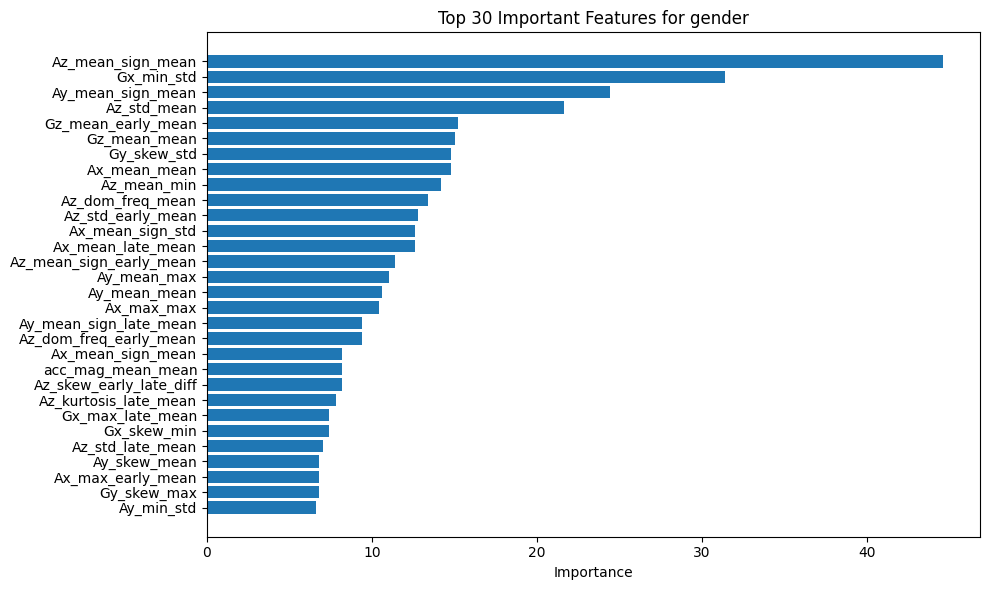

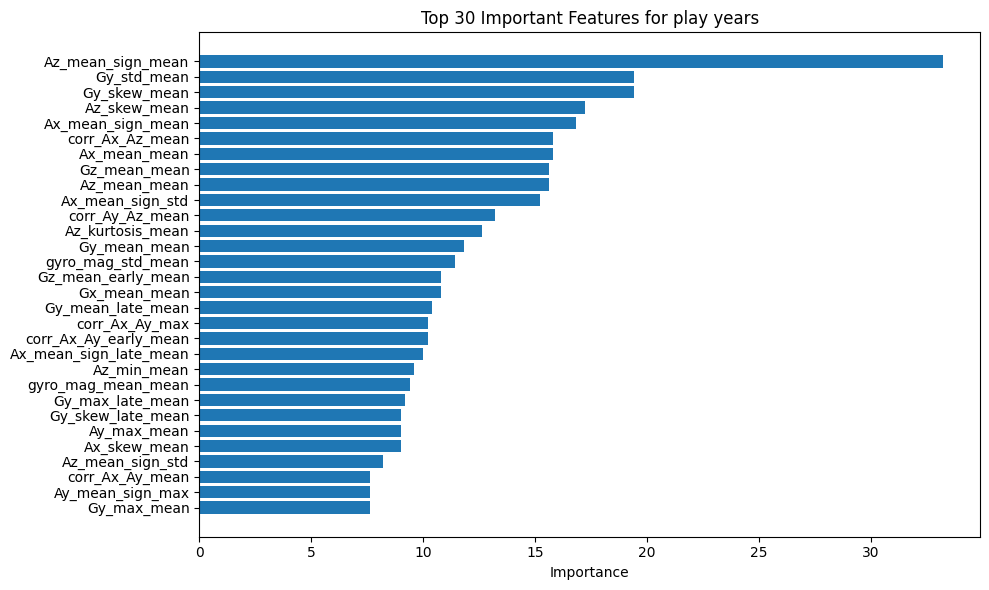

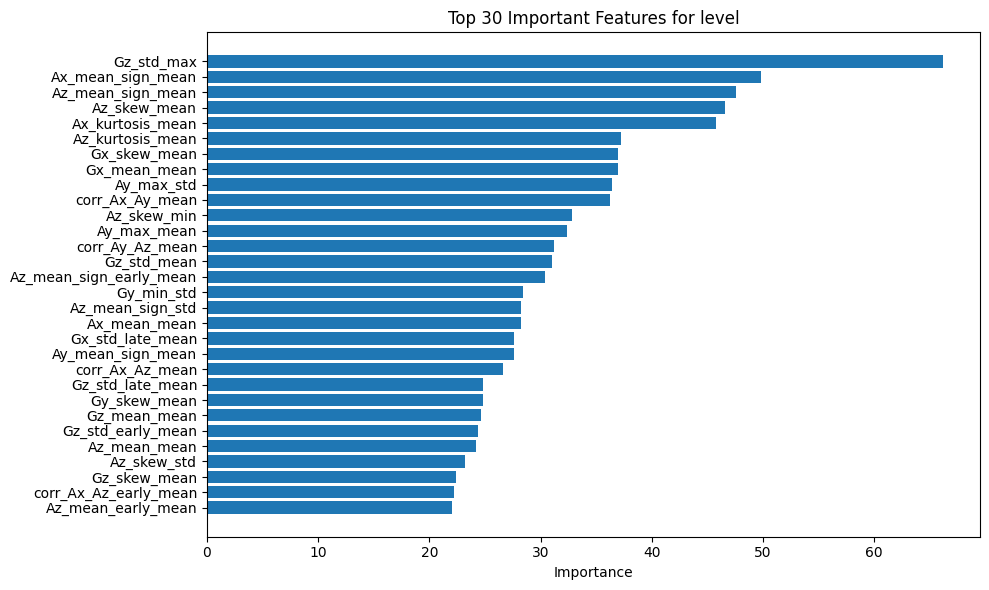

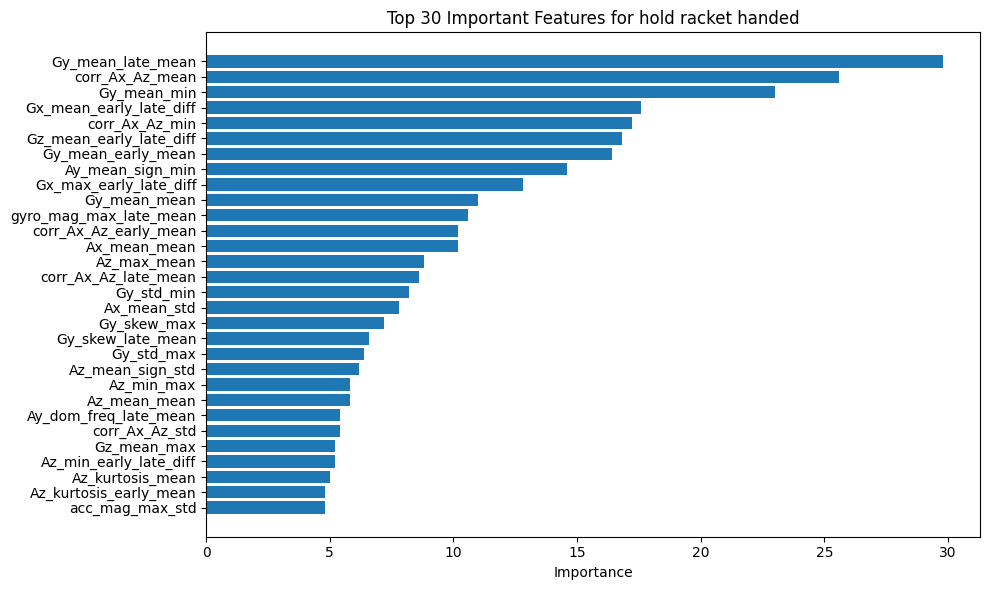

In [19]:
# import matplotlib.pyplot as plt

# def plot_feature_importance(target_name, top_n=30):
#     imp = feature_importances[target_name]
#     imp = imp.sort_values(ascending=False)[:top_n]
    
#     plt.figure(figsize=(10, 6))
#     plt.barh(imp.index[::-1], imp.values[::-1])
#     plt.title(f"Top {top_n} Important Features for {target_name}")
#     plt.xlabel("Importance")
#     plt.tight_layout()
#     plt.show()

# # Example
# plot_feature_importance('gender')
# plot_feature_importance('play years')
# plot_feature_importance('level')
# plot_feature_importance('hold racket handed')

# Feature selection test

In [20]:
# # === Feature Selection ===

# # 1. Select Top N features for each target
# top_n = 30  # you can adjust later
# selected_features = set()

# for target in feature_importances.keys():
#     imp = feature_importances[target].sort_values(ascending=False)
#     top_feats = imp.head(top_n).index.tolist()
#     selected_features.update(top_feats)

# selected_features = sorted(selected_features)
# print(f"✅ Selected {len(selected_features)} unique features after union.")

# # 2. Rebuild X_scaled with only selected features
# X_selected = X[selected_features]

# # 3. Re-scale
# scaler = MinMaxScaler()
# X_selected_scaled = scaler.fit_transform(X_selected)

# print(f"X_selected_scaled shape: {X_selected_scaled.shape}")

✅ Selected 88 unique features after union.
X_selected_scaled shape: (1955, 88)


In [27]:
# # Initialize dict to store AUCs
# auc_scores = {}

# # Gender
# oof_gender, auc_gender = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['gender'].values, folds, 'gender')
# auc_scores['gender'] = auc_gender

# # Handedness
# oof_hand, auc_hand = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['hold racket handed'].values, folds, 'hold racket handed')
# auc_scores['handed'] = auc_hand

# # Play Years
# oof_years, auc_years = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['play years'].values, folds, 'play years')
# auc_scores['years'] = auc_years

# # Level
# oof_level, auc_level = train_lightgbm_one_target(X_selected, X_selected_scaled, y_encoded['level'].values, folds, 'level')
# auc_scores['level'] = auc_level

# # ============================
# # Final Score Computation
# # ============================

# final_cv_score = np.mean(list(auc_scores.values()))
# print("🎯 Final CV Average Score = {:.5f}".format(final_cv_score))

🎯 Start training gender...
📂 Fold 0:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	train's auc: 1	valid's auc: 0.592174
📂 Fold 1:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.990973	valid's auc: 1
📂 Fold 2:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[13]	train's auc: 0.999249	valid's auc: 0.758136
📂 Fold 3:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[47]	train's auc: 1	valid's auc: 0.880942
📂 Fold 4:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[12]	train's auc: 0.998497	valid's auc: 0.977283
✅ gender: Overall OOF AUC = 0.50681
🎯 Start training hold racket handed...
📂 Fold 0:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	train's auc: 0.999814	valid's auc: 